In [1]:
%matplotlib inline

# Подключаем необходимые библиотеки:
# Библиотеки для запуска сервера:
from flask import Flask, request, jsonify, Response, redirect, flash, make_response
from flask import render_template, url_for
from flask_cors import CORS, cross_origin

# Библиотеки для работы с хранилищем sentinel-hub:
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
import sentinelhub
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, DataCollection, bbox_to_dimensions, geo_utils

# Библиотеки для работы с графикой, числовыми матрицами и математического анализа:
import matplotlib.pyplot as plt
from matplotlib import cm
import io
import base64
from base64 import encodebytes
import os
import PIL.Image as Image
import numpy as np
from numpyencoder import NumpyEncoder
import pandas as pd
import math
import cv2
from scipy.signal import argrelextrema, resample
from scipy import interpolate

# Библиотека для работы с форматом Json:
import json

# Библиотека для преобразования географических координат в метрические:
from pyproj import Proj, transform
# Убираем warning бтблиотеки pyproj:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Принимаем запрос на обработку:

request_data = {'download_data': 'exist', 'name_sputnik': 'sentinel-2', 'type_relief': '1', 'contour_line_width': '1', 'sensitivity': '70', 'image_B02': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/wAALCAPoA+gBAREA/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/9oACAEBAAA/APFpLxR90g/gasRnehPvQM7uelNkkIHFVZZdqEk8n3qk0jN3P50m4jvViCcoQCTj61fSVXHUfnSNIq5GR+dOiKt3HSnED1FIOOaUnNRSSBAetUZJC5NRZ5pTQKXpzUkUpRs4GKupcK55Iz7A1KGzTh0prjikSmXa/uw3cms3dzmtO3l8xDk9+5qST5o2HsaoAYcZ7GtCAjyxjGamxxTCOaXmnqcDkUyR9qM2OgzWOVMtww7YzzWlHCEHI70ksSOwJHb1p0aKgOBipVwwJx0qN32nioopGdgCBj2qYYUcUbgwPPNUnlZJOQMA04XQY4yPyNEs6gYz39KpINzitKNQkQ7cCpB0BzS7xt600PtjFMtx3PrVoAZpkkQdTx69qz5EKMRg/lTO1HalqRG2kVaKhlB9qYYwBxUyLgc1I3SoycnFV2XMoz2apj7VG44oRRilOBUZ5NNZtopqsZG9qnUGlakFOJwMUgBPap0AQ84qOSUscUipnmpVGDSuM0hXAyKYVJ5qeAd6kJOeaZLjbUHamOMNS5pwNKM5pxGevSoiGQ/L0pyy461KkozyetP81cHkfnUDsWYgdKUHA4FAf1H509GXOeKkEoB7fnTvMBNGcmkdsUuRt5qHILHjvS5FSITin7Ax44pyqQcUjq3pTQGBHFWY32irIcsOMU/kHgU503qMgGs+6tNwJCgEZ7Cs7DwSDOcZx1q7GwlUcj881HIu049qZiscWhI5bn3Wr8a7UI96RgegqpOxTPJ5zVB2LHrTcUhpc81IszrgA/pR5rsetPS4dOjfoKljuWLck9PQVfPSoZpNkZ9aoySFzTBRignmjjFHFHQ0oYg5BNWre4OcNzzV1TmlI4NNXg9KbecQj/erIyau2jcfj/Srg5HWqsybWz6k1LbyAcZ7VcUgjNDD0p0YDKcjnNKR1qvcHET/AEP8qx95EhOe1aIc+Wc4qOVt3A61YTakWWOPlqBrxVJAIx7g0+KfzHPTpU6YBp4UY5pojA3EZqJ4lbPAz9KrmzbcSG49hSTWxIyCTz6Utva7eW9e61aZT5ZA7ccUL9wg9hSbabL8qD60+Jdq9e9TgHNPIIQ/SqE5Hfk81VoBpSaBViGTkL64FXBETz2p5jPShxUTjapaoIky7sfXNS85NIfoKbjCmmMfemjvUcikkdakjQKo9akLYphpyinBSxqZQqj3qFnyaFXJ5qYAAcUDjNITmpI0LjAxU0lqUQ9T+NRAiNTUEk2c9KriUlyDjtU4x1qJ5CDjjGKYJznAxU6vkDPWng1IGG3mm4z2poUZ6UpTijbSHA6UBh3oIDUKvNP4o3Yo3n1o3Enmn4zTStA4NTIwA60kjYOR9KEm5zxVlZlYYJ/Sn7ARnFRlSDwTipYmIY8np0zVmJwWGf51Y4PQimOgKnpWXeQZzgdv7vtVBXaFj1x09KvKUnBORn61HInln2qkye9OVqP4cis68YkgfWqR4FGeKSilBzR0NKRToeWwPStUsIxzVGeXe+BjAqGkzxSdaAKKX0oNFOBweDWjbSBzjPOfWrBz0pFX5hz3qG+cBNuejD+VZVW7UHP4/wBKts+zGaZLhkBx2zUCHDDFXoWyPwqxnNIE2ndTs8VDMpZGAHY1Sjt8Mc5zj1ovSVAA71FbIxkHHHP8qszxsyjbnIBHWqDRuOCOfrVm0icHJHGKulh2xSB+ef508NzRjml/CjaDUanIx0pQwCke9NVslhS4yRUdxkce9TovOKkAIIqO5cqmPUGqqQbxk/Wla39DVYrt4NJS5pQeQauW0+GC8flVzdnmg4IqtPKu0gHPFJGMKT6inDpSdT0o25FQlD3/AJUh+WkxmlGcdaOvWnbcsBUqpgUZ2ZqNm3HPrT1QGpAKXFLgGkYYFEL4b8KvTTAL1H5VkTSndx6VW81i+Ce9LghgfepfMwP/AK9MDBhzjNJGmWBqyOKeDmlzzTgcjrQp+anMaaxwKhL9aQHIpwbmlDY5p27jNJuyadwRSgj1p2SOlKH9aDikz70u/IwaNvpxViOBtocE/lVmE8EH2HNTrGpGcD8qb5IJ4OPoKiUPGwyG/EVaR8nqBUhJweRVWXDZ4rPuYQwyAOvrVW3mMZIJ/IVfJ844/nVJh6UBQBTCMHFVbyNdm7joe9Zpo7U00vQUDGKOKXIqWFgh/CpJJ2c9eMVCTSdaTFLRSfjRQDS8UYNTQy+XKDzitSNxIgIz0708DFZ1+3zkD1H8qrRpuNaMcaxjGO9OK5FMZcjFQOhXtToZNh5x0rTjPmcind+aaSBRgEHNQsApzURgMuCx/MZqQIq/dA/AUjdDxmoQAzHKDr6VIBtXgUirzkmnFeetGPQ04EjrTixNAbHFQSExsOeMU4YY8UuzBB96mRearXLYlYfT+VTiZFHJx+FRG7APUfkahlmD88U1Z8EDj0q1G9DRK46mqbxFD0qP2o6U9WIYHOKvQTAqASM+5p8jE8KfyqMQ8ZJz9RUhGFAA6CmEmm55p2cCkJBqNwOtN6UoNISelSxrzk0NJgkUiKZGxjqanMHl7Qc5PvT1i7nNATbTSpanCMgZpDjFNUc5pLibAHP61mySc9e3rTEG9xT5W24pFOTnNByWO39Kvww4Q4HekYYJB9aE704mlFKDjmjORTOlNJyaAtIDQKC3al3inA5FNyRTvN59fxqQHcM0pNGQaMUozViK5ZE2ds1IsuWBz1NXoXUpjIz9acuVcntipzGsgyB+Zqv5W09qXdjio2UHt1qJoiozxisq6tyrFl5yR39qlspgSASM5Pb2qJCMYNKRjimmoZ0EkZWsySJlY8dzURGKTFHNJS/jQKcp4pSaQ0UUUUUYoA5pe9BoFWLeYxsOK1A+6HP+zms2UeZcEe4q1HCFUdakUc0MMmmlcc00gOOe1Qum05Aqza3AXIb+dXMg9KCOM00nIIArOu2lVjgPjI6Z9KfbTk8MCOO5q0BxxSFeaaVVcn8ajadPu5yfagOG6UrMaFanA5pjSbWwKBJnrmh23DFMGVU7aWF2MmCAOasFwFPPaqM7BpCaaI2bkCl8lvT9aDEVH/16YcfiKmgc5wT+tXIz60ksYdT0/Ks9kZTyD+VJSU9XK9KuQSK2d3WrYAIxQUqF0waiI5pxU4pnSlPK03b1pNvNOCgUhbmhVz1qWP5Tweal37jyScVIHGAMUmQR1qPdzT92VIx2qPPJFIx2iqE0mT/9eqx5NKjFW60rksRzQDgYqaAA/lWrD/qz9aryD5+e/NQklDx0NSKwYd6UGnClHShgCKjxigikVBjvTsACoiOaURn1/SnAEdzTsDbTMAU+NuQAKkfpUauBnJpxkGKlHNOReOakKEAEULK6kc9D6VOLtsck/kKkW+5+7+lWkuFkHp7YqT5SOtRuB1FNJLLiq0sWeOayXRoJAw4wPWkU5PFS5pueKTZUbxIQcgZ+lVpLQHJGPwWqrwlWIwfyqLaR2P5UlJ605elL0puaXGaKKSlpO9LRRS4paAeavW837tlOOgFQ7wtxkHjIq+jqyD/ClJGaQHNI/SogTzTtu4VAysp4z+FW7e6GNrDqe5qyHDDgjn3oAxzmmSIr/eGaj8iMdF5+pqRQMU9V3GiS3LIcY6HvWTc2rq55X86jRXTjIqeKRj1A/CrCil5FM2nJNHWjaGpAoFOUYNMkbHc85qONNzbj0qwNqjAANM3GlHPBH51DImDkD9Kap2sPrV6Fgyg1MFqGWEspI61RdSrEHscU09qAackhU1fimJ9etW0O4UrLnioWjA5OaZuXHWomxnrRvAHWm+Z16U1ixPFIN5P/ANel2letKpOOeKerZ70m4gnrThITx/WguR3NKGGakVhimkgHNNmf92TWcy85qMrQF55oJxmkBNTRNg/hWrAwIIzUki7lNUpF5IPvUCZVse9WFOetOpelBNM5z0p2M0YxSe1J36U4cCjGaQimqpbmnRjDinSN2qs2c8GpI1J61Yjbaal8zcelKSWXFNzgU3Penq4x1pUcp0qxFd4wCQPwNWVkDDg9aOQetKGBPOPxqpcwB0OB29PesxDz0qTOO9C8ilNMYHI5p4UbeoFQPGpJyM0z7NG/bFVpLNv4QP1qs8LIeRj60CM4zxSMOKbjindOKSlFJzSkGkzzR1oxig8UZpR0o70oZh0JFIWJOcnNXrQkqByeD/Op5crTIHycE/rU79BTNnGacowMn0phUM1RSR7DkYHFOhnIwCT+VXFfKg+1OBDD3oMZxnim4IFKG9KkEpxjikckgcVCy5PNRmP604LgUcGggCo3UnOKiVX9WpY42HVifrUuMCqsjZfHvU8WPL98UCgCjHegjcp+lViME5qSKUp3PStJCGXODSnGKqXMWV3DFUTkEg0Z5oqWN9hrTgf5BUu+k3ArzVWYAHgnrUA3N60pRqBgdcU7rjA/KpFwBzim9ajOScAGnohUZpzAmkCkc0UzPNPRieKSQ7RURJdT7VBIwAxUYPOaQtzTT60AE09Bt5q7aSfMc+laBFVbjCkH61XX72cd6kPTj9Kcp+UcUuaQHmjPNLSc+tBHejFGKdRjNNC09Rg5pr8kUgU08LilHBpRkUpkAHJpobcTg0u0kdaVRgYp3INNOetSRTMpGSeCO9X4pA+On50+ReOB+VIMMOa5yGXKgHr9asgbh1py5HSgHNBBPNI2cVBLLsHfrT424yaXf3qrNLlgBnqaeq+ZGR7VSmi8tyM0zOKBQehoFOxRim4FJgAUmaCfalFLxmlC5bAFWUtvlye/qKieHEgx3PpV22jCID7H+dE7ZPUHmmwx/MDxVkr8lNBB4/CnEYGKbj0pQcjBqGWAgZBpsMmxtrYHIFaKFSvynNPAYjpQE9aYygnim4IPNGc0jA44phzmg0zHNKB70pHtSBaCBimOQEOapnmT8asLwAKXpS5FBHFN5zSOgYe9VihQ9qs29xs+9gDHpV4FX6GkYZGO1VJ4vTPeqpGODTec0761PFcFepPX1q4kwK59vWkeb0/nUWGkOcnH509FA64FEjDB2/pUQTJOalVQBxSlDjNNCmnbMUueMUmaM8Uwn5qaBg05SBzUM78fnVUOcngU1snmlPSm859qQ09elO/GpoCQ3TtWuMkcioJ493b9KjFuQpJyOPSowNrYzmn8YpM8Ui07FLjiikC5OKXmgCik6U4YNJnFIeaevpSnNJkCmls9KjIYnqamiXFSngU0dakGAOtMNNxUsbOjDnjIrSgcSDBz0prLtY4rk4jhx9RV9CdoNPU8cUAYpxb5eKBkqQfSonhyvWq3kOjcAH8assDULQ5bPP51JEpGagvVGM9yf6VR70tH40uaM0ZpuaSlJ46UgzSinBSxwBmrlvB8wLAdatsuFA9BUXlgtz60smUjOKrrlzyatISRUn8FRFfmP1pSpK9KZHGVcnHanHrT1YniopYs881GkrxHGcDNXIr0YwxH5GrBmRlGGpgPPWgnn1oApCcGk4PammmclqO9O+tLgU08daqTSjpz0qKMbm/GrSoKCKFXig03HNLg8Usi7k75qqybRUkMrIQM4FaKcrzQ0YYHp+VUp4uSQP0qtjBpM5oBxUquRxn9aep3Ec1bjGxBULNSBsGpF55pwYKTSli1PSmscGo93NL6UMOKj7U2lzmopYyQMZqAxMO1AXnBpdtMPWmHrT1PTipAAWH1q3Eq9eOlai4Io8sk5xxTZB8mPaqL8OaTORxSUnQ04HNO60YzS8UDpR3pDRQKCDSYNL0o3U0tTQ3FOBxzUiNmpWKgUwHPSk3GjdmnDnmlD81YjuNg6Zp63O9uRj8K5cZBBrQt2/dKamJyKcCM80pGRSZwOaQONxANLmmscrmm5VuAaQkIcE9aiuV3Rg9cA1mkUvAoooo7UhzRiigZpQOQPWtC3twEDED86sgKvQUpGTRjFMlj3cmolXDGpMbeafk0xuOnekZyqEnHSmxSs/PGKc+cZxinIQKefmGKgaIEn/CoGRlYgZpQZQOr/rSrcOOob86mW7OACP1p63a5+bj8ad9pjZsA5p/mptHBoLKOxpu9cZwaQOmScGhrhBjhqY12o7H8qryXBfHAqIKSelWYwFFS9KTGaQfKadwaYRg80ZpV5zk0ySPd/wDqqqcr3rQtp9w59fWrXUcd6jdcjkfpVOaDHIB5PpVU5JxRQDzVmAAsOO4q1K2BheMVAeRTSakiII5zmgnLECnICetSFDjIFNJI68UwtzxSjJpTnFMPXpTaVQO+KkwpHamNtIIwKqyjacg0wH1pGFM25pVB5p4GMVKsjKetacMp28nvVtH4qOQgg/jWe5+c/Wk7UAUh5oFOBpwIFO4NHagDNGOaMc0uMmjFNHBoNN9aY9Rg08HPFPXOakJOBSE4FAXdSlMc0Lk0/kUo5oBUNjNYY6jFX7dT5Y4/zmpGDZ4FPGaUkimyAshwcHFRwoy5LHJNSjk1BLI20qEPPpUNt5gYbtx57/SpJVZ3UgkDNTOoMWP9nFZs0RVj8pI+lRcUYopPrQBTqBjNISM0oHFKg/eA+4rUjYeUKeMY60itjrTs5Ipjvk4pvGeKceaUZPSgjAyR0qnLLukCD1x1qzEmFA/pTmHqcCmecg7qfxpn2oK3AH50ouVOScD8aaJEaXJPcVaVEYdP1qL7Oh7frTWtfTH5moGhIbHHWl8g47UghI9KXyTjqKDC3pn8aQQv6frSi3c9v1p62rHqD+YoMGw96cBjrS9DTs9KeCKRhnpQBihhnmm4oGBTuCMYqvPGAAQOelJbuAcZ71oxPlfwqUjOKjlUAVlzLsYmo8+lKKkjbDVOXpN2aawzTWUjmhWwasRtk5q0rDGKbJHuAxVYgjinJTz04FRnr0pppKWmMQMkkVXc7n68UmOabnIpBS8805eB705WyeauxvWhATt/GklyM1nucOfrSjkUmOKTtQaUHFLS5pw5pw+lHekPU0DOaWkpDzSYxTMbqTbigLTwcGl3ZpQc1IoG2lPzcUFdvNNzkUnIoHWsiNCXGBnBrRi4QDGKbIxHTNIZGHY/nTg5LDINOdsAUwy9sfrUfnfvCB/Opd6k9vzpVUY460AENz0pJCRyKbtWReR71nOm1iKSmng0mDSjNL2oOKKTvTgcYq5bybhj2qzjinbaRuBxUWfm59e9Ln5yKheRt5Az+Bq5EpA5Pekl+6eapLCvm7s87s1dXCx5qrcXHZT3qnuycmjOaM8GnRk7h9avJJhQDUysBT1bvVa6+8D7mnRHco+gqTZTwtJjmgrk80FcdBQrYPNKVDdv0phi/wA4pGjx3/SmY5py4A5pdw9KM5pCy9MjP1pM009qctEibhVE/IwIq/bPuUf57Vc/hH0ppGagmjzxz1rOdCp6UZFAPNTxsMYJpWHpSA+tO+8KjIwamhPzde4qy3A4/Sk8zsf50xiDQBxTgSKRue1RGim5qGZug+tQ5/SjfgU0HFKPmNOzjGKXNLVuHla1YgFQ+uaY+TkVnSg+Zz6mms+wf/XpVkDDsPxqTHFNxikxzTgaMc05TTxnFJ3o5o5xR1oPFJmikBozkU3aM80Y7ClxigECl8z0/nT0Y05myppgPWnY4BpOtRJCq9h+VPwFz0qPcGbAFIwHcUOwHIqJXZ3wQcA+lPZF64qMIhcnHNPEfHapUXaKH5qMngio87AT7VBlZHPJqaODHJzVdot7krnn3qJkKE5ptGaWg0UdqntiQ3rxWgATTwCaRsAHNV5PvAg05Vyue9RlPmJwasI/FK4ypqIRgMDjvSXD7EAHoaz2bLGikHFKRTo/vfjVtelPyRThICcA0yblaLdsNj3FXOCKMcdaQjFIDmigikyRRv8AWoZZ1XuPzqu10M4XP5CplZmAOafSqeeajMbBwcjFOAx1oJB6UDipEO6qlzGQ2famW8m1wOK1UO9B9KcFzxSMhFU7mIEAqPaqQ9xRn2pQSD1qZJARg/zp7AdsUkZ+YZpZMdqYhwc1OsuRgmhj3oBzTg2OKcZAMcGmu4I4qJjSA8U15FCn+tVWfLE+9ICOaDz0pM5FAPPFKcjmnLzT+gqzbMMde1a0LBl/GlKdTVaaD+LHqelU5EyMEfpUYjCj71TK2R1pTzzQRkULxTgQTQKM80uTS59aAaAcUHFNNFKBkdKMAUNTc0vbrTdue9OCcf8A1qeFI4peMU5UHUilKjsKjYbaaDg0pw3WkWMBsgUjJxUO0Z5oAAORTt2QQajChXyM81IGwaC9Gc0hHFMYZ4qIxDcTzU+e1RxoFPr9ajuYeAw9z0qpjFH4UoGKOfSjBqVIS/r+VW4oVjHXmrClSODk09Tiops4JFQZz17VKnK0ZFKBTxk9aTq341UvDyPxqnxS8UUdqcpwwPvV2MhkBoZgOtQAt5g61aADJ0Gar8xy+gz9KtJKDjkfnUwYEdaRjzSjil4pvrimkmq9zKUwAapFXc5JFSxQY+ZsevWrQ6DHal3YODS9RTS2Dik3ZoHNGDmnKwFOlUOh61n/AHTnvWhaT7gFOew61e6U1jkVCy7uMVRmhKdPT0qDPtSUvIqRZD3NS4BGRQBk04xgY4pCmORim7yBzQHNOySM8U3dzS5pGUkVC4b0oWLcOc0pgGO9OW2XHUg1KsCKvJB/4DVeSA7jj9BToYDvG4fmKsNAhH8P5Unkqo7flULjnAH5UsSuGPBxj0rSgk2EA8c1e3KehFLtDLj2qncQqozj171Rfb0xTc7ak3jacZoDU/HFA60mKMZOaUZzRxRyDxSjPpSYJob6Uc4oBxmjPeg03HPBpSDTlBpwJFSAjGaY2FFORgRT2cADrULOGJ61XicyAnNSg04HK0wEE55qNlw4qQD5KQKaRk5pCDmk2E07GBgUw5Gaac8cUbSR3pOR3NKDjtQ/zriqrQnOMfpTltifX8qVrR+2fxFPFtgZxTRD82eMCp4ipyAOlRTu4YhWxTrVmLnJzxVzHFRSDIxUQUKe9Sg/Lx6UnQU/dnrSk45FNBy3NQXSBhke9UcY4pO2aWlyAKMgirEGSvU4walIyPWjAz0FPTIpsyAjPfmq6llbGauRsdo5qbGacBgUhxRSbTmnvCCM5NQlKacE4NMlIjjJ9jWY8pZyeMUqSlTwBV8HzBkfSjBHWnfjS5GKa3zDg4+lLE5wQwJ+tRyxcZA/So4W2TDJ4B9cVrqwZFOc5HrS8UwsAahkUMOlUZU2MelRmgdaDTlcr3qYNTlYscAVYe2kSJWZcBhnqKrsg9TSKAKmXkUmMGkKrmgj0pvlg9cVGVwcA0oB7k1KF+Xr2oXnvTjge9IXweBTd+eSaGfjFCqOpHWnhgp6U535yvFPW5Ydz+QqT7YRjk/kKq3N2zA9+vUVRaViOgpUmwecVYinGeo/KrOUkUcmk8s9qQhh2pCx7gU4OPWgMD3petB4pVPFKTzS8Uvy800oOcU3bxSHmnqMUu3d0p6xsB1FPWMn0oaPB4xTJFGKaMKOtRM43H6013VFLE8AZNV7Vwq5P0pXuhuIyOvoafGd3zDoamXrSs2RTVbtUoXjNNI5JNNJGeMU5hxxTDkU0nJ6U4qMDpSqvrSGNTUTJgcUi5BpSOaeDtXPpTPtag4Ib8qk3AjihvuEVHjCtj0quHw7A98VZiwFBqwOaikwBxVXlpPxqz0UY9KTJxzSghhgVLj5elMIwelMYZzmq8kAPI/lUZh7f0oMB9/yo+zk9z+VOW29T+lSoojTApR0pSKeMk0k3ygVVPXNTwuentVxTR1pcYpaRnCLnPNNSQPQcioW+9UcyF4yBnoazniZOoqOtK0zsOR3qdl9qYRSeoxSAHOOacDTwdy4NU5kKue3erlnNldpzwAKudelIYs88UwrlailjDIeKoOhU000dqO9ORitTI4PerS3hWPYApGMcg1XZ9zk4AHtQBmnqccUrnjrTM0FuKTcaaeuc0oIJHNOL4GBSK3FOzRkU3AxSEUvpQaM5o74o9KaUBzSLHz3oaIDg5pPLGeKd8wxhj+dPDuMfMfzp6uc5OT+NKZFI+6BUJJBpc8Uocr60omyeak3DHFAfJzTweM0oBOaDxRnijb3qRY8jrT0ibPSrMaY605iAOKiYgVC4zURXIqIxnOcVnajN0hHblv6U9YW2ZGc/WiO1ZnBIPX1FXQgjjC4GRmgGkIO3nNC8NUu/AxTTyDzULZU+tP8w5wRTic00gAdKBzTg+KM5pjHiod3JoU5NSMNyFfaqhtPmzz+YqxGuypWBpr5MZGO1QwwYbJz2NWjgDilBHrSYyOaY0YByMflS+nNBHemr941P0NDcjpTCtRsccEUzgmn03ODSnkZpAM5p4HGKCMUq8GknBMdVm+7+FIrYUVchmDDk/pVjIxwahMhDYwKjaZsnFRPKzDHP51JbE5yT2q0wqBkO6lAwKqzAMwG0Dt0pY7VAMnb+K1OqqvTH4U/BNNINMINIc0zBBqVRzTnUMh9apK5hnPfLf1rTgkLpmphnFB6cVERUE0JYcA96oupQ4NN5xS5o6daVTg9alBz3pM4NOD4/wD109W70FgQeaTPFMzzSk0AEjGaaVeMdRQDkc0m8AnrT1fIzTsigEHvSnGKTcOnpSE8UqinFCOaTGKOTQKOtJ19qO1IM+9OB96Q0cHrThjvSHnNMximGRh34qSOUdDmrPmgKetOiuF3Y5Az6VP8r9DTTEfekAKnGKcr4NTCZehP6U8TADqPypnngntTGfceKVhxUJ471FcXC28LOeccAZ6mufZi7FmOSTk1uBdowf5VJGMHgU+QjHbNQBucU4njrTFbB5qUDdQflBqMjPNLtzSgcUEjFHp7049MUwjFAXJprx/Kahxg1KDxRSEHd+FBY+tG7IwOtJvI4xTgcj0pw+tG7AppbPSkDGn5G33poPOakyxGQaepz1pcdxUUoB571BjFMcFqeq461IF44pwUjBp+cVGTzQuC1E5+XHtVRjTC1KJSvTP51Kl7zz/6FQ10D2/WmefkHj9aaZcf/rpBcFemfwNaNvJ5inPr61IeTnFAANMaJGOdvI96RhhcCm84pVf1oZs0YyKQp3o8sHmk3bTgUFsmoZowwyM96bbSbGI46itSEh1Bp2MUxx6VEW7GoJog/I9+1VXQp/8Aqpg6UClpQ2KkUggmgru6UmcUpOKXcCKOpo71ItR3BJXIHao48k80rRZ5GafEhA5pxU9qTdg4pXJC8elQsWHOP1pPO4x/WlEnv+tTeZkdc/jTi1Jupc0ooIyaTAxSZGKbmgmmM+04pBKS2OakVhkVL1FMccYqLYc8VIF3Kc1GYyOgqxbyMhwQO1aURDpk1HKyp+dQBgTS7velDGlz7VImCKHbb/F+tQvIOuR+dY99cebLsH3UP5mqddCMyD0pJJkgAyeT6VElwsrkc9akIAOabkk00AlhmrCHAoc00c0HilDAUxmGaQtkCgHvS53GpEA70rAbTVZ05zTQcE0u7jNAOTS4poOGpjMcn5TTlZioGKfvwPennBFM6UY6U7aBzSEipU5PFKxOc1H5w3BSOvFK4AUkelQK1GKfHyamxgUjN0phbimg5NRLNidVAyPrVqRdy9McVnSHDsPc1GTR1FRng0ZpdxFIW6UZrQsnwD781dwRTd1BYgcUzeSeaAwzQQCar3AODtGeKrAyL/CKlilfOCBVkNxzTFlDv+HpT2FNz2NV5YyrblJ654FT2t1sO1j0Hdq0Sdwyv6UntUTrlv8A61NZSBVeVMjrzVYjaabS0AdachxxUwGBSOAOlIeRSY4pQvNO5UZpQTjNGRjHelUDv0prnHSkViT7YpS3OM0mMsDSFsnpSsQVxgdKh8sFuw/CkkQqox6+lRiRhThOc8k/lUySbhTgxzTy+KC3GabuppOTQBk06RQsec8iqvLdKVso3NTIQVqVTRkE0d6FzS59qUdasJOUBHP50x5C57/nSDp1pwINSAe9Ix9Kb5pXPXNRvKzd/wBKpXMzJEfm5bgVnUVtvdLGvyhh+FUJpWlbJPAJ7VGGIOatQz/dBz+VXVI60h65p6EUuQM800t1xSZJFJnFIBzzS8YNGOPpTc89KcHx/wDrp+7PekIzxUTLzTdnNSKoxSHg00AFunNPKZo2gA00KDzinYzQOtPzxzTSQRTejU8HAqOSUKOtRo4MgOanc/Jx3FVx15p45GBUirgZpxaomJJ70jnCZ9qh89lH3D+dLCuPmI5B71cDbkNZ06kSH6moc0hbFGcjmm0tJ1pKlilKHp2rSgnEnsc1Oc008UhFJgUUhAPUVEyKT0H5UqqoxwPyp5XK1Q3GGUg5xj6VdUhhmg0uAykEDpVSWMxvvX19Ku2d4MBZCOAe49augK3KkY+tMYc5pjcio3QY6VTlXLHFQ4pfajHFGelSo/GKcrBjijIHBoY5HFIoan8kYIpQCBSMuTkGmudq4zTR83U0vTpSZ5pd3HFJkU3k05RzSTEBfxqofu0YzSglTnNSLOQeealWQHrS7lx1ppkBPBpUyTnFSUmzdTliVeTTWjWXp1+lHlFKCfwp3agHiinLTlGaCDTlU07FNUEjipeQnJpm7OaaQWNIyqq5JxjqayLiXzZSwBA6AH0qGirJBxTfainoPmH1rTh/1S0/BPWjPNNY0qnOaTv0pcZ7UmMUuRim56008Uc0oJzzT0OacV70zHzU/bkVG4o245pwPSkPf3pAMdaFPOKbnBpwNNJ5oJGc012IUH3qiZieufzpfPwRx+tWY7oHAbHbq1THY+SpX8KRRin596bgn1pwQ46GmEdcikKIV6frS7RipIz2qvdpgbvrVEg0mOaSkpTRjijtSjjmnI+1gRWjb3AYYOOvpVjhuaQ8UhPPSjj2pjcjrSYpp69aXcRwM1DcRCRc4OSaS1kz8rdSasmgDFNdQykYqjKhiYlcDtV+zuiwIOevoKusc0m3INQOCppgUE5JNVZgobjNRYpeoxR0pRkGpAMtkU4kZpwGRwPypm/acEY+tKZV7EfnUZn+Yj+tODE8g/lTGZu+aQEmpR0FIRnpTATSEk05eRUmMCkbDLk1WMR6ikIKimDJNWI4NwzzTJIyjd8UYAGaRWBYVdjUH/8AVSsozx/Kmsdo6ZqNmY9ARSjcgyMmpRICvI/OomIJ6Uox3FOwD0xS4wKM4NOVsc0FsmnAmkJNPRscClbmoyQtLuJUcCqd9MVQRjq3J9hWbRRW3Z7GTGTnP9Ke9mpBGWz9RVd7IDsfzFNW1YSDjjIq6I9iAD+VCnB5oYcZ6UylH0pcUhdV7j86axyhK9aZGSc7vX0p2eTQSBR1HFJyVpVPHFSK2etKRzQoOenFJIPl49aaBkZNO4C0w03qeaeqqDnNIy9xRxtoK5FNKkDPWmkZWqLwkcjP5VEw4pM4xzVu1mGdrdyKttxyOlKUOOMVIFOOKA+Dg018HGKaFpOhoXg0sy74TVBkwaYRzTW6000mKd0FNp3bFLjFSRsVORmtCGTIHPp3qY4prEVD5oJxkfnTgPenYAxTWXuKRfenEDFUWPlTKR0xV0HNB5pe1MK7hVF1eE5A/OrkF9kYJXOfQ1P9qyOMfkalDhl59KhkyvI6VTkO4mmUDiloxz1qRGwalIBHakVzH2zQwSTkj9aYYkHp+dRNECeMVOibV/Gh0GOlAiwoPFKcDAppGOajI+alYBBzSxncOPWpCOlKQAPaq8sgA4PeoSaMEdqesxTufzqQSh1OQPxNRORjApvTpViFmznJqYscqAM+tSFAVHNMKgUgFNI7UiDnmpNu4cdqbjDcUZOacOTQaUJmjBU04HuaUNQTkUhXimO+xGZuABWRI7SOXbqaZRRWpZNiTk4xk9a1M1Hu3PjHQ08qo7ClGDTGAz0qJmOMU1R1p2dvWoZrjYOM/lVKS4ZieT+VTW8+Tg56+lWcY5FBIA5pm9Se9SKDjIpccUw9aUHGKccnnFOBGMGkJ7UgJx04p6EE4IpkqkMMA9e1AUgZI/Sk7dacpyNtIwwCKaGwDS5JHtQV9qjZR0xVWWD+7gfjVYxkHnFKmVYY9auCRmQDP6VaizjJNSGX5SAPzqDHzEmlzkgU4jApppBUw+5iqs8fU49aqMKbjnmm4ooIyKFFOIwaDUmNo61NA3zdauBsgfSkxmq/kFXJOPzqyADTW60gz3pcCmlqrXvYiprdsxn61LilIpM4FRvGGPIBFVGhMZyBxVy22OADjPTpVoJ0x+gpskZ2nP8AKqMqbWPHH0qKloopC+KsRuGBpWBppGAaReaeeBTlPFNZSTTcN0AoKv1IpDzgUuzdzUdy4I2juKWEbVqckcU1xuQ49KqFCDyCfqKdHFv9vwqdoVbgED8Ki+zHJ5P5UqQc8n9KUwqW6ioxGN5FTqAOlPX71PG71prE5xSr70MAOlRnIyafHIUYHjqKdK+9sjvTQpPWnj2po6UtRPKFPWnI+9c04U40Dnis++mDMIlOQvJ+tUqKKKuxNtPB/WtRZG29aWIkyHNTNjpkUcKOlNzu5qFhk0YNMmbC49jUQRWjBPU1Wni2/NnjNVhwc04SsDnAp28vgYFSJAxOcH86txjaKmJ9KQiozwaeGytAJzTuopMHNSRqMdec1KoGecGnFFYdKhkiA+7UWGU5oHz9aYeDSg+nSpARjFROuTTDSbA3XNCxAHPNPwAakHPApgXBqRgcD6UmzoaCMk0xgaQdKlB+XrUcgyDVJx81RmkI9qTFLigA5pc4NKvNIzE1Pbrzk1bFP6LSHJoHSlA+ah6bim4BNRXK7gPrSW4KnB6ZqwWA4pc5HSmng0wk570Y3DkUwKUfIJx6CtCCQFQDjOB3qR1DYqtPAW6DPNZ7IVODxTc0ZzQzYFRFs1JC20n6VbJ5zSgg9ajI+b2zS4DHAqVVpxXnNLkAUwsp44/KoiACaVWqOdVC5yM0qAbD9ad6c0/pTSM9qao29Kdn5hwakU5HNIRgHFMxxmoCp8wnPFTqM07oacGz+FNINAOKk2gjNRuoUZqAhic44p+CF4pPMcDNSBs0tRySYGAefrVcknOalhOBirA4oJ5xio55vIiLd+gHvWSSSSSck9zSUUUVbCMp6ir0EpPBz1p/mlX4NQT3Tjox79hVf7RI3Bb9BU0ckgHG38am/e5HCn6UOz56DpTSGbBxTwpwue1K4LKF96oyW7R9QfzqEKc4q3DAMAkelSmREOM09JEb+JfzqXHPFIc+lMIyaVe9O20oHNB4oDEc1KGJFODkDmlX56V0HpVWSMxnt0pBh+OaGXaRinDHem4zTNtKFoIxTTUiNt7U4EE5xxT2weKaeBTR1pcZqJgQeKEPPWnHnpVWZCOcetQEd6MYpMc0YpcgCmnk0vTinFcc1ZiGAKlA5p5PFKoOM0FSTTj04603GOTS5B6U3ABJpuN7YI4pHGxwMdqUckHNKWxRncKaw4pN2BTQ4b1qdG2gGrkbB0zz0qRUDVQvbcLgjH51ncjg0FsKaiJpM80DGa0YmDKee9OYjoDSMMrxSIpBHFOd8cDioBJIf7351Lz3J/GkwOuaRu/FNX5qZcgkA0kbhuKsrjApWpByKQrjrTMnrT15qQkbce1QsMU1jgVIgyKcq5NDjaBikViBTvvihSehNK65GKYVAXGB0pybcYOKcyKUHA/KowtNlOxTzVUnJzSCpoQTzU5OBk0hcVm3UxlkwD8q8CoKKKKK3dvyAd6gaMg54qJpAtQO5kYDinpbOwzg/mKtwRsgwRVgnJppG40oXHYUbeM1BLKE/P1xVOS4aT1/OiBcuGbp71LPOFACfoarFyxySfzpAxU5BNXYLvAw3p3NWfORj1H50MQKaCAafuG2gGlzkc0zrUijpipSp2Hp0qFdwc8dqnMgApkzhzjPUVC8YRQwzzTVbB5qXcCvB5pFIzRjmlOAOgqPOTSPgAYxQnNPAwOtBJ60KSc07tTN21uaRuRmmAc1MmO9JNGGXp2NUXAU4o8skZ4puzNMIxTacBxmlC7mNSBSwxirCIVFSjHegZyalX7o4pjGm596GbgUA8UHpnNLHyaiuZVVuR2psUqNx3p5XNKBikPWl2jbn3puwE8CpkXjFOjYo+OME4qzu2nNI/zis64iI5A7etUXJyQabSGkq5bSDp71ZZcinpt2kEjpTHI7fpTApbk5qQBUHQGmtlj6Cmhcd6CCRTolUdRziopvm+VeOajihK8nHWp14pw5pQvzU8jIqIJQFwaUjNIRxTNvPNSLxTgMHNI5zTSyr1xSh1xwR+BpVyTVhk4zURAJphTDAj19KeTxTcVWuG3HHtUPfFLirduvyc1IVBqpeyCJcKcO3p2FZtFFFFFdCCMUrKrKeTWRKo3Ae1Wba1BwzD0Parh2rwAPyqN5FUUAnrThncKczqiknH4mqsl4OQB69GqozNM+Bnn3zVhLVSPmYD8KbIEjUhSD+NVCcsSaOKUUhqRZGU9a0Y3Egzz1xTiAab0opaB6U8HBpXkYY4FJvDLz1qNmbpQDzkk1MyFkU54wKiGN2MDrTzjGaZu5oEgx/wDXpc5HWm96UrnvTQCpqTrS8YpmcGnbs0xhk04DIoZcU0E5qVyfL59Kp7MyA+4qwThQKiVRTWgLHv8AnUfkANzmpPKXGKBGAeAPypV4PSpaDxinoQe1OJ2imE5pCKRulAORxSjoaVODxVK6bLDPpTIMBgTVoS5IAzU4HHHeo2+U05TxgU7B9KaGYE5Ap4bdz6VKrgrjPNPRsnFK8IdD0/Ksa6j2SEjoeelV6OtJ0pyNsbNaKTqwxgfnSdCeOtOHNOyFGKaCSeaN3FJ1oKnGaY3AzUayfOcCpcnFApy8ZzS5yfalyKKcQM5pMc0hGTTWWgetSZGKDg1RuCQ/XuaWAkvj2qw0mzsfwFWFm8yM9c57ioXlCnBzmnxtuBoJ5oJ4qk5LN+FM6ClUZYfWr6riNfcUHCKWJwAMmseeUzTM/bt9KiooooorfjIbinA4OKy7hCsg69KuWkgZducEADrUsg6VEyb6lAyKGPloT6VRnn35Gaqk8/WnIxRsg1KbiQ/xfoKhLEnk0lHagdKXPFGCRxVuzbsfU/yq4eajNIcjpSjNL0qQc4NKwyv0FRr96n7QTjimvGe36CpGfam3BOBTB1BIxmnNgDG3rTTGNoIqMR59KQHbxS5JPWkMhFJ5nPenFzigSUFt2aVaefmoGOlBHFIDTmOR+FRhRkU51OPamhM9DTgpFMZeTSL3yKP4ulKq55pWO0etL1UHFOQYzmhjkUw07r1ppHFN3FVbHpRA2d2am6Gq8kSyN1ORVdbdu4P51YjjEQyc0C6CvjIxn0NOknUjOf0pqzc5GPypRM5boMUrNkelPj496m2980obaanR8/8A66rXVvvUkDPA6D3rIkXY5BHciozRSVLC5Rx6VfQ7wD7U8gAUzqSacOlM60EGpFYbce1RyDOQKasYAyc0pbHFICdwp5bjGBQBiin/AI0YNL07Uh4qORjilTladjFIc54qvLCzEHIqSCEocnFWPKD9qCoRSBULwb+c05IygxTtuCD60jtgc1SzSUoODUouGGBxUF3csy+Xnryap0UUUUUVukbehpg3bs5NVrsktwM8UWgZZAeQPpV8sCMUxsBeKE6Uso3wsO9ZbxkEscVGaWk70dTRRQaUAmlzjinRO0bDnArQjlV1HPOPSlam96XvS45pQ2DTw3PTikIBbjikzhzUq59ajBJYA8inyDAXFDD93n2qESHpmhSacSCKiI28+tGaDyaDkik6Cl4penSlVj3p3U8GnHOKZnFBz70oPIp5bPFIDijdSfhTTxTM809aXg8EUvbAp3amn2pNtKVxxTaa3QimQnDN9anzjmqrS4lI4qychTgCqksrkle/saWKE9W74PNTMiYxlRUDLhuH49qsRqB1INDLkcHFOjOOOtWF5XrRj1pytjpUinK4bmsvUIQh3DHJJqgaSjNL0q5btuX9KshD6Upxtx3poWkJwMDrSgHvSgKM0owc01xgcc0wKSMkUm7FOXnmnHkUgPak3EH2qVXDClzkimkcmo3HJBoQ7Tin5yKUDIpeelNYY5p0UhzjjpTnNC+9KcGo3bAqrLIx4qI0CjFKzBELHtVIkscnk0lFFFFFFb7gZpgB7VGIgx+bmpAip2ozRjNOHFKDmkkTMZ61nvA288Hr601oSgzg/nUJpMYpQaKXqRVmOMLHvIyMHtVX3pe9OWRl6MfzqeO5OQG/U1YDBgCMU8YIpR70hIzxS54p6dGNRucmpFkA9aaRk8UjNxinoxxjimOuXNLnFC5U+1OcLsyTUB68dKcuCcUpUCjbnpSAeoxSkYxTCcYp6epNPLjOMUyVe4FRmRlT6UscysCO9SLnrSnOKaAc04cHmhselRsvpQvvTqCeaNx4pxJxxSDNO4A5pDTcc1FGMSvk9Wqc9cVGbcFyxxz7VJkVF5ce7cWXPpUTy84XoOODVaSVt/DH86b5j4608XDj+I/kKeLpsdT+Qqa3lZ2Iq/GeKVhk0YFPQ1Fex+ZAeen+IrEcYYj0OKbjiilqxan5gPf+lXeaYT83Wn5GKQjNGeetM53d8Zp4YZA6U4+lOx8uKgZMc4pyAcDFOYBeneo13GTrxT2WlUbTQwOaRX5xQy7jmmFSvOKkRs9aUghhT8cUdqF680rA9hSYwOtIOtNkGFJ9jVJuTTe9LRVeZ9zbR0H86hooooooordLZozjpSKRUUuWPTtT0XAFSdBSULyaZvfcAQMU0kZ96jlPyEY7GqTdelGKTt0pe1C8sPrVwnFtgjsapnikooq1bv8AKRVkHinDkUh4FKq5qRuF/CosZNKIiWORU5AQ1XbcXPHGamRtqc+lQyP83FIW+UetS/eQ4PNNYNjBzQq8dKjPD+lSZDKOaljUBckjrTJAAeMUw5AyaQKHyTTtuBxR0HvSls9ajdQVIPSmIioScUvn4JAz0qGS6K8ZP5CozdOey01bg5ycVNHcsWAwOoqyXJHam55zThmn8YpCBRkUowKQ8+1HakHB5OKqlj5/B/i9fera5Iz1px6elRnJU461SImPr+VEg2IM9WFVu9LS9KSp7ZislacbkjtUm7I96BmnKeacw3KRWPdxbZCeeSaq0UueakgbEorRUZTPtUYU7j1pSCD3p6jmmsKTkjjrTcMGBI71MPWlDZpjk9KWMZIpx603ktSnjmmKcmnZOelIV5zT0zmpTtxyaqscNwe1TdRmlHINIc0AHfTy2D0pMZbGabg7sDpUNw+AB9RVSl7UlNlfYvHU9KqUUUUUUUUVtkAL1poIPFO2Y6ZpwHFGKdjrmmN1pU4NK5B/hA96qsCjMxbjPFNVvNOMd/rSyW/GcfpUHkN7/lQ0BAJyfyqLHOKlgj+cEjjIqzPjyziqBpO9OzxSVNbnD/iKvZFBzS9RS+lG7HWkU7m9qm8xQetR7izVIoVuOB+FNdCc4zj6VXIIbBpzD5eKASvHNOG5jnJpQSpINDRg8ik27aUllGDSDnk0jMDxzTkA5pxOelKANtGOaY4wajYZFR+WM96a0AJzzTvKUcZNHkrjqacIwMd6kxxzSEcU5etLSn7tMpw57UNgdSBTfNQfxL+dV5px0Uj8OarhyGz75q9byF069KlJzTVOKDjGRWdcMTJ+JqOkooqWE/vBWnESFH0FP4zmnrzSg4NSKc9qo38WRnHqelZdJRTl4Oc1pwNujH0FS7Kaymm80Ecc0KOaG54pVQhaFfacU5vm6Ug44o2k5oGBnJ6VBLMAcKQfwqRATyRUgFIRSA4NO+93qEoSe/5VMnTFOAw1Ob7v4Uxc9aUEMeaAuWFK2EUms+Z9zn2JqM8mlxRVSV97ew6UyiiiiiiiitPczsOTj2NSKuO9SA+9LnFPXnmjvSNwaYpwelQeeQcMePc02ZjIgCj+tESGMZPXrVqJhKMNzxTXTacCo5AdpxUEcO98nHWrBURrgdxQAXTrVOZMMaj7cUoRjwBTvKf0/WrcEewc98VIcZpCacpp68kHHShlznimgY7U8L8opiNg809XAPSnGT8PxpjKCAe9AAxyaQgE44pwGFNNNKrUrAseKc6FuTUTAhajxk07zAo2/hSqM805SacGBppYk8U3mkxx0opSvNJ0pfwpSpIHWjaR3Jp/GPSmk80n40uDSjgZqncTneVGfyqtuJ70nU0lXrUeWhJ7gHipfODN0NKME1DcSheBjpVFjuYk+tIRR2pM0tSw/wCsGK1E+6v0p+KTn1py896lTim3CB4T/umsKQbXYY74plLxRWjaH93+Aq2DgUwnmk60hWmqOv1pTgUbqTPpUqLxmggZ4pA2N2ajIyDz1qHywGJPP4VOSBSF/Q/rSg5pGHvSrTwBQgxT2OFJqLcSetP52gU3HNO3FarTzE8e1Vu9GKkSFnHT9aivB5QC/wATe/aqVFFFFFFFFFa6KBxgU8jAoHBzTsgjpS8gcU4ZOOKR+tQySbOOapEl2q3En7sGlcdKFUgA0PPg4xUHmlj0FWDhRUecmpVJHHamuy55NRCMH1qdI1znGfrTiFHRR+VNJpOpoI4oAqZMVOCmw529KgZgemKQPxio8HqKVM5GaU9afkYAph60YIOadtyKVVPNOCgCgElsdqmEoUbc9KimJxx6VBtIGSMUDGeKeab0NKeKcEG3NGw9eT+FNJHTFG2lHA5pnajJxT1bI5pw20jc0hXApo55paSVwsJ9wazWOWzTDQetLVpQXhIH92q2CjEEVp42xgjuazZWZj+FR9BmjNFHejrVy0i5DEdCeo9qvClJx3pN2RTkHepV64p0n3D9KwrgYlb/AHjUNFKKu2pwufwq3nIGKjZip9qcsmeKcpBPJp2B2prLTChowRRuIXHPWnBqCMnrRTWGaaeeMUBQO1HQ8dKeAD1p3A6UoOBQemRSYJ78U4cU4cjmjFHSqU0RzkDt61GImPb9anit+5znjvUxAiQu5CqByTWJLIZZWc9SaZRRRRRRRRRW3sIPSl2nuOKDwOelBHcUqt2NSDABNRM+c1BJEZO4psUG3vVkx9qY7mPAGKhkLkZIGKh6mn7SBnFWIN0o24HJokj2H6Gq8kxXgA+nWoC7N/Efzq8gwgqRG7YoIphzml2+9KKO/SnqNo6ims55poJIpVHFAB6VIAAKQDcaaRzSHrmhSalDccUu8jjikGSSakA4NM/iNKOTg0SDjpUG054oZ+elNyc5pQxPFOLFeOaUSsAR2pByc0/Heg0wrikHHWnAZpSCCBT8cUxmI4pAoxmjNRzKWQgehqkIXB6frSmB8Z2/rQtu5PI/Wnm1bjAP5irEcflocjtVSbDTED1HStCAZjAY/nULxJjOF/Kq06KBxjp2FV6PajHPWnRxs5wBWqi7Vxing9KawOaXGFFSA/LT1609vuGsW8XEh+pqt2pB1p9XLTaUwT3/AKVa2jtmkIz1FQyEKxApVDMepFSHcPWnAnvmnBuvFLxjoKTAPYUbVppQ9qCCMZoAzQVANN6nFGOcUuMU/Hy0gIxTxyMUuMCkIwc0hNG40oJIpdoP3sH6ijavZR+VOGAKzdRucnyV6DBY/wBKzaKKKKKKKKKK6HK55BpGYYxzTcgigjPFNHBqYN8p+lU5WxKfSnxvgVMGU85pCcmmMoJGRQyKRj+lRiFVPY/hTggxgkU6M+X0/SmuxYnPeqMw+b8TTUBZuBVqMsBgg/jUyAGn5GKbnmjk8UbSPSnMMGhqCOBTacCOlOUYpeBwaRsZ4pjDvQKUjHSlAxxTsZoHBp27rSd6k4HpUZbNMZsCosZOaXFKOKJH3UimndKC+BzSK2TUgbmmSk0iMccUpJJ5FPU+tHBpuOKTHNLSfL/dFHytxgUYHoKdxiopG+VgPQ1TRT5+W9utX4/0pHT5SM1VmicIelVOnXrSYzSgZNaNvCFBOKs9qAOc0bcnNPK8U122jipY/WpWztrHvh8/Pqap8UhFKOOtWbVS5ADEcn+VXFO0kFs06oygLEmnIwA7Cnhgw4pwANG0UbaaQ2cZFAUjqRS5pdwYYpFU7qeyk1Eq4NSDlhmkdQSKaQemKTGBzThntSjJpSDjpQpHOQKdtGc4ozjjbSbhTd+Kjnn8iFn79h71isxdizHJJyabRRRRRRRRRRW+WBxzTG+Yge9BXinY29KFAJpxXAOKgZQx5FG3AoGRTwaUn2pu4E9qXPtSYyelLimEZNQyxqcZxn60scYQZA5p45pyqVNLz0op6HaQakeXI6VCDipVXccmmOuDTRxTgueaM801iSc5oB4oJyKbzx1p6+9P4xSZ4600tzRnAo3nFO8zNKOaYV+ajApO/FNbOaaRmlGFIzmng5xinhR1bIpG2/wkmmoTnmnMcmoyvOacGXIzTyB1B4oXilbimk54ppZVHLD86aJFZsAj86d9KCecYoIqFtwY8HB9qa0eSGqePhRmklcKvfrTFcyqQe/rVWeErzx3qD2pUGTWug+UU4/d4pM4FOQ5qTjbVKd28wgGr8Q+X8akasi/+917mqPfpS0Vbs/vjnHJ/lVtkDMDS4xjmmuOMiq+2QjhhU8SlBg+tSg4NLnmnAGnHFBGRQAAaZ0Y49acDSkg1GTnpTqOKQ9aY2c4xTlHHJpcY5zSk9KFAzk4p/8AKkbFRYwaTGTWZfTCWYBTlEGAR3PeqlFFFFFFFFFFFbP8X408UjH35pyHPBpyLinEnpioj1pMU09acPWg8jpUeCD0pynnFPpuTSFvSoyrM2SRxTsU8cUuc0hPHNKi5PFSlSAMjGaaw44pqnA5qRXA70jMDnHNRjrzS7sZxTc59qXHHWg0gBp1BOKNwNNL4FN3ZpeaXtSZxTw2KUPlhSsM008U0mkyDSMM05c4pCT0zinDgetJnHUVICD6U2Q/LwKj6EZqUOMDijvS5yKhnk8pTjr1qk8rOeTTQ7K2QasxXPZsnj0qxG6yN0NOJoYZWmqmacMg09wu0biRzUEYTIwTUdyCV4HFUCDk1ZtUyw+n9a0FpTSlOOaUDHalLdqpT8ytitGPIU/Wnk/Kax75gX/E1UpMUvapIpCjgg1oo25Ae+KRmNKuStKvDYpAecU4HFKOTT1zTh05oPqKcQM0m2kxnpSqvPWgKNx6UMuRwaj6HrSqck0Ec5oxmgg4o/hzVaScq2Mnr6VLFPu456+lTN0qMior2YW9uQPvvwuP1NYtFFFFFFFFFFFFbYw47A04jGKAmTkUbcGpc0uV46Z+tMlVcAiog1I3IoB+Wm+YQevFPBDCjODRmmng0oGTQ1IBTtnFAT5qcYm9KVR5fJHNK8wcDAximg5GaQ8igZxSE5FBBwOabzxRzmgkntS84pQeKCeKbmmk4pjnFKnIpzEjHSnJubqKcQQKTtSfxA1Jnil4xTCPamldtKPepFAJHQUkm3PGKiLEU84IoHApy4PWmyKMg4pBjA+tP6jikGQeap3bZbn0qrml60nepIjtY/StHqKfkYprEevSmGQA1VmZ3JGBUlvEyDJBHPrVg7WXBAP4VUe1ZnyvTNWIYvLHI5+lTijIB5xTwdymkJ7VC7EN1pyRCQ7j1xVxVwKguJRGhPPTtWLNIZJGJ9TTKWlFJyBVq1lwQuP84q4y5wacOBimkDOadtGc0ooxSilzUmOOtN5HrSg08Y9qT+LjpTWHzU0HHFKQDTfuml6gU7GKMVHMMRkCsx8lz9antUJYn3FXTTQ2CScAAdTWPczm4mLnp0UegqCiiiiiiiiiiiitmLliKsKA25T16ClUGM4YGmseaaSQ1IDlqeykqPpUW3BpcZGDVYgg8YqT5gcYFOAyDnrTUU7jmnMMGozkmn52qaFO6nqjMwwM/jVhYSOWOBinh4l4whP4UGZc48sVFKQzAjA46VEQKTPbHFKACetKeBgUhGKaWzwKReW/Gnk4amjrSgE0uMDmmk8ikI70AZpxQY70u3HSmtxipYsbCaRiM012RRn+lNDKRmkJz0NOU+tOYelIcY601ulCk4pDnPNIeQPrTsjHFKgLU4KQ1EmMAVH2p6MQeKlZqpTws5BAzxiq7WzgZ2/qKiKsp5FFOj+9+FaWeKXI20xvmU4POKjSJi2STUvlAnoPypzcIeKijJNSg+1KTuYcYxTug61C7bm2j0zVjKpxkZpjNtBNV3ckmrFq3b2/rVmWURoDz1xxWJc3BmbGTjHcVX70tHalBozTkO1gfStaFg8Q/wB0U4LzQyY7UmKUDFBBpwGBSH0pRn1p3HrSjGDR2oU0p9aaU4pgOKcBmk6cUZPtSqTjmh/umqwQGQnJ61Oo2gYobsPeqWozhVESH5m+/jsPSsuiiiiiiiiiiiiitlMh81MrBXU+9WJGWSLIBz15qupBPNOYBjQqAc0hPJpAeaZJ6iminUwkKeaQSc8YpWYd6QAUcGpIimRwtXFMYTI2Zx7VFJKDxnj61ASCx4FPBB5xTeSacBwc0wik6Cn44zTOSOaaB8xpckH60EUoJPFKBS44pjZyMCnBScU4LjrSkoOpqNpk6A/pSAhyOakbCR4BHTtVcZZyCSKkdARjOabt4pUTmnlfSjPFIRmkK05BjrSOMkEUgBNKqgdRzQxxwKXfuNPYAp74oRcjntQ5CnApQOc0nK9qazbs56VDJCrjgc1Ve2fsKkhtyDlvT0q2RnvURJJwM1IEIXJPakBxShj15psrnHApIgQuT61J0pc4oJzUNuPmy3PFPc5cH2pryAAKM0Km8Zp4YQIST2qhcXBlJ6YzngVXFLRmgcCgU4Yo6Vo2j7lxnsO9XAQAKQsPSoywz2oBB5zTt2KaX9jSBuc04Nk0pOTSq2DzT92elNOaUc07bnimMMUuOM0UmKeBTWHGKaiAE8DOakIAHQVFI6Rozt91eTgVgySNLIzt1Y5plFFFFFFFFFFFFFa+STTxz1p8ZwSPWiT5GNCHjJp24VGxBoX6mh246VAJweBUpzjg0wgkc/rSqvbFOK4NGR7U0uCMACkBpfNYcZ/SlL5FAanK/FSgjHSngDaTTWAxURp2aQnNLwOaaeTS7gBSFjmnA5pcjFGMUu4AZOBUEs5PA/Q1CXY8bj+dNzSgkdzT1kPfJ/GpEZS2cY/GpdhPajYfalC4pWyMVG1CninGmt1xSZx1pwOBxQW+Woy3elGT2p5JC+9MWRgSOlO+YnPWnq+OtOc7u1RNxmhR707AxTCMd6i3OehP86njTByTmnvwKj2gigDAxSNSoQVP1px6cUh7ZpHk2AgdqqF/nOKkUEsKY6kMWbgU5rpVjCqQTjHQ1UkkLnJxTO1AFGDSgH0pCKOlOHWlqSCUxPmtGOUOo5GcetOJ4NQkmnJkDFSqO5pWXpQBgUACjFJmgMRTwc0/GOaUHHSmEZNOAx1HFIx44FNB5waUtSimAnOaeCTjNZWpXAeTyV+6hyT6ms+iiiiiiiiiiiiiitfGOaAeanjkCkZA/EVZ2xTIDgZPoKqspQ4IpG4qOQ4TNMjfJxn9asnAiLYBwCaymJVuM05ZmB6k/jTmuXINWIbmML84OaeZkf7tN6mkKYNIGwcUHmgKaXB9qTJFTB/lNSRyHGOKmLAr+FRbcmjHNLIBnANM2Ecc0w8GkOcinAZPpTgMUgOT0p56Z9KqyuScfXvUVLSClxmkPFKrYIJ6VaW5XaOGpougP735ChLgMe/WpGY8e9Mz1pQKUU3HNKRnFKQcDFCjI5pCuewxUilRwcUhUNnFRMpDfjTgcCjOafu4qM8mnDigtgUzO4UyMgHmp1YHpmlY5FRntTsUjHAoXAFKZAqkk1WkmJ6YqP5nIGOpqZYGAyQfzpksyoflIz7iqzTO4IJqPsaTmjt1pQD6VaigPUj8xUhjAI4GPpVaYLnjHemIhc4Ck1MLaTGSuB7g0x0KHtTM1LDKUcAHjIrRQl1zSlcUEY5p204pzL8o+lNXvS5waF680p6cU0deaUZ7Cn7sjBp4GR1pCOaUDIoIpu3JpNuOtB4FJgelRXc/kWxYfe6L9awySSSSST1JptFFFFFFFFFFFFFFbDfdoWlp3mMq8E/ganUiZeQAeuetROm09c1FKP3Z4qKFclqtAfIQSMYNZ86BZSKg70c0tPicofbNWkk3HjNPZtw5pnbilB6VKrD1pHIHQ1EOaOTUsZxip85Xj0pgY5x/Wl3c4xQQS2eaac5zk000YyacaXOKQU5z8lUmB3H60UdDSUUUlGM0FeKbjmrUPK89gKlPQUgoBpKd2pMmlU5OKUnjFRlSW61IvBAzSPUZJpOalXBpcAGj1pp5xSNwOKaI8inxoIx170uMnNIVyR7UpO1TTBlxnFOA2qSagfc/SgQ7RljxjPSkM0aD5QpP5VA9078DcB/vVAzEnk5oo9aSjvxU0a4bkHpV8upHFVp58fKM1AqmRx05NatpaKqqzAH6E+tWzEvYfrVS5tgyHAHQd6yWXBwaaODWhZuNu0mrZApre1Jk5qZPmGKa6FOeeajwTTwOKByKaQS3GasqFEeTjOKjOG6Uq5U07PFLuA700tz1o5pcZHNMOG6U7b8uKw7yfzpzg5ReB/jVWiiiiiiiiiiiiiiitfrSkEDg04HI/Ck9KlQ7RxSudyk1ESCpBqJAVdsdM06R2C8HsapkNI5JIqZbcAZJ/KqrHnikPSkFPRynPFTpMW4OKkYc0dMU8Z7UEE0g9KXGKcBinhuKB1zmpFXJzmhiVHSmuCDgUiqSDmlVOacV5pnOcUA4PNP+Xbkiq0gDE44xmoSMHFFJ3pRwaO9BGc0DpRxTkXcwFWFwq4pSRgUq4NIRzQPpQDk4pcAZoXGc0MfSmbqcKcVyKi6Uu0kUhG2nK2aU5xmm5petOUjp3pwPFGR3prOB0NMyWye1KCFUU1nzx0/GoTOqjgA/jUEk7NnkgfWoSc96TNFLRSZqe3jy+49MZp8rqrHAIqFpCeM1LFbtKeo61ow26wqOSScVPuCgk9qb9sjzt3Dj2NWNyyDg1mXtuQCwB6Dv71nYOcGpYG2SDnGSK1UO8ZFIaAOc1IG2rmo2kLf/AK6FqVce1NxzxR0NJuY8Zp6oQuaCwHFJuyKgnn8s8Z6VBHcsX6nr6CtAHfGp9qTZmlC4+lVNRuhFAYl+/IMfQViUUUUUUUUUUUUUUUUVr57VIozjNIcDpSrzSkcYpuTnFIwLDAxTk+Qc0h5z71GUAOeadO6hcZ5zWafakoxS4qWFTnOO1Wh1pwQM4HrWlHp+YS2f4c/c9qoSp5chUnpUR5Y0vWlJIpA1LuNPSQ561MzgjnNRGTce9PVs4NOMoHrTTLkdKjLZ5oGe9BHFIFxmmSJ/FUPekpSRSd6XNFBp0YJYYzVhRjOTSd6XpSg5oyMUqDnPvQ2DmkA6UE4OKQrmkCnPapQMCmEDd+NOz2pCMmmkYFRuxHQUqtwM4p24AURkbsn0pHlAGMj86UZbuaNpzUmY0Xll+maqT3A3EKB17Gq5mY96jyT3pOtGKOKSlHSjGTipFhLMBkcmrP2Nwoxg596YbRx2P5inxW5z8wI/GtNEAUgZ60EUmOCPWs+6Qo5Iz1H8qtWU2QQzc9atSoJFI/pWNdReVIfcntioAcHNaFnKSMH0Pf3qweaBx3p5AK4pmz2oHGaUZHNOXilxk0Y6VIRwMUwjBzTVzmqNyvzj6VCqFmwBWlBHtRc+gqYimswRCzcKoyTWBcTtcTNI3Gegz0FQ0UUUUUUUUUUUUUUUVsECng/KcUhJxzQGAHWkPIzTlHrT8DGaYwBoGOlBUGoZ4mbkHvVA8HkUd6MUDirlsAVHTOKm245NJAx3hz2rTGohYduSDtxxg1mzSGWVnPemqPmpwIx0pWwR0ppAxmmGkBxUofcoFSJg0/pxSFQwOaYI+OM0uMCkYACmHJGKRcjOSaJG+XHtVegDBooNLTlUseM0/wAljUiqEGaCaUUjNzigE9qdtyKcoG2mk84oGDS4yaQ5zwKVRilYcZqNmpUORT6YzUzgntTSMHinKPWlYYHBqFYzIeTj8KsbljU/OCfrUEl1gfLmqzys3U/pTOTzSA9qQ0UtGOKTFSJA7/w/rVn7PtOFyT9at2sew5fI6VJcTIpGD69qInDoO9SBEJ6Y+lLkLSMR16VGZAOmD+NQsPMkJK8e9TRQBDuBHIxwKsI3OKpX8O8M4Hb096yyMHFWLU7ZBzx0rR4IoxSoeae2MUwY5pu0lql280oFOxgUqg8mmsCT0pDwaayK4waasCA8KPyp/wB2nBs81m6pPkiBT7tj9B/n2rKooooooooooooooooorbRdx5pxUDpTTnpTWBH40ignipAMCnnpTDim9G/GlY8HFRhietRGEOe35UJaqT83+FRTKiHC+/eoDmpYpTH3qeOZpSRnt6VME20hFJtyaegwajIIbtS9aM8Yo+lNIpOc1PEalakHIpQ6jgkfjTvkPQrUDZz3p2OKbxTSM01ouMj+VQk4PNJ+NB680qgsRirUUe3k1LTXHFMA4zRikC5alOQ1KCO9KeKAeDQBSgcUAHNGD3o600qDQABS9KikGe9MjjcHv+VWBGMcn86X92o5IP41FJInYGovMK9DVeRie9MJOKbmgUnejvRSgE1NFbNJ2OPqKvQ2WBzuz9RT5/3KjIHXvUkRT7xUHB9KrXUzGQBARyehxTWRnQHknFEXmKcYYDFW1bHf9acx+U96aTuXFMEfzZ/pTioBxipFYKooVsGpJ1DRkVhzLtlb6miJtsi/UVqIVMYODTuMYpBwalUhs0wgZNJntUo5NL0py7e9PGO3Sh9oToM1A3NNpSSDQ2GAqKaZbeJnY8DoPU+lYLMXcsxySck02iiiiiiiiiiiiiiiiitwcdKf0PIpp69KYx6UL1p5HNPI4xUR60nelOPzpmPmpPu0oJNUZ8iQ/U1GeKTJqSNihz7VpK4bk0Nj1o2jGaYTtbipUTeM1FL8px7U0A+lAVsmg8daaDk1LEOetPJyaVvljY+1ZjyszH5j19afHOyHqT+NaDYKgimFielIxwtJyRmnKecVHJFk9qrMSDirEMWRk4JqwIgMEUF9uBSE0HrR2pp5/CnrwBSHk5pm3DGpPrSEDB5oXvS54xTgRim5yKDgCk3DuRTWZc8EfnTS+eho4HJ5pTMB0zUbTMe/6UzdmmmkLVCxyab0pOtB60YpVQueBmrUVk7dVP5irKWIBB7DHUA1LvjjIUKuenpTjNjkD8jRIomQZ/xpSVQYwKhkRW+bgYp0YwBzmnybVXdjmoVcs5+lTbu3NJjvTweKRjTCacvJqypJXFZ1/DjDfU1nj2q/bSbognHGT+tWUXK89aVxjrSg4FPBU5pCopw4FKPc0HnpSqxXOaGbdioy2DQKXGaQjFZGoXJll8sfdQ/mao0UUUUUUUUUUUUUUUUUVtAnNSE+9Rk89aeVBANIBigsBTgTSEc0z1pRjHNJnmhsEU4EHjmq91H8mRVLGDzRjNSxwlz04x61eEeEI5oCingcYNRuB60+Ngo61FK27n2oU0u/B6U0nJpcDPalQ7TTh7UlwxFueccVmnqaVVJYDua1EB8pc08RDbmoHHzEU9eAM0SdQRQhJHNQvH+8B56VaGQOKd1FQumGzz1pM5NOIpDwetNx1pCTwOaVWwcHmhzkkg0/NIaUdKMDGaaWXPUUhlUdjURlY9/0ppYnvSZPNGTjrRnPWjqKQGk5zQQT1qJgM8U1ulJ2oAPapEgkfov61NHZtnDZ/LNXobZIwSQp+q1YCrt4x+FIeFPNVGUFyTzzTgOMYp6MQcY4qF5MSDce1NJZmwCMGp0GFHril2l8g9KaIwjEgU44604ZxQKXOaY3WgHAqeM026TzbdsdRj+dYjDa7A+tPhcrJ1wDxWqjqRkU44YU08U0tjpT1f1/nT1OTSsAB1ppZgw4IpctjmjPFM27jUgHOKXIziqt9cfZ4CVPzscL/jWDRRRRRRRRRRRRRRRRRRRW2o9SKDyaAPWndqTvQVzTWyKUHIope1IODRgEUAAU4jK1C1urnkGmvFHGmSOR6ioPOC/dH5VcicOp57+tL0PNLnI601x8o9ai59acwPTBNNGRSH1py4NKfak5zzUowKSZfMjxWe8LK3UdafGhVw3HWtCOcbADx+FPEqkZz+lJjdyKQpTTtHU0b0UdaiMik9f0qbd70omjUcnn6U15FPcfnSBkxksv50eanqv50m5TzuH50Zx24pcAjtTCOadsJFLj2pSMdaaZAvrULSseh4pmTmgdKT2paSjNKPem59KmjAVdxpskw6cH8Krs5Pemg+vNGCeAM1Yis3fqrAe61cSzVAM4/FamCovRV/Kg47VWluHDkKDUsDvtJbPX0p7O34VEcE04DjNKGGOKzZJHaQZParqDaPang96duOKQMelIDk1IDg1J1HFMIppAzTcjNSxEmp8ApjHWsS8TbM3b5j296gXgjmtG1bcoXPQf1q0VIPBNIeTimsopcDbSZK0qybnwemKnKg84prENwBQFwKVWwaRzg0zfgEkgAdSaw7uf7ROzj7o4X6VXooooooooooooooooooorfVMmopZUjPQ9KVX3jikZgnWmGZfX9KTzMntUZuAO4/Kmi4yw6VL5mADxT0lU9/0p+Qx60Dio3yO5qWMkqM0rOqAk4/OqFxNvc4PH1qH2p8chToT+dXkIcdaftA6EUxzxUROaeH55ppOaacmnoadu9KQjNOA4oB28UvegsGdUHY1P5YA4zWbIxVhj0p6TOTgE/nTzLJ05/wC+qawc9SRn3pVjYjljT1tz6/pTjGQPvGoHODjNR7z0pQrHjn8qcYZMcA/lSDzF6/yqVJcjHNSbhikPJGKcJAvXNNkm/u5FRFi3U00jFHBxS00UUp6UnrQKGIApqOA4yPzp0k2RhRj6Gock5zTacqM3RT+VXre1IOWU9O61ojAU8Ux2zUWeaXBxmmeSrOWI6+9TYULjFBUEYxUZXBpHGUI9qqfNC5Iwe1QwkM/zcYHar+0nilC4zSHilFLgCkJPWmm5UcA8j3pEmEhIz+tSE4FNzT42wamjkDMMEfnWdqK4cHHUtVIVZtX2v+Fa0fz9KHjwOMVCcjrSZNGM9aQrjpU6k4xxQOGqTGVyfSoiR60v3hWfqU/lReSCd78n6VkUUUUUUUUUUUUUUUUUUUUVvSTpGMA/mKzGOetKkpX0pGcsSTimE8irEaMyjr+dAtyT3/GleDaMj+VRsGC9DTFLjPDU4TMPX86mjuMjn9TU4YN6GpBwM1TuXJOM8c1VNFAFWFdkHWnx3OXwc/lVgbWGcdqjcelJjigClKj8aQAgdKQk9DQD2qROaVeRzStgL+FNjQhgxPXBq0GBFZMrbm49KWPJkGB+VW9o28jmjGce1OGRxipA56YpszBFPNUHbLk1JFGXPbtV+O3VY9xAz9alUR7RlTVCbBPHpUB4pA2Kdvo3UmeKXIpc0vWkNHTikzRmnbflzntTCcUwkntQsbOeFP5VILZ2PRh/wGpUsiTyT/3zUi2GDzt/M1Zjto0GCASOuCalkkSJAcHrio451kHAP41HK5VuvFNDZFAp460jyrGMk4NUJLtieAv5Uz7Sx7LTfObOeKkFwcc4pQ4lbg847VoZK84pQ2c8UYz2pMYGKTPNJj3qtNCSxYE/gKLaMqzEg9R1FWj16005py9KjQlJBikv/mjjPsf6VnU4NtrZskOzdnrmrLkGoXXKmoF+8R71JQB3NOUjFNZuaeGJXGe1N25HWkkkWGJnY4CjJrn5ZWmkaR8bm9Kjooooooooooooooooooooq4TQFLHFIylTjFCoW7H8qsJbggE/yqdQFXGBRgUpUGm7ARjimGIZ6VG8GTkCmeRjsKcu5O9PNx25/Ko5fnUGq5GDSewqxHESOSKnmh3IcGqJQhiMVZhJ2nI6AVMjZpSMmkl4iJFUEkbfnAzV1HO3kDpSnLdqj5DdKk3YGBQH5xint90GnD7q/Snj7tZ5iYnofyqzBCFGT1zUh56UAYpc5pwWqU8u49+lJDHvOeKvcRoDjoKSObzsqBjFI42CoBzTGXccCpooBt5znFPNvn1/Ok+y/X8xTfsh75/MU02jdjTWt3XHBP0FJ5br/C35UmyTP3Gx9Kdtb+4fyphRv7h/KlEbk/cb8qeIXPHI/CnfZPU5+vFP+zoB939TUscar0FSUb8GkMuT3qCQkzgj1FOk+YYOetNjCxjv1pPvcmnDgUopksgQfjWfI+4gnFMzxSUtGaVWKHirsN1nh+ee7VZWRW5XH4GlDYNOJ75pBg9aawwOCKCwpRjtSd6D1pwBK/jUMasrDJFLeDMaD2/wrPKkGmnrWjbXJEYXjjPb3qeK43DnHX0qVZgwPPem/KWzmncHpQV4pACPWkx7U5TgGgNwaytRud7CFG+Ufex3PpWdRRRRRRRRRRRRRRRRRRRRRVurFuVB5UHipmiVzngfhTljVRjj8qcCAKYzc03Jx1oLYo560oOad1FRnO4+lSKnFV5IQe9RlGBpyxbjzmpFhAbjNTKpAp3JpGjz61C6Fen40+AcHIqQgZ6CmSAbMetVhEoOcD8qkHIwBT+gpjdeBQvqRUgRc5pZOF6io3cgAA0sbPt5NOoRsilBpXBIpiA57UTz7U28ZB9KpqhdsD0rWSHyoiTnOfWqtwxPHrmi3Qr29KdO/b3qE5HSrMMJIyR3q5FbHG44x9KmEKgdB+VBRem0flTGUD+EflTQF/uik+TPRaa3l91U035BkBP1ppCelJ5akdKeYwqnimU0mmseKfG6sMYNMkyOlMDE9hRyOtISQaa4LUKuOKkHTFHfmlxxkVRuHJcjnr61XpCRRS0Y96OaUGrlq2eM96t7eM0LyMGmsCDxSnI60w9acvFOOSKbg4qVRUpXdVO5/wBaq46AmqU/DD6moqnhVuoHGPWrbqQh2g/hSiNgh+Yims+1SN/I96ltZC4Oc546mnTSGNjwcfWnCUOMgj8DT6BVe6lFvAz9zwB6msMkkkk5J6k02iiiiiiiiiiiiiiiiiiiiirfepYmCnn0qwGzyDT80dqb1pCOKYRuNS4yMUCPHNOzxim4JNOBOaQkGk2g0hGKBkU8GnA04dOtRyj5T9DUMMgXIPH1NS71boR+dNbnvUVOXgilYikBGM0mQTSeYR3oaTI59KUHIGKXcVYA0/GRmlQA08KAaaxGcCmk4HFVJiS5qzYoNxLdCKvXVwqqQMdPT3qhvDOCeaspgITx0qvIcsTTY13uR7VrIoA2gDn2qYZVMc0M2F59Kh87Bxx+dLvBqJmwaYW5pCCaQ0AZNO+6KV5VEZJBqukyyOQoOR60889aa2AKidyo4xQjFhyBSM+AaQSZHbinod56CplRSO35UPDnDLz9BUXIPORThyac33fwrNuARK3+e1Q/jSYFL2pDS9KOpoPFTwnYu4djV2Jy6n6U8NigsScilOTSMMGjtS4pdtOANSKc8dKq3P8Ax8L/ALvX86oT8uPqaZV+zUNGOOx/nViAZQgnv3pxPy4Iqo0O6Q47n0p8QaJse4qa4G+MH3qrA2Fx+NXI2LL+NSEdKxL+4E8+F+4nA9/eqdFFFFFFFFFFFFFFFFFFFFFFWxilzU8RzkVYWnFRtzUeBSEcUoXFOxUnOyowME0owMn2oBFG2grjvSbfejOO1KD7UrYpC2DTJHJXNUpHw3B71JAT1J7VaKjNRkcUme9KecUhyOtOWPcM0GLB56VE48xxt6Yp4UjHFDjPNIpOMYpzDaMinBmP0pT0prHCMfaqbklqv267YgRUk8ZZCc/pVMKd+KsnKRj3FQE1YtY++DyK0YjyDmlLn1qtcXBUYye/aqcczPJ17jtVoMRQx3UqgUh5yKbgCnKaXrTXG5SDUUcIQlueuaVzUee1Iy5oQhOtDY9BUkcSkZOB+FWEWFF6p09qillUHC4/A0yOcqoHJ/GpRskT5gAe3NR7Sp9vpSkjis+6z5zen/1qrEHNBpaSlozzS96sRT7PTH0qSOcGQ9OT6VZ3AqPcUClQgHnpSFtx4pw6YpeAeTTZJQhA4/Ol85QgPH51LGwPI5xUF6MSg9Pl/rWdIct0703FaNhjaAfQ/wA6sRcA04BW4IoZFQbsU3CsQcU9lyvFUJE8tiePSrMGMd+tRX9wYINqHDucAjsO9YlFFFFFFFFFFFFFFFFFFFFFFFW6KliJHSrKnPWpG4UYpv1pCAKXNO/gpRyuKcFGOSKa4A6YqMNg4qZME00/eFIcetNI7ijPag0hppGVIqo8R8znHWrMCquOKmI5pHXNRkYIpVBOc9qSnoc8Uy4UunA68U2IBBj3oduRinA5pCCD0oPIoQH3p5qORvkI9jVVT84+taUPEQqeQZQ4qskR8wEinXHyqo9jVYcuPrV6I7VAqzGCF59aglJCk5rNfc8jc9zU8EWOc+hqctSj0pehp3GPekPSkVgBRu70u4DnFR78nimuKaFoNRtnHQ0qjPvTyWAx0B9qYGJzzSHrRg9RThIx71IjlxtzSMCCM1DcRbwDxnBqi0ZXrim9BS0UUE0vaj2p6ffFX0GUX6U+lbG2owMd6kBNRlWMmcnGaiuOWzUYckYNXbN9yke9RTuZHBY5GMVTcZY49aZjmtGyAVAT6H+dSq+JCO2Kd0GaRZQ52HjtUmwEd6VSFIUmmzorL1PWszc0XUADrzVGVzI5Y/hTKKKKKKKKKKKKKKKKKKKKKKKKt/WjvTlO09asJIKm3fL0pF65p5KnPQUwjmn44xSsCOhppJGOaTJOaNnOeKfkpTjjGajyMnin8EU0qKaRkU0jigDiggUgjy2eeKduwdvpT8jNNIBph44FM5Jx71Ko2jmmk5GKXHFMK85609AOTwKHPPFNVcipcYppHXioZVO0/Q1WXG4fWtKHDRgVaIwppVi+XdxxVC4OZD7E0yJNzfiKlbKtV2IkDJ71HI2TiodgyTzS8LxRn0pRTiaQtxSAk+tBHBwaZu7UoOT1pQuDSsBjrUeR3YUm9P7w/Og4NNUhTTmfcMc1GOppSQKcDxio2O2lR9jgmrxRJY0Kkk4zUbQvj7vT3qs8eWwc1G0SkYyaYbfI4z+dQvEyZ4/Wo+lHFB60dKenJArSiHyKOvApx4NNY80DBp9B4FVJDlvxNM21bjHlRg+vpSJHm2eRsHBx/KqL/eb601eWUeprXt49tsOucH+dV2OyZs1cOB34qvG26Qe9WVGKY2N2R2pjkk9Tisy/mVmCIB0GcVRooooooooooooooooooooooooq3RRnPanIfmHNWvxzThS4HWgVIGHemsxPIpACxANSBQB0ppPNDcjNIDkc0gwAcZzQGwwp5IJJzTCRmkDUoznFI4C4NIM7Tj0pqA7smpcU3kUEZ7UoUdeKY8gBI4P40Rt/s0FsngcUmeCKXcMcdaQU5etSHmg8CmS4MZ+hqhxurTsU8xQO+D/Or4BjOCKWU7YGJ6iseRt0je5NXrWIeUzHPCg1WuHHmFQeeKDMw4GBT9+RkmgSAgikOaM4FOXpTsjNNzntQD7UucH602QAcimLnFSM+1STVKW5cnAJx9BURmc9/wBKTefWnpOwGCT+VSicHg5zTyCaCDxQecU7BXmhvmNNzk4qRZGjxgkVMLn5cHnim7kkHYH6VCUwetAOKUhWHKj61Wkt+eP0FNFqx9f++acLQk9T/wB80stoEjJ3ZPbiq4IU1ajuQMDnt2q0v7wZH601hg0J1pxPOKSQ4jNVOrfjVuGP5QeaJlLHHvU00gS1dSepB/UVktgsfc0+3UmZR/tCt2NAIwMVSvolBJHByP5U5WDocNzSJHtYHH6VLmm461BcyCKEue1YbEsxJ6mkooooooooooooooooooooooooq2aKWkqeIlhye9WFGadgCmnrRnFOC5FCg5NGTmjdyaUMDwaaxAFNJJQ0zHPNSjGOtNPWkGcdKepOc0rjcBQAAMUjLnp+lC+hNLgg8nijcM4P86RsY+WmCNSSWHNBwBgUgPFMOc0vQinhcinJ8tKzZPFJ34okBCHPpVPbkmrlnL5L9vu45+tbm0SHcO9Ub+TYhXPUA/rWbEAz7ie5rYt1Bt2wB9wdvas2dAkzMfbqKjDCRzgAClbJGBSgFaeDSjB7Uqg+lDHBoHJ4p2NvNRs3NN5PWnKapXEhdx9KgoAo6UZozxU8UxU4OKsK6v0PNKF5zQxyKaSR2oHHNIck5zxSkcU+EZ5LY+tPkwehFRZFPx707bx1FOXgUd6jmUso+tZrDB5pO9WLeby2xjjIq6XEiAj1pUFB4NDqXjIFRpAQTkH86sIuKjdiJWz0qveSEtgHjb/WqeTVywXdKOP4lreCALVK8QN+Y/lVSAFEJbPJ71ZGG70Y560HNY+oTF5vLByqdcetUqKKKKKKKKKKKKKKKKKKKKKKKKKt9aWjPpSVPARnHvVg4xTwvGaafSmlST0pc4qaM/JUbn5vxpBgc00sM03O49al20pQYpmNppQM0hGKcBxQ3C0ihjzTulG3IpN25DTSox05pucUEnOaepBHOaayDqKaoywBqSRQFHPaowpx0p6KafgCmE45prvlCKgHU8VIpwQa0Le+2jB9O7VUuJjM4JzjGOuajjO1q17Rx5TD/ZHeqd4oMnY5qsibGqTjPNOYc8U2lGQaeMnoab16805OWpzjgVCwoA4zTW4HNZ5OTxSfWkpcYozzSUtPjcqep/OrKTgjBx+dPBDYwRSkU0D3ooJwp4PSohOAcc08SqexqVFDGnFSGHpQOCaf1xilBwacWDIKpTxDYW5qn0NJmrFs+1wD0/8Ar1oAAjIprA7qGcLxmnjlQQeopwOMDHWklA2huMk1kuxZuSelIB2rUsI9qlsdlPSr/mtjgVDIryc1Aqb12+nNKGEZpYm3sT2yaivbgQQsQRvPCisGiiiiiiiiiiiiiiiiiiiiiiiiiirlJS4pDjNTW/DD61YC85qTPApM06oiOOaVXIHAOKacsc80hY9KbyTUqLtFPyAOopQTSFN1AUg0rDilUDbTWGaVeBSHk0vQ0E4pODTTxx60Y9aQ8LxSZJpepzQeRzQpFPVhjpSNz3o7dKiIySKRFBLCkZCrEU3p3pR0pOhq9aS4Vhz0AomI8wE1A788Uo+Zvwp7EU0YzShsVZjlHlioStPXhaaT1qPb8xJ9aVqQrvUDFUXt3T+H9RUJz3pBS0UYpM0tFPSVkPX9KsJPnrmpQAe1Jgg800/NkVXeEgk8VCwKnmrlqjOT0q3tBbFSrGFI680PFz3pyr5K56Z45qHaWPAqCdSEIqgw+Yj3poGDTwSpBFXrWXf8p7DPX3q4Yxj/AOtVaRCZAecYqdB8o47U/avUkA1BcyBRjcOtZXWpoV3yAVvW0IWEZA+6O9PCqCeKbJgIQDj3qnH1quyHzB9KsxjCVi3lx58+VJ2Lwv8AjVWiiiiiiiiiiiiiiiiiiiiiiiiiirfSilpMDFOUlTnNTRzHODn86tLhgPel2Ecjn8KYxI4waZyTSg7VIpQRik27m9qUoB0IpN2TSjmn5xgCnLnHFGDnrT8ZpSABUZqMnFCtQWpcgim85ppNG7NBORjNGcdqAecU/gjqKaF5NOxxjFOUDqTShRio2Xk4qJgytuBHXJoZ94zTRyKXkUg6U6NtrfjV1iHTPPSoO9OAxTM81IgprAipIhgZ9qcXJPagkqcHpTT1oPSm44pUyDTmAY8qB9aqTW3BKj8lqmwKkgikpDS9qTFLiijrR3pwcip45+cHAH0qyNrLkGmnrzUbhWbBJqYAA8U5JCDjipN7bhzSmXGM0hkLcHOPrTGcg5GR9DTSdw5/Wqk8eGJHH4VB3pVUscAGr9rDs+Y55GORVstmm7QeoqRFwDVS4nKtwT1PaqUsrSHr+lRgc4rV0+2wwc44J7+1aZPGKbnANVpzkH0qFGCIDmncnmqeo3PlReUpG5+vsKx6KKKKKKKKKKKKKKKKKKKKKKKKKKKt0tFLSUdDUqzEDv8AnU0d0QMEfmamDCQbuMn3phGDTDzSZPSpOQv4VGzN604YVaXd2FKpyee1O34OBTgSRSrndjFI7dqApK5pjA5oCjApSuBmm0oOKaeTSfhQaXFAw1J0OKkUDFHY00BnYgEVOIW2E5FR98Uxx+tQcq4HqcU9lI54pgNB4oqaOTAwcUbcyk9jUxwaixzTwDjPalwSRmpVHyED0qPleoNGSxoOQe9NJpwIA5IppmjXoV/Oo57kfwGpo23jFU7yNVOR161VpV+Y4oZSpxSd6DRQRR25pelHanIxVgQato4ce9NeNs8GpI87RnrUgUZzSnrQRnHNFMY4NL+FMmj3oT3qp5ZL496swRBeo9KtA8YpV5qQKSajupPLirKdt7E+9NFWrW3LHcQeR61qruU4AqUHI5prVXn+VCfY1USXcME1aZgiMScADJNYE8zTytI3foPQelRUUUUUUUUUUUUUUUUUUUUUUUUUUUVcoozkUH60UUvpQevFSxSFTjPGKuTL0xUOTnFLRzg00deaU5oUUpz+FJt5qWMbacGAY80zG5wad5mONtBwQabRnPFO2jbnIqMjFJTSeeKVRnrTm4FIuFpGOTkUqsRUgbg0sTfNz6U7zNrYPTFISvY1EzHOPWorhCVUj0NLb5IAPpTZEKnpTc5ozS5/SpoZAWAOPqTVkqO2D9Kixz0p2cDFGc06M4p7AN2qLIU80pYHpTG7VFO2I+PQ1WjjaU9Rz61M1vjrj86kE6xREYOc54qlI5kcn1pmPSnBWzkCnlGYZIqGlzRR1oOMUnJpaWnxOVYc9x3rQTDoDxmlC4oIx3oP1pvPqKM56U1jmnKfWjdT0j8w/LgY9aFB3sPQ0/HNCg5qcHapJrMvJdzkdh/jVSp7eIuwbsDV0v5agCrCSbhU2eKQuMHOOKoXErO20A9xwaIYMKC36iqup3AJEC9uW/oKzKKKKKKKKKKKKKKKKKKKKKKKKKKKKKuUpHApMYoxRQtKeaBxS9KnSbIwcU/r0owO9Lx60dQMUYJp4GBTS1Ko70E8jFLjIzSqMU4KM0EDOBTMc9aXbj0pjEjikJJpp60Yp44UetJ7mnn5jkUmMKc03OSKkAGDTNuDQFPU049OKbxnJp+A4xgelQOjQtkE49BxUgZZFGcZqF4io45/Cot3FG73o3EHOasRXO0YP6mrIIcZBB+lMJpV61IoxQ77ahzuPNSbQBmmZGaZJAZMc0pH2e3PIzggZqn57HkgU3JY4qeOL5e/Wn+SBzzQBimSZC8DvVTjpQATTzEwUMQcfSm0lFL2xQPpQOtaFmpKcj6ZFWGABphGaZg0Ac01hikA4oaRR14qNJlA6/pU8bEnIAwakXgk+tO5PNSRjvUdzJsQgHnArMZt5JPU0wjmrluRHHz1NDMWY81ZhOMirW7ioJHxmoo1VmJyOtPuJlt4DIecdBnqa59mLsWY5JOTTaKKKKKKKKKKKKKKKKKKKKKKKKKKKKudaKWjtSUuKBS0nWg8HINSJcAcNip8hlyD+lJ0PrTlPbFSfdXpTHY0KuTTicUEClB4oHNOBAFNzzmmbsMacpyeaXbzUZU5oAApG4Ip60rAnmmrnFOfLGmleRjOacMjincCmjk0ZppIz1o3YHFGd4IPP1o8sAcfyp+3IwaqSQsnQZH0qHB70ZpAanhuGQkEnH0q8QrISB+dMHBpytz+NOOOvrSMMDNMY+lNFTAkL+FUrtizgVAImbt+tW44FXkjn3p+3BpDn1pvrTSwIwcVCYQRkH9KFiAPX9Ksn5oNuM9KpGNtx+U9fSgRP/dOPpSMpB5FJg4zTtreoqaKDkE4PQ9auZCIAvFIHJ69afmm9TRyOlIVz1qNzsUn0qk7buaQZ3YFaNsCYxkVMVpV6Uu7bVO5cse/T1qoeKFBJqwiMxHBx9KnEWKsKFH1+tSnpVWXJyKijbY+D3NUtQuTNL5ak+WnGPU+tUqKKKKKKKKKKKKKKKKKKKKKKKKKKKKKuZ5opaToacMd6Mc0UYpQp7CmsCOoNREe9KsrL3J/Gp45slc+3erIIzmlZyRSEZqRVNDLgZpo70CnKaCDigUjD0oAp4PamOCDUYTmlIp4Bx0pw9CKUKAe1OwPQUhUdRim7ST3pdhxQMg9KYRULqd3/wBanDpQCRin7jjrTweKcUDiqk0PJIx19arMMGm5pMc1PDOYzg4x9KuK6yAEGkzg09Oee1IzYNNHJo79aa0pB24Pp1qGYkFSRmpY+UB204ybR/8AXoEgJzx+dKzAjIxUTsQp47VT8x9/B/SrEYcr/wDWqQJk80/G0YpDilBzmjavcUO3HHSlzx70x2PShCykZAqXJJzTulKWOMU0HHFGfU1FcEeWcGqXb1qxBDuYE/yrSUBfSkbk0AYzUbviqxANV3Qg0+BcvitAbFQcHOKYkmZMGpQvNKz84qJs9aq3cojhODhzwKyaKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKucZoo7UU9RmnbaNpPRf0qRYSRnB/KpUVEVtxXOO9VpnDHj19agdNp6g1HmpIuXFXFan4yKcvoaUPQMk5pD1pRgUu+lJ3Um2kztOBTs5pAadkNRtAYHikYqOwpBIvt+dLuBPakJ44qXIxTSQBnIoD5p4YHilIHcUzbUTjnFREEE0oGSBUphOM8U3Zg0zLKw4FS7i45AqOSEMO9VnhI6A/nULKy8YpueakjmZGGScVcSRZB15xT92BgUh5HNOGAvXNHegIC2Tjr6VDcuvCgDuKIS2wDt9KRwSMUKhHBxUm3AprKSMZFRLb/OScce9TqNvSnYzQRkUgyARUi4CjPpTXXJqNlIHApgQ53HtTyMlac2AKEb1qTINNZqZyecmoHmIJHp70m4uvOakjjG0EgflVqBc54qc7RTS2OlGcqc+lV5DzgVH0FRPyatW8Y2bu9TYprYVg2e9IZQTgYNSIpPJFEgCqSTgDnJrBuJvPmL9B0APpUNFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFXtvtRj2pwjJxwfyqQW7Hsf++aets3o3/fNSfZmPG0/lUqW2B93H50krLEuCDnHas93LMfQmmlcjilaN2PJFRyQMnJIoizvq2FJA+lSKuAKeMAZpnU08dcUpQ4pAp9KNpB6UuDTsZFMIyfSnEdOab0NJk9s0uSBzTWIPUimBeeDmnYNOGQOacWOKYCSuKVe9PHFOyc0GQg00nJzTGXNIp2ZpDKzHHFSjmhmBpAPlyBTxgjHemOmOoFN8tW/hH5VWmtiB8ufwWqpyOooDsvQn8DVmO4z1/U1YMisg6fnUXmMOMHFTr83QUshKRk96pgGSTnsatquFppWmlTjqM08KQOopTwOaiJ5yKerZHNPpNyqMscU3z4xn5v0piThpMZGM+lLNOE6GqzXRPAB/OniTcvXH41LvAjzkE/WmpNuJBHT3qVPm5xipAMH1prjmmg5UjNQtAS2eOTTtoAAqRRlcVaiIQc5oUb+e1WI4wOcVUuH+cgdiRVcnFMZ+KWNcnNXUICgUpXJBqKWMswHapEiCD/GnbsDFUtTutsYiX7zjk+grHooooooooooooooooooooooooooooooorURDnkGpVjXPIqykKEDA/Wp0jVRyKcNueBUqopOcU5owOlZV5bEsTx1Peqy2rMRyPzq/Db7YwCfyq0IkChiTmq0oDqRmoDbheRn160w8cUzPanKOMU4DnmnYHUGnE5Xr0FRliB3pVb1p4weBTxgKahPU0ZJxSlTjJpABSkAjmoXHpQpIIxTy3NG6g56UqZJANSFAOaaetITzSbwDT1x0zSZG6kfGKhPFSRsSKHGIyc4pLdyyHPrUq5BJ5NOLbgc8Ui7QMbgaVl9RVSW1DH5cdPWqkkTR9aZnHSnLIR3q3EyuMEE1ZVhGenFDOG5GabkZp4GRkUhpnVs0CTA7VC5yx+tAxThxTw3PXiqlxId2AT09ah3HHU0BiDnJpWYseST+NN70ZOOpp4Lbe9TwRZBJ9jVpMKpHrS96cy8c1CBhTUgGUB9qYF+Y59anjUU/bv4qWJNo/GnTyKkRAPPFZzHLE+9RMaVF3dat4UDPX609aXPNOC8gninMyjuDVaaVY1Zz0UVhySNLIzt1Y5plFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFdC0YD8DtT/JXPI/WpwEhj3Y7VRlvsMcZ4J6gUiahngr+n/16vxOHHFSs+BzUUkmMH2pqNuPNOkGF4qHnHPFZ8l6w6bfyNWkkDjP4VG+Mmoz1HFPWlzQfrSg0u3NG3Bpy7UOaazY4pD0oTrSyNxtqLJpc5NAXHWjYPegqBScnpS5z1prSqoznn6VVluC/Ax+VIt1IDycj3zVqGVZAMnmnsvzU78aWkPOKQqMU1TtY0k7Ow2qp5HpmpYo9gxjvUy7QDVaeYIcDPOaqiaTeSG4+laaMJEBNBTuKrzx7hjis+RCjHOOtMJBpVJB4q3FKG4PXNS5NGealBwoo4zTOlNZSOaZ36UYxS5GO1AqK4iJOQD07Cq2xs/dP5Uvluf4W/KgoyjJBGfUU2nBcnAq6IUAxj9aeqgcCpCuAKTmnnrTXQMO9N2bRT405zVjtUMsoU8HmpLYnq3HNQTylj17VX3EnFAjLNnsDUmMHANPQk8damBwKegGckio5HJYgE4z603BPes3UJt7iIHIXk/WqVFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFdbKozgVGQAcmqF7L/CMdTVHJ596KmhnMXTHTvWokwkQ4POfSlbOOeRQrqAeOlMkuFXqw/FqakyydMfnVRrTc/HTH92nXQMCHaSOAeOO9VYZSz8k9R1NWwAT0pwGG6UFRnpSEAUYyKUEinqQRz1pDyaYTk0pFJtxzSZyaTPNLt3Gg9MUoUgAmopZ1QYyM89qr/ayG6AikNySOAfzqEux6k/nTaKfE5Vxyfzq+jZAOf1pQ4B60obcKeDS4BpNgFLjBz3okcqpINRLITnJqCRst9TU9vEOGPcYqxvMbEcYp5LbDgZqMSBxtJ5qGeEle/Q1QdNpxTMU5SV5q4p3IcHmnLG+QTUuOBzSHI7Ug5pDnGOaRVxkmgjn2pGUcYpVA71Jx36Uwxp1xShV44qOaPeBiokgAPzAfnVhIQpyAPzpxSngYAp4QnnFNYHOKQrzTzSYycU8AAdaGbahOexqpkySGrbsI1wMcmqEjk0q8DJ6kVKn3CenFR8luM1ZjTaM4pRuLD0pS3akAzUdxMLeEvgE9APesUkkkkkk9SabRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRXQpdDywSRz7Gqkl0zHjFV3ZnOSSTSmMhQx7jNMpO1WbeYqQDnr61ehkHlnewznuaedpRipB47VlTB3mOQ3XFWYFEShm78c8ULe5bhT07c1XuZ2lQ5DdO4x3qC2b98K0FYZp/fNBJNOIGKjNKq96R2wwFOHIpCMU1DkipCOKYRimDO6pFOKQdc4qO5m2oADz9azncsxyT+dNzRmjNH40U5QSwx61owIDGMin+WM8CoRuU9alR89alHHNO60mMmlNMK5zTfJG4EZqcfKooLBjzTgeaqTsI3BTsKSOfzCFb6Uy5g/iHv0FVMFe1JipYZNrjuPrV9WymcdqTOaUYPWgKg6Yz9aQgdSQKU7WTj86jKmkC9KkCA9qTbnpTTnFIpp3JpCOcVKDgU4HmlJyaCx4xSE880cE9aTPvTl57UrkADpUUzAIoBzketLCoVQx7+tRSOWNRKu45pyrukAxkCp9mQBQIwp6VIWPlj1zSRkleT3px4608AYrFvrjz5yFOUThf6mqlFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFbU0JjgUDJOewqmQR14qeKNF5ZlPPeo55MlVXoMjg1FR2oBI6GnmVz/F+lTQTuH2k8H2q4YkYbsc9etMdFZQuOlRrbpGMlfbgmq08sZUgKaqo2HyKuI2QM1MrZ6VKpJGKQ9aYVNOXAHNNPXJo3YPFIz570qKSMinnPHJpDyKbjFOzjtSrz2xVC8BEvfGP61V49KMUhpepp4iJGeKBGc9qswQc5OO3erYXbwKUnFLnPFNZQORQpPQ0/pS8AU7gjimZwafninZBUUwqc5FNXdv79KZcp2xnj0qsqlZBwRzV8KHj/CqU8GD+PpUDJimAbTV2GTdHtP0qRcc013KjApsbEt17VNImVIHWmwW/lIc4znsac5puRtP0pqk5pm4g8UobnFSlBgHnpRjApFTmn7eKXIFNDU8UhpmST3pVX3qUcd+KhmYsQFOTz0pvkyHDN0FKzkKFB6GojyakRML2qSJQHyR3qXrTCcNTXkxwOtSKCBzQTVW8uPJi2q2HbpjqB61j0UUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUV1nlgj5gD9RWffQqvzKuMgdBVEsfWkweTRg45pBjFJS85qWBC0orQLbFX2FRu28cetAdFQBjioXt1aMkFqzjjfx096sRdPyqwhNSg4ORSZJNAPFBzxxQ3IpMcU3GTgVLnYMYpc7hmmk4oBBHIo70/jFVbqLchIx0H86olcHBpKD7VPbxbiSfSrqKMUuMUopQwHU0md1OAxS00rzkUZ9adwe9IpIoP50KTnnNSKeelPxUBmKsQBmpGIdgSKGgDrkDJHvTI3w230OKWYBlNU2XPFROuKajYb2q4jgr+FRvgnFOiGD+FWnOW49KV+Gx7VEwBIpHUgCoyakVBtBNMIGeKfv8Ak607OVH0pQPwpWyqg4zWc07Hufzp8VwV4PP1NS/a/YfnUkcok46H61IVxSjmo7iUopApLZSzb25qzLIFTHPIqmTzmnRpvc/SpXYBto7ikGN4qSkxmjZ8xqQ/d49ajYgIXbgKMmsW4lM8zPzjsPQVDRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRXXk5qtdKHjH1rIMZDDOKlUogyQamLxvEflP3apMBnim4pR61ctZ1jABI/L2qywEoyDmkEWB3xVae2LsSAfzqwE/dkc9ay5YdjDjt3qSJhgDHpUoPPAqUHFB60vanLg0rKAOtM4xQuAc09vnU00AjvTSTmgH0pw4FLuxSN0waryW2QWGTn3qH7K/8AdP5inpZnOSD+YqysZUU8KQKa4xThjb+FNx83saXGDwacDkcc0Y5zTgM0jLikFDetANNyd1TKacWFRCME5p5XmnRuVbHao7vAAI75qtCxPFK64cg0wjNRFBnvUqLgGk7805TzxU+7HNOEgIy+M/SgFSc5/ShyMdOlQkZOcUpfC4pmaTOanjpxbB4oZiyAZ71luArY7im55pc1LC+2Qe5FaIlXaODmgfdBFVP9ZIAfSrkahEHXioZG3MfY0zqcVahHlRhj34qKNc8nrTgpB6UobJIpee1OAOM5qQOqDG0NWZqNx0gXHPLf0rMooooooooooooooooooooooooooooooooooorqtxpVfAwajkQOpAJqhLZtuJAPX1FQ/ZpAfu9fcUotJG52n8xSiyk7qfzFPWxJ7H8xThZHtu/MUxlmiOAWx/vUsd0yAq4J+rVZjYSIGyOadkDiq9xCChIPOPSoYIeTn+VS7QDiggjmkLZ7Uq808cGlbkc9qiNOVaUAg5p4wRTGGDSKME0Pk0oHFMI3NVhceWBnoBQOKd8uM00gdqaGyKRhmkxRimH7554pVz2Jp+aVc56084OM0w4DHAoIyKRBk4pCMMRT16Uhf5sU4U4nPWmNjHBqCUlhj61HCMSKPcVPOO/vUB9qTIpycmlZDnNKF4p4PbrULljIFGQCO1TKGVB1ozwcmkBFKVQ+n51ESM9KFXJ4qUFlwM0pBNOX3qjcpiQ/57VCATQRzT4R+8H1FaAjGQec1KflUVTiOZVq3MRtIqt0BpYVLSfiKtyEKgX0NMUACkycdKagIYknrUqrnv1pxUgdSagnkEMTOeQKxXdpHLOcsepplFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFdKWI6YoBPXFLkjmlznrS/J3UflS/KOgFNY84ApQMDrSZA96RlVuqj8qqT22TkDHXotRpvg7MR0p6XKN97APu1QyXW5wqk4I9qmhB4J71KUHXFRvyMVEeOlICRUyZxTyOM0zGTSgACil3belBOeaaWNKq5FOK9hTChFKpIGOaeOQeelMJPY08NhBxzTM+lPHvTCcHimsTkUu3ilxgUmaeDmlB5NMbO81LGoakddpzTTyMjrSITk5pxALUN1qTtUZGRULA55FRxgmYD/aqxcKVjGfWquecYoPFKOCKmB+X14qMk5pwIA9aUbS4OKlyMVG4zUYFHNO24pyNziiRthHrSqdyg+1PTk1DdICgPOc1nk80vU1ct14H4VbXaD8xxTbiRVjGD3qC2TDEmnyNluvao2OBU0HAJx6U8kux44pxwaa7bEOBmki3Odx+6PWnu6qOO3pSJcjB3ZPHpWXf3AmkCLnav86p0UUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUV0gRiM0mQDy2KjNxHnG9f++qc1wijqp/4FTftMfB3L/31R9rQ91/76o+0p13L/31R9qQ8b1/76FKtwjfxLn61J5gwOajacbsHPXFKQHXpVSS07rgfiarpAyyAnHFXUJCgCkLHNA5pxWmKNxwKlXg80sjgjFRAZpykZxQudxFB4NITxigLmpAML1pm7DU5gSDyaRQFGSc0pHBI71HyO1Ln1p3Ap2PWjYD0FJ5eDzSkAdqYXAUUikA55pQ2WwKmA4FMcc80wNtYipSciox8pxTsDNBPPSjrTi3HFRg5pkgwM7qjhyJgT/eFXrkA2wYev8AjWf3o60Cp0Hy/hTGXJpVAHWpIow3zGiRfkOOtRohJIzUqw8E56UqjnFI64X8ajRCvNMblqVfapkO3rSuAw5HFVWtQeQR+VQCBg4zn8qtwoV4+lWNoI+lVZwc45xmpxiOIepNQDmh+wzViJB5fTtTsYBpoUtTmTjDc0uVVdoBqpOwAIwe9UJH2jj8Kr0UUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUVuG4Kr3P41C8jPzg/nVfySV6859KXy3fgsf8Avmo3ikUVESynmjeSOtJuI70+N2DjBrTjY7FJ9BUUkYdsj1p8b+SozzTvtG45xSE5pwxUZAL/AI1IOAaUHI5oCkHNOBz9aaV5pp47daAO+ad05pOopP4sUZING89MUYJPSpGyq1Fn1pwcjjPFKCG60hWgLxxTt5xQrdqXGQabso245puO5p6DnNOZ8dKZlmOTTX65zUpIIpmD70enNOxwTQB707bxnFREEVG6uxGCMUEFdpHarAcyWxHsapniil6CpU+7+FNY4NJk1OgIHNSu+0VD5hJ4xSrFyWP1qQe1Iy560jMBCxwKrkYHShGAbsasAbjnpTyo2jkVDgg98UY9qcq4Oak2nBNVH3tMy9h7U6U9qQYpoG6QCrijCj6UE4alL8UpK9TVSV9qE96oMdzEn1qs7bmPp2ptFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFajE5xRkgdaVFOOTS7sU0tmlFuH5wOfemSWmOeAPY0i2gbufzqZLbZyc/nUpGMU3vQ2D1qM9MVIBTGYZ4NAyQTShqCxLYGRUwbI6UHg+lMfPY0zJPenpkgU4+mRSqMDtSYGc4puRk0oXGTT15GaSQ54FRHI60hOKUZpC3zYp6vjgUFs00NtpwkqVB8uaRvrTVGeAc0pyAcVGScjINOZuABTQpPJyakI98UDPrSMO9OJwo57ULUintTXA2mmADaajPOatQpmzf/dP9aoMuDR3oI5qxG4Cn6UiANJ+NLOmDkdM0K9PAL8t0p2xYz0GevSnggqeO1MyFz0prSZ//XUZBdsZwMU2UZUhT+VVljZXyWOM96vrnYCDnj0ppcg9afxTtozTgoC5NP6JntiqrFQ5IByeKYwGM4qMkAYp0S/OKtdBRjNIx42+lIeOKr3AyhFZsxK/L3NQUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUVqAEk5pS2OKchzSSqKag5HpVpCAOac7grgHio1bFDMWNIW5pBikzk0jAZ60xJCz9DjFSrGNwJI/KpAFBxxUZALHGOtG3FA45FOc5GaaW4pi8k1MOMUECkyCKTcBSEd6epLCnoMcGmN83SoiKRVOTT2X5R9Ki5BpVbmptvy1EwwOtAOB61IjEgDJH405h70+MY5Ap7L8pNRfKxxjGO+ajIO/wBRmpVKkYFEg7ikBp2Mim4pyin/AEpp6VEODzSkgDirEUg8pxn+HFUpThjmmY5obhSafH92nDIPXFKxJXBYmmLw3NS5IHBNTbd53FvwoYHacHGBVckjq2frTC5zSs5A4z+VLGGPU08RhmAYZFSsRGgCjHFRBSxyamVSamEYqOSUIpABpgkaVSMDHTioygDhRnOeaSX5ePSoH61OqAKSPWkwxYYqUHAxnmniFpBkGmkAHnrUErqiFm6AZrHkfzJGfGMnpTKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK1S4UYzzSK25qcc1GwJ7U4HA54pwdqlUFgBQwK8UpGB+NRkE0mCKbv5IApjB2P8AEKeMIMDmpATtyDQSce9Kg5zTyMim9KVcMMGmnAU5poA5NOEnQAUpck00jccCnBMCjvg0+JMsfrUjjaOKru5HApCeKM4Xgc0oYkc00jP4Uwgg8VJuJFNIPrSDinAkYqVTlRmmiZgMA/pStMwGCf0oBG0n1pu7ORSqp65p+cDJo3DNO3Aim9c05RgU8AUhGaiZfmxQQFHU05RtjLdsZqs53MTRninlR5RPWlQAKCePahmHamA5NSBQe9SqoxxTsMD1qKWbywc5/KoS2/BpOM04kdKUORUgORQeDT0xmp+g4pNzMOgqMKAOaM+lCKPmY9etQyHLmmbC1SghflPen4wMjn6VGxbPQ1LFIyr36etMbk5zWffzfP5Q6Dlv8KoUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUVtbEJy1IY8HKigIx7UMnHTH4U3aCKUbRxkVOuAKRvmNOYrjGAaiI9BTSODkimYVTnFBOeaYTzU0fK/jTiMDIpm7mnE8U2kB20uQaM8YFNXINKz80K5BzTkkJODUu0E5z+lODBehH51FJIzcDP51GFbqc/jSEjP3h+dLvA7UquM8ilLKD06+9JkZoBFBORxSBe9OOMChWJOO1OBGcUjHmlB4xSAYJIpwyTn0qTcNoFRgc5qT+E5ptOzxwaVSaUGmPwaQ8inSH9zgf3aqAcUCpWyIyBQVbYeaYBjrQTzx0o3GpomySKZLdbRgZz9KQxl4TISDnmkC8YoIxxTfrT1HNTKMCl25NOC+lDFwgx1z60IxVfn4qNn8w4VjT1BVMdSRVx41itQxxlkz09qzDyc+tWIlwM0ixAqdx59xSYZeBkj6Um4fxA05SrfKKZdH7PA0hI9APU1hkkkkkknqTTaKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK2ST1pN596USEev509ZVbggfiaRgp6ECoWUqwOeKkWU4xThIMc5pPMGe9JvI71GzE5pB70ppoqUNtFOLjHFNpCSKUdM03NN7dTSjI7mlJpnU0tIDg5qYE92I/GmF1B++D+NAlJf5Vz7imz3BUbehBqqpcnOf0q0mG4PWnlMDikIpMEHrSH1qZSFUikAzk+9NOQTSq3Y04HDE0hORxSpmnmm0uOKcBS9RSKMnFOPBApwFBqJ80cYpsj/KB7VD2pRzUkpx8opSTtIqJjzikZsDAoVc809ODTLlFRScnOKYjlk2gCpQdoFHU5pwXNSqihcn1p4dS2AKSZiqjCnp2pY2OzkHkd6VmwM4qozyS9Nw+lTQx7OSc89xViMZfOKLmVmUKTwARVZBlhU7fIg+tN3H1pwbNNKgnkUxo8fd4zWVdymSQLuDKnAI/Wq1FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFbjABRx2qIDGaCM03bg0An1pWJOAacEGBTimRxR5Xy5zRsqNlIpMcUYwKSnhcikwRTlyTg05gKaOOKYQc05VyKaVPPWm4OaXFHQ0ntROxQde1VMktz3NW/NjijGFIOKqyP5khY96EkKGr8KLIuSOc0rKFNRNchQR+HIqJZyz4OMGpO9S5oXhuaeWB4ppUCmEk9OlPXpinnik5NHpSg4608UtC8HNITk8U4Z70GkYZBqLFRuckUgxT413OR7VMyjdx6VE/SosE5NBBFKoI5pwXjNPaNXB3CowoQdKQgmnqtNlYjhc59qlQMV5JHPepFwB2zSlgeDRQwyuKRECDpzTwpIqQfKMd6rTNlvxNOhHelnPy/jUT9cURn5gKnI4zVW9uDBDhfvPwPb3rGooooooooooooooooooooooooooooooooooooooooorYil8xec8AUvU1IEGwE0xlyeKNgxmlUDcM08oMgjNNc/McU4ZKCkVgOtMkINRE0mc0o/OpAwFDMOwpq/ezSyMBg5xTQ4YDGKeOlAIFIWANNyCaXYT0oMZ3dqQxkNzjpU+1WQkiqsignjjBqrIAG/GmZp8aljx6VZZXU7QOKYFDPhic04lUGAaYuDJk+oqfbzx0px4pRzTsj0FMkbjimp71Iik1Ltox+tNYYximk5FSoCVGKM+tFAHegnNCnFSgZqCYbRiq+efrRirEPHPtTugyKiPJpjg9qaGIzkdKUtnpTdzDufzq5Ft2nODz3qF1JPSgL7fpUhAROepFMRAx3HnIp+fakowaetBbmpI1zyanSPHzccVDIQBVX+I/WlJxTskoBTMcZpF4YVYJATJIAAyTWHcTmeUuenQD2qGiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiituOMRoPSl5LfjT2OFxUYx60EgCoi2ODTknGCCaYHJf1yatLkoOMVC/tTDk85puOtFABzT8UqgE00tg4BqvM5JAz6ipIVISpC2KaCSetB9aAcmlOc8YpwyDzStLnjimh8U2ZsxkCqqofmLcUwjDYFWoEVUDHvxU3RCW6077G2CwbJ+lTpaxhVLlemfmFOaCBhlWjyPQComi2qMc89hUEjiPqPzpizj0H504MH7jP1oPPelAINToMU89KbmmkEmk6GkJPalI709RuNGMHFG3mlC1YB2Lk96oSSbzk46VHTgMkCrCoVjFB4XFREHd3pR70GMEHBFM8v3oKdqmHTil+oNOA281FKxkZQOgPenqNo20uOKMUCn4wAaUDOD61YijyKklGFA96oSt/Ko0Gck0p5YD3qVgEiGRzmogvyCnKnPSquo3GxBAjcn72PT0rKoooooooooooooooooooooooooooooooooooooooooorfzhDTQSQT6VE0hOPamlj2pGZgeQfzqvO5zwe3rUW8jnJ/OpoZsONw7jqaveaMcfoajzkU0fdpO9GKUHinClUDsKjC5NRSRHdnjg05Q3HIqZVzSbTmn7cKc1Eoyxp4GTinshCE1WLnNHNKMHrTvLDcDHPtTTafNnP/jtTeWFjCkj8qrtN8/I4x0zV0XaFTjaP+BVDJNu/j/WoUchjtkA5qyrSlRh/wBKoTSF2OSTUfSrEEZZwcjFTMpU05RzU0a7jipQVJ24PNRcg80daa4ximbsinngU4HFNzlqf2pUBJpbiXC7V6g9qp0DrUsSbpFAGeR2q3Kuz5cVXfpxTc8UuM037uaOvNJg5p6g1IBlsVHJlpAoPGKeqBR7mjbzml6UAZNSBeOKrTSHeq8dcVIrZZB6EVpRMAgqGd+Oves9juNSKMITSKMHJ+tIzF3AGcZqUABaa8yRRs78KPSsKSRpZGdurHNMoooooooooooooooooooooooooooooooooooooooooorf4Ipp+XPNQHk0oFK7KTjAzVB+TTPWl7g1bibcgFTA4OKbuxQSKXb0ox2pcDHenEYXj1ppwozTODk0Z7VNGCUGKazYqIXDM4BC4qzHt4JA59qcQucgD8qjkbGRVcjnOKNp9DTxHgZ/pQCRmhZWDc5/OnM27k1WuEAYY+lQAkHGaNzetAJU5BqZLmQHAb9BTGVic5FNxg5q/FOiRDIbIFMNyrPg8c+lPGDyDxU0TY/Kqe8rODxwKuycnIpgPWnHBX8KjCg9KCDjGaf1Wm9jT4wTnOaefkQt7VVZixyc00cGgE1atcISx68EVLM5fcx9Kqq3zkGjvipMZ4pCo6GlCj0pdtGMUuCFJqGIEsGI6VKT6Uo6UYOaM7RxTkYjrUbRHduI4zmmq21j9auROdnfp61XnkOcc9fWogMmp1X5RUcmegFNHyAGneZu6Vm305d/KB+Vev1qnRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRW0HxTGYtQFNL0qM8uTVWUAMB7UzFOVCfSrSDagFOAzS9KFx1NO39qb3NJxnmpAeOKZ1pRGT24pCm3qakSQbMYpoGTzShUB+6ufpSkkdOKQEk/eNIevXNB2nt+tJvAPNNMhx3/KhQW/GntHgA8Um3NQ3OCTj1qseKVELuAO9WBZsccj86nt7QqwLAj8RT7sFBgDvUAhDISc014geOai8oA96nRdo4qRWIqrOQJeD0GKuxyBx1ocHHFNORjk0gbmpR83ag/KppoOanXAXPtUE0u5toPAqGk6mnIATirKDge1QyF3kAzxmplg4zxmh0O7rTQMHIpRndmnUHrSk4FMdyRgUKpA6U8CjvjFLtZuikfhSMpRQSCfwpkas0gJJUe9S3EiiLYuCcDkHmoY0JIJ71K0mxdoPNQMSxzmlQc81ZDgKRg1C7c5qMkt1qC4k8pGYdeg+tZhJJJJyTSUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUVrjNLwCKXd2pMZNQsAXIpvkjOc1IIxjvRjnFL04owe1LxmgnNIMZo70oGTUy4xjApvygdqkDAqAMVE4PpUXSgOQehpdx3CgykjGaA1HrQDQVGM0oQGlYBRSqQR34qUPhMj9aY0qt1PNIbcOp60vl+TH8vJHrUHmS5OVXFKpbeCQOtTtIGGCB+VRluMCmM1N+tPB6VKoBFUZ2zKcUiyMp4Y/nWhG26NT14pzAHHNM2YOaA2G4olLdAe1OVccCiRyq49qr5ySfWjtRU8S5YZqXoaTjOT2prSkHjFSBiwzxTCOeacuMUpwAaZu5p2N3fFNIw2KeBjvSFsHgZqSJS56Hj2qwcIOcA/lUEkqkYIHX1qDczH5c/lTvLHDHBJ5pC4GAM1GTljmk61MhUcEGlZh2BqJvmPFGCMVl3cvmzHB+VeBVeiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiitcc0GinjpURT5yaUgmlxikPWilHSkOM5pmc04ClxQDg1ICMUzGTzSqSJB6VLIRgVB8uelBXnIppBFOWPIzQV2gk9qpvISxx0z3pm8+1Bkb0FSJOyHkCpBLv9KkU4NPL8cUm4U/zT60GTPHX8aYeTRnFJmjPNJSd+lLjkVNGccVSliZXOQQKjxg1btZONpz1q2q5yaQso4INIoUnOKQHdU4wozzVWVtz/Qmo8daXtUkaFjx6VaYqikZpiHcfao5m2nA96amGxnrUwwOM0N0zikDY7UjnIoVeBTshaYCzHIBqaPaVyxHX1phkjRjgHr2qWCYLvJzjtTJpjI+ASMkdaPs5Kg8fnT12RDlTn2qB5N7EjpTCOhowSTinrGT1FIVA5NM68U5Rior+YRW+wH53GMegrIooooooooooooooooooooooooooooooooooooooooooooorYNJS7cikwR0pCwUc1EZxngfrTlnB6gfnUoZWGeKaeaUDApp60DpQOtL1pMYNKDjil70p45FRTOWXGexFVNjbuoq5GSIwDipMZpwbsKr3TnbiqRoxSdqWlViO9W42yv4Cnmjt0pecdKco7mmnrSUh+tHOaO1IOtP7UsZIcHtVlokmjHHOc8mq0VuqyDcAfoamNsjyDGR+NPlt9sRC5Pyms0q2/kdDVqAcc+lTBRmiZ9oKiq5OeaBShckCrkSBEGcZ+lNdc96aDgYB/KohGzOSSevcU/AXJpqks55xUzHA45phdR1xn60xn54o84j1/Kml2ZjzVqNkWJcg5qCRsDC8CmAjGe9OCs3cVKiCPDNnPtTmuMj5QPxqAkk804DinKnOTTi4HQ01pSRjik5J5oMZzxT8CNdz8ADJNYs8zXExkbjPAGegqGiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiitYnmndBSg8Uwnqc1BK+Tj+tRU3mrUI+Xn0FSd+lMkl28ZqPzvrSiXJ71Mo3YIpdpGaaASTS02nKdvWnYB5Bo7ilY/LSKxJpHbYpPeqMjs7HPTNMxk4qUQkgH+lBhx7/hTfJbHQ/lUiQ9yP0qZVCg04c08BT1x+dKcUxm+U4po5o9aTFHej604CkJ7UA4wKkV2XoBUbSNvBIFW45yfSldxjNVXOSadCMn8Kskqg5FVXYs2TTfalA5p4XadxqQMWHU/nRvwh7/jTQacHGP8KRgxBwD09KZGrZzkdKCzqcZoZecmk4zS5HFO8wg4pfNI7Ubz0pd9G+mE80qjNSCMY5pCVFI0mRhRTOe9OUc1KExz2+lK0iKpIKk/Wsq8umcmMHA785qlRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRWuBkZoxk07GPxqOUhV4xkg1VzzSGnRRmVgBj8atrGUwDjikkcIBjNVHYsxNNxzSY5qxA56cdaskEjp2pNrDt1pwQYyc1E3HSgcil56UDggmnFx6UKwHamNlh0qMxDOcD8qPKXrgflTwOMU4KMU3vS5PSjFKOM000pJo280Hik6/hSD0pcYNHUUtAGc0uxsZxTScUvB5xTlfa3Snk5WozjOKmQBI93HSo3csep/OmGkqVKe/KfhTIsjg+lT+Tkdqa8RHpTRtTJIpDKexpvmMeppCc80gpRilxRg0Yo7VIsbMOBS/ZpPTH40rQlACTTAQDQZCRxkfjTME9c04Cnhc0oXnPpSSSt90dqoO7opZiMfzqiSWJJ6mkoooooooooooooooooooooooooooooooooooooooooooooorYzgYFKFprE/lVeUkkVEetA6VLBOYOnPOaSSYu5Ygc1GTnFJRikxUsIIkFWi3TFSKSRyBSMwHFBUFcj+VRYxT1Hel25zUZGG60oAJp3tTSO1J0BoHalbgcUntS000AHvSgc0NxQKcWGOtMzzRRzRyO1OAJNPA2mnZBB5qBxzwaUMAuODTgoJzmlJ4xmmAZb8ae7fLtFMFFHapY6ecZAp6YB5FK1zj7ufyqBpS3UD8KZRgmnBSaXbzip0tyOoP50SoB0zjFQF1AIGM/SkCu+OMfSgoV6mrESRrnLKfrU5uI0GBGp+hqvJcl+ACv0NRO7tj5mP41HnFOU5p2c0ZFPTrUwxtOfSqjn96cVn3Uu5/LB+VTz9arUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUVscUhYjpTXbCk1Vc7jSYpKMUD7tLmkozT0Tece1WsKOwFIvL1YAwBTWAz2peMcVGRu56UuML1pc/L+FNC7jyKNnpQBhufShxg00cmjvRg0d8Ug6U5RzUqjimPwaiJJNKM5o+tKcYpvpSgYqwsa7ckj8qYRhqjbOe9IGpcLsyaQIvXj86d3o280YpD1oxSU6jpSg5pD60o6UCMkZxTsBeDTS+DxT1DPjFTpbtnJqeSVIxyV596pS3PmDCrj6Go0HUnn61IXxjAphJZjk0o+tKTTSaAaYetKoxT8Uo4NSrg5pc7QR61TvXEcW4H52OBWVRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRWuxyM0gXnJpkoycD0pscIY8k1I8SKAATUflKfWnpas3Sk8oYxgflTGgI5GfyqMoR2P5U3YfQ/lViJcD3qUnjpSIvzZqYthfwpmd1PQdz0pMelRtk09D2NK3B4oDYoYbuaaRmjbijbnpQEbPSk2nec0lPXilY4HWmHkc1GRzThSYxRnnpR0pw55NP3nGAaaTTSaaRyKd1GKVF59qkwOwpv3VNRnk/WjpS0Zx0p6ox7VIIlHUmkcgcLzTVQsORTsBRzTGl+Uhf0qMEseSakjiLsPr6VfjiWNeSv5VFNchOBjr2aqo/fH5mxj15pAgBzkU7rkUh4pMHrThSHjik96KbjmnquRUu2mnrUoAwD3pGKqCSaxrqczyk5+UcKKgoooooooooooooooooooooooooooooooooooooooooooooooorTjfIxUnINNPJ6UqjHelPJ60gAzyakEhQcZ/OmDOetSHG31qLbnPFHlgDOKVRSkAmlxtoBzkU4KFqN3IOM8U/eBTepzT6THNOGDSkU00hBJ6U4HHak3/N0/WlJHtTOPanKBnNKwGM5FMJ9qaceooABpMZPNBHpQAe9GDml6UlNZgOTTUlV2xzwcVY6Cm5LDpQDtFNJzQaTPYdakSF2GSOPrUoiAHI/OngHHApRGScnNRMvz/Q0/eFQ8DpVZnLtxkUm0npmpVjUDnFPSQIflGT9afukkPJ4+lRyxAjJxnPrUQU7uOlPwBxTTx0pM5oAzin9BTC2TR2pMYpw5NSgYFAZV+8cGjKdc0xrhFGByaoXVyWBUEjPv2qnRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRV2AnefpV0qNv40ykoxz1pGOTjFO5anYHanY9adgD8aa5wMVHu20DrUcjnpxT4R3PtU79BSeXuUEVEODTxnPFOKYGaUYIpccmmnpxSrz1pWxjikBA64pj8tkVGc5709VGOaUcCmuxpm7ik6mlzjgUtOUZqVMDNIT83FNYjNMJC1XkXcKmjREQMCc4B5p6kuckcUrMFOBTDzSdKMliABVmG35DMfQ8ip3KrkDGPaoic1Kqn0wPpUsjKEPSqRb5ifem7t2RjNCx89KQsIx/hTctJ0NSJHhsnrVgcCmMNx9qRsAYqJhxSdqAv60uMCmMecUAUDJo9qegwKkX34poj8xyd3FOeL92cfoKqPEEVnduB7Vmu29y3rTaKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK0IoyvPIP0qxkjvTGbFCkmlxSYy1PHFPQc09uDQCoPekOGb8aR1A7mmdKjKknNSx8dakwHIyelP4VcDmotg70g608EMMHFNLBehFAbI9KTB9aAcCgP2NB6jigLkmkbCijOKQNu4ppBDc9KQkGk6Ue9KKcpxxT/AKU4dD7UxmGaY/PaoH3bwAMjFTqPlGfSl3ADAA/Cmn1ozntTeWOACfpVuGIIvzAZ9xSyTBQQD696iRnlYHoM+lThQp6intIMYB5qIybhg5qOTaBwOTTI1IJNShiKgVDIxPFWwoTijgc0FsjFV5WYYXHehckUp4pA2aC2KbuJxQeucUtApVHzdKlGAMnFNkkUxHbjp2NV452Rjz271dL5HFZd9MS3lAnA5b3qjRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRWy69x0ph5FIBmnCjHNL0NBYnkU/dgc1KoDUxkGec004A4ppJbvSE+ope3ShTzSk4PBpwJOOaUgmlKbR1phweRTNuSaceBgUAmgU0daUscj2oVt2RSEYpuaaXpc5FG0daXaTRtxR1pcc08Njijfzx3oxnmkbANN2c5x+lBPUU0Uv8AKlVWdsIpP0GauxWfk/NIAMe5qGebH3c9KrgGQ5Jq1GuFGMCkkO0c+tMQljmldjikTLGnsdvHrUTRljwKljTYKkzmo8k03BXJxTFYySHIHGKe2B0qPrSdqCMigD3p2KMUYI6U77o5pGyyHHpVcsUXbTY13t+FXLmVbaEtj5u31rEJJJJOSepNNooooooooooooooooooooooooooooooooooooooooooooooooooraLcFPSozkGlApOp4pacV4pOFpwUt9KlDBTimOc9DTCeOtCY70Pg9CKUDFLtBprAjvSp05pfMwxHNJJKT0zRGM9af5e3LUzkt9KeMUhwOuaYRk00jtRnbjFNY/MPepABtHNRMnpTu1IDUgI44oYd6Z3pcmkzmgDuaQsc9TSg5PNPZsKR3qM9aUCnohlfaMdQOa17e1jggUsoLcgkE+tUr65YsApI49PrVWNOMtzUipSuTjiq0uScd81ajj+UdaRhino21KYVBbdk9c0/NKDTS2OgpFOOooLbjikVQm7gU1jmmY5p1NNIFPWnjpSA8809Rk0MuTzT1XCn6VVdGlk6jg1Yjh8tAc1k3c/ny57KMCq9FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFbbY6A9aibC1C8+OhFRee3v+dSQyMzHr+dThiSeopwGaAxHc1JuHpmmMc9sUwkDuKUEYJyKQEZ61IGOaUGkJpFbORS7RnkUhKk4waXI6jNSGQGPHtUZbBFKTleKjK8ZoKlWoBzSHJpVxu5pWPPHSk7460EYHWk69qkAHtTtuRjNIyYY4/lUXPelBA7UjHNIB2pSu2kzmlFB9PWrlt+6wfXFT3FyNg5Gc+lUgm47m44xxT25PFIKOxqFQDNmrYYKg6VGw3Uh5IAHFKeMcUueOlKOnWmP7Uwk4p69M0M3QUxunFN5oJOKVRnrTmIxgU1etSBTmrCwkDOajPWnN0ApVQAZyapahc+XHsU/MTx7cVj0UUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUVcNyxJ4P51G0rMep/OmnJpKs2w+bNWSO4pQwA5IBpMg9xShgFJNV5Ljn5cj8KgaUk9aUTsBjP6VJE5zk+lWxSFu1A4z70vfigsR0pAOcmlBJ4HSnMcAAelGAcZp2wEcUFMDrmkK7jULDYcZpQfl6dRQi9STTsAnqKQj5uD+VLt9RSgDHSgLyacAQc5oZjTQmRTSuBSUEYOaaeTRS9KkiTJ3HtTjLtJ6U0ESNk8ZqV3H4Ux5cHjFNDk84x+NKzhVPPUetQo/ze/wBatKSUFL07UKMc0SHIqMNxjrThk08IKb5e454pWAVcd6QKMEkVE59KVF7mgjNNPSheTipFWn58obm4zxTBO8zdBjtipcUoVmPtTX3IpJJwBzk9Kw55TNMznv0+lRUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUVKaVVJOKUqRwQfypAD0qzbenvVrBANUp5CJSM00TMB1/SkMjMOTTMcUmKVVJNS+S2cgfrUiS7TjipQ6t0NPz6UgBpe/NBPPWhSAcZp4GWGTUoj3Djt7UpG1cU3k96QHBwTSMiuc0x1wBikBIHNICc0vQ1MAOpprccimbjkYNPU8c01jSBxSBqX3phOaTANL9amijD8n1pZCEyoqJhnmlVSADmlwT60hHtmjDbehqJkZj3qWOEDkipwMUvfFNJxUbtkYojXJ5qfAApVdQehqOSYk7VJGRSFcLuPWmM+cCmjk0404JxSkbRikQDdQ0oTPT8RUTu85C9BnOQanRAq8AflUqqacDtrL1C5zmJT1Pzc1m0UUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUVbWEk84qRItr54xUpjV+opI7ZdwLAEfU1rWf2KKZf3L456H2+tWZry0Ei7UlAB6DH+NZepSx3MmYw4HP3segrMa3cKDj9ab5bDtSmJsZx+tR8jIqa3B5/CrWzjvmmfZx70LH5fJPSmNOFJ4H50i3PzDjqfWrKkOAQRQcZ6UigDrSk/NwasRS8YNK7KfTP1qIsRTSOakwBTHNIBuB9qbtIJowc808elOI+XFRkhe9MzuNRzAgdO9JCjc5FTgY5NIzZpufalH0pMFjgZq6BtGAKiIXdkkfjTSAelOTByDipNiqM0mEz0/WlypGMUx9qjOKVeRml3c0E1GxzTHIApiEs3GODUxVj2oVCvJp6oOpzTGNMahRg1OqgikIOKYTTl7U4xg8kD8qFQA8AflTx06UrSBFzx+dVZrwLGx46etZDuXcu3UnNMooooooooooooooooooooooooooooooooooooooooooooooooooooorX285pWUlQaYeBQuSKUhVGSTQJkBA3fpUck4ydpB/CoGlY9hTom3Ng+lWQF6ED8qjeANkqB17CnRRFDz7dqlPtSqeMn9ahuDhTjn6VQIoqWOdkGO1SC5J9fyqxnNOAzUijHSo85f8AGpMZWk3AUE5o2ZOTT1wMgUmcMc0jjI4oVSF6d6CPlNRMCOtIBSsN3GKeoCmmHkU2j8KUVPFHxu/pUhcY6ioNhLAnpSggA00P83FLJPhcHPX0pyHIzTl96bNjZ05pkeTjpgVPnFNJoA4zVdlMknTirKKETqc4qNnING8sKQufU03d2oOc04c07cw4wadhjzk0pUe1JnB4pwcnvSgg07oKpXEu4gDOMVnzvlto6D+dQ0UUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUVrjml5xjFMZfWmyvtHB71VMjk8sfzpu4+po5pRU8C/MT7Vb8v5h/hT0AzjFPZBiojwTTfvDimmPI5qpJCe2KhK4PNJUsSFj26VoKoxyKcAByKRmzxTguBxSMflx3pg5FSKB3NNc800M3anbsnmg5p2cUsbLsO7AOe9RvIpJAAOPQ0w8gYFPXheetB5NNIx3pg60o70+Ndx+lTliiAA96ijO7OaeSMVCY9xp6xCl8vNG3mgLikPWgGn5+Uj2pqDnmnZ4xQqgfWmsSD1phPNJn2oAJFO4DUhORwKZvcfdU0+JneTDgge4qw52jj9KaOUPrTduBzShc0/GMUrgmMY9ayZn8tTzz2qnRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRWx0FGeKVBnr+tVLhssQPWoCMUKrHoCfwp4ib0P5VIkByCf5VYRQnQVMG704EA5pwyRUb4HHrTVKr2ppbIpvmhhgA5qKWLeuc1XMJFSw4RufSrPUZFJkr1phJJzinocHmnueeDTOfU08E9cmg9MmkDjHSkB+b8aezYGKjLHHU/nSFiRQiZqZVwDminIm41C55ptKBUiNjipA+DQBk0pXFIpIJpS1ITxTCTRu96aTzSA807zAoGcfnTg4KjAFOAOaUnaKYWB9KaQD6U3vT8joKaRT4155p+1VY5HU04hSMqMGkXnrScBvwpTxTcljjFPyFGWOMUqzhjgYP4ViXMolmJUnaOBUFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFa+CTin7QB1ppIx1qvJFuY4P6U02z/hVmGALjIzUrIo7VGRzSgZNKSBxTkapAwIpjLuwfSopJBGcZ5qqzSEfdFJChLgkVZ6DB6VBO2AMe9Vgx61YhuMDDEVPvVzwaeAMdqTAzSMDkUU9WHpQ7Z4ApoU88GgK2c4P5UhDE9D+VOERPpT/KHelAC9KDSLgsB71LLIEjCgcg1U6U4DAp6oTzUmwYzzmkGelPQ+tI0gA5xSZBGRSEUhPGKafrRt4pACe1Nfgcd6WOItgsfzFThI19PzpWdVPFQu5YdaYOcUvNLSgU5RmlB+bFP8vIzQvy5pwwOaQnJprHIpiZ30y43gDb3zVOeV449ufmcEH6VSoooooooooooooooooooooooooooooooooooooooooooooooooooooooorZHrTJHxUHmfN3p++phJkd6f0FISSRTT1oAINRF+MmnLICOtHmc9qlWTKn6VCwBlJzTsL3AoO0H5RQenNQTLuHA9e1QCM4xg/lUqQ/5xUkalT0P5VITmnAU4LnrRsHt+dO2rjpShV9KcNoPAoyOaTPpRuNHShV3HFTrbHgkHn3FI8YjDHnuapu25yaQc1MEzUqrhelLgCo368U0kqO9IVJpwX0FBzTSMmk2809VJ6mkLKqkYOaZ945qQMAMUwnJpM02nBe9JwPWlBVuOaJEOwYHehpCi4AFTQjByamYdCKhZ88U0E5xmnr70uMiowcPUjbPLLOBhRknFYUshlkLnv0HoKjoooooooooooooooooooooooooooooooooooooooooooooooooooooooorZbAU1RmY7vxNRg9KkVz0q5GMCpC6t3pjMFGaZ5wPpTlO45pky8cetVQxU4zThJ704S4/wD104Pk/wD16kBpRzzQRzS7M96TYKcABUibSOQaj2fN7U/IAwOtICT3oJoAJFLtYDtSbiDShuCaTzR04qaJTJ2qQRgnvU6xAc80rSBQKozzFiRnuagAzT1WpUqQnAqJnJPGeKB6mncEdM0zcc4pwf3pC4NJnkYp4XIzTWbaOKaEJOeKfswMmmuB2pvAGaCQaTikkUsOKqupUjIpYeZB9RWkV3Rge9ROq4oDHPFSBvl5NRHljj1o6Hmnhh0yKeG+Xio1xuHSqeoz5xCp6ct/Ss6iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiitSY4BxVJjlvxpOtLnFTedxjj8qRZsHrUjShkxmq5chupqxBJyB/Wp3wVHI61QcYNNzRupytg1KkpPerAIp+O9Gcn6UGmleMml3EjigDB5paCaVR3qQPxSM2aYRzTDk8UqqM1etxtUcdqVRz1qw+FjJ3AVQmm5wOfcGqx5OfWlAwRUoPHAqVSAO1Nc5qMGgkmnA8Uxjimg80pHenqvAPrSscYApQmetOVcDNBkyQOKic5JpuOKb3p+3PNAPPtT3hVkBOBx6U2O325I5/CnlivGDTWIakUVKAAOcU0juKYcnrSAe1SJwMVDLIIUMh5x0HqayWYsxYnJJyabRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRV2ZsH8KrnrSijqaDQTRmjrTkbaasLIMc/zqKUg9MfnUNGKOlKrYqyj5qfdkUKhJ7U5gFx60zkkk9Kcp4pcFmA7VIIwB3pVQZ5JoYYzjvTQDShfWkK5NIEIOf6UDhunerkRzGKRmx0qGWUnjcfzqsTk0lPUZxmplUClIwKQjimkUdKQtimYzUoXFKQD9Kjc9hQqnrUnIFM38VE06rzkflUElzu6Z/OkFwcY5/OpIn3Hk9vWrYXI602NNrcnP1qZug44ojkAJX8OtExXB9frUAOBT05Ip0pwOPSmh88UuATzTtnpUZNZ17OZJSgPyL296qUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUVYdt1MPWkpRR3oxxS03ODSjrmn7simnmkoo7UZqWI8/hVkVL5mxccUg+Y5NO25FNCHNTIB6c0SuEB9ahjZ3c/eAzU5AAGTTGY9lJ+lO570qqS461KVG3GKgZMNmrER/ddegqKR8dKrEk96Sl9KnReBUgWmnNMPWlFNamYy2akXAHWhm9ab5meBSgDqaUvyMCkZ8j/wCvTCOOtUWJPWmY5p2OnFTxxsBkA/lV2IFlBY4+oqQqAc5GPrSlgVpm1R82Peo2bJpMZ4prsYR1qHznznP6U9JgAcg08Tb8gCrEKkRjiq94/kQkg/M3C81j0UUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUVKaWkyKOlGMmg0Uhpe1AAzSmkxSGjtRTlbaasrIMdaXfnmrERBHWp9o4HFO2ADt+VQ7ttIFMh5zj3qYAImABn2phBJGaOFo5PNTxgZyaH6E1A7FjgU8ZSL6iqzHLHNJ1NGKcg3Ee1TDinnpTSw9aQAUHAGKaSOlNbABPpUZl4yOaYWd+zCplXb71JjvikIBNMcYpMVC8AP3RUJhYHpU8UAO0kDt3q4EVY8AU3JHFPX7uDSBQMkim5zkCm4ANPBAFQ3XKgj1qpSip4/wCE/SriSKq5JAAHJNYt1P8AaJy+ML0Ue1QUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUVNik60lHWl6Gjig0daD2opeKQdKTFIaBTh1p2c96eGqZHx3/WrUMm7JJ6Y71KXJPFMbGeaevHSjJJpM4zQF3cmnhalUZNRTNn5R3FNQYNRzPk/nUWcCj3oA3dKnRQF96eooPXFNYYpOdvemsTimAHrmkfLnABx04pVgwoz/KpdqqMEijI9P1o37uAaacimck5p30pyp81P8oYzTggGM0Mw3YAprDApwI28+tQsx3UuOAfWmlcmnhcCoZiNg+tVaOlWYRuH5VFezGNPKHVhyfas6iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiipQeaM4o7UZ4pOopSBQBzS98UY6UUlL2pOlIaKAcU8cUo60pParFu5zj6Vbztyfamp+8kJ7YqY8DimEA8U5UxTs46U3POTUiy5HGKhwCwzSyEBRg81B1pMZoKORwP1p8aYqdV4zil6Uh+tIeRSDpTTycdqTB5FKAFFBkJ70xuTTctnGaco5qbbkChgAvApA2BTt2abvpd+cClWg4LGlYZHFRBQTzT9oXk9KafmYbR37U/BxyMVA6Z4zmqrDaab1p6zeUCT0+tUncyOzt1JzTKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKkpCM0oHFKOKXHFJRmjOaWjvSGmgk0tFAFLjmlPpRyOc0oBPNTw8EfhV9UDRknNLGNnHahj6U6PPeh37VEX7U3J9akX7tLwveonOc803BJp+3aMnmk354AqZRipiQFIAphGeaacYNM3c4p7A4pijNHRqDzmmEbRmnRLvOPanSQshz1pAAOTSFz0FOAODR2pATTGJpVOBk04NgUZyc1IpAGCc01l2sDTCxJPWnp8pztomkJAHQ5pi+tVJCCw+lR96gnbJ2jt1qGiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiipelBo/GlIyKbyKM0tAHrRSnmkI4pBR1pe1HWjrS0val6mpo+CPwq4GCqOakD/ACA0gGeakA4xSFM0gi5P+FI0YUZP8qYX7D+dRkk9yacqN3BH4U7bjmmnkHNEY5qdBmn9RSE9qYTtOKcgBGaceeKjJxTOppAOTS/epQ2w09pGbsKhAxyakABXgc0oyFIxjimr1pWGBmojk96Ae1OXnIpwwB1oBxzSmQsOaYGG6p1xtz7VG4BbpTXPloD71RznrTZG2Jn8qp0UUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUVNxTKdRk0UuBSEUZ45opO9KTmkzR0pM0opRS08rRtNSIORVtRuA9qf0GKkHC0ueeOakBzinllVDwOlVJJi+RUJz2q3bW285YDr71PLGvYY4qsy4qE9aeB8oqVMAU4saQnA3VAxLuPY1OvAoxULtk8UZAXk80bgVODzimqGJp5XHXrS8E9cUIFKHJHWnHCDNGcikBA9KZv3DnimUoFPVRSlOppMALzTCMChAM1MPu03tn0qtPLuJHvUB5qrM+9+OgqOiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiv//Z', 'image_B03': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/wAALCAPoA+gBAREA/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/9oACAEBAAA/APH5r5F4VhnPoasRPvjJ460i5D57Uk02FwPQ96pSzBYtxxk+9UXkLHqfzpgYjkE/nVq2uSpALHHu1aKSq4ByPzoaRRxuH506Mhh94U8qM8EVGcilDZqOWQRr36GqEsxcnk/lUWc0CgUuSKmgnMb5IGKvrcJIPvc/Q1IKco9aSQcUkfao71B5Yb1b+lZO/DZFbNrMJEJz37mpJOUP0NUOjj2NaNuQYgRj8PrUzDcBUZGD1pRnsKmQ/KcjtUc0hRGYdQM1gFGlun5HTPP4VqwRhR83rRNbo5yVzx6mnxxLGvAxx61KoVsnFROdhqGOZ5DggY9qsj5VpCVIPPIqibh0lYkDGad9tVjyR+Rps1ygGN3f0NZ8a+Y4ArZgQRwjjBKipu2aQv8ALSB8Rj/GmW4ydx7GrQwRUc0Ideg6HtVB0MbY/pTQaWnUqnBFWCgZc+1RlB2qxEvFSsCENRnk1VcF5QP7rVLjHFRvnFKoyKCuASahOCaaWK0gYucVOo20E89aUGlPahQW7VYRRGe1MkctSKuamXg05+eaYVINR4PXNXLPrk+uP0q0XOSKhuMFD+dVAeKY2QwPtUoIxTgaUgZzSMm4VCUZOn86VZSv3qninUnB/WpjOm08r09aqTSlyQp/I0gOBgCkDev61IjqD2qcTgYxgfjT1nycE8U7cM8EVHKxXp6UrEeWc5qtvAfv1p/mAnjNSI1TbA5pwjxUciN1xTVyCOKsRvtP4VZVz6CnDOeBT3QOmGArMvLEMCUAB57CssCS3lw2cDjrV6FllQcjP51FIpQ4xTSMViixZhlmOT6rWjFHsQjPf0pWHy4AqhckpnJPOazpXLE88fWo6KBkVMlw6Dhv0FKbh2OS36U9Lx06MfyFTxXrO5yT09BV9hk1HM/lQk9z6Vmyy+Y3Tuajp3SkzSUoOKM5pyuyngkVct7knhuSTV0NStyKan3vxpL4f6Ov+9/jWFmtGxbAx7n+VX85FVJlCt06k1LbS7QFz2q+jU2RSeakhAK4xzmnYwDVW6bED+u0/wAqwRIwnYg44rVWRmjJOKjml39B2qeHbFCWc4yoNQtfKrNtIIPqDTobgSnqOnYVYUYp5GaQRgZPNQyQq+RgZPtVRrBgxIPHsKSe1Y9M5z2WnWtoUIZux7r7VeZT5fGePSlTJQg56Uwg02Q4jA96kiGFI96nQVKfuH2FZ05VmNV+hozTs4oHNTxOc7T7CrAgLHIyanEWB3psoOcdsVFIMJn0qvECzufQ1MRimcE9KTGOlRu2RjNRDrTZATjrT4kwoP8ASpc02lAzUgQnAFTKoReetRNITzmhVLNUuMDilHSkJqWJTIccdKnlsyiHGT+NMjcRJgnvUE1z97p37VVWcs5HHapgc1G8mDjikFxzgEVYR9wqQc1JnA6U089aaIwew/KhogAMcfhTfLx3ppUKMikDYobBoVfmGKeQOKUHHSl8xgetISSeaQruFNxg4pR1qyjADrSu+3pRHOQecYq2sqOuM849KPLDA4FRFWVjyaljfJwW7dzVmJxnnB/GrPyleopjRhgeR+VZGoWmclR2J4X2rLR3t3I+bpj0rTQpcgk4yOOtV5EaM4OcfSqzpkcHFKpxSv04rJv3OQDnvWceaTtS0lFLQKmgyWwPStkHy1y3FZ11P5km3jAzVc0meKQk0lANKDTqAeacrEdDWpbSCQckZz65qwwx9KEHzcetRX7gRAZ6N/SsKr9kCCPqf5VdaQL1zTZSHUHHaoEOHBFX4WJGfarW7NIilX3cU4nOar3CF4mH+yaoW9mRKSQenqKS/JVQPXGagtI2MqkjjJ/lVy5jYxjbnoR1rNaNwcY5+tXLKNgckdj/ADq+WGOMUgf1/nUiyDpgfnQQCcjHWlx2IoKDGeDUKNuQjGDmnq3GDQjAlxSEHIFQz56e9WUXNSgYNNuHKR/UGqSxb+SevNK1vxwar4x1oGKUGnD1q3bT4YKcf5NXgwPNI2GFVbmRQhQHqBTI12pn1FLnjmm5BNKRVdkOe/5U3pSdacM4xRgmnAZbFTBMAUoO3NNZt5NKE+WplXNG3ikAobpT4HKt26VoSzqEOSPyrDmnbdxjpVXzmL4J6nFP5Vs471KJcD/69MEmRkjn60sQLMG28D2q2vAFSoeKfR1FKvB5okbioiwwaiaTHFNVwaXdmnBqdupN3NO4NAIpRkUGij5vU/nTi+RzRjnrVmGJzhhux7Cr0HTDDngc1MYVOThfyqB4Mn5f0FRqHjbkMfqKsq5PtUoyR1qCUqwII9RWVeWwJyAOo7+1UrW4aIkZP4CtByJhx9OapMOOKUKMU3ocVRv4V2bjjoT1rIIwaQ0lGaDQKXvVm3YKevappbl3OM8Y7ZqsTk5ozTSaSiiinA0vFAqe3lMcg545/lWujiWMdc4HWpEUDNZupP8AOVHYj+VUY4tx7dK1IoRGO3WnOmRzTSuVwPSoWQqakhk2H8K1YSHGacwANNz1pCoIORUDlU9jUElsZcFjx7jNSrEiDhV/AUEZByKrBA0hzGOD6VNtC9AB9KRV+bJNKUyetJgg9aerEEVJuJ60ZqtKWSQEHAxT1BLg1II/mzx1qVFGTmqtyf3hH0/lVjzlHJOPwpn2tc9R+RqCe43lenGe1Qi4O8DjGatxuCBinmEOMjOapOjIcEUynZpysQQRV6CcFAGP5mnSyEqQufwNRGEk5JJ+op7AhVAHQVEc80zODTyeKQkGonXjNMxTlGTil6DFSRrgZPrTmk5xTUUyPgDqan8jy8Zzk+9SJFnk5pQuKQrupfLIHSm8DORTQOeDSXU2ABn9ay5JMnr29abGu6TOe+afK+MUKc85pc/N8v6Vp2tvlDkd+9NcbWYe9Pj6Gn9aUHFHU01qj70x1zTQmBSAU4daCxFAYUuflGDTN5U80/zef/r08NuAOaXOKUNnvSHmlz71bt7oxrs6jPrVhJxuySBk+tXY5EkTggnHrSLkSEZ7VO0KuOB+tV/KKnjFO3EcGmFM5xUTx+tYd7amNywOckDr7VJYXA3AEjqe3tUcR4waeeKYfU1BdL5sRWseWFkY8cZPeoMYNIaSiilFSJxzS7s0maDSUUlFLQKd1FLQKtW05jYAAYz/AErYQhoN3+zn9Kyph512R2yOn0q5HbiNAeal5I5prc0xlxzTSocVCyFelXLS4CZDE+vWrxIbpSFeKaeFI9qyr15Uc4D4yPX0qS0uWfhwRwfvH3q6Bk0hTmmEKoYnj8ahM8W4qDkj0NKrhumaXdilBzThUTT7Wxz6UolyKSQhwAeKaMovy8/WlglcykEADNXBIFDGqE7+ZKT2poUv0FGxvSkZCOoqJl9OKnt3OAD296vQt7dqJYxIOg/Ks9lKnkfpSClB5pysR0NW7eRTkNV1UVun86Rox6VXkjxnp3qsRg04qcUmCKGG5TUew0KhDVII+cmlY8U0Lk1MgC4IPNS79zDcelSh1xgUhII4pm7Bp4fK49qi7/SkLbe1Zs8u4n6+tVTyaej7DQ7FzQCVGKsQAE8+lbtsR5Z+tVJ0Ik3cc81CH2H61OjBhkU7NLSYprKMU0CkYZpAnrTtgBqJ+uAKBESOp/KlEbDufypGX/OKjxzzUkZ7VI/C/hUSuB3p4kBqRRmpETnNSMuBkUR3Dow+bjPoKtresBkk/kKcL/H8P6VbiuEk74PpipyquOpqJgF6UxjuXFVZocjBz1rBnjaCUMueB1zTkbnipieKb1pCgqGSCNgeF/75qnJZAgkY/BapyW5U9D/3zUJjI7H8qZjFJinqKceO1IeKKPWiijFJS0U4CloB5pwPNaNrOvlshIHAHSq5lVbokHjcO1acUivGDmhiBTVYHtTZDxUClhkc1IFyOajZShODVu2uezevdqtLIGPUY+tKQCc1FLEsn3lzUQtolGVXB+pqYEDtUqruPFMmtiyHp0PesS7s5FlyCuPqaijSRDwRVmGRmJ3AfhVkZPSndjmoyvNJigruoAA6U5Tg8AZoaQ4IyajRdxGanyqLwBURY54BpVbIwR+dRyJjpTF+Vs5rQt2DKOe1WAKrzQ7gcLVEjaxHocUmKcKcrFeRV6GYk9+vpV5BvANI0W7PNQNFt65qNiAMA1AwGaFIHeguBTWb0poZjSsCE6c5oTIU5yKkU89aQkhu/WnrJ/nNJvYHqfzpwOT1qYEAA4/WoywDZ96juGwhIrMYZNRgGjaQeaCeKaG9asQyYP4VvWb5BHHXNWJo98ZzmsuRCGYe5qFGKuenWrSuG61J0FBxTSM96bg0oFAFITjtTT16U4H2p3ao2WmRxlz2xRGuGFLM3AA96qEkE4p8Sknn0q3G22p/MzSO+5cUwdDmmkgUu8etSJKVPGKu298AMEgfgaurIJRkGkIINNyG4NUry0EiEgDOB0X3rHi4OamLDFC80dqYetO2gr6VXkjUk5H6VH9jif2qpNYMB8oH4Zqq9u8f3sClWMgZ49aa3Wk6mkxzRS4pcUhFJijFOApTSUoFKeKUSMvTP50zcS+fetSxYsgHPQ/zqafI/OoreT5gD6+tWJBlc03yxjPtT40A5PpTWQNIahkjMZyMDinQTkEAk/lV5JAQDzTwd2aRojjPFN5AxThJt6frThMeOlDktiomTd61A0P1pyjFJxu56U4quOKhdD2qHY/q1OjibPLH8RUpXAqu55xUsYAjyetIaB0o20h5GKgY4NTW8+w9+laqncu4ClwNvNUbqIAbhjrVQd6SlzxUiNtNadu/yrmrBYAZppbcD9KpTAA9T1quCfUn8aRlcHvSjHc/nTsg9qlUKBzimHB+lMfJ4H6U9EK4PP5U4gmkCY5pp60oODUisTxTJTtH51CSWUntVeR8DFQhsmkZ6ZkEGkAP51IilRmtSwmIdunT0+lbf3hWdeKFbPTk1TXBY/WpSPl+X9KkUnaMmndqUcmg8Ude1Jg0hGaTbk0u3FLigjIpgj+lPVQvSo5EyRTPL+tOVdtLTgSKGlAHWo95Y8Gl2Ejk0oXFP6U05HIJqeC6dCBlscfxVpwTiQDOM/XNSSp3H6Uhw68nvXIwz5AB6/Wra/MM0+M8076U0g9aGzjiqs8xQd85p8T5Xce9OaQY71TnnBIUZ709E8yMgntVGeLy5CM1EMUtHFAxTutBXim7RSHGaM0lAp9GN3AGatxWvyZYdQOq1A9uRJgA4J7CtK0jEUYz6H+dJcuMdQeajgj+cHirjj91imoR0p/AGKTHcUhO7g1BJb4+bNEEu1wpwOQK0127cqc5p4DEdKUKB1zUboM9TTCuDS5JxSMD2qPnPNIR7Uwj2pVHPNOYDB4qPbTjwOlROfkNVj978amU5AFLxikGKVumaZ3pHTeMd6rspjODjFW7e58vjjGPStEMrjg0jrlcVRnhwSee/eq3IODS44oUnvViOcr3P51aS53KMn8zQ04AOD+tQ5aQ96VAoPOPxolYH7uPwqEJknJqZUAAApTGaQLxinCLbzxS85FGeaMjpTTjdSAc04Hmq93J8v4GqCSkZ6UjMWOaDmmc56Uhp8YJqXGBVm0JDY56V0UQIXkd6r3ULSHgHHsKrizYKSQRx/dqLG19uadjilBpVp/UUmKMYowDTgMCkIzSAc0uKMUg4oYUmKQgU04HWomcseKiKsx6mpoYz6/pU2OKTHPWl49aYTxTQDmrEMjo688ZFbNu6yoMg560jLtYgVw0TEOPqK00J2A09DxSruDAE09z8nHWmjJUg+lRPDkdapNbyRt8oB/GrboSpGKrm3O7PP51JCpUkfSodQQbM9yc/pWdQvWnUUo4pCTSZ560meaDSU4CnqpboDV22tefmAyD7+lXivyBR2FRCIFskd6WY+XGcVUXdIeTmraHIqbquKh2Ycn3pzAkEAUyKNkckjjFPbrTwSeKhlh/i5qOOd4jgHAzV6G+UD5yOnoasm4jdRtP6UwHP8VIaUfSkJ5PFNIzTT0qPk0DINOJ9qMDFNNVZJOMVGvJqdE70rikCmg46U3FOHBolTenfNVSu3rUkExjIXcQM5rWQEqDnPrSPFuB4H5Vn3EWGyB+Qqvk04c0oNLuI6ZpynJA9atoBGgOKhZvSmhsHmnryc09Tg08vn6U9Np7U1zzxTT1pQOKCMUwtUainZzxUFxGWXgdj3qr5DAZximhOcZp+3A5qNhioz1qRCARU4wxHTrV63ROvGcV0EQUoeR19aeIiTnHFMmT92R7GseVQsxppIxS8mlBp4PFKKXGaAMUpFBHFJilxQBzTSOc4oxk0uMCmMaic1EDSg1LG1StjAqM5pu4+tNzzTweKcrkMOe9XIroRjOCT9KkW8DvgjH4Vx44YfWtK3fMK/jU4bjin59aQ5xSZwOaaHBbANOJpGOVNNG1uM80wjYfrUd0nmQZ9Ae1ZLDBxSClGaWgmkzSYNGKKXFOXkgeprStbYbAxA5B7+9XMADijrS7cEVHPHu554qBQA2KlGFp5NMY4/GhnKRknGccUyGVpOTjpTpN3XH609GweaeWDjHFV3h9P5VXZWVsc08PKo/jx+NPW4cf3vzqZbsheR+tPS8X+Lj8ad9qjLDB5qQSoR0NNLrjoabvX0NKHTnINI1xGv8AC1RtdgdAfyqCS4LnpUSjNToAKlA7+lIeaaPlNLjNMIINKBTl6nJqOWLI49fSqvIPIwa07S4yvPr3NXNwZeKjeMMDx+lZ89uVJK56+lQAnHvS0oOalgUFxn1FWZm2jA9ar9aiJwamiYY5zQWy3HrUqKTjipvLOM4pmT3qMnnipB0oI4NRMKQUqYHWpPlIGcUyRUI421SmQISc1EGJocDFQ7SWpQCDUqZBBqxHKyng1u2s7FCST19K1oHDIevWoLjo341iSnMjH3pB0oBoJpwNOzSin5pT0oxxRt96Xp3pCfanYpOBSNyKhYVGwyOKgBOeaeOakQEU5gTijGFFNCbhTmjIpuDijBHNSKwIpQV3da53qQK0bZD5S8ev86lbeOgFScmlJIpkgLIcdcGoYUZSS5OT0zUwOW5qvPI+0hVbnuKitTIJBu3nk9c+lSzBnkTBIGecVYkAMO3jO3FZFxCyOeCR9KhpM0tJmgCndRSHmjpQKfH/AKxfqK2oG/dKKdximhgDTw2SKbLIDgVDtG7NPA3Cl2kmlIAGSPzrPmuN0wQdN2OtXYUAQYH6U5x3JwKjE0Y6sp/GmfalDcAf99UoulbPQfjTBIrTcnjIq4EjZRxn8aj8hSMAfrTGtjjt+dV2QhsHHWlMR9qURnpxS7GI7Unlt0AzS+U47frR5Lnt+tOW3YnkH86a0BB6H86ULxT+gpVapFIIpGXJ4pQMCgjmmkUg6ipM54qpPHgAj6UW8gUgE961IGyBz2qwVGAagmUYyRWTKhRz6UlKKepwRT2fNN3UMd1RkbaUNgjFW4myQfSrStxSSR7hxx+FVipB5p6GpcDb+FREc9KZ0NNI5o7daRmAHNU5m3vgHjNM+79KYzZpF60NwalT1qRT83NaMD4BFblixK/8CP8AKnXJ4P41hycSt/vGg0mOKXFLRSk4pd/H/wBepFye5qQDiimnrSgetBJpOtNNRtTGFMC0YwaeDinbqMg1IgxyaceelNZCOSKhbk03oacvXOaw0Us64Gea1oQREBjkUyVmHQGmtKVQ8En607zCeoNOd9oX3qMzD2/OofPPmnj9an3qeoH509VU9MZ+tATDZNJLkEEVGVWUfMPfmst02sRTduTQR2phHNOFOFITR2pMU4HBB9DWjay7kAz2P86s0oU96DwKgyS/J796UnB61FJMwYhc/gavRjHXmmXHKNis9LdDNuJyd2a0V2pHntVO7ueNqHofaqO4k9aTJzShsVJETuB9xWhFJgDNTq+KeG71SuRhw3uakhIYflUvlc55p4XApdvekK57UFMDpSLweRUmxW5wPyqJocdP5U14gB/9aoip7VJGMLzTsgUZpuVz1H5009abnmnrRIm5ce9ZrEowNallIGjUnOen6VoE/KMelMYbgaqzwhuOetZ5GxgDRSg09SD1odfSm5xTuGHSm4welT25G7k9xVpjtGRQJfX+dRO2aVF71KpIzkGkYcZxUTcGkK5FM7VXnbjH1qtmgvxim8U1cZp/fipAeac3StC1ww/CujtV2xE4/ipk/wA2frWLcKVlP+8aheTb+frSrIG7/rUnajNOFLjNJtx2qVDzUgNBpoOTTqTGaDwKYzUw80ntSbaaVo25pQMdaOBzSGQnpn86kViB1zSvJuQ/41DT9nGaaRVeK2VT0Hb+GrGAgPTpUJYMelMZRnJFIxAGRUIkaSQLg4B9KkeJByB+tMEaE5A/WniPjPFSou3k0shytQs3y49qhzt3H2quQskpIJ6VYit8HJzj61XeHe+VBOfeoXQocEU0dKM0GigUpHFWbP734H+daQGakAyKawAHNVZeGBz3pVXIzTGT94TiraSZU0MNynNQCIBsgdT60XDlIwB6GsxmySaTFLQQKfF94fUVdUHFPLYFOSYHgH9KZccpRasM4PtV/AxS7cimn5Rik5xSZNBoDYpN/v8ArUEtyijqD+NVXvFLALu6+gqeNywqQcmlBGcVEyNvHI6U5Rg4NDCk6VMhDCqV1GFbv0ptrLscDjqf5VtRnfGPoKcq0MhrPu4cYKr7VTBzS0oNPDcc0MvGaSPhhmnSYI4piMVOasCfcADTs5pQc09X6U7zQPWmvJu4GaiY4o3ZHNRySKEOOvvVF33P+NJuGTSEFuQKbmge1OIYDNOTJqbGBzVu0cL+Xr710tpKJEIHr61K8XP/ANas28tCfmAPGTwtZckZ6EEfUVGF296nRsin44oxxSg4Ip2c04GlzS5zRnBpc0ZpCc008U3NAGeaUikIFMLc4xRnikxupQn+cUoBA6Gl4IxjFOSPNOK4GKgcbTTFbB5px+YY9aRYQD0FNaPiq7DmkChTkd6fnK4PcVGECOWHfin7qd5gxRkMKQ4xUTLxj1qEwDcSM1OrHaRTIV2kZ5+tNu4OAw9z0rPPWlFLijGT0oIPHFSxQtIcYPbtV+G2SJc55xzVpWXHUE/Wng1FPnBIqmXDHB7VPEPkpxAoA5qRM96awy4+tUr1+QPTNUeKdQaUUqHawJ9avxEGMGh2HpVdC3nL1xVwAOmOM1W3GKX23fSrkc4YDkfnVlXyP/r01jzSggijim9aaeTVW7kMWMHFZuJHOGYGrENvyC2PXrVwDoB2p+do5pNwY8ZphbbxS7+KOtIRinLJs606ZBLGe/as0AqwOOa1bK4DALk54FaIwBTHbPaq7qX4NZ0sRjPAPT0qMGlFLTtxxzS47igAk804xAY460hTbzTfO4xzShzTgx9qRmJIpQ3NJJkjIFQuWPYU5IcjnND24OOtKloh7nPvVhbeNF5wf+A1TmtvmO39Fp9vakkbh37rVprVMfw9P7tN+zqqk8cD0qvIM8D9KW3Vw5+9jHpXQ2EuwgMccnr9K1t6nuPzoKI6kEZ4rLvbVEy20cg9CayHwDjFJu2nipBJkd6A3NPHNL0oyR2p2TilBpcijdSZOaM0HkUg6UbsUoYUzNNK0u00qginDpUgHyiom+XmnxNkU4uB61DI+7jmqkTmUbvx5qUHk5p26kBBNQOh8wHHGKkAylAj78010PGRTSvPFJ5TA8inYwMY5qNsjrTCT6UoBIzg0YPvSKcGnufMXHtj1qm1udx47/3actoT6/lStZOB8oP4g09bQKMlf1NJ9nHmA8bR2zU8RTkKCCKiuJZASFbH4UWruXO454rSxioJgSpFV1UK341OD8tIBgZpwbNPJ54pvUiqt3HkZHvWcRg0ucUDmnrwacxUgYAqxbn5Bz2NPYZpAADU8ZwcYplxErDd35NVEdkfAPGRWlASyA5qbFGAKXGRSYFIFyeKklt1MYJJzmoGjGe9RP6elRyuIomPcqetZMk7Mx4FEU5VsnHStUESoSOe1IAelOBxTg1NYbhxSwyHkEH8ajnhx8w7DsKitpNk4B6Z9cVtRtuVTnOQD1qXgio2ZQarTIHHTtWfKPLc5/SkBz0pe9LQCRTg2KcHJPA6VZMD+UGYcEZ61WeIEZ5pEAWp0A2mkwM0FRmgrxTDGD/+qmHI7kUDOeWNSAcdacD6ml6GlaTHIWk80k8mhpflwPSmpGpOcVMu1D0qdZecirIvWXufyFTDUuBy35Csy/1BnOMZ5bqKy3uWPYUkdwQfmwPwq7DcgOMkflVzdHKoIY0hjx93mmkODnFG5h1AoEg70u9T3pQfxpSaVW4pcj0pcj0pQRzTCuelNCkHmm4NSqM07YT0pwiPtT0iPfFDJg1FIuaYCFTrVeRzu7dajeRUBZjgAZJqrZyKicnk8U6S8XdtBHXHQ1JExJ3djVgHNIx4psbdjU6gEZFIVBPPamHAbsaeVG38ahPB6Zpp+Y07YuOg/KnKnFHlLULoAOBTVpTTkfAyelIb1NxUhuPYU/eCO9BxtNR7cByKrb8SMGxk4q3CMKDVlTkVFK2FNUSS0uMd6t42oMelJnKihCCODU4GRTGBBqNlz1qtJbAkkfyqI25H/wCqj7OR6/lSrbk+v5Uv2YZ5P6VMibFxS0pWnqfmFE5wo+hqkRhgfercEpxt54FXQcilxmlxilxTWcIM5oWbeOMU05JqByNxqGeMyREAnODWTJC8Z+YcVHWvZZMRyP4u9WCvtTStNI4puSO5pc45HWplIkXB71QniaOUkYHJNaFjOWXaxJwAOlXhyOKaYs+lNZe1V5oQ6ngZ+tZ7qY2wcdaUHilpaN2DT0k2nPFWjfExFDt+7joaq+YTSqAakU44oY8U3cRRv4/+vSbuaac9aQMD6fnT94A4NCscU9WoJytM6GkNIDg07OeacGxSknFGciomXJpBH9aTygT3pfLAPGacrOuAGP51KJnA5LfnUqT+oz9TTzMm3kL+dV2bJ4P60rOOx/WkWRlzyfzp4uCeCP1qTzBjOaVZM1JnFIMsTg04HHBpc5NBXJqRYcjg1IkLZ6frVyGEjGc9qmfCjANVZDzVSSoHXIqAxknv+dZGqz8i3UnI5f8AoP8APtT1gYR7uQ31pIrR3kyQeo7itNIhFCqt157UoPoKbg45zSDr0qcOFUfT1pCcg89qrsSp7mn+bzginFlPFNK7QTjr0oXJp2/bxQCaa/Sqp+9mgHmpdm+Ij1Bqk1mdxOD+Yq1ChT86mbpUbkmNgPSoILfD7jnqD1q8AAOKUHHemBSRyaY0QUhuPyp3VRSYyKRBhz6YqznDUPyM47VERntTHJHXio8g073pA+KDzzQBmn7eKQKcUsf3hS3CgxZyapt0pEcqK0LeYEDkdPSrORjioWlZSeBioWuHz1GKjknJXHOfrTrYnPJPT1q41VmjO4dfyp6r8pyO3pVOdFdsYHcdKSOzQckL+K1bVFXpgfSnAU1hUZFNxTejGpUyGFSyx7oyOM1moxgnPoW/rWtbuJFDVaBwKRsAVCy5qtcQFh0PfvWeymNsY70oan5oxRSmmk4pyvtH/wBenBqfuyKaTTM80EnHWgFiMZpjKU6kU5elN8znvxUivxT91JuoY8UgI70uQRTlxipGXHPak2nFN5pKM4NJ1oB5pc0A0jc96M+9OHSkPoKbyvemtKwHBqaKb69KtvOoU8GnQXiBgpBHvirWEmAKkmmNAV7H86QAjrUqylPSp47oDqR+RqT7UAOCPyNQveAnt+FQtLuY4/nSSgECoWPGDVe5u47S3aVgGxwFz1Ncq7tI7O5yzEkn3rpFTauCPzFSxqMjAH4CpJAAvrwargn0NOLcc1EjnPNTom+lZSgNQ9TS7RnpQF5p59DSY5pxGRTG4FIFLGmvGdtQYw3PrUobFO60xuDgUF88ZoBpofB+7UqvkZpwJoLYFRs5P/66buOalUjFNJwalDMRT1JI+Y5pQBmobjB6D1quq4NMkDOeDTkTA5qVRwacq4p+RjrUe45oj5cU64OEx2xVBm59qazDPWlWYoeCfzqwl8eh/wDQqHvAew/76qMTg56fnTWmHt+dILkr0z+DVpW0nmKc+vc08804dKjaBS2QBnPrSMu0YFN5Apwb1oJHWk4NIY803yxmn5VD15pskh3jp0qtMm4ZHuaW0mMR2nA5Fa8J8xRinn3pjD0qBmySDVa4gDDI9+gqi6FPWnI2RTwaOtBNGBikxmkDHvSl8Uu/Io7UgyakQ4NJcnKn6VDGc9ac8IbkZp8KYGDStGQeBxSAjPNOfoNvpUL715I4+tM87jH9aek3v+tTibPGf1p5k4/+vSb+OlJnNKOetKKQACmluTim7uaM1G8m001Z8nvU6v61MMMKjkXK1EEIOaftLDmo2iZeQKtWkxQjOO1btuwmiJYc49KhuGSP8/Sq3mg80m854z+dOEh46/nSE81JGRtGcUyV++7H41Wkm4yXH51hajdmebywfkQ9u5qhXV7i5wFIBpHuI7ZMsefY1Cl4sz4BJyfapvu1E2c4qMEhwDV2JsJx1okOQKi9KdnFKHGOtMdwTTd3FAbFBOTU0YXvTm27TVSRMHjvUfSnbqOpo280gbDdM1GzHd0NPVmKgYIxUnmYGD1pxwRTCKaAaeAR1oPNWEoYndUZnG4Lg+lEikIT7VWVyDggUtPTmpwvGaCwAwajZgKaPmPAqGKb98oB4+tXJV3JyOwrMlIVmHuagJyad1FRnijPvQGIozRnmtOybC4z15q63FJk01nxTfM570ofNBFVLlWAO0Z4/rVMPKpPyrViCeTIDKo5FXN2RmmJKrtjPb0oYknmmkZ71A6FWBGfXirVpdlDgnoO7e9aZ+bkHI9qYD2NRSL83Smsvy46cVTuIsg8/pVXBXg08dKfRikzzT0XnNNZRTSMigDANKFyadjaKUHig4xSLjPNDNgcUivkdMU4Sdj/ADpuPmpWcAj6UjuGXGB0qDywSP8ACklj2qMevpUImYGpRdc8k/kKnSQSDIzTt2KeGpc4pC3FRk80ijJp8i7YiTVI5diBzTSGjOCKsxtkAVOrgCnFgaSlBxRuyOlKuAcir0N0Y1IyeQP4qZLMZD1/WowTjrTlf/OanXGM0xmAPWmNMVHBNVprhmGAT19Kzrm4kSEgvy3ArMorpJL2OMfKrA/SsyecyuckkZPao1baQR61dt7g5AJP5VeGCM01h8wPanxMOnvUhIGajZueKSkOBSYyadjimEU3JB709ZDnv+dShsjr+tNYZqIr1pm3mpVSmtxTV2l+nNSGNT2oCgDpTTGCc4pQMU7g04YA70wndTDw1TI+0c4qKScKOo/Koo5FMwbPrVqQ/uxjuKp/xnNP6nFTKu2lLnP/ANeo2Yk96a7YTPXg1D9qKoMIc/Wkt02/Mw5B7itHO5DWVdJiQ+5NVwcUF8UZyOaYaMmiirEUhTnHatSC5E3B459KnIppGaYVpcYoprBcfMBVd0QnhR+VORUBHyjP0qcKCuOBWXvaCZg2cYxzxV8EOMgikIoK5X8KrOrRvvXPB9Kv2d9nCyYGAecj1q8ArHII/OmMOc01gOKhkQEE47VQlADGmLinjpR3o707fgYoDB+CaQYBpzYK0wBh0p/JHNKBgdOKaRzxTXOBx1pgOepp3QU3vT88daYevNJ1NOTqKJ+F/GqA9aMZpykociphcEYzz+FSLMGFP8xcdaa0yngH9KRGYnOKlB9aCnmH2pywKnJHtzSSQpL06/Sm+SYxnrRmn9RRkiloA5qRetOoAFSdsU1Rk8VMSyrjNRFs5zTGBbHpTGVVBJIAHU5rDuZvOmLgEL0APpUFFXMEjNJS06M/vF+orWi5iFSgcU0ErSFjSryKXoelBG7pSAYpc0xjSdqb1pwJXipYzk4pWjwc1GR81SqhIqGQYFGMc1IDxTWFIoPem5yaM0ZpucGgsDSM+1Qc96zWnJPf86ctxgjjH41bhvFYqrAY4HLVO4RiWQr+FIo5qQtmm4PvTghIzzTWUYwRUTRR4+7+tOZe1TxN296q3qADdj1rPIzTStIeBTc0op1FOHSnxyFCDxWnb3IYAHH5GrIweaO1M70rYFRNyOtMxSd+tLuIOBn86huYRKu7aQxNJZyZXa3Un+lWccmkxTXXIIqnIrRsSpArSs7vcCDuPPoKuHmgKD1qCZeuPeoRGCOc1Tmwr4GePWgHNOBxR1oHvSbSGJB4penJoGSMjJ+lHmbchhj6mgzKBxj86ia5I4/rTw2ehpjse4NICalHIFIV54phJxSMaVRmpAAuDStiQfrVRoT0HNMwUFN5Y1YjttwB5/OmvCUbofzpCijkk0iEbx6VoRqvoPypWUZ4H6UjHaOlRM7N60ill7mpllBQ7h37moywY8ACnLx1p3yn0/OjaO2KTODUiHvSM3IpynilJJNSRNtGB60rZPWoGcKTzR5p29BVDULgrGIh1YZPsKyqKK6OxEbRlSx5Y/yqSWwVs4Ln8RVVtPx2P5imx2LCXpxkelaCw7EA/pSd6R0PWmY/Gnge1LjPamlwncfnSMR5ZK/pUUTk7snvjpTj1oJ4pO1APrQrkcip1k34BpSnOaBkdqSYDbx1pijjmpPupn2qItTCSTTkUA5NOZAeR0puOKTbnNNMZAzz+VNYZQA+tZsluy8jP5VG6YXrTNxGMdqv2M45VyOcAc1eK45BGKXbkcVKEJFCsFJB+lMlx2qMLxzSGnJwwp8674qy5FKsfrTCKYwBphGaBTx0pKcKAKnjcqev61pQSgqASMkDvU5xioyahMqscZH50DkUYpCKB1qTHyis9v3E6+mM8VeyCM0pyRSY4pjpuFUnDQNkDr61et79SMEr19DVk3gO3BH5GpBIHXnuKrzZUZHrWfIS7EmlWnDmnCj8KUZI6U5lyKajbO1I6pJ1Az9aj8pV64/Oo2h3MduMVZjj2ikdARnFIIuO1OxgYpCNqg1EVycUOuzk0+JlK8HmnkdKVcDr0qvNIAxANVSc0pUqakW4KDv+dSrMsi5OM+5qGRssQKYOKtwO3fPX1qcOcjv+NSlAygkimbAppm3nim44pYky2amMYPGKjZCrEcU0Z3HmlwKM8YpQuaUcfWnr70vm46YoLEimFepNRSSCONmboorFkkaWQu3U0yiitvT3w5znjJ61sZwKizuc8cZqQBRzgflRkE44pjqAelQvIcYpidSTUvAUn2qtLc7M4z+VUZbpm7nr6Cp7a53fKckE+lWMbTkcd6UkAZNM3qxxzUgXjil20wrxShsEVLksc9qcGApjE7egpASe1SJ82QailU7hgHr2o2kDlT+VB6UsZ3DHvTXGM0K3HSl3E8dqRkJ6CoWUHgiqk9vwduBx61TaMg9qWPKupB6EVoiaQxgbv0q5CCRzUzTALtANVsncx96TcSQBT84pp4NIpqwOY6p3EWcnnvVJhg0wjNJjFGM0YxQoyRTyuO9GOeKl2471PA2HFXg4K/hTcE1VMJSQnirAHFBHpSEetJgdaQnNVb/Pyn8P51Ytm3Rn61Lz0oxSFajkjV/vAVUeExMGXOB71dtdkgAON3Tp7VdER7Z/KmSxkoQR+lZssZVzx+lN+lKDinClHWnBwDin5yM0xlzTdvBpvUgGpOFHFOXlaa6HtTQGA4FBVhyRTckmlCE84qO4Ix17UsK7RU5IIWmOCVO3PTtVNkbccg/iKdFCXOfT2qzJArDAxn6VAbRiT1/75pI7VtzZJwPVakNuu7rUQi+bBI/GrKADinDhvpUq7j34pHJ3EUiildQtRZKnI6VNHPtI6UTShjnPWo15p/Sk3ZpMkVG8wUjmnLLvHX8qUU4sQaXdkYrM1GYM4iUgheWx61QooorThk2scenrWx5hK8HNLEzFjU+ARjIowqJkimE7uaruuTQq0yU4GPXiovJVkyRz6g1TuItvIPfvVYHBp5mYtnApfMZ+MCnxwMDnH61fhJRQKnzkUhA6VE/B4qWNxtP0pATuNOJyMUi+mKmiHB571KqDJJxTiiuKglhA6DNQYZDkAj8KXh6jOFbHvTs96erZFQyLio800oG9aEhVTnJqUgZqYcjApu0hqey/LTRGVGfWjbk01waaOKsKRtqKQZB49azpBhzUZ600ilAoIpUUk8CnEc0qYpGc5qe3B4arYPSpQcCmsdxpAO1PVaDimY4NMxk1DdJuAA6g0WwZOD61ZLDNANNJpjGkxuGCKagaOTIzj8q1LaUMoBx0Hep3jDAYNUrm1JPCk8+9ZmCpwQRRinClPApm4ZqRHqQ5pAeDmoj978aeOcCplQCpCoxRuULgmo2dCMcflUJCqacrCoLlABnI6UqfdP1p4BNPBwelIyg88U1RsHFKGOc1OrAikI4NQle9QMjGQkEVMtP6Cn7uAKYfvGjkVKV3DNROMCq7bs9Kf8wToOlN811GcDFSh9woP5VHLLhcA8/WqxJJ5qWE4OParAozUU9x5ERYDnoB71kEkkknJPUmm0UUVoCNlPUVowS56561J5xV+CRUNxeOgwGPfsKpG6kk4LfoKnillUcbMe9TBpiw4U/Snu7jsKawZtvFKBgAU51LRhfes2S2dBkqR+IqAAk8Vdt4OCzD0PNTlkTqR+VSRyxnuv51Pt9KQjb2qJlzSpxkU7ac9DTgMHNDEjpSIxHOasI5YGnCTGQelKp3sT2p0kakcj9aoyxGI5GMAUilZMDnNKybenelVcdaRl3VFsNOCZoK4xTSMU+NsHmpQwLZxT2x6CgkECo+howD3FRMCKSMkcGpT06VSuIiDnHXNVsUu2jFJ1p6kKDTSSaQcGnFMGrUQwBUwHIp7GhRxRznNSds008daTOelIBg5oChmOR+YpjYVwOnFAGTmnFscUcMtRtxSk46A0xZA3BBzVmJtpBHtWhG25c1MqhxyKyr+2Ckbcfn9azh6UucU1mphPNCtV6Ehhz60sgHqaayZAojQhvYU+WQKOOuarrM5YD5vzp5Y9yaTr36UjcimoMmmXIIIxzSRS7uPerC0pozxQy4FR7hT09am/h+oqBxtJqMtgU9FyOal2g0rrhMj0qNTxzTuo4oRm6GpHTdz2qJkGOn6VJGE24O305okhRkAAXr6VDjHSmynah5qqTk0lSwgnkelWBwKYXrMupjNLgH5V4FV6KKKK6Yx5QVWMbKc8VG84TuM/SqkkhlbAx1qSO0kKhtp/MVft4mRRuGOPWpnOKTGeDTscAACm7OahmmWPjIyD64qhNcmUYwRz60W6guM4x71NPcBF2p9ODVVpGbqT+dNDlWyCfzrRtr7AAfsO7VbM0b9x+BpG4poOGzUnmfL3zSK/HNL1pgHOKkRSDxirHlkxsSR0qtGWWQjA6Vb8wKMk1FcOsnGe1VpIQibhnmo0c7hnGM1YyCOtICKABmncAdqjPJpHA2jpSR4zTwMUFie9AJp5GV98VEODzQ+D0pg4NTRgHrSTRhlP0NUWjCnGKDESueKj8vimYxmjqaeq4GaNu40/YWPNWoxxT+AKOTUqdBxTWI6cU0saazZxSrxTs+1LHy3PpUF3KiHkHOB0+tNinSThfyqUp3pRxTGHNPCjGTTfLBOQKnjXjHqKdE/lvtOOTirYcKc0S/OKybmBlG4A8D1qoTxzTRyaHwBxTAcVbt35wT3qdgSDT4yu0g44FNdgo4x+FQ7Sxyc0/CpyQM0wg0Lxn3pGGQafEgAyRUdwRt465qvDAysCSKsrwaeBmlVfmzUjDIxUPl49aAMU484pHGRUeBTxgCpP4uKRySOtMLKoGcCnI6kcEH6GlTr0qyyEKagPXFNaMhlI9eeKczfLjNR4NV7hsnHtUFJVy3GY6kKg1UvZREm1Th2/QetZVFFFFFdWpzTioK1hXA/eAD0q1Z2YOGYHse1XzsQBQowPao2lVTimhi3OKlHJpxdEQk7ePU1TkvlBYADv8AxVRdmuJjjPP41PHZAj5mx+FJKscKnaQT161TYliTSUtANTRzsDnJ/KtOOQSjPPXHNOZeKb0pQc0u4ik6mpFO00sk7LjgUgk3LnvULyPjGcfSgMc8sasSRM0SnORtFQKBuxgcGpSuBkGojJjtn8aVZh7fnTs7ulNIIPejaT/+qkAKmpMnFKqjHNNLBTxTt+RTG5NAwBSMKF4apXP7vj0qmFzLn3qwSAg+tRqg96aYc+tR+T83IqQRjHSk8sZyAPypduDUowOlBzT48EU9jtFQtyaU0xjTl5FPUHBpRx0rOvXJYZ9Kjtsbx9T/ACq+JRlRg1MEyM1E/BqSPpT8cYqMOQxzjANSFt+CO1Sq+YwD1FSRtu4Jp8kAdCCB+VYdzH5cp44PPSoAaVugqM8U5JNpz/WtBZVYY4/OmEkE470DJPWn7gBgVHy3U0pbNIe1KRgVG/TNR+bz0qTOTk07jFOWlBwak3DGaaDk0pUUmKDjoaYwpB9aeDnmnEg+lZ90TvGCQATS2zNvxu4x6VaeXyxwD+VWFuDLEc5645FQvMEbBzUqNvUkenemN15oJxVCQ7mH0puaFGWFX0GIwB6UEhFLNwAMmsSeUzSs/OOw9BUVFFFFFdRG4Y49qcpweTmse6QpKCc9Kv2ModNu4ZAHepZQQR1qB03Drg1Mo4xTy2xC3pWdc3W7coPf+tUicn606NzG2QamN5Jjhj+QqFnLH5jmmYoPFJSmlAJ7Vfsm5H1P8quk5qNqbz6U4GjODkVKvIpXXcvToKiThwtS+Wpc9PypkkR7A/lUpkKqFwSAPWmDG4EjGTUjYxjHWojCuMjFQiLnjFKGKHGaXexPWgysuef0pvm7uuc0pk45zSrL8tIXyKenannk0tIQe9NHWpGPyfhTFVeD60rpkU0JTtuKjZeSaVO+aQ9cYoC55pxwnNGdwzTlGOaHYHjvUfQ04c011qMkqjYPan2z5DA+1T5wcVUmgEjcZyKqraOW6H8xVyKIQrliRwKd9rRTjcPToaR7lMfe5z6GmrcDsR+VOFyxcHAx7UrtuGRxUkJ6d84qxs7g8UKdpzVpJA3X+dU7u23ISOeB/D71jSKUcgg8E9qbu4pCc001JC5DCrqkPilOB0pueacMEUw8HFIQc1IjfLg0yQbsjtTVjCqDzTs5FN70/cMClFHI9akK470LnvQetIfWonY5pU5FL04o71VniLMMY6mpbeAoQxx+dWfJWQ8inOixjCjFVpLfzTnOD0p8cXlj1pxB3ZpsrbV/GqJooHWphcMoxxVW8uWZfK9eTVKiiiiiiukClWzk01WYyH72MVUvSWbgfwj+dFirrJnkD6e1abEFRnrioXxnilXgUTAmFgKyJYmBLHHrUeP0pKOlGaM0UClCk9KUHbxT4JTG454rUilWRRg849KVgab3oA5qTAJpc7acG9aQgFyR+lN3FZDz2qYMWFMHzOAafMgVVIHaggGIEdduagEv8J7UiZA60/IYVA2VJoDGkJOaU8jFNU4p5IxRkjGKer+tOLZPBpxzimZwaCxxSqak3AijOKC3FMNN5BOKaSacvXFKQDwaBgcCpB0qNgM0mM06mmmtnacVHbt+8Ye4qycDJ7VRab/SGHHSrhOBwBmqU8zszJ/I0sNuxwzex9aneJAMHaD9KrOuGO1uParUSKOpB5pzpkHBp0RA49MVbGSmM9qbj1pwO2p1O8bT3rH1GHy23DHJNZ5pKQ9aAcGrtudyZ/Cpgh6mlIAGM80ip3prfeGKUDdSnaO9KAD+NMkUgcUgWmng4pV7mn9cdqXODTSxz1qVWDCg9eKD0qJgMmkTg1IeeaF5p2c8U1gRToZCDjjpTpM5pyHmkeopGwBiqk0hPB9aiooHFNdwilj2qiSWJJOSaSiiiiiiuokxUY56UwwhjyAfxqRUWPGBSM+TgU3GTT+lPB7UksYaM9aypbc+Y2Aep70x7dlUHHHXrUJFBoo7ULycetW0iCxbz79qqnljSVIkzp0ZuPerMd5nAb9Wq0GDgEYp4wRTgeKQ9aTmnx9GzTGIJyKljkAHQ0zG40OcLz2p8TFlI9qieM+YacTjg0KCrD0p8gUrnJ6VWPU4p6Ybg0pUL2pBHkcUm3nFBGMU1jjFPjGeSal3gnHFMlyBkCo2kPl5PYd6I5lbjuOKlBJpWoGSaXgnFBA6VG4IFNU04nnNGcUb80pNJk0+kYYpoANRQrtmfJ6tVkjPFQm2XzC2Rz7VPx7VWKR7t5ZKia4wWC9F9DVSa4cvkMfzzTPPkI6/pUi3bg/eP5Cn/bXxjcfyFT20zSMeSelasRyMfSnsKYRUinmob+LzLcnPT/EVgsNrMPQ03qaDTRmrVqxDAe/9Kt5ODimA5PNSbwBimsO4pT8vGajwd2SaUNlh7GpcZpSBtxUDLg5pyDJAqRlxiovm805PFOxTo8A0OcHIpFcZ70rIWbIpjIwGcU5TkUvIapBjrSk5pVwaRwSelIQQpNIMnOTTJcBCTjoaz2O5zR0pKWqtxJufaOg/nUFFFFFFFFdNuB60gYA0m8E1FNuPQZ4pYlIAz1OKnApp60q9ajDvnBAxUbFS5HGc1HMcRkY7Gs89aSkpaVRll+tXjxa4PXBqiTg0lLR0NXLWQlStW1JApy8ikehFJ61M52R4HcVXXO7pTxET1FWmURDr+dU5CzOcDvVmJtkR3cfLVeSTL5GKCwKgk81KvzREjrmmtuK45pFj+UnH6VGflb0qTO5anhRQmWI696jlUDkEVEeBk0BQ+SRTthA4GKQYAyetOJ3VHIgKEYqKOJVJOPfrUnngEqM8DNV5b3aeC35CojfPj7q/lTVum3biF6+lTxXjMwGFxkdjVvzNyjpTC3NKDUnBNIygc00EE08YFNLE9sUHOKQcHk4qpvb7RgE43+vvV9M45pxFRkkoeeaziJycc4+lJL+7jHqw5qoaM4opc1Zs2IlxWxC/H5VKW5pfvChTzUpUuhHrWFexlJm46saq9KM0CpYWxIKvgZT6io1UgnrQQdx60/FNcHOc0mCV96QIytnFTqRjNGcmmSDNES5YZ7VKV5qNlOe2KGwKYrc0/qcGmlOc1KnpUwdQoBNU5TtbKntUvUZpV70c0LktwalJAPOKYzbuKacjAFVrhzjGfUVUpe1J0pksnlpnuelUqKKKKKKKK6LIA600sGOAaULjmngZGaULTwOOaYw54ojPNOkIwQFAPrVAgo7sWOCe9CsJSR6fjRJbDHH/AKDVf7OxPRvyoa2KqTz+VQYOenSrEEZLAkdxVmcAQnFUMU3tRQTVi1J3/iK0Opp+MDikFLnHHrS7sDmkVstxVguu3rUJdpTntUiIr4HGfpSSIegz6cCqjKVfbzTmU7B160qllGMnFKNx7mpFYrwc8+tNePdkimBWUd/yqR2YDHSkzuGTSMQRtxT4xins3akQZpQueTUcgwaiYZFReVkk81G1sGPOfzp/kjHejyF9TTliA/8Ar1KFwKQinIPWnHrSE7hikAxThyaUgAckCozKgH31/Oq89yMHafy5qoJWDhs981pW0xkjzk/lVjqKjHFGFHOKyrs5kP1NQU080Uuantv9aK2YeFH0FSfxGnqeKAQDU6NkVnajFkbsf3j0rHJpM0opQcHNatv88Q5/hFSmPpTHQCm98UhFIo59qWQ5AAoVcLQGwxpxBJ4oRdp5pSGJ4HFHADc9qrSTKDgHn6U9QSOlSAHqaXk9qBkGlbmoWQk96nUDaRSqvPSnNjHSmqNpyKQkMfelK45FDDC5PWs6ZsufqaiNFGapyyeY/sOlR0UUUUUUUVsBy5zk4NSoh9alXOMGnA44qVSCO1BPIFMfhqaODVZrkq4B5GO5pkzGRPl/xpsSGMZPU81bicSfKQc0rptNQy8Rmq0cJd+3Jqxt8sYpwUyIcntVGZNjGoqVUZugp4hc/wAP61dt4Qgyc9qmJGc0hbFPRgeaeMMRwKHXjpTApUZqQDKA5pkbCpUcL0Izn1pTJ79femMobDd6TAxyaQICcZH504DatNb1NEbZJFOfJ4pzxlhkYqFlKqelQj71S+ZgAUBSfmp6Eg04PxTHck9qZk0beKB70pXFJilx0pdp96NlPx8o4xTWpq9aXk05RjmqV1cMHKgngjt7VULk96bk0ma0bICOMlu+DxVkTqzEYNH8X4VXupwqkAjoO3vWYzbmJ9TTTRRRip7YEyjH+eK2YgQg+gqTvRkilHNTximXcYeEj/ZNc7KNshHvimUtJmtOzb5PwFWw3FNJBNMAoK0wDGSaCR2pA46E0px2qWNcjn1oZR6mk3hQR60xh8pwc5FV/LG8k4/KrGQPSmF+2f1pQxPenfjSjpTwqmhRg08nAqLczHGakwQtR7fmzTt5BqrcTkjHPSqnUk+tFPSF35A/WoLtfJUJzub37VSooooooooorcRAOMDj2qXp2pQD3p2R7U4ZFOAyc4pshqCaXy179aztxc8mrsSARAmlYZwBSpGV+bI4pXn2rjFQPIWboKmc7elRlskVKhI4wMGkkKDqTUKwhuRmrUUKDkqD9RT2RB0UflTCQKb14oKnFKgxU0Yyc1OWUKQQM4qB2G3HFIr4HrUI9RT487hTnBBHNPBGADTHPOB0pSDnOaApYZ4p6xn1FPVAoPPahfve1WFlVRgn9KrXBOOB2qttKnJGM80o5PFPAOKQ8CjIApQoPQ0bD6dPakJ7UgXin44zmos4pdxNPDZxThjJoYEjikZeKiB54pw9adJIFt268qaxnbc5NNxRQKuoC8BC8kL/AEqpzG5BGK18ARBh3NZU5Yn2xUFIaWjNKK0LKHHzEdCeo9q0VOKUtg0ZyKcg4qdOtOlI8s59K5q54nb/AHj/ADqKk70tX7NiFzx6VbzkVE7YJ9KdHJxTgQe9PAGKYUqJ4zuyBSjOOlODkDHP50byaaxzilzx1ppHPSkPPak2804cU4c4zT8cU4dKO1NyWFL0qQHIpCOaCDis+4ibcCB29ai8lz/D+tWIrYggsCOh6irJKRIXcgKByTWBNKZpmkbqx/KoqKKKKKKKKK6IRkdqXaeuKUnikIwcinhhwKmGAufaoHcEkc1VnhMo4IHNMit9pHNWzF0HNNZ/LwBj8ahmdm5wOlV8808qcZqzBmVSCO/amvDtbv1qCWfadoHt1qu0jMeSfzq/GMRipVJxinEHFMIzSEYpQc0fhUsZ2jmmyN6VGSSKVelNANTx8KT70dWNNbk/SkbJGKFY9KmUjFKZMLjimqdx5qVRgU08MaUDecGkmUEdB+VVtpB4zQZMcf1pjMT60oftjNP3Fe1AmIyP60Abjn3qQrxQRkYqMx5PakAxwacozSngipB92o3cjim7eKXtUcylomGP4TWb5D54X9acbWTGdp/MUqWzseV/UU82jf3T+YqzDEY0OfQVTmAa4IHqK1LYbolDe/X61BJDHg5C/iKp3MSKCV29OwqmaXtSfhUsUTSNgCtlE2jFSLQwzSgYUVKoyKkXrT5B+7rn75QJj/vGqx6U080tX7QBo8E9/wClW9gGMZNIyA9RUEhC9KEDN0JqQll9TT1JIBINO3A8ECj5fQUbQabsX1ppjPbFNKlaUDNKUwc03ANGKCMYqVQNoo4p6jPFAHy4FJtIo3HsKQsfQU7JNIUDHkD8qAqD+EflS8HoMVl6pcdLdegwXP8AT+tZdFFFFFFFFFFdV8uRxSMwBxg0zj0puM0KADmrG9dmM9qoTORNjjBp6OQo6VKGB70HrTWVWxntSMikY/pUfkKDzj8qXYM44pY/3fSldy3as+cYcn3NRoCzdM1dhLY+bPTvVhMEZzTyQBUecsfrQewoVTmnsB2FI2QetBUFc00CnAAU5Bzmn5A4Jppb5uKa5PFIByKdgbqFBFSEUKAuTmnBwc9PzoBBNTfKPSoGfI6VGWAB96g2ksT707bkYo2heopHfI4oXBHuakHFKXwvemo4zmpRJzUcrHHamq5x2p2TkE08PnrQVD005xTSCOaTd2NACf3R+VKCp7ClwB0AFA+lMkb5WAHY1QRD9py3qOtaUZwBimyR7kINUp4nEZ9KonIODSUorVtINiliOtXPehetO25qRV+XFJI+wVJEalYZWsHUBiT8WqkKSirlmCxHzEDJ/lV1TsYgtnn1p5OQagdMsTTkIReoHNSKVYdRTgoPejYB6Um2lwfWm7SDyaUUhwwIpEQg54qR13Lk+tQomDUyqKR16VGwIxgUAnGTTskHinITnmnMfakVhnoOaVlyc0mcdqQtTS2KhnufIgZ+/Rfc1hMxdizHLE5JptFFFFFFFFFFdPkHvTWwWH1oZOwpQNlKg3HFPaLAJ5qo6AtkjmlC/KKUA5p469aQnFNJ560ufbNJ15xSgd6TGTUE8QYjp370RwBFBwM/WpVG7gUoDKOop3bmmkYPFSopHNOeXCAY71EGxUqIW5NMkUg4xTBnNSBM80u4Dio3JJzSg8UrEMvHUCmDd709SSeakJGO1Ix4zmmEnnk0gJHel8winiUk9acMMMY5qMod2DjFIfloFIx5qFutKvBBp/Oc+tP2ggFuKR9uMKc0iZ3VIxyajKnIOKdvXIBxzx0p5QjkDihTgc9aRuKY3Ipp2rjLAfWmiRWOAR+dPUYpepp20ioGzuOQevpTHiyysMCp4wdgzSyvsTv1qJGEylTnn1qlc25jJYYwSe9Vaegya24/uAU4jHFAIXqakUg4qUAYz7Vn3Mj+ayg8DH8q0oRx+NSscjisHUh+8/Fqz80uaM1dsDhxn1P8quMgLZ96ccADNMk+78vrVcrIygbhViJSq8+tSA0venr1pWxSkAjvTdvFMxg08EYo6io2PPFPHvSE803aeTTDndinqPWnYwaCRSqB7U/AxmmNio+M4phGTWTfzCWYKhBRBgEdz3qnRRRRRRRRRRRW+Gwx+tSjnBpS3oeaFbPDcVLHGRzmlLEkjB9KrsPmOfWikzjtQKcRlelREMD0pVJzg084xSA03PpUZjZmySMZp4XFOX5eadvBppPFKgycCpSCBzxTGGRgU1WxU6yAUyVweaYvqaXeecUzOTml7cmg8UAGn9ulJnHSkz70hfik30A5oOKAakRtp4p3mDcM5pGG7kU0/LTM8803jNDLUiDimuxzR0GetIrYOTU4Ixng0krfIMCq+DuUnjmrAlwAOv40dTQ3PeobiTyUOOuAetZ8k7uev6UxZGVs5q5HdDaM5/KrMbq54BqQtTWGRQiZFLjBpzhcfMSKhhEYPDHNRXoYp8ozWYc5INWrNAXB9v61pqKcck0pTNPVcYp5OBjNZ1xkzNgHt/KtWHhTn1p7HCmsHUWBfHu1UKKKmglMcg54rUjbcgb1pHbJFKAStCccGgOCaXBzntQACakU0/NBpetJgUm3IoCn1oCAHnFDDPSo+Q1OU5B5pABuzS4JPtSNmkx61Ve6EbsOepHSpoLnzBjn8qmbJ6GoyDnNQXs4trcgf6x8hcdvU1hUUUUUUUUUUUUV0Iw/QAU/aeBzSiIsxwTj6U7Zz0/Sps+lG5QeSM/Wo5VU4I+vWoe9I1AwBSbyD14pwO7rQSAcUmcmkNIoyacT2FNAp4QkUvl/WgxnpilA8s5IoeUNjAoUgjpTXHpSZwM0H5qDnAApCSOKQAn1oY56UpJpyng0E4FNBOKRic1HIcUsfzClY4Ip6AsKUqRQCcU0fezUu/gU7grzTCuajKEc0o9zUqY9qZLjIxioi2KeQNooXipVAYYamTKBjApqnkVKfugimgHPNUb1izjnjaP51Too61NA5Vz9K1etKoGaczYHFQtKAap3Ds5IAHWpLaBoxu5HPrVohGTnk/SqMlmzSZXGCfSrEEHlAZ6/SrIHFLuC9cfjUwIYZApN2KgeQq340qRiU7u5FXwpxxVe5l8qFm5zx0+tc/cSmSQknuaiFFFGeavWdxghMd/6VeK5GaAMCmEYOaULzxUgPGKBigDrSg+9SDpSYOaXFOABFIRzTGz70inFKVBGaZjBp4AYU4LimlcnmmXHETbeOn86xXJ8x8+pqxZp8+73BrSJNR7sElsAAdTWJd3BuZ2kPToox0FV6KKKKKKKKKKKK34PvGrK/Nkd+1PQmNsMDihyCeKjZmDdeKYMtJ1qV1O1R7VHtwSaaQDVcghu1PBbPanbS31oSM5ORSsOaiZjninE7RQjFialVGY8CrCQMFBY4FP3Rg4+U0hmXP3BUcxVxkYHHSoduBSKeaXGT1oKk8AGg4FIW4pE5JzTicHFIBzSilxgU2mmlxkU8pnmkCAcjNNk7VPBxFQ+OppkhjRf/rVGrIRkH9KGI7U6MnPNStjHGKjbG3rUZx605G4IprdabjOKcWwMUqgn605d2cE0+TAVc+lQ9OlPRyGqcsO+aoXUBkOVBPGOtVTaygZ2/qKiKkEgim1JD98/StccLSjgZprgspwecVBHC5fLE4qYQKew/KnvhYyABUMZJ61KvB5FDfM/AwAafnjFQSNvbapB4zVzKoNuRk+9Ru20E1UlfJzVqycEAc5wf51cmnEKA89ccVz13ctM3U4x3A9aqGgUtGKKfG21wa2oHDwr/uinFMmkdDnGKQKcUAZpcdRinAYFNPXANOB96kDCkznpTs4FJnPNBANM200HFKcUnSkyevFPBpJPumqflqZRyeSasKm0DGaUkgge9UdSuAqCGNvnb7+Ow9Px/wA9ax6KKKKKKKKKKKKK3U+V6nV9rqferLsrx5AORzUaMCcU9wretIsQU7s012ycUL3qKU88VGOetPJOaYz7eaBNn0/Kh5FpoA60ZDHOeKliKBui1cUxKhPyZx7VDJNnjdx6ZqEsNxNSAgjpTOT34p2ARxTCMUmccVLkhciomBI5poHOKduxx+FJt/ipwJNKoyKd2qNgcilEeeaeEpzbR1NRtImOD+lNwHI+bFTNiOLCnJwaqh2dsEkfjUkigjG4GowuBxT0UE81Jsx0oyaaVzTdlOUBSKRxnkU1RkVIsWVGcUyTC9KcHJOamYB489wKVIwyd+BTWwnApdpJyaOVFRs+RzioJII3Bwozz0FUmtZAeBxU0Fqy8t1x6VfxxURJJwCakCkL36U3dtpwc9v502ZyBwKZCDtyfWpTwKUcDNKOear2o+cs3ORU8p3OCOmKillwAoznFIkW8Ek1IGW3QsT271nXd2ZmI+XGQeAfSqmaByaWkpaUUd61bKTKY74Herqkdaa7gseBTWcAdqYpz3p27HahpOB1pgOTmnA807PFKhweaeWFNJpyml25prDBoxxSMvFNCmnrTX5FMVBv6DNS4GKhkkSJWkf7i88DNc7LI0srSN95jk0yiiiiiiiiiiiiit3OTThjFSxMBwO9DsVc8UsbEcmnl+KjZqFbHekkPeq4uFJwKkJJHBNR4Jzk/nShfQU4qR1H6Um4dOKbuGOMUBsDil81h34+lBfOKcrcc09JOKmTaUOB3p6xnBPGKbIgAzioN205p+T0ozxg0HAFN96duAFNZ6cpqTg0FehxSllA7VXlm5IX9DURdiOWP50nPvS5I7mnK55B5+ppRtLHjH41N5THnFAjpwjxTiMCmMO9NzTsDFRuOcU3p1qReFpN5xTC3rSAEjOKlViqnikWdwSOBmkJZjUyPjhhSuwI4FQMetC807aMdKQ8DrUW98/KSePrUyR45PWpWICfhUe0MORSdOBTW96Izx+NP5NHcU2SXYpA6iqW87zwKkBJOO9MdCrbmGAKe16qxBVIJ245BqjLMZDnj8KjpBTgKUIx6A/lQVI6gj8KbThQamt5zDJnt9a04rgSAcgfjTmPHvULMachIqZQO9I68ilVRil20hGOaTqaNxBqRWBxT9oFOHFMOWpVBHWhjkcCowcdaC+Kd2qLJ3ZFSLnvWRqt0JJBAn3UOWPqf/rVmUUUUUUUUUUUUUUVuEY5pKnidVIzjr3FXAsc6A4GT6CqzDYcGh/rUEhIXOabG5Y9f1q0cCDcQCQCaxmJVzjNPS4ZTySf+BU5rpiaswXMWPn68d6kaZHPynioiNzGkKbaBxSc0oBFLzSA4qVXxVqGbK7TjoKl3B1Iz0FRGPP0pV4Y0TKpbgnOKiKY4JNNORTc5xTgopwGKcp5qQ8Ln2qnI+WOPX1pmM80uKKKCKAcNmrS3KqgyG/KmG7Uf3vyFKl0G7H8qf5maazdaQc0oFRsPmzS4yKMHHFKoOORTStPUgHGBT9uelV5FKv3609WwucUb80/cMVEeWpy5FOJIFMLZFMjO0mrKtuFDdBUZzmnAYFIxApiU5nCISeKqyzk4xiovmkIwOpqwtsQoJB/MU2WZIzkEZx3FU5J3kByfyNRE02gUoBPAq9Fb45Yd+61KqAE8AfhUFztA6jPNVVjaQ4VSfoKnW0l6spA9wRUUkZQ9ulMzU0EpRxzwSK00O9QaUrTjwKdtOaey/KPpUank5pSwFKp9aU4xTBgnmlGQeBxUobsaeOelBXHel6rTcY7U1lBphSgn1FGBjpUF5cfZrZnH3j8q/WufJLEkkkk5JPem0UUUUUUUUUUUUUVuk8UAcHilHuKd5rL90kfQ1YVhKBkAGo3GDzUMv3DxUVuuXbB7iruP3ZViOhrJuk2SsB7fyqCg8UZqWGTaw9MirySB+mfxpXOaiOaUHmp1Knqaa4UHio8ZGaQcVLE2CKsBsKTntSLK3AwevXNPLZOMfjSOrFwQTjFR5J5NNJOelGMmnheKU8dKF65p8hPl8VSP3zn1paKTNL2ozSGkwCKa6VFyDV63yycjsKlYgDFNU0m7tTc807qtNyRxTlag8CmbcnripUbbgZzSPzyajJOCO1M59amUZFGwDmlFBweKRxgcU3y9yjmnwx+Xx7045BprLkg0rHatQks/YU8DapNQOWkGBSCDAyxwPzpfNiiX5QrEfhVea8dzxuUezVWLFjySfrTc8UZpM0vapoYyGyynpWgZFK8ZqCWcKMDINVQWnkAz1OOfetixsVjVXYA/Qn1q+YUPQcfWs+9tFKkgDoO59axnXacU3kEYrTsX3IVOOMdKtleaRiaQORUyZYfUUx49pyM1GQTUgHyik5NIFJbFWlRFjySpOO9REAtxinLlacTkUA4HNNLc8UmTmnHpUZw1P2DHFc/qFx59w2DlE+VcdD7/wCfaqVFFFFFFFFFFFFFFFboGaUqQKXBIFJjkfWrMY2oDTXIYZFRsAVINQxApI2DwTUk0jBODzg1nHdJKSTU62w6k/kaqsQTTaKkjlMZ4x+NWEn3nBx+VSd8UEYpwzgYoIJNJ04oxinKMVKG4oByeuKnjGTnPalZyvGKjdcHgUipkH1pyxYz0pSpFMNLnBqQkbMmqrgMxxxzTOnBpDijpSj1opKKUgUxYwXGatrhUwPSjNKBTG47UhpVb2owO9KMeoofHaoy1OQ09gSKiOelKqGkxtNOD5p2eKTPNLnNOVhjFP6U3dnrSM6io87ifSjIUdKYXyMdPxqMzIinG0n61WkuHbIBIHP8VQliepNNakpKKUVPbRbm3HGAM1NJIqngGoGlJGAafDatMeSOvrWnb2iwAHJJ4PWrfmYyew5pv2+PO0sMj2NWdyyjrWPqFqR8wB4Udx61lHIYip7WQpIMHqRWwp3Rg+tIcGmhO+alDbFB9qY8m4//AF6QcnpUqkYxxTe/AozjnvQWY8ZpyIQM8U4tge9NDbqrT3Ww4GenoKrx3jGXknGfQVphleNSAemaaVJPtTtmBVTVbpYbYwocySjH0Hf8+lc7RRRRRRRRRRRRRRRRW6GNTKu4A+1Nbg0qLuNPkyBt9DUeSOKR1LKQMUsa7F+alPzA1EYwDnmnXLKqDnvWTnNJRS96ngUls47Vc280qpucCtOHTd0DOT/Dn7ntWfMgikKZ6VCwJNKASOhpckdQaTfilDYqSOUj1qwzr1INRGXJ71JE2Tn0p7TBfWmG4DDpUTP6UnJHShgcYNIq46Uki96jpTg0UlFFLQoLOKnAwOtNJOaduIFJy1NFOAGc0pHFIBijPzU0rupQnOamXgUzaMnnvS5xTWBNJjApjsQOKQNnGafu4ojPzcntRJOq8Aj86apZu5pxQkjrzUoVEXll/Gqs865IAB+hqq0zH2qEnPWkpDTaKOtAGTipEhZ2UAjk4q2LKRF7HPHBpjWUh/hP5ipLezO8bgQPqK1lRVU7SfxoIo2ZUj1FZd3EY5CVJ6jv7VcsLjKkOxJOTVyaNZUIwPyrn7yHypTxxuPbFQKcHNadlKWAUnPB6n3qyfvdKQcHmnnDCoypzTgOKMGpF4NIQS1OVeakKkDqKiYYY01azbtCJAccbahjRmcADrWtCm2NQeuBUuMUjuqKzMcKoyT7VzdzcNcztK3GeAM9BUFFFFFFFFFFFFFFFFFbxAx0qRWwpApCeKVWAU800nvTk96lxxmmPyKaMdKUrkVWuYnkHBPWs8jHFJij8KUVetQCoxjOP61NtxyT+dJATuDnsa1F1Pbb+WCQdu3jBrMmYySFz3pq5JpwIxinSAYNRFeM0w96QGpQ+Rip48E1MQNpprRhl5z0qIR46U8LikcYUmom3MMikUkdf50rvkYxUY6UtJSmk7UKCxwKk8lz/wDXp4TZ6UZ5pARmhjzTkIzTWWpFX5fxphYg4oDdaXg80hB7U9V4pW+7UJbGcUqkkc04nIpCRjk03AY4yKaV2ng0BSaUrtGarpA0p5JH4VcCrGOWB/So5Ljb901WkmZs5P6VATzmmkmmGkzR3oNGM1IkDueBx9ati2KHjOfrV6ygKMzPkcgjmpbq4RCMH16iiGVZEHI6elSKinsB9BUgCrTGKjnjFRtMo6YP41Vf97KcrwfWrENuq/MMfgKso2eKoanBuVnC9h0HvWNjBIParVk22Uc8dP1rVOCucc01lOKIuTzUjgYHFM7Uwgsal2YpQpzUgGBTlBwajdSSTimHikZFkUqeQaalvGp4UZ+gpx+Q8/hTg2aytXufu26n/afH6D+v5VkUUUUUUUUUUUUUUUUUV0caBzzn8KfswO9R4O6muNo46mmqGxg1MAAKkP3TUZ6Go+9OY/Jx1qIMcVG1urnsPwpEtFz838sVDOkaHC+/eq3aprecxdz07CrKTNMxXPbuKnKbeBTSvNL1pUGGqMqQc0pbikBzTSOTSEUgODVqE5/Op2PvQpyMUoaMcEjPvTvlY8EVWcHOOTTsYFMYe1N25pPL9P0FRbueaNw9aN1AO44FW4YwoBNSk9qiamleM0mKQLlqdtKmlDA9TQfajIxQAMGl2kDijBpRkUucimlAf/1U0Lg07jNQyjIwKZDHJn+L8RVkQk8sfzFPCxr1I/OmSlMfKDjNRhsD5eKhdmJ5NRMajNNJph60yigZNTw2zy/wnH1FaEGn7VGQ2fqKmnxAoyB17jNSweWy7mAOD6VUvLhldVjyoyRwcU1kaSIEsScZ9aSASI2MNjFXkl7EfrTmJPc03qpGaYIckn+lLsAPSpQ4RQM0K2GFSXSBoWGPT+dc3OhWZv8AeNOgbbKv+8K2UIaMGhsdKavykVMuCKjYYJpAeamUcUucVImO9OPJGBxSyBRGOgP0qq3TrTBn3p27DdKVsPUE8y20LSMeB0HqfSucZy7l2OWY5J96bRRRRRRRRRRRRRRRRRXSIcDin5IPNIcDnion5YUq9elPNSEfKeahbrim96D3pmPmoyQ1OJLVnT8Oc+pqCl7VJG+xyR6Vqq++g49aUoAueeaiyA2amSPzRkZqGZSnHtUa5weO9G1ielIRjgikqaH61OTk9aUnZGze2ayZJ3Z2+Zup71JDdMh5JPHdq0SAQGFRljSO21Ce9IMkA+tPQ9qjli7jFU3YjirUEGcFsGrSwqORkUFgGK0m7mkJoJwpphGTmnoQBQWzTCuDmpAMDmkIyDSDinA0oIx0pCcjpSgYFGRTWPNMJ4oVfm5qRnVTwCKa0rHof0qMknqaSkLYNQs1RMeaaTTD1pDQsbOcKM1ah0+R+Spx9RVyLTQDn6cEA1NmKJgoVQenTFPM20cfzpZoxcoOg/DNOGyJSvy+vpVWZFkOcAc+lPiAAAOO1PfaFJwKrrJukIx2qyWA45pDnrT1bimueaYxoU1cXlcGsnUrYqQw5+8etZg4NaVpIpiVSeQD/OrSR/KDzmnMApwaVWxTshhSBO9PFL3pSD2NOVtuc80O4Ze1V2PPWlFFIRisXU7ozTeUPuRnH1NZ9FFFFFFFFFFFFFFFFFFdCpx3qUsN3amOcsPSl2AqD7UAYNBYZ604NnrTSMc0zOTSkcU0HnFPOMc0Aj3qveRkx7lzms4gjg0mKnhhZz07etaIj2oRzQAB9akGCME9KjkAHH9KkhkVF6/0qCZ9xz7UwEAUokwelIxBOabjJqSM4NSAnNFy222PXoKyCeTSoC7BR1JraTPkqKcseUJ71A4w2KeuMDNJJgHI/WnIdy81XaL96OuMVbUYFSLzUTxbWzzzTCaXtTSaQnI4FMLECnRNg8/rTnOelBPvQTSjpSgE96XGOpFJuApDIemabuJpCaO1JRkUhbFNL54FJyRyKjfrio2PFM60mM9KetvI54FTJYvnDZHHpmtG3tI48lgp+q1ZRV25XH4USfKhIODWe67nJJ6GnDnjGalRmU8dKhllPmjceMUxmdnAVhtqdAdvvinbSwINRrEFcnHapGx6U4crSYwaU81GRSg4qzE4NR6gnm2rY6jH8xXPMNrsD2NSwSFXGDgHitiKRWUHNPbDjOKiIIOMGkyQetPVjUiketOPA60ze47Gl3NjkH8qTPFNCbmNOAwaKq39z9ltiykeYxwv+Nc7RRRRRRRRRRRRRRRRRRRXRKvrStyaTFSg/Lj2plJszQxxS5zSbc0uOKYRg0YzSqKcVBGKge2R2zyaa9vFEmSOR6ioPPCn5R+XFXo5PMU/X1pBw2TTxz0NNcZAqLpxmkdT0wabg5xQeKVQDQRg8UgyDVhSDSTr5kRWs2WEoe1OgQq6ucYz/WtRZwEA6fWpFlQ9/wBKawDHIpnlnI4oIUHknIpfMRRyagMiluD2qcP2NSLKi9Tz9KSRwxHI/Okwh7rSErjgimEZHWm9D0pCAaTA6CnbDilC0oQnnil4XrTS/pSbs9aSgmkJ6Um6kzSE0FuOKdGOMmkd1GehPuKhLEnrxTCcmmcntVmKykc/dYD/AHatpYKmC2D9VqwsUa9l/KlOM8YqrNdOrlVGKlt5WC4b1p7yFsjtUDDmnIAOTUgZdowDmseWWR5QN3b0rQT5V+lOElODmlDZpucnipQ4BwTUnBFMPGaYeaZU0NWcBoypA5rnb2PZcP6Fm7e9QLwc+lallIHULwCAT196u7So70hGeoqJlGc0YOKASDTo5SzYPPFWNo6kU1ip4AOabtI+lORgp6U2QjORmmbgAWJAA5JPauevbj7Tcs4+6OF+lVqKKKKKKKKKKKKKKKKKKK6hE3VDPMkZxg9KchEg4pHbZ1qLz06Z/SgS88YqL7UB3H5Gmi6yw6flUplO0HjFOSZT3/SpcqaTFRvuHQn8KlQkoAetKWWMEkj8az7qcu+AePY1Xz7VLFOyev51oJiQdaeE29DmmO2BUBJJzT1fJ5pCwNMPNOXgUowRQV4qRRxSg4pCQxpcqWVQehqxswtZcrsjjHpmpI55Dxn9af58nof++qYxkY9W/OlEbsOXapUtTjJJ/KpGQjnJqM8dTRmk3HoKXD9cH8qNzD1/KnZBpSoxTQDnipVPZuaTeB0phYmkoNGabnmg0hpuaM00tSK+GGeakaUBcDH4GoCck803NG1mOQD+VXbWzYnLA9O61rjaASABUUjZJyagLHOM0hJFMEAdySB+dT7FHakZOOKZt5oZQ0bD2NUHMkD5G0jpUMJDy5Y9B2rSC5GKBHg0mMUA07gc03cM5NI10g+XoR70JcCQkZHHvmnE00mpomANTxyhjjI/OsnVEw4PqWNZwJq3ZSBXPX7v9a242Eg4/Wh0wKhI61GSelGM03G08VZVsqaQHDZqUDcpJ7CoztHOaTAYZFZ2qTiGH7OpO9+T7LWHRRRRRRRRRRRRRRRRRRRRXUS3CxDAIznuDWQ7buTSpKU6YpryFz2pnpVmGNioxn86T7KxODn8eadLb7UJB5+lQt5m3GG6U0M654anC4dT/F+dWIrkNwf1arCsrelPAxzmqN3I2cduaqUUvfirMczRqST37CpYrzc+Du/IVYOHGcVE4AHFNwcUqoaUqOnem7SKQngCl3cYqRQcUvBHNBIVTjqRSRqVYMT1watq4KjNZExDPx6UsWSw4NXNo2jgZx6UBacBipVc4xRIwCmqrHk0qgsQKtx2y7AxAz9TUyrFsA2HP1qm4HYUzBFAalyMUnWjtQOtLgZppFNOcU3dik8z2pN+e1OVSRmkI6803FG0k8IT9BThbO3Zh/wGpEsWY4JI/wCA1Kunc87ce5Iq1DZxKOQD24Jqw7JEMgHHSoY7gSDIzjPcVFO5VvbFRhuM0mST1p6kg055URCWbBrMlvWLjaFIx6Gozduey/lTTcMccCnpdsv938jTt4dsqecVp5207cD2ppGe1IVpp+tR1WngYkspP4CltImDMTnqOoq43WmmnoCRUaM0cq80zUfmjQ+xP8qys9acjbea39PVtu/IwwNXHAI71XlT5Tiqyk7iD61IRjkU3vT84FMLc8VIHO3HtTSM02SVYImdj8qjJrm5pnuJmlfG5jzioqKKKKKKKKKKKKKKKKKKKK0icnNIFL9KRkK8EUixsx4U/lVlLXoT7HlatKgReg/Kjj2oYBh2ppUHjApjQr6VE9sDyBTRb46AfnT13J1IpxuMHHP5VFNh13VUIwaB1qxFCWOcjpVmeAMhwTWeY2ViMVcgLBOQOAKnU55oYE0yUEQtis9JXDggDNX43JXLAdKG+boKZyDUhfFAbJxUhHyjvTgOBzUgHyAVnNE2eh/KrUMKouT61JjJ46UYxS5HpT1XnNQyv/Ko1Xew9KsgrEmcHp2ojlEwYAYpxQoKi6mh+RikWLPJzSmAk8Z/Ol+zt6H86Psz57/nTTbSDuaa0ci9ifpTGDgD5W/KkAc/wN+VO8tiOUP5Uwxt/dP5U5Y2/uH8qkET9gR+FL9nJ6nP1GKcLdAOQPzqSKNRnipcgdBQJMHvQZfrVaR2MwIPcUsx3oFPY5pI1SIYG7rnmmyNvYfSlHSnjFRzyiNc574rLlkMmM4qIk0A0Zop6uV5BP51oQ3obhx37tVlZVbBXH4GnB+f/r05jxnNNGDTGXFJuGMGlU46d6U9aMetOAyKhhUhwCaW/GY4x7H+lZToVNIK1LS62xKnHAPY+tWYrkOMkjr6GpVmUqTnocdKYSpbPvTwAwO3mkKY5phFNIpwOBTgQe4rH1W53v5Eb5Uffwep9Pw/z0rLooooooooooooooooooooorQ71ZtioPKg8d6neJXOeB+FOSNUGAB+VPBGKYzc4pp600tilBpQead1BpmDvNSKoPWq8luD3qExsvAGRTlgDcnNSpbqD1arG3AxQBng0jRDOeajdSAcClg5ByOalOB1ApkoGzHHNU/JVWHT8qm7ACjoKYRzmnYB61IiKTninOAF6io5JCoGDSxyuy8nj6UpYClViwxTgccUMCRSRryPrUksu1Ao6g1U5Y1oLAY4icHr61UuCTx65FLaoVP5VPK2fl96ZkA1JHCX596uQ2TH5jjH0qyLdFHKqf8AgNIYk/ur+VMKKDnaD+FNwv8AdH5U1ggP3VprCIjBVaZiIdE/8eppEZ6D9aURxn+GgxqozimZ60mOtMY0+GRWUcGmSkjkYqIOT6UZJzmkJAOajkBehRtFPUZFLjFO7Z9KoXcm5yvPBH8qqk8000lFLRSg4NXrN9wAz3/pVzBGTSrlhikOVNDZ9ajPWnLyakPSkxkVJHjFTbQRmqN3/r0XHIBP+fyqjc/w/jUAxViBW6jpirbKVU7Afwp4jdYz8zDmmNJtQ/NyB61LZSl1YEnPHenzytExJJx060omDrkY64604jNAHFV7ub7LAZM8nhRjqa58ksSSSSeSTTaKKKKKKKKKKKKKKKKKKKKK0KmhdVPPpVkNnoafuNGeKbnNBHFRcu1S4Jp6xcZzT+i49qYoyxFKfloyKbtBpCuKVafyaKfUUv3Tx2NRQyAZBwPqalLqw4I/OmtyvXPNQEc09cDFDkcYpoAxmkJyaN5XpSmQ459KB83SlyUwDTtoYZ5qRQKcV5zTG5NGcVE5yxNTWigsS3Qirt3cKqkDHQdves4yqzdM1biC7CeOlRt94mkA3HArVjQYwFH4CrCnamAKR2wuc9qr+eOmR+dKJQetRu+OlQFyeppDmkoFPYHbxSyTBYWLZ/CqqTLIxCg/jT+aazDGM1A0nl/dwfrQshbqBTWfaCaQS8E8U5GDdcVOiKeuPypGhyeOfwpgyDjFKPmapGXC/hWVdcTN+H8qrmm0Uooooq1b/Iufersb7wc1IpApWOTkUudxqMige1SLzS7eaegxUqk5xVK7GLle/wAv+NZ9x97rnk1EBWnYxhoxkDoe3vVi3XchyO/enSEbSMZqg8RaQ4zgn0qS3RoX57kVPdhXiBx/FVSB/wB2B+NXIX3rz61IRmsHUbkXE21fuJwPc9zVKiiiiiiiiiiiiiiiiiiiiiitClFWIGJBzVlQM804oNtM6A0wkmnKpHNOxUvSP8KZk5ozjmj71LszSbT70FaQYHangj2pTg+lMDY70yR/lJrPllIbAPeprd22jcc8Va24qMr3pooNISc4qRItwzmneVt61DJhmGPSlQEYpzgmkAYDpQSR0qRXJHNKelJ2NQsfmq1AMIMU+6iLITk9B296oqh3gc1dUFYx16U0nA96ltU3Nk+lacLDt604yYqldXW1W69D2qhFcNI/XuO1XA5Apd2aABmmtyCB2pAMU5cYpcHFNcF0K+tQRwBGLc9c0rtjOKiJJppTPOKFwtNOCMVJHCpxnAH0qdUiQdU/So5pQOFA69jTIpyBzz+NTAK684BqMAq564z1qRmGB9Kyr3iY57/4VVpKKKAaM5pwGatQ3ARdrEDnPSporhWkxkc+1Wsjb16igdOKVCA3NMZtx4pyjinLwaHlCkDj86cLhFUH5T+NSq4Y5GPwNVdQXEobOMKP51mPyaaOtamnHgD2P86sxcDmlUBuopGRU+bFIFViDinugMYGOBWZLEYnJGMdKtQKAvGetRahcmC32ocSOcAjsO5/z61gUUUUUUUUUUUUUUUUUUUUUUUVoYoFTQtjirUZz1qRvu0zoaCMCgNj0qQDIzTwMoR0pyxqBkkfjUcoHbH4VEp5xVpMH0ph++KQgetMKnIwKaeDQSQKQ9KaRlSKpPAfMJ461bgQIg45qfHNMcUzbzRjg0wjmpYj2pLhWdeB7VHGoQc+vegnninhuMY5pCT6Gk6ilRT3zUh4phfII6VF/EPrV6DhBxViYbkIFVI4SZASKnmAVUHtVY4yBVuA7UFXYhhT9arTsQp55rGmLtKQSDyantouQSemDVwkCgdaXnNLntQwGKFKqOtJ5nPtThIB2qFpcnimlScmmY5pGPPFRtnHelXntT2Zhx2pmSTyaafvc9KTgHNO8w54NSxyFxgmgkhsVXuYvMGeOAaz2QocHFN60uKSgikpc0uafGcOD0rSQ5Reewp44OKcwwOtRqDmpBTMMZAcnANQXLfP1qHzCUC1oWD70YH1/wAKiuXM0o/u4xzVJxhiPQ0zHNadiu1A3sf508SEMRTwSq54oE6yHYeO3SneXxkZpytghTTbmNWQcnrWQZGhOCAO/NUJpTLIWP4VHRRRRRRRRRRRRRRRRRRRRRRRWgaSpEO059qtJKOlShuORSKMtnPepCVIPSoyOeBUgB96c/yjrTCxxyfzpoYsTxThH3qTOw044IziosjJyKk428DtUZXmmstMPSlUcUpApvl5OfSnBgDtzyKd8uOtNYZPFMJIzTMFjUyLtFNdsjApCoApu3nNPjA5J7etI5GePWlVARUu0AVG2TnFRlDg1GPvD61fhwUAq2yfIfWljt8IWOMg+tU5/vn2JqJVLt+NOfcjHpir8B2pk96ilYHiq5iGc80o+UUo5GachGaXOelITjmm7iT3oI6+1M3GnA5oWPBzn9Kc2MdahJHPzCmbk/vL+dOwGpgIU80rNuGajzg0u4U7ORio2XaaI2KMDV8xiSJWGc4zULQuvOP1qCWPf19ahaFccE0z7LkcZz9RULwsnb9ah70Y4oxRT0+8K1IRhF+gpzcEU0saVc54p56UA4BzVOXBY59TTMAjgVdhTyoweOfSmxR77dpPQ4/lVOQfMw96Yo+cAdzW1bw4swec4NU2by52zxxV1sY61VjYNKOetWxwKjcjcCKjdmY9Tj61lajOjMERQOBkis+iiiiiiiiiiiiiiiiiiiiiiiitDFApacjfN1q5kDHIP40oYfSlI4FAJFTqysKbIcnIqMAucVMEVV4HOKaSelNbkZpRypzTePegPhh7Gns27moy/OKbmnDOcUjjbg0bjsOPSmIDnLdakI9KTJFJjceRTwg9qY8qpxwfxpqPxkrQzFugpA2RjvUhxtGOuOajxzT4+TUx6U3gcYpHAKn6VX21dtIzJ064z+taYBjOGGKWUhYWz1rJlPzH3JqzaxZRmOeADVW7kHmFR1yP5U03LA4GBUpf5csaQSqwwDSHJpegpVPNO6GmjOeaUHk4FKO+ajkAU8U1CTT3k2DNUZbtiWAJ6+gqBp5D/F+lN8x/WpVuSvUn8qmWdX9af1HFIBg0vHGDS7ccmiT5m49KYSc1IsjRrwSAe1SrdYBDAHIpuVkGQcH0xUTLg9acvFK6Kw6D8qpy2pJyvv0WoxauSBhv++af9iPcn/vmnTWQjQsG57DFVlOw5q7FcjABB4x2qyPnGRTGBzSp1pxPOBTZDtjJqq3LfWrUMPyAnNPny42jsc1PIwjtHQnqQf5Vkuyljg96dbjdOmP7w/nXQxRgRAHrWZqEIVy3Q5H8qcreYpwaSOLawP8ASps9RUZHXmq9zIIYWc9qwWYsxY9TTaKKKKKKKKKKKKKKKKKKKKKKKK0aKKKnjy1WAmQKeMYwaRsUvTihRkUsaEMcYpSSDzik3c4pwYEYNMcgDikz8hFRYOealDDbjNRueaBUqcmnSAECmqAOKV19P0oA4waAnqeKCVHHH50MRjgiozEG+YjJ+tNICjFIOmKbgg5oycipFUmpE+Whnz0ptKchTx1FMAzVq0l8p+3TvW0VEp3DvVO+YICueoB/Wsvdlsnnmta1UNbPjj5B29qzLhAkzO2D04I9qrqwklOAAMVI5yppVXaM4p4NO4IoVTmhyVNCfNxTiNlRu/pTNxbqaeCFqhczFjjPaqtFHSigGrMM+3g4xn0q0GD9DRswQeaHbjFMyRSU0klgO1KeKkh+8STgYp0gB5BH4U0HJpxBPen7MKDkdKBSnmo51LqMkdaynBBpoq3bXBiOCODirpcSLuHeiOlPHNIwLxkAVFHbtvyQeueoq2qnpUbsVmbgEe9V764zwCeg6H3rP3E9zV7TVLTjI6Mv866UIAoxWfqC7uP9ofyqhbBkQlicZ71bByeKGGe9NYHFYuozmSXywflTr9f8/wBaoUUUUUUUUUUUUUUUUUUUUUUUUUVo0UUoqa2IPB9asnHanqMjNI2Tx3phVs9KAcVbjI8knNQOfmP1pFxyTTC3zHB4puSx61MI+P8A61DJkcD9Kj27TyaUJuPWgrtOKcgOac2aaqnPtUmKCOKbnKkUxhx700CkOQacMFRnNIUHUZpqj5gDUsiKEGCc4qLDEDinojY6VIAFHJphI60jP8tMVuTUitg5q/b3+1QCc8d2qC4mMzbvQY65qqD81a9jIDC68fdA61TvkBkxwc/4VTji2Mfp6VKQucH+dPbpTCcU5ckipeccGozk/e5p0Sk80+QArVdwB60iDNEnyrn3rKYknNJ3oooopc0+OVkPU4+tWknDdSB+NSZDdCKCOOlMFIR3FHRST2FRfaF3YGcVKJl9DU0ahzxTyCDzQpOcdqce2KQnaM05iHHXmqFxDwWGeBVE8HFLVm1l+cKcY6frWgBgZFNIyaUuEOKlXlc+1PU7ce9MmUFd3AJNY0rFm5J6etRgGtrS4dilyP7p6VqGdsHAqrOHlJ4PX0qAR5QJ6Um7yuv6URSGR89smor2cW8DNuG9uEHvXO0UUUUUUUUUUUUUUUUUUUUUUUUUVo0UUvapLbAP41ZCktUgJWlzk07jHNQkUqyFRtGcfWmEkk9aTcQMc03JJ71Ki4qcsMcGkVjz1pDHuyaQKVpXA61Iu0L0pp5pRgCmFs0obFISTTQATSk44ppWkztFAbFGCTmlPzDk9KARinhgKQ8009OlR4yaVACWHFB4OKUL3p3RTUfNXbOQrkeuKW5I8wE1UeQbyBml5Z/wqV2GMUwc08HZzVmKcFADjP0qIoTTkO0Uxm5IqPy8tk560p44FBj3qARWXJayL0Bx9RUPTrRRikIpaDRS5qRJip61YScNwc1JgGk27aQjIIqpLb4JIx+dQFSvpV2yVm3Yx/nFXtpLgVIECkA55oeIgjA4PvShSnXioCCzHAqGZSIyMVmsPmP1pOaVWKtkEitSyl8wBWPQE8n3q20OOf6VWdSXBx2qyg+UcdqftB5JHFVrqUAY3DrWOeTU0EfmSqOK6a1gWO2XIH3V708xr1xUcmApwce9VE5PvVJ4iJRk9u1WY1wgxWFfXP2m4JUny14X/GqlFFFFFFFFFFFFFFFFFFFFFFFFFFaPNLRRQpKnip4p/nAP86uKN3404oRyB+lRuSD0NR80AhetPG0+lJsBf2pWjUc5H50zdnvT1O41ITtAA705c7fwpOe9Sld1KwAU4qJqiLYpu4U7dxQGppBBpCTRvNI2TRSh+cVIcbe1MweaMEjGKegA6/rT9ikVCyfMcUwgqQ350pdWwcGnA5FK3SmU5SVYEetW2Ikj75Aqrgbj1p4GOaZnNSovFIy4qSIYANPMmeBik5DAGmkfN1pG4HFMp6Alj1xinMqn7yj8RVC4tOCyjoOy1RYFWIOetJzRRRRRRxRTg5FWYrgMcNx+FWBtI4OaTHXNRuoPc1Iq7RlaeknY4p+85BzTzISBknimtIW4yfzphcqeBTD8w5qlcxbWyPTPSq+KcqMzAAE5PYVpWduY23EkZGORjvV1pN1MCgjkVKo4qpc3BjOBnv2rOmmMh6n8qiHoK2tMtcMGOOGPc+la5Py7fTimE4BqpcN8rAVBGwRQadgN81UNTuPKh8pCN0nX2H+f61h0UUUUUUUUUUUUUUUUUUUUUUUUUUVoilooopASDkVMLhlA6/nU8V4QMEfmamDCTnjn3phTFMYEikGRUmWC9e1RF2J608AKtG4DpT0bLDPSnb/mwKdnIpyM24gAdKSaTb+VAQlScd6idaVEUjmnMgA46VHRu59aaTzRRmlAweaXaCcilx705O9B4zTFDyOQCOnerSwOYycjrUGKjbg49aiJ2uB2JqYcU8jNMxSetSRvgHNMILTH0NT7e9Q4+YVKM44owSRmpQPkwP0qPlTyDTixY5pDmmEmlUjGT+tH2iNT1X/vqoZ7sH7rDH4VYjYSLg8g1QvoURsqOeSapCgcsBSsu2k6UUUlLSGl70+NyhyKuxyLIvXnFMkjc9CfzqVAdgzTtuKX0pTyOtN70hPNKKjniMiE8E1REZ3lTxg1dt4QpBI5471czikQ5NSqMmm3MnlxZrHlkMjkn1NR96uWdsXcsQcEeo9a2UJVhxU2crzTDzVa5+VGJ9DVFJt3yk1aZ1SNmJwqjJNc5cTtcTNIxPPQeg9KhooooooooooooooooooooooooooorSFFFLTaWlAzRipYZSrYJ4x6VelAGDVfJzSgdTRk4NNHXmnduKVFJ5pWLZxim4yaljG0U8MAxqP77A9RUnm8Yx+tISGHQUmQO9Gd3FBUY6ioyMU09aQ8UqjJp5HFC4Wmt97ilRiM5qQEFSfan27Dd+FPMuxsHHTNMfGODVdjyKZcKSqMB0BNLbEsoB9KmPy0lJikzzUkeC4zgVYZMLwc1AFwafkDimk5xipI2I4qVgCOlQZC9aQtmmEdKjuG2x8ehqnGjTNgEfjUslrsQZx19amWZIYyMHOc8VQlkaWRjnjPeo8YpyghgQO9SOjyDdjrUPfNB60UUlHalz7UZqSGTY49MjvWkmJEBGKcE/zikZcU0nI60n1o4phpwzTwRikWMsWIx1pyKd3PrUhWhBg1OuFGazL+fe5QEYHt71Rqe2hMjbuwrQD+TGAMZHGasxS7hmrBbIpC4A7fnWZdzGRtq56kHBpLe3wAT6dxVPVbgEi3Qnjl/wCg/wA+1ZVFFFFFFFFFFFFFFFFFFFFFFFFFFFFaIpaKUUnSlFApc0ZOasJPu4OPyqXqeKaRg0u7Apv3hTgrEYp4+UU3dzyKVRk9KVmxxTlGRmkT5TTwg3Dpj6UEKDjimlAT1pQuD2pjPimEk00k7qD2qRRgZHWkyc804ruOaX7vNMLZNShPl/ComUhuKQA55FP5pCOhIp+FddvHTHSoHjaBtwzjpxxUiuJEByM/WkIK+tGaQnNAOD16VPHPgYJ/M1IVUj5cH6VCTzTl5NSqOtDvtGKrk7utSAYFNJ5qOW2M4GDigr9lt8ZBODVM3LE8hahJLtVmGHA5z1qXyB15pNuBj0qOUkIMetUqUDJwKkaJlQMQcfSoz+VJ0ozRRSjPGK1NPDGM7unbj61ZYBTUb5IqEggUqjIOaZtOTR0FDygHnimJOpGMj8qmjJ3AgcGpFc57VJnIp6YzSXL7Ijg88fzrHclmLHqaZjNXLYiOPBxk0rsXOAf1q1CSM1cHCnNVpX5PPr3qCJEZ2PGc+tPuJ1tYGkbnHQZxk1zbuzuzscsxyT702iiiiiiiiiiiiiiiiiiiiiiiiiiiitLPaijpRS4pMc07ijFHamkkHIqaO6AOGI/KrJZWGQf0ph4NOVu2OtSHgdKjdjjGKFG4in/d4FIVB5pynCgUuCRTgeaax+amBzu/Gnrkt1oZOajZM0gUCkOM8VImQKVgWFNjJHanvzURUkjFS5IAGaXIpoHOaXPNRsw3UobHSlz5gw360ghC9CB9BUm3cOahZGXsfypmaTJpc1LFMVJBz+VWWQFSVGKjHymlRvm/GpHHf3pjKAMio2YmmrVlThPwrOvmO8KMf5xVZYmbtVyK2VeSOfen7SKCTimYOCaYSrLg4qFoB1BH5Uiwc53fpVs4a22YycAVQaJtxwp6+lAhc/wn8qY6lTgjBo2k0oQ+1WIYASCcdu9aAdYYgEBHFNWUsMk5pwPFIRmmtkDim9Qajc7VLHtVBzvcmkHt1rStdxiGev8A9arBjxzSinqdtVbly/HOMVSYU3HNWFRjt4P5VOsOBnBqygUdOv1qYsdhqnLyTUMLFJCM9SKoaldGacopPlpxj1Pc/wBKoUUUUUUUUUUUUUUUUUUUUUUUUUUUUUVpUYoopw5oxijFGDShSelNcFeoquc4609J3U8kn8asxzBsfh3qwBgg05nNNxmpkXPShlxzTOSTS44zTlz0zTmBIpuMEU0ryaVQc9KlB7UxlIPSoQmWpSpBFPVTTxwcEUqKAe1P2j0FIYxjIx+VM2HPQ/lSmM47/lSBSO1MYZ6VCytuz/Sl7UZxinlyF61KpyKcRvFVpYivPFQk4ozxmkBqWKYKwBIx9KsZDDINMPBNPjORSSPTA2TS96a85UgAH061WnJLoSp61PEAUBwKeZQnX+dIsqtzx+dKxB5GKikcqjY9DVHzXLkA/pViPzGQZ/lUqrkU77tBx1oBJ4FLtXOWGaHYYwox9acR8hx1qFicYHWlUuMZAxUo5NSZxQZMDjFR7s5zRnFRXLDyiM1nirMEO5hkfpWuI1T0/Kg03HNMZscVGVyOlVpIiD0psS7pQD0rQVVVM46Co1m3S7eamCgMSKV2wMVCeWzVa/mENscEh24X+prDoooooooooooooooooooooooooooooorRBNLmkzQKeo5p5FG0noD+VPELHHBH4VYjRI1Jcrn34qpcuryHbgDjvntVaSMp3GKiJGalg5cVoBx8opxGTTlX1pwk7CkwSw6Upbt3pQcLg0itzUhO4cUwikyART+tG7FPBz1FN2DeCDxSMVU84pPNUen50FwTkY/OjfxxU3Rc0hYBc5FNWQE/SpAwc8U4hfSoilQutRYxQoBb8akMJIyCKFQ7qj3NG4OBipw+9Of0qKSPI71A0bDtTCCDyKaTipEnKkc8VYV1cU7O1aYcnk05QMdRSgc04RKWBOPXpVe7kX7oUZ5HFJbljGM5/L3okUtTY4yOuKm6Co2UsCKgW3w+ePzq0o2ilFBG6kCmplUKuT3FMYbulRshHamBCHBp/JYe1PfG0euKahPGalDAmmsQO1RnP3uaryzkHA/nTWYyKOtSRRDYCQPxFXIIxnNWSc01mABoU5XJ9Kjb5nNIBUMxAFPt4wRux1qfZUbhY23E0jXAx8pBP0qREJGTSyKFUsTgAZJJrnLqfz5y+CF6KD6VBRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRWkBx0pdp7ClWNj2P5VILdyPut/wB81KlpIR91v++TUotGPVT+IIqdLM/3cfnSS4hXBHbtWbLKzMRnjJ7VFtJ7inNE7nBIqKSBo+SR+FEGd9XlUkCpAMCpFGBk1EOalUcilZCcEUmxiOlJsINOw3apNp29Kixl/oaceO9ITim7yemfzpQ5A5z+dI2HHJqIxnPBz+FPVGAoyal8xthBNMDZUilTjIp65XpTgTnJo8zPamsc1E4JFIvyUhlYnkCpVbNOYgimqMDI6VIuH44zTJIsdv0qPywR0H5VBJCQvGT+FVzx7UqyFe5/Op0n6Z/U1KZFKDGM/WoVkYHFWEy1PlbZET3rPGZZST2arqKFQCkYVGQelO2t6ignaKiLc8U9X4qYYzQSqjk1GbiNc/N+hqNLlXkxkYz6Gnz3Cxj5SOvpVRrwnoD+dPEu7ndj8alEgEeeCR70xbgMxGP1qdMtnipAAtMk9abnK47VXe3YtkY9aeqAAZFSrzwOlXECxJk9z2py5ap44woJIqCZucD3qHNNdsVAPncGrkZG0CnHrVedGZgMcUJEqLzn8an8zHTFUNUvNsQhT7zj5j6D/wCvWJRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRWykZ6EGrEdugb5hx9atR20bfdUfmatxwIiDcuT7GpVEY4CmnrEpGSKkMS44FYl/aMXLAr949z61TSzdmGWXr61p29oEQZJ79DVnyUAySaqzqsikEnHtVX7KqZZS3ryaRjtAphbIxTlBx3pQQOKecdQafnKfhTPMwvTt601X9anTBHanE/KarseSfekBJIp5XIyelAC9v50jBSOlRMCDSBypA9ad5h9aPMz1zSuSaI/vDNTbO9JjBFIW+Y0m8DvT1IPemnG72prrweKgbinxk96kk4jJ6U22fdGc+tTICDkVISGDDimKqgYLjNNdCOME1Vkt88gVWdDGeRTM804MRVqIJJwRzip1IiOD9eKUurdjTPlBOAacBmkPWmMd3NIH4qFySxpBT1qZWqjdTMHwCRx61W3sepJ/GlDFTkE0NIW6k/iaTPtQCfU07e4UgZxU8EOQWPXg1ej+RPrS8k0rR5FQHK1IM7R9KbtyeasRR8VIyBuKsRrinyOFj61RY5Yn3qN3AFR/f61Mqqoz/OnjA9qXOaXA4JpCV9RVeWYRKzt91RnrWDJI0sjO3VjmmUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUV1TwKJQFAAxnrU3kKTyP1qYBIY2bGOKoy6iA3AY4z1ApsepZPK/p/wDXrUilEg4NTM+BzUE0oC5psbqxHPXFOn4XAqsTgVmS37BsDbjHoatxOJY854ziopcZqFuvAqRScUnQ0pPFPQ8cmlKbulNC4bBBqYFEpryAetMwCM0sYGelLMx+6OlQZNLg5oI+bml2DrzQVx603FLzTWmVBnP6VTmvGc4G3GT2NIl7Ln5m/PNXYLhZeCecU9xk8GnKfelzQelMZc00Eq1Fw7ldqg8+2amghCLj3qdCqg8j86q3M4izjIJzVJbly5O7t6CteNhLGGweaQxZ9KrzQ5BHFZ7rtYj3ptOU4NWUcMafuxQGyanGAoyaaTzUR9qRlxUXelpRwKVSaiuoSTkA9Owqn5bZ+6x/CneU/HyN+VNaNl6gj6ikxxTlXe2ParqwJjkfrUiKAcAVKy4ApFYipWYY71E8eRTdmBUsS5NWlGKhnnCHGR19KktctyR3omk5wDxiqxaonUsw5OKRvl4BqVGPQ81MTRkVFI5JwCfzpoz71m6jOHcRKcheW+tUKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK7qaMKcAnNREcVm382QEGOMg1nZozVi3ujCf4encVtJcrNEeRnOOAaQnK8jI96VWUdAOKjmuUVjll/FqjWdJT8u314Oaz2st8g57f3aluz9mhYLx0PHHeqcFwXY7iTyOrVdAB7U5QM4odOeBTGAB6UvVacpI6GpAykZIOaY/PIprcmnYwtIFxzTWJzSZpdpNNPWngYGTUM9wiDGRnntVX7aQ3IBFIb3PYj8arNIzcEn86bnmkqaBykgOT+daSPlQfX3pVkGe3504NkZp+SQKeEBHamNHj0pQATk06V9qnFQLM3zZP6VVlYM/4mrNrADhj3GOPrVveYjjjFS5PlnAqESLIMZ59qrTwnGee/eqTLhsUAU9flPFTnBQ460qRv17fWp8fL+FMOR2pFA9aawJHekVBgk/qKTAB7UjKM8GnIAOtSfKw55phjQdB+tOCL6VDcwhwMY79TUCWwzyB+dWlgVDkDH407Zk1IFwBUiITTZOGx70wrzTscUgFSIMfjT2bZGcnsaoEmWU9emfWtEN5a4A7/SqztxzUJfGf8aFY7ST6cVGSS5PNWkTauaASetIzc4FIq5OTUdzOLeEvgFs4UH1rDJLEkkknqTTaKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK6xLtTEHYgZ9jVGW8YsNu364NVWdpGJJJyfWlMZAz+NMpas2twUODnGfWtCGYNGd5xz3NSsVMbFSOnasW48x5sEN1xVq3UQxhiOTxzxSJejfwhxjqvNVry5aeM8OOAORjvVW0IWb61qKwOBUnQ0bstTnA2E1CTxinomeabIcNinJllAoK4pFyXA7VIw4AqNkwM0zvT1bHajBLDiobucRx4B5x2OKy3kZ2ySevrTDRRR1pelOQEsMetaluoMQz7/zqQwgHIFRqSpxmpUfJwamHFOyCOabkUrVEUDZ6800QYYHnrVofIoxRkOx3cfSpQw3CqN0wiYMnGBTI7kS4Vhz0zTbiAg7gPXoKrhaUDFSxkBueatZ+TIFM3UD5s5H40BVHcZ+tBUY6ig7DFkD8aiIzijb0p+wYppU546UNkU0PzTjyKaBzU6kAU5TzmlJJNLuYYprtls+9BwaaG45pwFPbAUcgGoZm+QANng96W2jAUMe47j3qR35qsxLGo9u9woGeuamMeVA9sUoiCjkU5nIQfWmxsWQknvTsc1KmMVhahcfaLghTmNDhff1NU6KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK6O4t2jt1Ck/e7D61Qwc88VZiiQLuZl4PcVHO4JCrjHI4qDFLQCVOQak89yMBv0qe3uX3hCxwfYVdMCNh9vJ561HIgZQuOhqFbZIVBK+3BNVbiSLyyArZ4/nVOJwJM89a0UkBUdelSKcnIqZfmoyehqJlweKcrYHNNP3807zCB2pjSE05AxGRTzkY60h5B5poFOwB6U5ee1Zl+p832x/WqXSijvS4qQQtjORSeU3qKtW1uScnHar6ptUUpNGd3BprIBgjNKjHODUhFITinjkU0nFPXHBp+QwAxTWUjkUxN+7nd0qO7jJGOvA7e9UkjZJBnI59K01USRevy1Ukh2ueP0prR45qLJB5q1G+6PbmmkYJpGcquB1piMWY89qsSIShC8GmxWpiQ5x1zwaRuOtJuAX8Kar81HuIPFODZPNSFBgHmjbxSKpzUwXigkDrxTQ+TUg5pjYBqMsc96cBk1OuB1qvO5LBU68+9NEMxwzdPpVhTtQCo5DTQuIyx7GlgUAliOSanOKhb7/tSNKB8vpTlztpTxVW+u/Kg2I2HbpjqB61iUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUV3JiDLggY9xWVqFusZ3KOoHQd6z97YwTSc0nIoFAoBqa3UtKDWiWCqv0prkOox60gkVECucYqvNaoULAtx71ktjecZx71bgyF/AVZUnFTIcc0hYsaXPrSH1oPI9OKQDimbSTirAPljGPelJ3CmMcZ5pqtzzTsipMjGBVO9i3qWGOAB+tZbDBI9KSlqzbwbyc46VoqgpdlKvFLkHimnB4pduKepBGKaUwcilznFB5FIrEcU4jj1pFYg4xUyHmpfwqqbja5ATP41KxDHJFDWyyJuVeR9ajhfY5Q+uKfMoOWAqEjIqtKmOlMjYjipweKifk06EgNk+lW2bc+F54pZVwwHfFQFQWpHUjFRnOakSNQoY96jxk8GnFwFxmpFOVH0pVBp7ZVAcHrWVJcuzYyw4/vVJDdYHI79zU/24AdB/31To5RN0xn61Iy4605VqO4mKKcHtTbXMkgZjkf/WrQYhUAHpUDetRBfMcih23OFHQikB+Ye1SluBTCuTR5Yz3qQ1G7BULMcADJrCuJjPMz847D0FQ0UUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUV3x9KqXkW6IdM5rBKEHkip0EaBSyk8dqnd4nhOFP3azz14pMUAVetJ0RQGbHPp7VdZVkXKknIzTBEVGccfWqVxamWQtg8+hHpVvyx5LLzyaxpoPLYHnp3qaF1AAx6VMGyelSqcdqQ9acTTlIPHFK4AXtTBgL70qYBzT2/eDI+lMBIHWmtzTQeQBUgGBzTw2DTWIPFVZrPcNwyc9s1XFjJ/dP5ipEsGxlgR+Iq4IivAFPC9jSPxgUoxj8KYeG9qOAc5pcknA5p4p4GaRlxn/AApF5prjuKFc4o71KhqTf8tQ+SC27HWpGBp8M2DtOetRXxCgFeCcmqkEjMdp55qcgBiKY/IqvswwqXb8o+lQn7xpVJzVlX2nPFSeaG+ZjyKapXJOf0okZdvbpVY8npSl8KF9Peosn3pRzU8QNSbtpxSu5aMDPesVxh8UmeKSp7aRllUA9WFaolXABBzTj90EVn5MsgBx0q/EmxV65xTmao2bJqVPkjBNVlUdacBgUK2TinYOeKXnFO3gHGAazdTuMYgXHIy39KyqKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK7gse1Al9qilhWVSATmsyeydWJCnGfUVD9mmGfk6+4oFlM3RP1FL9ilHVD+YqQaexHKt+Yp/8AZ5HTd+YqNxPBkZbHQfNSxXjKCrgn6tVqMiVQRjn8afwODiql1bBlJ9h296gggGWz29ql24OMfpSkFecU0tSjJ5yKkRcc05+QKhPXFKARSrkVIDkUwryaRRg5pXO5qBzTW+Y1aQL5YwTnAoDAcHpUn7vZxjP0qMrgZAqPI601xk5xSL3pSARUbdeKRcg9TUimpFY5qUgNUTAKxAprLnikVecUvQ4pynFBfnFKpJpxJpDxyKrTsWGD71DBxKP94VdkBDE1G3SoqeD8pqJk5z70oXinr15qGVmMgVcgEdqlUMFHU8UNwOaapFOYIRnj86hOO1KBlqmTcvGaDknNOUZFZ92m2Q/UfyqtQKlgGZR/vCtIRjI65zU/3VFUImzMtaTkAVGeRTFG5x9almO1Ao6g1GqhVpG+7gU2Nfm61IDzilIOO9QTOIIWkPYVhu7SOWcksepNMooooooooooooooooooooooooooooooooooorsN57YpMk9qfkqc0u5W6gflTx5ZH3V/Kj5BnCjn2pjbT2FLwKMgH1proknVV/KqFzac5X36LUcbPbj7rEdPSpVuo2GWCg/71VpL0u4UE8j0FTwAnk96mMY6/jUMpyMCoSDimqzdzVhM09lwufaoiMkU7OBRuxSq3NBPJJphalVM804qegphQ+tPRiBgk1IBuBO6mFiOM/rUglwgz/OmZBNOGCOaYcA8CmMT+dKFpQMUYwakXnpTgTUMhIk68GrMSB+fao5o9p3DsKZ95c0KeacQC1LwDUowRUZI/GoHUkkEdelQwg+eBj+ID9avTKVQH3qu1M7YpVGM0rdOlR5OaeCMZpF2s4JFTAr6GoZeTx71FS9adsGKfGwJxg0kzBGHr1oVty5qSPn8qgvY/kzznd/SsylAq9bJgZGe1XEABBai6lAiG3+9Vazj+YkjP4VZZtzClJwKbGdpY0pcuxJFL1qN2CjOKSMsTuJ+XNOaRR06ilW4UrghjWVqNyJpdiZ2J/OqNFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFdeFbqBmmlgp5YD6mo2u4wcb1/wC+qVrqNR1T/vqj7ZHj7y/99U03sf8AfX/vuj7XH13p/wB9UC9jIxvT/voU5bqNv41/76FSCUYJzkdqY1wpOMH0pGRZEziqUlnj7u0fiaqx27CQEkVoIdqAelMLEk0ClYU1EzVmM7eDRK6lcA9jVYc9acMdKQAlqeRjtTXPHFIB0qUDalR7yPWnMDtPWkXA6nNO5GcdDTCeeaXIPWpAAD0p+0Unl7jSNGM80bVA6U0uAo60wOD1pyNluKsquRk1HIAeKYHKHAxUrtlSKgA20oxTs0o604vgcVHuyfSo5Bgbt3SoYM+fk9NwP61pXHzW6kev+NUzSY70A80p6VGRk0oAB5FTW8Ib5j2NE0Y2EioUQknpUq2+QST05oRfmxRKmODUcce0bvSo3wzEmhQegqwh2AA9TSyIHXkd6pNZZHDD8qgFswfBz+VW4EK8c9qtlcr+FU7gMSV54NWkAiiBxyTTEHent0pUjypJxyKQrjIFMAY9CKVkyMGkJVV2gGqtxIqoRg5INZ7SFVz3NV6KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK6f7QQvf86rzSF+eevrVMwMwzuOfpR5crcFj/AN81G8cqjn+VRMzg8/ypPMYjrSb2HOafFK4kHPH0rYiYmJc+gqCaIM2RjrUsUnkxjPPXpTvPD8jj60F80ACoioD8+tSLj8qU8tQEI5qQEN6VGw5Pem8CkUEt7U/bjmm53Cm4+anZx0pGkY4GKOtTPwhqAZNPD7RigbW6ikYAUqZ65qRpiRSo/B96CofJ7im7elI6c0zHepoQM5qWSQKAAeaiDFuWqOXrkVPwRURyaQdaeB15oA5p5Hy9KiYEGonWRzj+GmkFNuOveriMXtAD7n+dVjmnbeKaeDTguV/CoScNSZyxq1CCAcirEkgjHWqvnFnIXB5qSNGG5iOvNOz0x1pjqSfmokKpCxxVUrkZ7UsbBW7Hmpwu9wegBqZlGwcjrVYg7u/SkKmnxpzU2w7Tj0qkwka4Zf6VNM3GPenJwtIeWqVfu/hTCcNQZMLwPzoLL34qpM+1Dis+RtzfjVZ23N7dqbRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRW4T2zSdqVM0rNimkhxilFqr9h+ZqKWxGeMDn1pBZD+9+tTx2mzrn8xVjGAMdAKZ3oIB6mozjPFPApruueGOaQZIzTlOM00kluM1Nu460dKZJkcg+9R7ifXipEOVAp5+tNVcCgjvTSRShcDJqWNAw3HpSTHoBUQ60wthqMk0bucVIrHPFIWyOaaHw3FSJJ1qeMfIWao2cE5B4pEXccYzTy20cCotxZuc8GnM/GB+lCoWHOfxqYgDocUw8U0ryCKU9BSpzip1ximSqD0FRr0qFgSWq7bofsT+yn+tUQPnIqQDFNYZqVGAjwT2qNFDSdT1pbhApyOmaasoHpU5BkG5ug4pRGsJ5UHv0qUEFDxjI4qIYXOT09aY0qk44/OoypkbbuwuKZKmVIU/lVaOJlckuever4DbARyMZ6U0ysOM08AGlWMVIFCjNPGNp9MVVYqJWIB6Ug+ZiaceBTVILVIWAAqM8nNBIxikeq1wpaM4rMmO35e5qCiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiittfmY0MdpxT0O6klXAzTY+cVciYDqfSnSOMEKc8VErY5pzyE88UwvikHzZpM9RTSAOSRUaTFnIA7dc1IsShslgakO0DGBUbYLADH4Uu0rzSr0pX6UwsdppikE1Kox0pT15pcjGKYDQRj5qeCHFTocIAagfB6VARQAc05lO3PtUQznNSK2KlKDaTUDDHenKcA1IrkrjJH40/bxU8eFPahlBUnioOCcAY96Z0b15qyhBQYpJc9QaYOetPIG3imdc05BUnamE8VETzRnFWYZB5Mg/2f6VUbO8mpO1MfhSaYrZzQCQxwcc0SMSuCxJz60xOvPpVkMdhAzVhk3nO72prgheM8DtVN5GB6n86i3nOacZWUfLnP0p0W48Me9SrGrSAEcGpnZY49oB6YquF3nNTquasLEDUU0oiTAB6d6jWVpVIIGMdqYYwGCjPXmnEbTt9KbIcGmlflJFRc7uKkBx3qQRNIuQKYeDgn86hldURmY/KBk1iyP5kjPjGT0plFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFbpdUzk80xWDucU/BBqNwxPSnLwtOV3qdMsMd6a6leDTpB8vHrUZ5HSkAK8kmozLycDP41E+9/7wp6ARqCBk1MMletIScUJjrUmcilUBRRw4qM7QMYpgHJNSCTBAxTic03O5sCl2Y60nXipYYzk+mafINoOKrMxHFNPA60ucDNKrFgRikKjHSo8c1LvJFRNk0Dinqx9KnDjaOtM85hwD+lK8xCEZ/SlQjYW7mmB8sR709SR3p+44ozlhTyab609OBT8gimnFQkDdQyhVzT1XEbEHtmoM7mPFTdaZKP3ZqNcBeaaxHamAktzUoUHnNToAVqVS+cZ4qGecxg5zz6Cqjndg+vNIQKMin78dKkUk4zTuhqSMZOKsZCjik3sVIwKiCgDmlzxgUkafeNIfvk0jjfwKiDbflPOaXHoKjO7J4NSRyOq/xdPWo2yxzzWffzYbyQenLf4VQooooooooooooooooooooooooooooooooooooooorfMas3zUeUFOVFLtJHSlKZ7Y/Cm7RjtSoFB5IqwmByMUPh27CnMUAxwark46Cmscgg1FtQHOKGYdqb1qaMEofrQQetMBINP34BpA5PpRu2mgEHnNLkBTio1yGB96e0lCOAc0qyF2ANS7M85p4YIDzUUkpYbQCT6g1H5bHk5H4U04/vj86A+D0pyOMngUrOAenH1ppwTkYpUxTT7UgGOTUmVC9O1CHJxTzgNimseadn5cUxeGz71ITml3fKKBnPFSfWkGMmnZ7ClFFNfANIwynWnscQ4HdagQYqQUyb7p71E6tt9hUY4zmjOW46UvmEHAqe3fOaJLwIvG7P0FMaLzIDK2DnBH41HjgDsKQ03HNPVcmrCJxzTtuT7U8JjkUSFwgwOc0IxVcvxzULSbz8pNSqCFxySRV1o1itgTjc6Z6YxxVNRxmnIuKiEPy5Lc+4puGU8ZP4Um8Z+YHNPXa+QKhu2+zQNJkccAeprBJJJJOSepNNooooooooooooooooooooooooooooooooooooooordJJx1o3kY6n8ad5mO3604ShhzgfjRtU9CKhcMGHPFSpNgY5pTL65pDKPemlzjrUZYnNJ9aCKBUofbT9wIxmmEGkzhT7inL90GmM3NNHSgHnmlLU3OTR2pAcHNTgkj7xA+tN3qp5kB9iaVJNz/KvAI5FNuLsodo4wapI8jnr0HpV1ArcEc04x7emKYVNJgrQTUowq0KuTmmMDzxwKVGA6mpAQDmkJ3DIoXnmlPWkzT/4RT04PIpx59qRRz1pSMGnDpQRUb9Kbu+XFPLfIB7UwU8VHMQpx7U1nO0ioGPNBOFpqrnmpYSVc/Sm3kaxqWycgD+dRxyM8O3Ax0p+cCkGSakVMjmp1jVVzk9akUqWAFJMxReF6g9KInOznOSB1pzPgciqTSSSdAwHsangj2jJ657irMY+YHsKdNKz7VJ4XgVGB0FK7eWoPvULSHHWlWTPApjLk80xos8rgGsm8nMsoXcGVOAR+tVaKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK6IqFQcdqiwc0pGaYVxQGYHrSklu9Kq5p7IMD60vlZXOaQplSKj2YppFJSU/bkUYIPFPXJGDSkAD3pBn8KjIOelOC8UxlOe9IAe+adjBoPFNApbhmjUgHFU9zFxuOeauiaOKL5VYErVGaQyOTmlik8v1rTiiEiEsMnOKV0CY/pUT3QUEDt6ioFuS8pBxg+1SHk0/dxxSodrc1KzDGPWmbVHJ61GzHOB0qWMgDFO78cUN0pnWnjjrUgp4Hymhfl5oJ3GlBxwaU0x1+WosU7sKFHNSKOeKY6Avn2qBzxUWM5zSbTSgHFOROalaJZBhulQbAgwBim4JNSonFNmcqNqg5z2qaMM0fzEjnvUykLzxQX3dqAfahhuXGKRIwq4xUipkY71L9wYNQk5b8aeg71HcdPxqtIR702M/MKsY4FVb64+zwYX778D296xKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK3opfOTvwB1o5DEVKqZXNNdc8U3YBTkC7hzUhixyM4PNMcjIFPGBEMetNXgZNRyYxmoieKQ9KUCpFPHShiMcAUiN81LKwGDkUnmKyjGOvrThg0ZGaRio6UwHmnBNx4oMZz1FJ5ZB7VZVFcfMM1UnQEkKMbSRVGVdpFMFSQpuc/SrjmQMBtGMVGqB5Ruzn2pxCJkAnNMU7pAG6ZFTlcdOlKOO1KPmNOLjIGBxTZXBAwPyqMVNGCTU2zmgrTGXGCKaTUikkdak3cYoByMUAYoJ5oBqT71RONtR9acKkU45pn3VDd6gJzTHDY4FMUnkEUrNxxTAzA9TWjFt8s5wTnvVV1Jbj0oVMkDH6VOVCRkkjOKjjjVzvbuKfnFJQM9aeM0pJqSMZ61Zjhx83HFV5m4z7VGo71HJJzjimn5oxURXIzQnDjNWWZRGCTgAdTWBczm4mLnp0UY6CoKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK6FIvKQAc8Zp6jke9SOwVNtQYBoJGOTUBfFTQ3A2spPsKi3EycEnmrYBEQ4qByVHU0wnIplFA6ipOlKgB5JphIDcdKrzyMSAD6inwKfLyetShscU3J6048mkB5pSxHTFKrsD2p7SFjjimpJt9KbcPujIHeqW3g5qPGGq7bRgKCeuKs5AUlgKcmnvgyBuntViOzjAzIyevzKKWS1t25R4sj0AqNrcKv978KqySLHwVH48VGtwvoB+NODK5OCM0Fc96ApzirUKAU9uBTeoppBJ9qQ4BPFRkkHIpxqWOlPWjFG3nirCrhc1Vkfc4+lIKUdcVKykIOOTUL8IAfWocGnA880GNTkgim+UD3/AEppj46/pUoPy4FOwMcjmnKu35iOKimYuyqDxnHNSKAqBaXAxRSrzxTugNAXJq5BCSoPPSpZsqoHvWcxy1KeFzVY/M4HvU5URxAn171X2naOaEQ7hmq2p3GxFgRvmI+bHYelZNFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFdODiE59aaCSCR2qCSUk4zTN59/zpHYjqD+dV7iT0449agEjjkM351PBPiQbueR1NaBm3IMcD2NRMd9NAOOlJ3oNKtOyCeaeqjOBUITJqKWM7sjHFOjJ4yanC7uabsOelSgEoaiVTvIpwTLYHrUrR7Ytxzmqm/LmlOaVRuGCKc0AYAcD8KZ9hOQc/+O1YSERoMkflVU3GDgrx7mtH+0E8pgu3r2eoJbjeoO/H/AqrrKwbCyDr7GrSyTMgw+fbaKzJpGkY5JNRjirNsjNIMEYP+FWHXaaFPIqygzUxKswQA5NQN8jUvWo5BgjFNznilPSpFOBQTk08Hg0sYyeadPMFG0dQargc80Z5qSJS0ijrkip5x5ZwRVWXkZqPOaXaO9J90+1BJxTRk05QamUZbmo5SWlCA8Yp6xhR707GOaQk0KMmpAPlyKrTyncF46kVKjDMY+ma1YGAiWobqUY696oqDSyHCY71Cowdx9c0SSF22jpn1pwUYpJJUhjMjcKBziufkkaWRpGPzMc0yiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiun4KkUxvlHXrVZuW4HejbTm2kYOM1nStucfSmULwwNXoX3IBUqnFBbFN60oUmnYxRsBGeakA2rkVHgIOetMOCc0d+KswoSo4pu/aeKjW5Z3AwvPtVhNvGQMn2pwCgngc+1RTPwVqtt74pcE9AacIyOcmnByM+3vQkzbjkn86ez7lHzAc1RuowrcVBuI6Gl3seM0BmByDU6XcqgAN+gqIxvjcSOabgr1rTguESAZDZGO1Rm8R2IPHOOlPUKRkHirEBA79qoiTZcA8cDNX5eeR6VGCMHNOwu3J7io9ozTTx1p46UdelSRgkc1IRsUmq5O5iTQTTN3NWrdgjBj1BBFSTN5rO5544/KqZI3EU0D5vwqYJuOKQoAcEUBQO1JsGad04pSdqkjrUEQZnBIqc0YpACTQTjpTkJxg1G8BLBscZz0pqkK2M5OavQyfuwSex71DIxZiM0AYpNm45x+lQy+gqP7oyetKJc8Vm39wZH8oH5V5P1qjRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRXQiXA6frUbuXoCnHWg8Hmo+DIc1TmXDjHpUe0mnLGSRyKuQrtjqUDigge9IAD3pc44FGKMVIG+XioixbrSrGWPtRsKnJ7VKkw2Fcdj3pgOWJI4pyCMMMBc0EkHPIpAWJ+8fzoYZbls0hC9OKTeFHFN804xzSoNx+tPaMAA0gXNQXXJJ9/6VT709IzIcAirC2TnHzLz71ZtbIhwxBGPcVJfKwQAD+L+lVxDujJOetRyRA8c1F5GCOv51Og2gKKmVmU9aqXOBJwegxV+OVZFOD3pCpyeetNO4dzSBjnrTj8wp3CjmgHmrMYAUk+mahlk3HA6VH0FIxxSKMmrCDAz6VXlZnkUA8ZxUqW+Pm4596c0Z3daauUYUvU5pfSjjNLwOaYz544pEBUcCpRiikKs3QH8BQUKDkE/hUcSs7gklRU9xMqwhFALYHIPNVUQltxzzz0qxu2qFFAFKTgUqyAKRzUEh5J+tQklhVe4k8mJmHXoPrWWSSSSck96bRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRW5g07A20A9qP46gm5cqKb5A3ZzThGAOpp4XilwelGDSgc0hIoByaXNA5NTKBjGKZ8o64qRWUgAYFRSZB781GTg0eYfSkDHcKcZSfX8qQSY9aN5zzQWOOKMcU5Y9zAcU8rsxilVt3XtUgcKMjp70xpo243fpStaq4/i/Ol8ryIjsySPWqpmm3/cXrTkd/N3EDqKsSTbxghfyqJn4wOlRsTmkFOUjNTLgntWfM26Q0kcrIep/OtKNt0an2pXAbGKj2EHJpQcH2olzng9qcqktinSSGNdueoxUatk5p3WkYU5E5qXO0Gmjk5PbmhpscDHX0p4YsM00jNAFB4FMDfN61Jjd7VHtwcdacnvQXweBmpoULkHae3arJCp1wD+VQPLGTyB+dVgzEYTOPpSmP+JsH6Uox0FOA5OaQttoEi55BpjSL2BqBzuNLtPFZF5N5s5wflXgVXoooooooooooooooooooooooooooooooooooooooooooorcyaDQODUmRjrUJQeYWGeaXBJp2zFNOeMUZx1ozmlJxUZyTT160pFKDg1IpGM5qJgCetKmQ4FTSbdq5HOKrnGaTbTcEU5VzQy7RmqUkpLnHqetM81vQUGViegqWO5K9cflUyzh/T8qkU04uR0xSZBOTU3nt0GKPPJGCM/jUTkE8DFCmkJ5o60UnegLzmpo8dKoyxujncpx64qLkVdtZuArZPP8ASrqqDyKa23JBHSkAU9BQxycVOuEQnnrVaQb3z70oWnAUBS7VOxVVIJ5pic5PaopnCkBT65pqANjJ5qYfLxmhjjtSZxSNz3pFU07OO9MBZjkA9KmiCkfMR17nFNMkKOcAk57GrFrOF3k5xxiop7gyTEKSMkdRR9nJjDcc+9SRokaHI5z2qN/mbPam/dpjSE8AUzax6ikdQtRkknHanIuGqPUJhDbmMH944xj0Hc1iUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUVukU3inAZpCCDgUEgdeKi+0r2FPFwCeQPzqQMrDjFIRRt4puMGg8DGKRT3pxOaSnA03OTTzx8w7VHPIWjxnsRVDY+/ORV2IsEAOKlxmnAkDA61WvJCIsdCazzSAU6jtTlYrV2N8p07U7rS/hS4OKegB60xgMnBoFNPWlHFBNIOTT+1OiOJAe1WnhSdBhec55NVI7RVcbgD9Cam+yI8g2kj2zUksBWLC84BrLcMX5HerUA+QVYjXc2PapZDjgVERSgCj6VNCoVQTj8qZIuTnNMzhSAfyqAIzSEknGe4qYAJk5HFMDF5DycYqVjgU0uvXj86iaQ7hjpml+0Y45H4U3zGdutW4mRYxuBP0qvK+OF4poKgbiDmlG5zhTgH1qxFb7CrsfyqZnzwOlR545pjOMcVGfmIJpC4U9aa0pPAxRnJ5NO8o54p+BEpd+FUZJxWBcztczmRuM8AZ6CoaKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK3T1pKcBgZpjHnNVppCSev51EBikzVuDhSfYVKGJPtTJJgjEZqP7SMd8/Sl84Me9TIu4ZFKykelMwSetOApnWnq2Dz0p+1W5BNJgbh9ac+NoPvTFOTQzbFLelZ00pkc5xgE1HgkgCpVgJAJ/lSmDH/6qb5Leh/KpEgOef5VOi4BFSKMVIFU88UrAdqjZh2pg65paSigetOxgU0nJFOGcU+OUp6VGZSZATjgVfScNxx+VJIwAzmqj/M1OhQk4A7Vc2iMe9QnOeaTvTugphJHNKHLKMMR+NBkwh5/WowxAzTw4x70jK7AkA/lTIw+cginHeWxkUvlZPbFKIVB6frTxGnpTgAvanbuMVGVGaeAAOtLnGKQsM/Sm+Z6Yph6dSKaWUdTTGkz92mHJp6Lxk81MsfGTwPpUhkjVCcqfxrI1C8aQmJeF785+lZtFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFbwHy5pFXNOI461FKQinkdKqE7jTTwaciF3CjHPrVxY9qgHHSlkIjT6iqLtuYmm0CrVu5zjjrVo8rTMEdqdt+UGojx0oByKXlRxSrnOTTmkBUDFKhAPao3y3GOKgaAE54/KhYQDnj8qlA4p20HvTehpRmlo4pMnNOy3rTQvalIxxSdKAM80Hg0gp5OaTaT0pwiIHIph+Wk464FPWTBqUsWFM79KsQjau72pWYsxpppB60ufamvyh+lRx56dKnNvuXt19aHtyqnp+dNWNVwWH5VJu9KOfWjvzRmk3CmlqQk0mTRk7ql+YjgZpCshHT9ajZSoyWNRmT/OaQylux/Om8k8k0DinqoNSKvINJNM2Ni8YNUJZJI4yzMMfzNZxJYknqeabRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRW8TxgU4Kaa+aqTsSQPTNQ5xQamt7j7PIHAyRRLcNK7MQBk1EzFqbS0dalhGHBq2XAUY609TkcikZ+3agqCox/KowMU8LnGaUrxUJ4NPUg0ucU0ik9qUdKDntSClz6UnelxmjGGoIPWlBNOJGw+tMpOBR1oApygk4p+3aRT9wwckfnVd+SeaARtA4pVXNSE4XApEGTVkcLikApSKTAoxSbc1IkYAyalaYAYXPWoWYu3NNIFBYDoaTeSe1ISScVMkDdWBH40XCBUJGelVjIAMDGabmRj0/Wg7gOSRU0ITBLOv41N9ojVCAik/Wq8lwW4AK/Q1CzM3Un86b36UoGKXNJ3qRKsJjyz9KqsV85hg1l3ku5/LB4Q8/WqtFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFbw64pCxpkj7VNU2bLfjSZopKXrSUUuKeiFjVvaqjoPypqcv1qyq8CkZR7UYAUAVGRTscdadzsP0qLbuJzShCOmKTvzTnXHNMC5NLigA5ozzSGnKpNTKuF59KifhqjJzSjNHTrSnFNxzSirccC7OWHPqKhwFPao3Ylhyabup20FCSe1MVQakHFOC5NSquKf2paQ9KaKcKd0FG7NNLYppYk8YqNvemF8HAqRAzfdFTpauTk8ZqzNNHGvVefes+e681CAuPoc1CgxyefrTi/TAxTWJJ60L1pc4pCcmkoooBzTulSoM1Ju2giqN9IIotwPzscCseiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiit9iG+Yd6aFqCbJOMdqbHDuIzmpXhUcAk4qPyh6UqWrMMjpSiEDjAz9KieBsnGfyphjI7H8qAp9D+VTwrjk+lTnkU1U+brU+cL+FMJLdKVeODQBk01ielOUkgCkwQeKcGKnmkYbjkUh6Yoxgc0BSelKI364/WmlSHIxQafHSyE44NRdRzTDSjgUEcUlAFPA/Cn+Y3QGmn3phGQaZ0NO6inoMCpgBjpSqmKeFpelHNBFKBQcConfB4oUuaDweTUTSjHy0wMWGMn86fFCXcdTyO1acUKQpliuevIqG4uwhKqB17NVEZlOWY8evNNCbaO9B4FJmnL60EU3pSd6XFKq5p4SmnrU8a8Ursqg5NYV3cG4mJz8g4Ue1V6KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK14pAVAzUuTTCCxpyrjvTiMe+aTA9qkVtowKQLk5zT3ChOoqHywxJoMQAzihVpTwwpcbTmlDZBFKo25NNkcinhgoxzTOrDFPA7UFcEGnZBFIQKM005JzTkbHYGlMvzYxgfWlYjrxUeB6ilQc9ae6gr1qHpxScH0pNuT6UpBzjtSEUKp5pSDRwKCCajYhFJNNjlVzjB64qcDGaB83Ap6KRU2OKWg4pQp25xxTScdaBk9P505Y2PJzj3FQuvzfjUiuFjORziq8jljxTNp6AE/hUqxADJIH4VIkwjPygE/Wn+ZNL1Py+4qKWEHk4zn1qJVOeMU5qjJxTSc0qg5p/QVGWpaKUc1IoxTgyj7x5oPl9c/pTWu44+ByRWdeXRfKjIznv2qhRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRWhbk7yM9q0NoxTD1pM4pCfejrT19xTsjoKcF3HFO2ADpUchA4qMNg0mec1HJI27Ax0qWD5uvtU7YGKDHuUEZqEDPWpAcdKCpA3U5PmBzS7cE00jBoU5NK2BSDHtTJOWzUZJJ71IqZGc0o4pruccGo92c0A808GgtSqNx5qdNozxTWb5jjpTWIJ5NMZgtVZQCDmpoY1RN2T0BqRAXPSrATaoFKB7UvbNJnPAqaOIEZY+/IpJGAyoxURGamijPU9PpViUqIW6ZrNZsOfTNNL7uBSLGT2pWYR//WpoLSL1p0UeGyatr0xUTrlvakdgFxjvVdjgUmcrzQFBp2AB1pjHjik60Uh6U9AcZqVPekaPc2Q1PkiPlnH8qz5Itqu7sQBntWazF2LHvTaKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK1IYSnzHIJHpVnee5qNmNIrEnrTguTTwvNO9qVQQwqUnDCjcvfNMIDOPrQ6gCogKQrzUiYFPwGIFSH5FwOah29zQv3gMVJkH5eKYSEzgg0B8jNIckU0E9BSq2TgihsZGBRtBNKVVR0pAwHSkyD0pjgg0gIIxjmjGDS54pBzT1ODTx3xT1ACmo2YA9aYcHrVVwxcY6Yq1Gh2KD0wKsqoUcClzS9KYzZ+Ve/pUiLgc0kswQYzn8ahVnlYnkD6VOqBRgkVM8qgYU1A0rMME5qGUqOg5OajTIPNThsLVZUMrHNXVQIMCjjNDPxiqszuMAKOTQCdgz1prGkzRuA703dk9aOaUdKMc0AHd0qwoVVycUSyL5J24zg9DVOOdkY8k8dzV9pCykVkajOS/kgnA5b3NUKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK35F9OlRjBo2ilAGadS5xTcktxT92BzUwGRmmFQW+hpDgZPpUZctR92lBB7Uo5PpSE4br3p4cmhgT0zT2TapNRHpkHmmHJNLkqMUqtxmhOtIPvA0E/N9KcrBs01gMmmCkLgd6U/NSBeaftOKXGBzSUY5pytg4NOMg6AU0rkbj3pjnk0CPd0H6VZjXCinUoA6k01tzsVQE4545qylt5Q3yDGPrVWaYKMLnpVbDSnJIq5GoCqBxSSts5PrUaMWP4U5zxUaZZvpUjDb171E0bOeBU0KeWoFSE881GWz0pmCMsR05qNH8yRsgYGMU58A8VEeab2oNA4p3WkI7UAGpOgpGJKHHpVdnKrtJpsa7zVy6lW2gLY+bt9awSSSSTknqTTaKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK6EsNhU9ahGA1OX3pKUDJpWXNIuFpyqW61KHCnBpjv1xxUeTg89aEHPNOYDpmlAx2pwAPemOuKWP7pNHm4OOaWSYtxk0yP5utO8sgknGM0NgmnIBjpTQAHNGOwqMg7qASufekJO6pAAVBqAx4U9c04ZxzSg1IrAdqGOe1MPWkzQaOnJpGcnucfWhSXODVpECin9KUDNGN7hF9cVp2tokSiR1BJBHBPrWfqF2TtUE+vQe9VIowTl+akCAscdKcxIXjHSqkmWbBH5VbjiwgPNIwx1qSLhfbNMkAMin0NPLdBxQDzTS1NGBSMdwwPpQqBFOAM49Khc89KZTttNIwaTB704Uo609U4pCvOKkRdqk+1VJFaWXqOverMMHlKCT7VjXlx58ox91RgVXoooooooooooooooooooooooooooooooooooooooooooooooooooroZOpxUJ+Xk1A9zj7p/nUX2k49/Y1NDMXzjJ/GpwSeoIpSKFfb/wDrqQkYzwajY5PpTNwHBYU8HvkUAjPWnZOetKpI60E5zSKe1G35smkJBPSg8dKl3/uwPaoy2KczZjHrUXJGaURlTyKbuo609VBPJpW4OB0pnfB5pSBikA9qdtBxzUm3IqNkO4/4U3BzRxu56U1znpSAZqeKMYzU4FLjmgnaD61LbHYxY9Tg1YuLsCIdM59KzFQs25hgYxxUhHFJzSFuKiUAz5NXUICComXceKHJAwBTc4A4zTs8dOacuMZNRnjpUbMc05R3od8cComIx70zkmnknFIBkZNDY7UKOlSheKspCcZzUbABhmnMu4Ae1CxheeapaldCKLYh+Yn8uOtYdFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFaLXRJyM/wDfVRvOzdz+dRUY4q1aDBJq3jvmjI6k004PSnKwwc81VkugPu5H4VXMzk5z+lPW4YDGf0FSxSEnk9qtKSRQWJ4pRwDmkzz+NOLcUmO9IpJqRjwB3xTduSKk2jGKDHtQUoQuPSoHXZ1ozxwKdGOpp3BPNMI+bjml25HIpcDHSjyz1GKVdwPWlY4pgBIppXimkVLHHjBNTjgUdKQtikx/EaRpsHtxTQwkcljj6VLJMCMA8VG8wAwMflTBJu7YH1odwEzkdKhjky/196uxk7BmpAMCme5psn3Tj0pitxyRmn5LDFKE5ppjywpWAVcDrUZUYzUTDJpUGDzQQD0ph54oUEnFTBCBjHWnhvJGW47U1bt5GzhcY9KeTmn8tgDPHpTZN6ISScAHJJrn7iYzzNIc89PpUNFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFTilVSxxSlCD0P5UnOatWp/h96tn5RVO4mYPgH9KjE7jjP6U0yOe/6VH2o6UoBYjFTCFsdP1qVJivBwKsB1boaXPFIqnNOOQeelB570qkA4pQMsMmpvLyBj+VKRsWkGXHU4pFbaeT+tEwV2HA6dqhkXao20iFgDmgNlzS5wxqYYI5FMYgZppY+tOBOKax5pQ4pgYkU5FLGrAGBRSdadGnmMM9KZKwVtmelQFScnNKAQtIck96aVJboacVIH3T+VQsrMe/Wp4bcDBPPfpVkDtinMccZpjNgcVDK52/WkiQscnHarPCDpQjjPINRS3H8K5H4Uz/abrTGemg8045alC8UvAFEfU0rziPsM+4qB5HuGC4xz1BqwsYRAABn6VKq8U9RtrK1K5zuiVs5Pzc9qyqKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKvCA5xx+dSJDsfPFTiFXPT9aYtoCckDH1NbFotnFMoMTd+h9vrVmW5tA4wkoAPIGP8aytRaK5kzHvAGfvYrMe2cDOD+YqMxN6frS+SwXOP1qMgg81Pbjn8qubM9qjNuD65pY08vljxTXuVUkAD86at0NwGB1/vVZDB8EEUrDjimqOcmnE471Yhl4wR6d6WUqfr9ah3Mg46U0gk9alxTHIxz2pAm8cUhjK9xTApJzkVIDSnJFRsSKZu3cVHNuC4A702BWBJIq2kfPIqYAL0FOzR0ppOBUy/Kpx1zUB2kszEZz3puQQcCljAPB/WpfLVeaTEeen6075COlRsqgk4pyEHPHSnZFNaoqZLgLn0qGORmY4A4NTkMw5FIEI7U5UAOaazZNRsc0i8HmrKKpUUhUiozzT4+GFPMIbkgflSLEqtkAflUgFOZwi5JA/GqlxehI2IxwPWsSR2kkZ26scmmUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUVuBPmJ96GUk+1AIUdaSPLZHan/ACJySaBcRjPzfoahkugM7SD17Gq7XDN2FLExZvm9KtgLjBA/KoXtd5JHHPYUsVuYyc5/Kp+gFOGCM8VXnOEOB+VZ3bmkzgip47hkAGeKnF3kd/yFT53CpAuTUgG3moy2X/GnsuUpobFOY80gUs1TqQoxntTScN9aST7gx61GikL+NH8BFQsrZ5oVeaV13cYqWOLA6fpU3A7UdqKXHFNEZbnnH0p+9cZyPzquVY9elKMAYpofD8etElyRxk/lSxuGGeakXrTZwNmR1qOPcT2xVhcimk0mPlJqo6mWXGODVhFESEDuO9RsxyOlG89M0hc+ppvNJjByakVcjNODlRjBp3JGeacFAXPFMLYORThMcc05XzmpB0zVC6mZiACcVmzybm2joP51BRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRW5yacM4IphTvTZZDGvHXNU2mkPVj+dNLE9zQT70lWLZCWyemPSr2zn/61SoBjHGaeUyP/AK1V3G1sU3k9KRo9wwaoyQEdMVXKkHmipYY957dK01UY6VKMDkU1n5xQFHUUjN8mO9NVQetSKq+ppjkg8Uiuw7Cn792KGY4xThwvNKhTaSxUc96ieRCSBt4Pamc9qmiTuf1FTYFJjNJRSHPApfMKKF9KrxEkHdzUxNV2j3P261IsIpxiz3pNvNO2kHmkOKTcBinBsqfpTUUk8inFuMU1VAOcCmOTk1ETzSZ70uD70dDSnkUhkdQQqE0sDPI+HUr9RVtsIgHf2ppIKGoSDml28U9BgipZBmMY9axZn8tTz83aqVFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFbuQBSbjinx/MOapXTfvCPcfyqsetKEY9AfwFO8pz/C35VNHb5wWz+VWkRUUYqYZpy8HIqUEkHnpULgc5pgwozTSSelNMqn5cHmoJYfMHWqzQMpOBkfWprb5G544xVond05oyVNRliT0FSRtg80sjZbrTcnsTTgWHUn86DnrzQG4PFIGOaezfL71EZGJ6n86UklSKI0J9evpVhIiDk1NgCjGelIeKSjOKi3/ADfjUqvg5pgGTTmTimrw3NPyB0ppbimE45o8ymls0wk5pwkCDnH505ZN3QY+hpQD9aVsKKhLAk5NIQCOopuOcVJkAYphHNSwx7mGcYqQRoGOR0NOYJtyowaYMt1pH4oZSDzTQSWx6VLwoBNOScMSoIIAz0rn7qUSzsyk7egzUFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFbijLc1JtAB6UzcBwCKrzRb2JH8qjNrJ1xx7ircFuqj5hnmpWRQOBTMAU5EDnFPZgOADQjgetSCTORTGXd+FQSusYwTzmqjPIxztGKSFCWBIq391cVWuJNowMc5qpuYHI4q3b3AAAc9qn3q54pdoPpQRg0h5IpRxTwc0P6AflTQje/5UoRx2P5UhR2PTA9xSrCc9qmEH0/OpEjVB05p9M3gtipshYwcVCTml4UZNRcuTjpTvKAHfNKOBg05AuOpoZwDTCQeRSdaQ+lNIz3ppFLg+lRvx9aRIi5yxP4ip1jRf4hSs6rwv6VA8hbvTTS5oHWlxTwARTweQKUrxQvApwxSEZqNjzSJkvmo7kycbeOvQ1TnneKLYD8zgg/SqFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFbwyOajllKj86recd2cn8qmEmRnmpvNyMc0/OBSAkmkbk0DIPSoXkx1xSpMNvUflSeb846VYSXKnp0qBwGmLE+lPwu3oPyoIQdAB+FIcEdarzpkcc9e1VhEx7H8qmjhOOf5VPGhQ9z+FSM3pQoLHoakEee9OEPPJX86eIlx0/WniNeuKcEGcgcUuF9KMAHpS0GgHLhRUoti2Mg4+tMeBVbqeDUTdaUDaMmoXy5qSJMCpCABnNQvgn5T3oJIFNKluc0bSPWl5ApvJ7U3bz1pyIWpSyqPeojgsSacHwMCmkk02mYpwTikIApVAOOtLIjAcDvTnkMSYAGSe9SwD5gTU7Y4qvI/JA7UxWPTNPBoIBPSmqQGqVtnll3AAUZJxmufmlMsrOeM9B6D0qKiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiit92CqazJ3Jc/U1EGNSxvnitCJe5qQurd6Y77FzUYnBzyPyp6NvNR3C8cetURIy96esmeakE+P/ANdOWXcRz+tTbsjrTsZ5ppzShMjn+VJsX0pQFHWrEYQj7ppnlc84p6hV6CkLc0hc460qlm704qwPUUgkKnHFKZD14pBcduPyqeFWlbOOMdqkEYzg59asLEAc808yhR16VTllLMee5qIcmklbjA9ajXJPepwcJUTuxOOfzoUccmnHkU0HbS+YM0hcGk68CnhPWml9i8VCBk808pxTXHTFN6Uu4GmdG5pJAXUgCqroy9RToCfMXHqK1MboxmoJVHfn60iyEev51MH+UH+tQMcse3NIODyafvFPBGKYv3utU9RuMgW6npy39BWZRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRWxcuAp+n9aznOWJ96bmnKdpqybjjt+VNSZh/FUjzho8Z5qt5hB6mrVtLyAf5+9WJcEfjWbIMGmZoz70quQc5qzFNk81aDA9DTsc0vpSE9aPLLDJxipN3pSbj3o3Ug5p6pnmpVbaMU2R81EcdaQ84oVBu/GtK1G1Acdj/OkX7xNWmICE5AqlJJkkD19aizSDv/Oo2bJ9alQgDoKCTimUmaXPFRsaaCaXnPNSAClLbRxTRHuGacEC880hkHQdKifrTCCenSkApxTJzQBmpGgDx5OBx6UkNtjnGcYP3alZypwQRUcmG5BpiLk1ZVAAM4qN154/lULdcUBeKkAwKgkmEMZkbnHQetZDMWYsxyScmm0UUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUVeuH7e1VjRQaUHNGSKMnFJnmnxPtP41aE/HJH51XmYE8VEaSinK2KuRPxVkHNKqF2FSNGEA65phPr0oDg9Kdt3cVJ5Q96csa9yaGUL0JpmDShfWkKc9aBH36/hR0bp3q9C37kYHrTC22o3lLDGT+dMpKGbC49aRU4zTiMCjrTO+KBgZzSGTmmY3VKi7RSnBqGVjkAUIpyDUpYiohJkVC06op5GfcVBJdFsYH5GkW5O3p29algl3tz6etW1TI602JMMMn86nbgAAUsMoBYfh1pLgqVzxn61WB9elPi+8CKlkJVc+lRrJng55oKAt0pfLwM8VHk5rMvZzJKUB+Re3vVSiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiirDtuOc1GaBS0dKKKTpS5xTg1ITmmmkpaUHmrMH9KtqTnFWEfYvvTSdxzTWTNIEIPFWUUCiWQJ9ahRnkk/iAB9asHgcmoyxJ4X8qWnKjMw6/lU+wBQPaoJEIbvU8BHk/QGopG9KZjjNJ9adjNNAyealUYFNamk0g65pj9aaTT1xihnApiy7jgYxR3yaDIBgAU1nJH/ANemHheD3qgxOec02gAnjFWIYnxkBvyrQiyep/SpCmOQQfpSqQ38qQqqEsB71A7bmPpTcZ4pWbyUJzzVU3Dnq3H0FTJcgAZByKU3G88CrlurmMEj1qrqDfZ4Dzh24Xn9aw6KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKlJpKXikzzS0lGaDQOlLR0pvWlooqSNyvSrazgDJxn6Upnyc8/nVmFg4H4VZCDHal8sBc8flTFOOtNRDKwLZA6c1PsWNeMflUZGc5NGQq9OaRctVmMYpznFV3k3ZAp6nbFj1FRnrmkyMUUhOBSqaf2zTSc0nWkOKaStMYgD2qJpuyn9aYXdzjDCpo02j15qQjjpUZFNKnPWgDjmoHgDH5RUJgYHpU8VuMqSBzjvWgsSpF05qLJBxUsf3efWmhDk5x1ppPJH4UzGM05OOaiuwCoPvVEiircQAAI9quxS7I+SAAMkmsO8uTd3BkPAxhQewqtRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRUlFJS0ClpKDS0HpSUDk0HrRRSjinq2TTw2TU6S7cc/rV63l39T0x3qZnJOBTSBnHFSqAFOPWkJzTDQq7qkVcVOi81HO3zbfUVEvUUsjZwPSo6UDNIzdhQo6mnKOac3pTDgU3mmsTTMHrzTHJchVB9OKckODz+oqTCj0o3KPT86QuDwKaexppyeaMGpEjx6U8QgnPH51KsIGDx+dI7fMFFNdQBk04ABefWq7sc57U3rjFIUJI4qQJgc1BcHKAe9VMGkq3b8jHoBUd9OY08lTy459hWXRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRUopCaKBilpCKKWijqKTFKBRSUUvalHFPQ0Emrlo55GfSr+dqkmmId7k+1WCMCozzwKcq4pxOBxTC2Dk1MkwI6j8qiJDNk0pAC5FMowKRiR0FRqCTkmpwpxTsYpO9NYZNJj2ppxu5FNOe1IAEGQOaTeT3prZqNic05ASasiLIBOKV0URgAd6jBxUobJppm+lO80FccdKamDk0NgnFOkU7Rj1qEJu4OacFCmkxuYAetSMpVeQfxqrIueKqMNvGKbT0n8kEkHH1qjI7SSM7dWOaZRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRUtNNL2oxSnpSdqWiigCikpKXtRS0tHSnDmrNucMPqK1ETfHmnIgT1pjMaenXNEkgxgVCWIpu5j1qWM8VIihRyf0pGOTgUmKazYFRmTJ6VKqjNWMjGOKjPWkOMGmBucU/AC5NRAZGaQnFJ1FNK7eTToU3n8KfcW7RsOhGKjXpSvIcADHpQASvI6UE4GKQM3oKiJJNOU46mnq2Ohozk5zViNx/EM/Wo2XawIPGKi3ksfrUkR2tkjuDS3E24DHHPrUAGTk1TlIZxjpio81DO+SFHbk1BRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRUtJS45pCKAaU0lFFLQaSiigUo65pepoNOXg1PCfmH1FaatiMCpfMAiHPOajVSx5qUDA4oMWRnP6U0QEn/AOtSNFg9P0oyB0ApeT60p+XqKazEjioWyetCDnmrCDNSHpTM9qaWA49aciA84pX6YqM/LUbfNnFNHf2pw+ZcUqMYz/jUjzsx5Aqt0qZVBXOMnFKucEEYpAoNMdSBxUVGeKchzkU8EL6UByT7Ury7lNRBhuqdcEU2RQSKY/yoPrWfnNNdwiE9+1U6KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKlpppw4oJFJS4ooxxRmkzQTSdaBRmgU8U7FOKUKpqeFPm/Kr4Hyrj0pScDGKlXhRTgalTpUpKheg6VVlk3HgVH3qzbQ7zyO/enTIpcBRgYqB1C8VARk0qipoxtFPLYUim5xzVdiWkGPWrI4WkA7mq7sCcD0pMgKc0AqQcUiBtx44qTADcnn6Uhw3tQAMY4p/CLnPWlBypPtUZOKTfkVDQFz6VKkf0pWj5J4pOAMVHghTSKAWFWFHFNOefaqtzLn5cdDVaqsz7346Co6KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK//2Q==', 'image_B04': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/wAALCAPoA+gBAREA/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/9oACAEBAAA/APKJ9VRTgMp5/umrsMnmxluODikG7zfbJqG5n6Kmc8g4OKz7i4EaNnBbHduelZUtw0hJyfzqMOQc5P51etL4oyq2SPdvateK4SRQdy9B/FQ8yDgsufrT4WV/4h09alKoO4/OoSxBp6yEjFRzzCJMnOcHpWPcXLSSHk49wKr0UU4HFWbe58thnGOnQ1qx3kcy4ZhnrwDT8Y6dKenNEi8ZohyCMetNv48xB/Vv6VheZhgRW/ZzebGTn+LHJ9qluPmhYf7JrEU7Jhns39a37Pa8CkEZ5/nU7fN2qMgA05cnpU6EhTkHpUNxMY4nZeoBI/KuVKGe9kGR0zz+FblrCsa8jv2NFzaRSsCVzx6mpIoo4lAVccDvUoCtuOOahkIXoKrw3DzOMgY74FXeEQ80wyKc4PNZsl08cxLBQA3FPGpRucFl/BTTbi7QADcOvoax4E3zKPrXR20flwDAwdoqwoIBJNDSDZxTTLtiB9/WobJckN7n+VaS4IxUU9ssiNwOh/hrBurcxSEBTj/d9qq9KUGnA1Ygl2uB7itBk3rn1FReWB0FXrZdqnPrVhxhTUDEniqDDM4HcN/WrOMCopQccetKiDb3601gFBqs5y3HrSM2AeelMQlzntVpVIFGTTg3FFOALcAGp02x8nFV5rgsdq9x65oghLHc3selXFwMUrc0hBByKTBxxV2yXBDHrn+lWmc7se9VrvaYz6jn9Kzwcnmmtwc1MpGMCnq1KQCc014ww71WaF0+7nH1pyStGOf51ZgulyQe/qasG6QKeV6f3qoXE5kYhc4z2NRAFR0pVbnkfnU0cig84/OrAuQBgY/OpY7gE4Yj86k3KehH51Vncqcj0pxmXyTuBNVPNAfvjNSecGxjNSxucVOED0ohK9OaikjIzUaBgelWEYipw5x2qUMR0pXQSphlBrMvdPDKWQAHBPQVkEPbTYOcZA61eiZZkGMZ69c1HIpRsYPSk7VkLprMNzscnsUrXgiKIRnv6UODg4BzWZds0IdiTzkjPFYcsrSOSSefU5qMmjpQCRU8d3LHjDfoKcbuR2yWP5CpYtQkj/iPT0FWIdRklkOWPT0FaeNxpJ5BBFnnPtWNPOZZG4AGTUHWg4ApN4z1pQwNBPNLmnpKydGP51pWt7uO2Q5yfetFGwakblfwpkYww+tJqJxar/v/ANDXMlq19NcgYyfvHv7VpE5GPWsu6i8uTcAeSTVvT7gABc9j6eta6MDz1FRyrzkelTW+1o8Ec5qQgYIrPvmxbyf7p/lXLiUi6cqccf4VurK/kktt4NQ3E3m/dHbvVuLZDb7pCRlAfXtVKTVUVyqMpHTlTUttcids5GSOwNXF4p5UEYpBCBk81BLbpIGG1c8jpVB9KfcWVsD2H/16S4sWYcE5z/dp1np5Rw7dieqe1aew+XgcY44pUztIOeBTSuahuTtiAHZqntl2IQPWrkYyanYYiP0rCv5UJIwc4IrKPJpBxTgaeDV61nyQhHXArRW1LHIyR9atpBj1omUkYqrOpjiJ74FVLdf3kjdyc1Y7k0w4PGBTSCKrytlTzUIByabIpOOvNSRJtQf4VNnikFOCZ7U9UycVKAsf/wBaqs05ZiAT+VOghywLYNXQoAAFGRSHOKliQy8Z7ZqzJaFEOOfxqOOUQxnPXPeq094TnG3v2NUluS8pB29R2qfg1G8mOBikS5JOOKtI+QM1KPrTugpMjuKaY1bsPyprQhRxgfhTRGPUflTNgBOBRkdKGXPNIqZYU8rjpQDjHrT/ADWA60xyW6mmMM8VGeKehxirUTgDrUjy45GKSO4IYE4/KrYlWRMZ5x6UzyiQcCo9rKTnP509GOeTVmNxuGeRVkFSBjFNkQMKyNQsdwLL6E8J7VjB3tnIO7HT0rUjKXKk8ZHHBzUEiGM4IP5Usicccc0qMRxSnG0nI/OsDVpWLBc8ZYdKyDSUdaTNFLRVi1BLnHpXRqREhduMGsm+uvNcqMYBPb3qiaaWphJNB60ZwaeG6U6jOKkjfacg/rW7aTCYckZz657VaIwOtLGMuPqKh1WQCALno4/ka5nGa19O6j/eP8qvPLsPeobrEkQbH8JNUoJCkowa27VzIB9D/Or5ORimohR9w+tSbsg1Uu4zJE4A6qR+lZdrYFZSzBhlfUVHqxaNAB0OM/rVTTYXMykrxk9/atO8hZ4RtzwpHBxWC9tKr42nr6itTTYXTlhxtI6+9arEY4xTBJg8n9alSVfUfnSkAnIxzTgPWgxr14P4VXjfMZB4OelSRuApB9aVGBLigjkCql3k/L6Efyq9CnGKsoCDUF9KUiIB/hasyKz80F2PXB4NEliMfKT+dZroVbBFMFPBp6NtYH3rY067GVQkDj0PrWuGB5HSmttbrxWbe3KGMopyxAx270y3jIj3H+IA1LxjtTeM9qTbkVWeI+/5VE3y9qaDnrTweKUAmpUTLYqwI9q5pjOE9arPI0r4B4z3qeOAAZPX2NW0UBaRhzQOKR+nFOt32t+FaU9wFjPI59q5+e4beMY6VTE7GTBPU4p+0q+4euamE3H/ANemrJu6/wA6WFCWBwfyq6vAHGMVOvIFOzmgqMU1chhSSNk1GWwKjZ8ZpgfNG8k4p+7mnbuKTPNL1pN1GM01gaUDij5s9SPxp+4kYpatW8TsAwLY+laMKjbgjsOtPeFSpOB+VVWgyTtP5CowJEbBDfiKsRsfWpl3HuMVHLtcFSPUVjahZBiWUKPmHc+lZ1pcNA5Uk8jPArTkYTnjr05pjfMPagKMVGAQwB6VnapbL5e/gcMeTXPMME02ikozRQOtX7GRY3LE9VI/WpZ72SQEbsAjtmqhbJyTk00sMVGTSUUUtOBp3WnLxVuzuDFKpJOMnoPat+ORZ4QVBzgZzUsagcntWTq8gMjKM/eH8qz4IPMPGOlbcMIiXgDr60Om45qNkBUjnpiqM0BQ5AP4mp7K6MRwcDg9veujtiJRkHvT3HNNyF/Gm7QwYmq0m1OnWqsln5+C5BHoRmpI4Y41+WNRz1C4pXGVIIqoI1aQ5iHXuKm2hRgKB9BQg5yaQpk9aaFZW4P6VMjkEA5/KpdxNG8iqkzGOQEH5cdKkU7mBFTLE24EEdasxryc1mag2J2HYEfyq4l1Eo5JH1FMbUkB+8v/AHyaz7q885xjGMnoDSR3mGRflwCB0NXkk3YIxzTpLZZl6tnOeDWNPbPCehxjPJFQA07NSwyGN1YE8H1rcs7xWQBmGcHq3vUksxYEJn6g1WFoerHd9VqwVIRQF6DHSq7bge9N3c80/dikJDVBKgqDFSIobrTskcCrEQ2DcexqKa4xuGKgjR55AMdT296vC1EOM5z7kVMIsjPNKFK0bMmnGPC59qj4waRB82fakvLjCjnv/erFlmyc57etJAu+XPPXNSzTbCBj170iENyTTuS529Pati0tf3ZOMndTHG1nHvTkYkVIDSmkIzUTCmYwaRk3HimmM4poGKdg0hOKTIpRnHBphYinCTH/AOunhtwooBx3ozS5OKt2t0UG09M9zV5LpMjJA/GrayJImAwJx61ERtkNSmJZBkD9ai8nB4xRkocE9aNgIJxUTx561zupWRjYupzlgMZ9qdptyN4DEDk9j6VagYYwc9Kkfg1CemTVW7UTQlefw+tc9cWzI7cHGT3FVShHUU3FFFJSgVPGdopGemZ96CabRRRRSipF6UtKDV+yujGyqRkZ9PauhjdTbb+fuZ/SsSdTPfkdty9PpWjDbiFB19OTUhyaa3PFROpWmlRIhyM8VSlhKnKg/nWnpuoBQyuT3PU+1bG4PyKRk4zUZztIB7Viai9xFK20SkZHTPpUlheOwAlRhwfvN71ogA9BSGPJ6HFRsiJknj8aqtcwmQoDlh2BFOWRWHANBfFKDnmnL3pjT7SQM+lAm45zRIQ4wc9aaCQh28mnW0rmQhgAM1eM4RSSRwPSsK/nM1y+MY4PH0pqQyPyF/WnfZ5AeVI/EUx4JEG7Bx7moScHPQir1nMTgEn8/eta3b19KS6t0mQ4C5wP4c965+eB425U9M/dxUQNOBxU0czIcqa1rGdHBD9fr9K1FRGHA/WlaEccD86qTQ4zjHeqTA7iKeUY9CKQjaKG+ZKg8okmlVCGp5CjqTUUk+flGDn2pIYdzZbPWrqAJjBNP37m+Yk4qZXXFBIPSmA4qTduXHtUJHOKGOxelZF1MWYgeo7+1UW5PWpIpTH0J/AUkjNIck+9KrEDFXLbB69cV0dpjyj/AL1UrlCJSTjnk4qAMUPsanRg655p/GKXtTGBBpuKAKGGRTVjHenFAKhcZOAKQR5//VThGR6/lTXT2/SodvHNPjPanvwM1GHHrTg4PSpVGaljj7nFPlUqoI9KbHdSKw+Y8EdhVwXxxyWz9BS/b8H7v6f/AF6uQXCyEHp+FWiquvU1AyhSaYTuFVpoA4wc9a5m4gktJ1cAjC5yT+FXYW549KsMc801sN1phiHpxUE1tE6n5Vzz/DVCXTlZTjaDjstZs1k0bEYJ/wCA1WaFh/CfyqIqRSU9RyKexxTKKD0pKWg8UlHelA5qRelBOaUVKhwa2LK7BiaMkfdC9DVYyqt6205G4DkelbMMqvEM4/KkZlHeo0cMeBSSng8VWDMCRzUix7+CP0qnLG8Dkru9OBitSw1EfdfAyT95/atJJhIOCMH0OadtHrUE8CS5DLn8ah+xRKOEH5mrCqAeBUqJuNMubEtGcbeQe5rmr7TZFnLBk59z6CoYopYgAWWrcEjNkMB+FW1B6U8DAqGRSTmo8GlK7uKEOKkVsNx1plxcEIVyckEdar28JkcOe/rzV8bUUAAZqFnJPQ0oww2sB+NU7mLa2QOCT0FRQybJB9R3res5FkjHTOD396tqvrVO7s/MQkKCcD19awZk8uRlPYkUwGlBxViGcxng9vStu2ui3c9fQVqw/OoJokh3A81Ve3Cjcc/nULuqjrVSVl9e1RidEH3v0ppueuMflUTSSOcjj6U3ZM/c/nUnk7OTz+FSRZAycjmpVbJ65pTlTnmnB89/1pDIR6/nTkcE9f1qxuATioiRnPvTLhsREjr2rGkQk54qAocUAYHNBPBpEOMGrdvLhunaujspMgjI65q5PHviPWsWaPa7A+pAqBGKPj3q2rZHNSjFBwfSmYyTSEGjFKOtBqM43dKcD7U9cEHNMcCoki3jJxTVjCuMUkvTH1qm5IOAetSxKcc1ZU7anEmeMUSHcuPSouBmmGTBzS+aCOtSRyleRitC21DaArED8DV9ZVlXIPb0ppXB4ppPqKoX9kJozgDOAPu571kwHDdeKsl6cuCOtKeVxURHzD605kVk7A/SqskSnIYbhUX2CGTtj8T/AI1RuNJb+BR09TWfLZyRMQ4APvmlS3O0txwM1E65Y0zFGKTFAXNO2kU0g0mKXFPC0poFOAoyRUkcjqcqWH0NLvJfPOc561sacWdBknof51YucoPxqC1lyQD1z6+1W5VzHmohEMZ696mhTByfSmyQiWQ9MfWqNxatCdyFRgetTWN6VZVYk9egHpWykm9QR6Z5p4wxIPWkeE7c8VHyBilWUjoBUq3DZxgUshLgcVVeME85qq9tzgZ/OnKpWgY3c9KVo1IOBVd4jzioBG4HVvyp8Vuw6sT+FSFNgJ9Pas+dt0oH+0RV23UJCD3waU8nNAANJtPWmOu9SD2FZ0ilGP1q1Z3jRHBJxg9APWukjdZE3AH8akYLt6Vj6jahlLKADknkn1rFZSrEHsabmng8Vat59hHTrXRWUwaJf8ParhkAX8KYzh1IJrKvCsbHDHqP5VnfvZTwSfxpxtpAMnNPVAuMgfiKlVR2A/Kpl2KOQtREbqYxJGBn8KfHGVGcnn2qXaWHNKI9q5qM5NCCp1yRTJTsFVyTIpPYetVZ5Nvy+9VM00tzTWxQFJFPjyvNbOnXHztnHT0+ldEPmU1lX6BWyOuTVFRlsn1qVunH6VIjHHOaeacopStNIxSY5pCDRsyaNuDS0FM00RfSl2Y6VFJGetRGP604LikwaeG20151AIyPyqIOXPBpShPehVxxUgGKMkc5xViC7aMgEnHH8ValtOsq8kZ/3s1LImRxTcbl+auQt5wwHPOfWr6fOo5qSPindaTbzSSZC5B7VRuLgovU9fSnwyZXPrUjzbeuaoXNzlgq5BJPapIgZYWUnquP0rJu4DDKwznkfyqEU4AUhUUoUClC5pTH60zYvpTCAKM0nelFPFOVC7AAZz6CtKCw/d7mHYHlKge0PncA43dlrWsoRFGPoev1pl5IDwCDyP5VDbRMJAcjH/1q0XXMWPYVGjD7uOnFSAALQBn7vFKcMMHNZ9zYbPnVug7n/wCtS2N4YpAj7RyB0NdFGUdQynJIBqTax7cU0R+uaieNfU1EV2mnBicCmupzwKhIO7kUhXjpURHNOWlIH90U3aPQUhwozioJnxE1Zg+afPX5v61oKflUU4gAUDHpSNgCo+9NkgEi8YziqEsBiPUVfsb/AMv5X2gAHsfWt1JUkGQc/hSyKGTHNY95aEkkA9+4rKkQxsQaaDTgcVoW18U4Jbr6mtWK9V0BJ7d2ps16oU7SM4PRqpAPcOWJbB555qeFETOQv5UszqUIXH4VCFBIyalAHQChoyRQBxilEXPanEEYFKBgg1IWGMVGRzTEwD3qQEDmql7LhO3Q1mLMeelNYluaGBA4pmKQ09QcU4ggdauWTMHPB+7/AFrr4Qdhz61TvbdpSdoPrwvvVb7AyoScjjPKVXK7WK+lOAp2aevHNSDmkIFN2807bmlAxTSuSTQFzTtuKaRQFOaR14qPy80mwUxlC1XZiw4FQFGZupqxDERn8O1TbOOtG0A9qTp3phpozVm3kkjcfNxkdq3LaQSqM5zjP60jLtYivPraT94o56ityJsICKljcgHNKpJcZPFPdsKcU374wagktgVxnvVBrSWNuAG9wauyRnaeKptbEPuwfzqWBSjcjuKh1VAY93OSc/kKxehpwNO60UBiKC59/wA6YWppPNJmgU4VMkTP90E1qWVkFcF1GQT3PpWmyjZtHTFQiEF+g60tw/kxYXg9KoAtIxLHINXIWGOPWrIGUNVwuJGx61Iysy4ApkUTJISR2x1p7Eg1KjblxVO6tNwL89z1FQQX01q2zO1Qfft9K17XWY8DzGB49DV43kMiDa3JPoaYHDfxfrTX/OlUcZpCeTUZ5PSmnpUJBJoHBpx5oxUZIHWs25mG0gZ6VDbpl8+4NaKJ3pXXJpAmRmmsMcU3HNOUcg0s8fmRHGc9eKypomjY8VbsbxkIXdgEk9/SuhhyyDPJ70TQBlPA6HtWJfWmSWUdj0WstlKnBGKBT1OKnjkIH3j+dSKS7AZzk1pwoI4VP4VA7nHFRqxBwakByakV8Gn79x9qeuDQx2mmlstS/ex7UFR1pjP2qNBT89hVe5gaRRjPQ96pG1de2PxFM2YOKkKDH/1qhZcVCfvdakQ8iplwWHTrWnarHgHgHB/nXUw7GjPI6+tTLBuOccVFcoBGRjsawpl2zNUecU4EmlQnvUobApM5pwGRSgYpSKQDFO4NLikI7YFBX0pNue1IVwOn6VE45NQPz1qLj0pCMHpUsdSMQKjOajOfWkpQeakRjmrsN35YxjP4VKt5vc8Y/CuAiYiRfqK6CzbNuuff+dWg1PzheaeFyuaaTtBpglBOKXfzTHORmmKEl6HNMZdjDPrUd5H5ltnHRW7Vz7qQxGKTHFKOKM0ZoJBpuM0mKMUYqSNdzAVuWNoPLDEDkHufWtDaoHApeOlKE6VFcwBsMc9+9VANrkDtUy4WpSeKYxx0prSmOMnoSOKbBMz9TzinTFgOB+tSRvjtUuQ428GqU9mHJIAHX+GqL28iNgFvwFOD3KD/AJa/mamS/lU8h/xY1ZTVTtAIH4tU0eqx8hiB9CDUo1CFmwCST2GKlFzGf4WpplTHQ0wSpjoaBNHnlWpGu4lBwr1E2pIv8LH8B/jWfcX5lwAoGPUVBHEznJFX4VCAD2qyAAARSN8wpmcU4AMKjK4alxTlOTg1FcW4cdB1/u1lMGiYdf5V0On3e9fm/vHq3tWnkMnHpVeSEMCCv6Vk3unjJZQeT2HtWQQVODQDT1Jq/ZIHkGecEVoznau1eADVRuRUTttPNPicHGc0pfc+AOhqxEpbAxVkW52g4P51GcpwaiDZNSKaU5NROvNNFOTA5NSZQjHy0yVUK4AXpWdPHsOQe9Rg+9Mk5qAqS1OVcHtUyqRzU8czqcZ7eldLZ3DFDknr6Vt27lkP1qG5Pyt9DXOzkmVs+ppinFGfSlB5pc07OacpxUmacCDxTgBijbRwBTQcmpAooBANNc5FV2HWoXHFVQTnmpQN1PVeaeyZx0pCAq4pBHkUjQ4FRlaULinqcnmnDAPWuOjGXUD1FdBZRsIFyPX+dWGDDgCphSliOKZMC0RCnBKnpVW3jkjyXYk+5qwMMetVrmRwNqIxyOoqtZecjjf5nU9c+lWJg0kseGI+bmrcig2+wnnbj9KwLu3aOQnBxkdvaqpWkxSEU00qjJp2KbiilAqa3/1yf7w/nXSWzjyFGfX+dKMd6A2GBqQScg1HPKDgZHeqxA3ZFPAyOtSKCTinMgC5bAA9ayJ7kvciNegcrw3vWlbRgKDjt6U+VOMk4571ELiJByyH/gQpn29EfgL/AN9Uv29W9B/wKmLNG8/JyMir6xQuoO39agayjfoo/M1XfTeeAv5mqjWxSTbx1x1p/wBkfrlfzpPsz56rS/ZZD3WkNtLngA/Q0fZZgPufqKUWcrfwn8xUq6ex6hvzFBtDGeh/MU8JgU4cVKr8c09WB6UjLzTgMChlpjDApgPINTg7lHFZ97bgBWUH0/nSWM6jgnByf5Vv20uUHOeBVzaGQH2qtcIuzkcA5rmbyHZKSMYyP5VUpwNWIH2sPqKttNkdqb5gpGwwphBU08MBg1cgk5GOxFacUgYAHFJPB5gBXA/Cs9oyh7/lUkZB4qXaCOKjK+opjAelMNNHWhmCgkmqMz75Dg8ZFRkbTTGbmmjmmkHNTR5VeakV8mta2lwD0rpNN5Qk/wB4/wAqdd8K2PcVzk3Erf7xphFKOlICc08UtLnFL5nH/wBepEz71YFIajbJNOVcDpTi2KZncaQmoz3qCQ4NRKoPNKBg1IpC80/cOtNLA09RTuG4pHj2qciq7daZ3609Tk8muYtomaVTt6MK6O3G2BQRgjNMmdgeFP4VG0zKh4JP1p4dj1B/OnPIQFH9aiM/Xjp71XFyfPYYIGPWrXmoeoA/GpEVD25+tIIsSZPTORRMWXBBqIpHOg3DnqSTisSaPZIRUe3NNYYqMjmnqO9ONNNHWjFPRtrA+9bFlPujAyM4P86vYNAQ55ofKrxVTJMnJPB704kbiAaglmbzWRc8ehrTtxjk88028y0bAHH0+tZUdsn2jeeu7P61sR4SIMeAKzr+9GSiN0I9PSscyse/6U3zT609ZT61Yt5DvH1Fa8MuEHWrKOAM4qRW5yKzr4YcN7k1Nbt5ij6CpjASe9SCMAZ5pSnpSGPdgEcUphAGQKagw3IqYxpJ2UfhVd7YA/8A1qjkg2jP9Kg2nOOamjAA5NSZGO1J17Um9fUfnTGwScVERhvxqaI8Uk0e9QOOtYhJilGD2roNNmDRKTnPT9K1t3yj6UxvnBqhd22/pnr6+1c9PAY2wQenrUQ4pwbBq3EwK4zTmXAyKA+OtPBDik2461YtiPMAyOoq+W2cj9DTlus9T/49UMr7j+FCIev9KnXjtSOAecVC+Kj2nFMxzVa4fjA96q5xR5mRio896QHJpe4qQc4pTwK1bEBlH0P8662yUJGf97+lMussG+v9a526BWY/7xqs8m3t+tCyhh1H51KBTgakUg+lKygimBMdqmjPrU46UGmjk07NHVaAMVE5wajY5qMruoCYppTnNIUpwXikOFphlOeM/nUiPxT5JNykf1qLGaXysjOf0qPbhutRwWUaHonb+EVYZRGG4GMVBuDtjAqN0GcmkdgoyKgWUyyhcEgH0qVolAJx9aiEMbMSF5+tPEOfSp0QqMnFK7ErUDudpBPaq+7y9ze1VcrNO3JzjNXIrQIQTu/MVUmtjLJlQefcVTliMbYIxyaYOlFJRilApcVf08kN3+6f51tYJ5qYKCKjlAAxkVQmGGGD1JpUTKZHXFR+VhyxUkn0q9BIdhHvT3G5DmqoiUSZx3pbyXy4ABnlWrBlkLMSark0maUGrlqfmH1FaqZK1JuKCnx3APcZ+lR3eXjosnAbB9QK1RgjijZmkIpvNBz70h6DjBpN+3/9dIZecn9TVS5vo0X7y9v4h61nvqSlwE3HJ7AGrkMjOuSeoHUVOtODc4qAxPvBBGMU9flPNNcZNICVq1G29RWTqMJVt2DgKO/vRp84jZV46nt7V0kDeZED/sipVQk9KVoyOorG1G0UqCq9cDtWEykGkp6OVPf86tJKGUA4/E051GODSw8EZqSQgrximRsVbOcYNWlud2Axp+R1FOU5qZHxxTxMoPINNeQN0zULnFN3cVFLKqocHn3rOkk3OTx1pm8Z60jBmOQKbkgYNIMnpTsMoyakjyakK+taFi+0dex7+9ddYyiSM4x9719qsPDuP/1qydQsScso/vHhKw5oW5Ug/iKiWLaOv6VYjb1NOx3pQ2KkDdKeCDT1Ap9NJOcUdqcBxRnmkLZph60w96QLjmlIppqNpOcY/WlByBzSEbhTCn+cUqg9MGng9iKlSINTiu0YqtIpBpqOQ3PrUjYcY9aaluAeg/OmtEPSqTjnBpFQIdwqQOCpBzUe0K2afvxTvO47UBiaQ45qB1ySKrmAbyeasrJhcUluP3gzz9aj1C1yodQOhPSskikpcYoAJH3TS4I/hNWoLVpcZBA4/hrTgtI4VzuGcVdjdTxkE/WplqtdtgEj/PNZxcu2D61ahHyfSnYBNKFNTgk8GoyMP+NZ+ptkD/gVYrHmozRQBzVmBjG6k+orbt3DxA8d+1DsB1qqjN5o64q+qiSL3qruMEx9C30rQhuVZR8w/wC+qtrICOv601z6UqnilOMUwmo2GTVK/maELtJGfb61iSLNL1YGrVrZAYZ8HoeCa0lHQDjFShto5o3hjxmoWfBpQ+RRnNBB7U5H2Hmn3UYmiIwTnArDUtDIO3frXQaZeK4CEnPyjrW2uFGcimSPnoKpyR+ZwR09qw7yzKcgHoOi+9ZxBU9KM04NjpU6TccmpgeMinIMtg1KYhgcfrTWjK8jFIJiBjP6U9ZSelP3MPSk3EntS7z7Ukm5hkDvUD78dBT1hB65pr2qHu1CWcZ7nPHXmrC20arztP8AwGqc9t8x2/otLa2h3jcD1PVfarb2qEYwv/fNJ9nRFPC9PSq8i5JAH5U+3SRHOA3T0rp9Nm2EKxA+Ynn6VtiVD0YZ+tBRZFIYZyPWsXULSOPLbR0PQntWI+0MeKaGAPFSB88CjdzipF6UobinBiKcJOO1Krc807cKQvSBzS7qQmmkHrShu2KXINRsQe9RmPPI/lS7SB3/ACpQGx0pAMmpgoxUbjbzUkUmcYp7uAOc1WkkDetVYJDMpb0wefeplY5+lSCTnvSBstVSZW8wHHGKnWPdD37ULbnrg/nTZIsY69aieI5oW3I6g/nTiuFwAKhYMMk1GxJPSlCMw6H8qZsbuD+VOjyrgkVJIfNTbntj1qg1p8x+v92nR6cXPf8A75ofS5M/KrH6qRUy6fsGWUfmaYbMbskDH1NXINiLgA5AAqvdSyKxCtj8PanWDytIS7Ajae3vWvg4qncZZSPaqaoFYk561aTmPHtSgBRT0YGpC3GajBy/PrVO+j3g4z/FWLJFhiMVGYzTShHapIwFIJXP1qZ9rBcAA+1aFkSsIBJ6H+dSk5qMDmrdu2CB2pLuFWG4deTVKJ2jlxnjIrWhLMgOanxS4IpaQikC5NSzWiFASW6+tVHiw3Gagl5O2op38iBj3Knr9KwZrpnc8Lz7UQ3TRseF6dxW6redGWHrjikwcUoOKeHFDjevBwaWGVhkMCe/JqteWuVLqvQAcL71BYSmK6AYkAHucdM11EUm9EYNnIB61PlcZ4qF5FUmqtzGJFPHasK8g8uQ4xjr196pkYNKOlLmpUkI71ZR/SplZmIwBU5hcJkrxjPWq7Rg880RALVtGBWk4zzRtUnNBQY4phRSO35VGcg8Gk5zyTUgXjOacvP8VKcDsDSNIQflFIJSTyaGlBGBRHGpySKmUovY1bjmw3Gfyq0t+yHq35Cpv7VIXkv0/uisfUdTZ+MZ+9yRWNJcsw6DrSQ3JDc46elaVtdgMMkdfQ1eMkc6jLc+wpphH8OTTSjg/doLMB0FHmClDj1xTs/7WaCcjrQGpQ9OyDS7gB1FMxnpRggZqIg5qZFxT9m4U5Yjg9KekJ9qRk2moZBnikGFXrVWV8t+JqF5FiUuxwqjJPtVHS7gJESxAOcdPQf/AF6ll1FPM2hl64+6angcuN/GCKsoRRIdymo4ZSCF4xV9VyoPtTHUE84qFtoYjg1Kyjy+gzmqxBXtmoyN56YqQwpgcL+VSRwjH/1qRrZMdOaglhCqSBUEf3uaedmRwalSXYCecAUw6mgO0h+PYVJ5ocd6GHyEGoCuFbHpVTzAJWVuOlX7YDYCPSrisCKrTt8p+lZhJacDH8VaGMRj6U3J2ilierYXK9KiddvbFRMu7rzmqk1mGyRj8FqD7H/nbSfYT7/9805bHI5/9Bo+wKpHP6VOieWm0UoU96UpzkVNEPnFOuvlQfQ1nEYYH3zV+2lO0DPar6HinjmlCkGlwO9NkdUXOaRJxIMZH5Uxs5qlIR5hqK5iaaEheflNYE9tJE53CocHsDXRaaG8ohs/ePX6CrTx46fyqEof8imkH3oUkHrT9wzkVOjCVCh7msy5t2jmYjA5JrV0y53JsbJ2hR0rUwGHFMeHPPFMZQRiq89uskZBAz9aw7m1MTHnuaqYxSg0oqaJ9p5qykuDnirf29hEUwvK46GqvmMT7e1OXmpY3wcf1p7t6UwOfX9aDL2z+tJvPr+tMYkHOaaJAxzTzJ8uAaRXIA5qQPxzSlgelR8UlIGINSbwRUgftQW5pC2RiomjB65pohGe9IYFJ70vlgHjIpys64w7fnUyzyD+Jv8Avqpo7kg/MM/U1M1zGR91B+IqqzjPBH50pcdj+tIJSPX86etxnj+tPMigZzQr7qlBwKQZJ607OOKdu7Uu3NSpCW6GpEtn3Zx+tXoIMdc9qllAUYBqlIQD1qk9RyJxxmq7QsTnB/OsHXLrBFqpORy/9B/X8qfFaOtuSNwf6ikt9Pkkmy4bhgfvCtuKEQQKpwTz2oBz0FNIO3k0xB844q6JgqAcdPWkZty/hVN8q5OSalNyc428fWnF1Jx/WmMu0FsdaFJPepFlK8Ubyailb5CDVBz85xTVJ3j61aKeZCVJxkEVnNpxMhOG/MVfgQoMEd6lkb5aifmJv901XtbQCQu24ZIPUVpYAAApynA5JqIru4JqBoVVtwxn6VIDx1oIyOKZGMOR7VfydwwOKJRlfwqEocVC5K8HIqMOCak3ACmeaRSMSeaFXNShcCmlcClh4cVJdL+53c1RYgrimo5Qc4rTtp1YDkdPSrpZQpINVnmYOeBUP2ltx5702WfK46mi1Ylvwq6+O1UnhO7v+VSJHhT9PSqF1GkrbTGo6jOKSDT4wMkKfqlX0jRemB9KeVBqNlwagZcGoyKbyDViLhgRU80YeIg9eKyY5DbXR7gv/Wt60l82MNjFXl+7SPwKgK5qleWxdeAeh71iTQmM8g96gKjtQKeTjpTlfGP8anByOtIWI7GnLLgdP1p4fjOf1p/mcdf1pC/WmbueTSsx7GgMzDGaY6PF3GOvFKpyBTDKNxHPBxUivwKfupN/NKW4pu4Uu4EU9CM1Ky45pAD1xTTmk3HNGaQk+9GaAx5pd3HWkJ75oBpwbFIWJ6Gk+Zec0x5nA6/pU8FyO+enpV17lVQ8H8qLe/jLbSCOTyRV4BJxlSTTXtmXnB/MUwAr1qZJih7VYjvAOCR+RqT7aAOCv5GoXvtx5xx6Zqs829zgfrSSYx2qAtjqagu76OztnlcBscBcjJPpXFSSNLIzucsxLE+pNdckRUfN09xU8CDdwo6joKnmAC9uhqruI4FBcY6j86hR8MCauxRebzj86JFMYIqvwTzzSmMZpAh3Z4qRj8oB9KQdakwNtRM22mhdxpkkB2k4P51UI2ufY1KknapgaYzlW/ComcninIcgjrS+btIAX261MrEqGOeaXJJ70jPiq7yEk/400SHPf86nRxt7fnRuUMSOtWFaQxnnnNSDJHNKF5qC6CkZA5wapBTUcwLACnRqduPerCx8CpFUin5GKrs/zGnRDMgzU1ycR49hWaxIYn3pjPk0qzNH0J/Op01I9D+r0SX4PYf99VGLoHsB/wACprXA9vzpovSp+XP4NWtaTGVDk9D65qZjntSrgio2t43bJXnOeppHQIuB60zBA60quR1oLA03APakaLPSmiDnJP5U4kR8A802ST5ucdKqXEQkG4ZyMmpLCXyjtOByK3bch1H0qbAxionXHIqu0gJKn9ap3Vqsi5AHQ9FrJngMfY/lUGKD1oFSI5FTAgjNBGelJmjcRzS+Zn1pc5FFPRqdcuWQkCoomzgGle3BBZcnPPWnwR7VAOaHiOeAaQZDAVJIPlAA5IzVaRZFwdpx9aj8/HB4P1pyT+/61aFxu7/rT2l9B+tJ5vHK/rTd2acOlL2pdowajZsVGXo3cVG8xQ9/ypq3GWAOfyqwknSp1IYUyVcriq+xh0FTFN6kGq7QshyB+Zq9ZXDRkAhe1dHbMJocv1x6VDdGOPoe/pVIy8//AF6Tec8E/nTlkPv+dBapI2HcimyuB/EPzqpJOoH31/Oua1W9NzP5Sn93GT0PU1m13BYynAGB602W7hs0yzjPsRVeLUkuJCuScn0FWTtAyBUBBLcVApIcCtW1fbHxnPFPnbKj6GqwxxTy2BSrMAMZFQSSAt700scA0gl57UrNvFWoQvIanS+XtIB/Ss6aIgk9iTVcZVjUgk/zml5Y9KUrx0pqHbJjrTJGIf7h61KsjlAu0jFPEwUYOc044YVCy4pgXmpVXApDkHirsLHFK8hB/CovtClguDycUky4Qn2NUhKQccUHmpoh/OreMKM+lMZwBUTvxTANxzioYbj/AEpBzjB7+xrSmXdFnHIAFZMrhWYcd+9Vi+WH+NPOCtVn4ORTd+acGPrSM/vSA5NbWmtgEZ65NaLDApuSMU1pCOhqPzsnnNO8wUEBqpXisM7Bnj+tZu+dWPyL1/z3q1bXMuQCq9RWgXyoJqFJ1kk6jp6U5+Tk0z1HrUOwpIGDHGc1pWl3sPLcY7t71q53jKn8qbnIxVWWP5j2/Cmsp2ge1Z93DuB55+ntWcUKsQajYYNJRUiMeBVqJe5pJFGeKZtyMUoTaDQq5NPZcCkGcUEj1py470NJtHBpFc4zj9acJR3/AJ0n8QPagyjI+nrSvKpTGB09aq+UHbPH5UyaEooI9fSqouXU9amF8SeWP5CrUc4kAxk08MQetPD07fSF+KidjSoNxFLcAJETnkVmOzOxCgGldWiYZGOKtQsCACasrJjpUm/PWko3EUpcN2pyYB6YrSgvTGhHPQD71RTXBlYnJ/76zUe7/Oacknr/ADqdcHmmO4HeomuNoyM1Vmu3YYBPX0FZF3cypEcvy3ArKorrJ9SihjOxXB69B/jWFd3bXEnJOMk8gVDHIyMCD3rXsrwsUViTn2HrWoCMZqNx82R6VPbvjAPrUzSKAcmoWfcab1phGDShQeadgYqMqOaZyD3p6zNnqfzqbeG/i/WmsNwx1qB056fpUfl84/pVhIhtFMk+Wo49pkGQc1OYg3al2AL0pnlKTnH60EUoINOyAO9MOGzUTcMRViBwq8nrUctwg6kfkahhkRrhST69quT8w5H901mgfPzUoA6CrMalBz60NIff86iZyT3/ADpshKx564yarNeOFAETfUGltFIYOwxgnr9K192+M1i3iFZWPPLHtVVWx1oabHrTS24VHg0FiB1ozmlFWoJzHzgdK2rS8Wc4PBz0x7VZZcnio2WmbOaCMGjFNcLj5gPxFVJAhbhV6+lPiWPI+VR07Va2BlAwPyrD3va3Dbs4xjnitRWEi5GPSmkYoIBXkdqhO6N9y9vatSw1FcBZSOAe49a0RsZtykYHvUUuN3TtTWUYFV5o1Kk45we9Zc0Y3GqbVF0NGacrYNWophtAyKcGDtQAucZpzYI4pgyDkU7LMBmlxgdKaVywprtheDTAc9TT84FN4z1p+7AxmmGmk+lOQ/MPrS3RIjH1rFJ5oUE1NGWQ5zVhbojg8/hUyThsdqk81R3/AEphuFIwCPypELM2SBjNTA0pjMnHb2py20acsM9ueabNAk5ypwfpTRbmMZzn8KM4x2p4PoaXcR60Z4py8mpUqTpSrT8DFMTLHirBYpH1qs0mSajKliaY6KqlicAdTmudup/PnLgEL0UH0qCirWx2XIwe1RlSOtKFNWbYYkT6j+db0Q3QKamCkoajBZD6UrOT3pycil/Cl25po4FLnIpjGmHpRjNAJU1PCd3FPeIDJNVz/rB9atRx5UHiqs64P4UABTnFTr90Y9Ka9NXIpmecUzOOtISDQrbSaazZJNI0uxB9ayXuizYyenrThd7SMDnHXdWhBqKsFR8dhy9WHWNwWRl/4DTI1w2T6VM0menH400oWPfFPWDdk4PHtTHQDgg4qB448YC/rSlcLgetW4JAeOetVtRjG0Ngd+9ZJGM00ioyMUgajqacBQOKlTpT4pNjg8Vs2t0GAHHX0PpVvO7mk6UEc9KRse1VpDlTzUIHNGNpFSeawwBn86r3luJl3YO4n69qbp8uV2ueSx6/SrjLzxSbcUx1UgjFVHVomJBA7VrWF4XUjk8nsKvNljS7M4zUM8ZA45HNU/LBbJzWddAK+Bnj1qsy96ZS05GwetWFBJ3Dv6Uv8QzTuSpI5pvnBSQy/maDcJjjb+dQtd4OMf8Aj1SKxbkE1EzN3BoBPGKmByBmmsvpTQxpCTilQZ608fKQac2JF5zWc9rg8ZP40zaYhTATI2DVyKz3DPzdu4psttsfnOPqKTYqqDk1HE4Mg9K1Y1Q9AMfSlKDIwP0oc+WBx1qF3ZhgZH401WZOeTVhZgUOVH4mq7uGfgDg09HAIz/OpflboR+dG3ikB2mpFfFBk5708PwKCxqWFivA9aWQkjmqruEPHejzTtHArO1K7KxCEdXGSfQVj0UV12lCOSMqWOSx6fSpZ9KVwTmQn6iqTaQq9FP5iki0xhKDjAyOuK01tzHEox+QppyGxg9KZIh+9zge1NABqRB7U8rTDKqdx+dMcgxMVOT7VFC5YtuPfGCKVj8340uRijtQOmTSRyFTVqOXeMHNOaHnOaVFYHBFMuEG0YzUca561P8AdT8Kru3PNRMxJwAMVIir1J5pJIweRTQg2k5H5UgTIP8AhTGiYDPP5VG65XBFZMtsynIB6f3ajdcDk8gVHuwRg4xWnp11nCOQckDrWkyheRjFOEYIyMVOsfynpQJVUlcH0qObBHHvUKKO9NYU6E4YVNcoJLfv0rGlQqx+pqI1GwqMilFPHSkxk8VKowKULzU8TlGGCfzrWt5gVUZGcDvVk4AB4phYetVTcqzFdw4/2qb14pQtDLxTBjcPrU+ARjFZT/6NcLjpjPH41pqcjPakIzQRxUbLu61UIa3bIHXjmtS31JWGGKg59DVr7cMAKVP4Gp1lDpzjkdqp3IKZYdM9SaxpmLuSaZjjFROuCaTtQvWrUAZgAAelSsnHT9KaHMfbNNZY5OoAz71EbdF5+X8DUbwBjwB+dW4o9gPSiWNfSmrFxninEgDGKQZAzUWCTRIojGTxToXVhwakZTkZpVIGc9MVTu5wp2qQcEdR7VnkljUhUx84qSO8ZCPvf99VaW5SRDuAzjuaqTy9l6Z7GoFYg5Ga0baR++7r3NXFcl1AGefWrDxq6jJFQmJQSM5qMp7UwjtUeAHp6oWz0pcFCeaVHYnrxTjyaDxQF3U4ZBxUqY/iOKVpgD8uDSM5YYwKjK8ZP1qGWURoztwqisKWRppGkf7xqOiiui0eTEpyxGMkc/QV0hIx1FVs75CMcA1OFRQDtX8qCQw4AqKaMA9vyqrLIQpXHWo4sEkmrGQq59qp3N75anG78hWTPfuzHDHr6CrVnfB/kbcck9h6VbICtkDGeaXcACSDwKjWRGbgNVhBnmnFeKjYd6RW2sDVguWAIApyyce9NkbjimoxK9B+FTxYc4NQTxHeNuep6Ck8plXJU/lSHIHpT4/nGCe9QygqSKdG42n1xRvY8dqa0RPQVVdB0IqlcW2R8uBx61QeIqSDinQEpIpB6EVrJcO6AFv0rQtwQuWOc1ba5AjIANZ5JMjN7mgOWYDjg1KTzionGDzTUJyKvRjMXNULqEHJ+tZzryaiZabgelJtpcGnIOakpcegqUKAMmrNq/z9a0fMyoHtSbS1UGttkpPHp1qyoGaVvQUmMCkIAGabu5qlqgPykew/nVuzO+E+u6p8EGgjNMIGaikUN1GagMZjYEdK0LTZIFzjPTp7VfSIkcZ49BTJ4iUZSD07isW4hMch4OPp7VBTWGaiPWnINzD61o2zxp8pHOKnmi24PFU2XNNEeATxTSOaeDsQGpEyVpssRpqo4GAKQxuDkrTeelPEJbnH61BeOGBUdwP50W67E981adlKr649KhlBaM7c9D0rPeN9xLBj9RT7e2Ltk5GPVauy2quMDAP+7VY6c3JBP/fFEVidxyTgeq057ONnIyPwFQfZQshXI4HfirkaBRgetSJlWzVhQzYORTZMhzQvIolUJ+VVJB82afDKY2HTnFSTvvbI6GmoKdnikLcUA8ZqF7hYz1H5GnJP5ijB59qkQ+tLv5pd2eKydSnDOIVIIXlsetZ9FFFa9q+1zg447GuhErFeDn9afASXOasnaRjIz9aX5Yo8kflUTOJBmqUo/lSxrxTZmwuPYioDCjRZIOT3BrLvbcr8yngkdfpVAMVORUv2lic4X8qeJnlG0AelSw2z7gdp4I7itSAsgAIHSrgOV4pGAxxVaTIOanicbMd8UBvmp7ENwCKRARxVq3A29gc1OiruyQOvcVI0SScjGPaqdxbDPyjvVYI8ZyAR+FJxKpP4VCcIxHvT9wHIqRHzVeVMEVCaaYlbuaSO2VXzk9anwBxVpfmUBeajMRDjipXQ+WBjsKQRbRnnkU0rzUUqEmmIMVdRxt4xUUw3A8etZUy4c/4VXPWkxShc0EUqIxPANPYY605aZLITwD2qzaKeGz1q8pqYPhaYzbzikUc4qVVPekfGaYfun6VEACcVDeR7wAOoNLZhoztPAyT+lWWcA0A5HSmMTULE570v3hyKdGTE4IJx6dK27O4VlAOM4HerEsSvjFZ93ZF+i559/SsGSNo3AYY4zTajcZNORdozUisM81qmRZYhwc5zzVEnFAPBJqE8sfTNSIu7Aq1HHjrmnsgxyTS7lVMZqNnjII4/Kq5VQSeKVHB4qtdIqqTuGcf1ojGF696kAJxThxTWQN2H5UIuwdKVWO8HnFWkYFfwprLhWI7iq2Ord6qurmZmyOasKMdamXAwamEgK8dhUTZLUnK1Pt3rzVaVAoPWqMqMDnFSIHEYwO2aYZJl5IAH1qwHJFL1HNV7i48tCFIz04NUDIWbJJ6+tW7ZjjHtVwHAozUNxc+TEXGCegHvWMSWJJJJPUmm0UUVqrA6HOVrXtZyRg5PPpU/nlGOCRn2qneahKgwGPf+EVnG/mkIBc9fQVagmlwMbOnep8zFxkIR7VMzuBgKKayu+3ig5wB6UroHiC5Oc1jT2TxgEqQOnUVURCzAAVqWlqFXcw9DzzVhpYojgkflUkU8TnG5M49RV9UwfamspWoHXOaI15IzU3lnr/ShUwc0rkryKVJCASD3q1HJvXvnFSLMU4zxT0/fOfp3pZIFI6frWVcwm3bcMAAdqajLNtU7sileIBgBnrT0ULTJFLVB5ZNPSM0MlRsu2pYJCp9RirAdWcHAFTPjbjA6UjAbB9KgIwaTAY9qrSKUPenQsc1MTkdKoXURHO096olTmnbCBQRQBmpUIUUjHexpuMUGPYetXIEIABqxjBFOc8AUsa8A04qQc1ITlfeom45JNJkNwKFUAk8UqqHc5APHpTHAjccAcfSk6nNKX2gDFHDKeKhbg0oOBnk/SmrLlsHNXrd9mD9DWtDKGUde1WVjSQcj9aw9UsQpUrtB4HU+9YZBHBo6imGl6Crlm+PyP86sLtJwTUcoXPBNNMeVGPSiGMq3PapZpQi8HnNVFnkY/wAX51JvPcn8TSZz0NIx+Wmxct+FQ3ykKpAJ59PrTIZg/Bx19atqRxQxyaUc8UroVQfWog2KlTLYNWCfkwfSqco2nFMLbRxTohkfjVhEywzTpgFX8KhRiBT8bxmliZsnJOKfJGX7VBNGPLA2jOMdKfCqBACF6Ac0+WGMoMKvX0qmFwcU24by4m9eP51kuxZzk9TSDrV+1U4B9j/OrWcDmmbqyruczS4B+VeBVeiiiiuy2ZWqhhZDnIqvJchD1HT0qjNKZnwADyamh0+Z1Vwhx/vCtO0gaJAGGOD396nlOTgelGOcYp2OOgpvlE5NVLi4WAlTgkHHXFZdxetMMYIAOfvZoskBkBbpk9R7VYursImyM4I4+Vqznmd+rN+dIkjKwIJ/Otmy1YgBJMEAHln960jdRScArn2bNIxqMHDZ96mEw245oWQd80ud9RjrirESEdMc1a8ktExJHC1UQskpGB0q8JQq/Mcc+lQ3Mkcqld3Udh71QmtxGm8Z59aihkIftwRVsOrDrzQCM8gU3YM9KflFToM1AcF8+9JKF2jkUkQH6VMqkHNDMxHU/nSq7EY54p7JuTPfFV87WOabL8+MVEuVNWoMMeaWeEMhyB0NZ5iQNjH60NDuHGKi8n3qNlKmhRmpVTAzTcbmp/lljVtFIFOPFCgk5NWEHyjio5H7U0vimSPkDn9aRPXNSDoakgHzZx2qtqFxHETuH8I6H3qKC7imIVc5zx0qwUzilAxnFRSDJNSxxrtyR3pDCrHIH61ZiT5ce1SQyNHJtOMEgVoLIFOc02YeaM+9Yd7aMPmAPAHcetUSNoIPWnwx75V6/eFT3tsI4tyj+LrxVWBwrYPpV8L8wbsKY43AmpI2XaQccDvTJGC9MfhUBDSDJzUm1U9DURUmgLtHWmtU1uqgcjtUF0ckhex/pVWCBkIJI4q0DUgAIp6L8wNTSJuQD3quY8DvSKuKeWwBTH5AqLbzzUkeBU44PFNkJYAGoi6qOSB+NOSRSo2sD9DT4vvdO1XGjwpP9KrMASajZCHUjpn0pZHOMZqDHOTVK+ck4zxgfzrPPWgH5h9a2LFQYAT/AJ5NTFRnpVK/lWFcIcO3TnoPWsiiiiiiu5SQY6051DKa5a8A80Af3a0NP09WCyOpP3T2rVZo412hVx7DFV2nVT6U0MWOanQZanySJFGS238TisybVFG8KB3HD1lu73dwevOO+farkWmIyDe+PquP6024EVshEbKTweDWY7FmJ9TTaKUEjkVZhu2Vwcn8hW9BMJlzz1xzT5FGKi6U9X4p2TijOTUsbEMOBUk1yygYC0xJy6gtgH2FV3mk+6DjHoaFLbgS7fnV2WFpLdTnI2iqkaAPgr39KnZMAkcVA8wHTn8aFuAeuB+NO++vBpu0570vllv/ANVNVWRsVMXOOTTlXIyajZwjYGetPEpKkc1Ewy3NCjBoeOmJlXq07Ew/8BqjtJlH1FWHO2MD3qJUB9aDDn1qLyQG6d6f5YxjFJ5QzwB+VG3b2qXcAKRs8VPFjHOKc7bRxVbO49aU1E/UVInK/QVInIIp6nb0rF1aUFgMdQP5mobHaJAWGeT/ACrXSYHCgH0qwEypPtVWThzU0HSp+nFMEhDHgYqXcHA9RU8bjygM8ipoXzwT2qSW2DxngflXPXUWyY8cHnpRb4Eg6dRV25RZI16dDWXNCYzkA46cCpoJ8ghv1NWGK7TjBquSQxx3pBljzT8hVwKYuWPJpc5pp5pGXiomJUZ7VH52WJAqQc9acOlOXNOBANTBhtGKarbjzTio7U3aKQ9himOuOcVGvrU6v60pIb0rJvXKyYDHqe9LYu7Sbc8Y9Per7zGI8Bs+wq4l0ZYW69ccgVVkuNkmOc/SpY38xSfao3+9TScDNY9zIXcfSq9PjBLqB6ituJdkKgdxSOQqFm4AGTWHcTGeZn5x2HoKhooooortIWV+B6VIrkcH+dc5fIY5lJB+76e5rV0ucPHsyAQqjr7VYnQ5Bye9VJU38ZxU6LxipS3lRlj29ax72/L70z37YPestmyTT4ZjE+5Tj8KsNqMp/jP/AHyKqySM5yxzTDSUUuaeqE9q1tLbGB/tH+VapwRUEgxUXIqVWyOaASGqwnQGnOgdD7CoI+JApqyI4yx+7n6UyaAg/Lnp2FTNKVjCBWwAB1qLPzqSuMmpZCNu3HUEVAbVCoIxn61ALfceMfnSbjFxn3pQ7tyDSmZ16n9KaJ8nnOfpStL8ueaVJjjNIX3ZPvT4uuamOMmmgDNKw4qMctUxI8vHtUaopOaWRCRTVjOOKfswKiKnJNCDOc/rQcA9M0bc01wF5pQdyjipUGBmmyMMY5qEdak61FItRlmVGwe1S2cu4MDntVvIBrOu7Zbhhy2R6GqaWD7h8p/MVoRRLbpuYkcDrzR/aMaOF3Drj7pomu425DdT6GmJcgDgj8qf9pkZwcAj0BxT2fcAfunFT27cgHnOKuFOMg4+lIpKnOauxS7lwfX1qle2m9CQvYdF96xXDRSEYIwfSrCXAZApHQetOKrKgUkZHPJqgymNsZH4VPHJlDnPWlBDNStxim5zT1IxxUZGTgU0ginq/GDUUq5JA6UxYwqjOakLDaRmo1J3e1TE8DgUgzTuQMZNSbQO4FKoPfNDHmkJwKglkOOB3pE5WnkYoGe1U7m1aRwcr1J61NZ23lEMcZxjg+9XhAkhyR+tDxiNSFGB1qrNaeYwIIHHrSpCYhjOacy4II71HM+xAT61iOcnNMp6NsYH0Oati+cAD5fyNQ3V48sfl5GDycVToooooorriDHyMj6cUxHcuSS3T1qhqSs78An5R0+tLpiSxyhjkA+o9q2XZSgz1xVV8buKfHwKdcAvbsB7fzrnZ7d8s5K889aqkYJFGKSlpM0Uop6IWPSnltoxT7S4aKQc4HP8q3YblJEX5ucDsac3PPaoyM05RUoUZ7U7dtNPRwD7H3obDPlQPwpm5kmYk9vSrSMzd6jRt8gVuakuECqhA6ClKgwbsc7c/pVQTncVyfypsZZec1LlZB0qq42MfrTVc89KRmJNOySo4pqtinkg0mSpBFSpL2bApxbng085xUO7DUpZuOTTlbGKl8wEf/XoB20u4Go2pjAjmmbqkQ5FI4B4pUAHFSdF/Com5NN20/bion5pjcrgU214lce4q6WC5JPArKe4JunXjgen0rSIwpYAVk3dzK8rRKT6cHHen21mxw8hznB5GatPDGFwSox6iqjrtc7XyPar0SKOrA8091DLw1SQkLgZ9KvKSUAz2pCuKfHIVq0j+YpB7msTU4PLk3ccs1UcbcEUokYMTmlu1+Yn3H8qZEcGpRyeKeEzQQORQkfOeaY/DcelCrnrSkKvejAb/wDVTJI8dKYEJHf8qaeKcnIz6U/r0FLnHakDHPJqdHDUh+9SHkVC4G4imqcHFSHkUKKl3ZGPwpjqRzT7eZg2MDpT5SSaVSN3JpJNp6GoJG2pn2rLu52bjPGe30qiaSgUE4GaYTmkoooooors5wMfjUSrSG3V2BYA/jT1RIzwOlMeTcSB60irk0/pT1PNE0IeFhk1hT2bCVsA43HuKhltGRd2D0J6iqppDRijFOVcsB6mtGKAJbiRuwOeKz5Dlzimg4NTR3DxkYZsf71XoNQPAbnoOXq+kiyKGGPwNSAjFSLTWNJuOKnh4Vj3xUbsWPvViKUKDnOaiClznIpZGKpg9uKfA5ZSOMYAqOSL98xGaXeUGKFBWQHtUk4XYDk9AapMPmyPWnx7XOG6094wnbimiDd0x+VN2YODxQykYwM0xgRg1JDzyTxjvU/mAnAA/OoLhSnzAdB2qIynZk8YpIrlXyp6g461YXPXtUjGkXJpe+KQgGo5FwtRq2BTi+aUNtFN8wk9qdu7UnJNS9uaa+MVEuMmo4FxO5LcFv61dIDZGeDVY2Secz5Xkf3as8YxxiqTwwCTzGePPpgVE90FDbcALnGGrLnvJGlJVjj/AHsjpUf2uYDG/j6Cpk1KUDlz/wB8ipl1Nz/E3/fIq7Z3LTOeSenYVtwNlQPYVKwFRkYqWJ8MKTUIxLbg+g/wrJlGEwPQ1XgiZpQcfrUl4uF/4F/SqqGrC8MKkYnHFRBstyalDgDGaa2GGRQxwOOtRHOck05Wywwcc1MRu4oKDGM1WePHY0+JQSAe9SMgQcd6gG4ynkYpxXmnxfKeaJGO72pEl7c0PGXbOajeJl5A/WnI2aXo1TLjGadnilQKfrRIp/GmMCB1pvJ71DccRt9DWJM+5yP61HSd6KaxycU2iiiiiiiuyZwR3pquBS+YCelVLnceAAeKkgUqoz1wKs4GKjbrTo+aYXkU4KgCqrsGc9M5NQ3B/dEY/hIrIYEMcim0lLT4gS4x6itRuLEqT2P9ayT1ptLSg4NadhKShU57VfFTKeOKRsgU6JCxzkVYkwkWB1K1VUNnOKkjgdmyR1HrV1oxBGTznrzWbLveQ/KMZNX7d/KgO7j5R/KqU026bIxgkdqV3yoJPerCYeFip5zUbh2Tv6etIkJ2kkHp3FQt8kgPTmpSfMQc1cgjVVO5h171Dcoo6Y6VBnauSKAol/ClMTKuBxSABRnvSufM4qvKg2lahjjRGJx39anF0qkqN3HtVS41EpIVBbj2FQNqUjDhVx9P/r0yO9YPuYKOfQ1Ygv3aUDCY3Dsa0GuNw7flULEk5p6cmpiVYYzTCAKQMM1ICAKYzE+opMkjvSDjJPH1qkJGF1gMcF/X3rVjyU5pSMDIqIlvLODk5rGdbl3AOduOcr/9am3J8uIDuykGs+mmloFaGmyFZwP89DXR20vA/CrRfNJkmlXhqnKlo8VlzDbKQf7xp0YUDJ6+tMniEw4PfPSqaQbTg4/KhWyelTFcp+FQiIjJ5/KkKtu71IBimSe1N2l1x3oWNkYEjvVlCMZ9qAMnNRynPApYFyRmpXXkCo2jO7tTGO2owc80/cTwaaVwwI9anjboKseYoUAms+YgPlT2qXGRmnLnBo5HY0sZO+pmOGNRE7uKYc5wAao302xAoI5BB5rIJyc0hopCcCmUUUUUUUUV1e5QOTTSw7GlAwKeq7jUoTGOKeF45qKQcnFJCcMfpUlyy44UZx1rKcGN2cscZzzTI5BM5Ugdcdc0s9iCMgd+y1UFkxPRv++aHsiqk88f7NVihBIxVq0gO4Fh3FXbpQLc4HOD/KsZhg0lFFXbHO/8RWwvBqU+1CinFiBgAc0b8Dniljfc5+lWzIiqOefpVdpnmPXip4I45AAcA9Pu0k0B5UMccjgVmyIyTbTngjnFPdD5Yxnr6UqMyLgE/nT1Eh7tUokZBggnPqaZJAH5H19aYsbpx0+tSyyOqhc45z0pCxk60x3BG3B44qSBVXJI9DUjOCcLkUiJgAmnYqvKoDVXdd3Sq5h+YnnNRNahmJ5/OpBbqoxk/nS/Zkx1anrABjqfrUoTAo28U+MY5NKeDQfmFMxg08ZY4FObC9SB9ah8+Jf40/76qnd3ygEIw6diD3qgtyRKGyc5z0FbllcGaHOTx6getWuqiouVpAqgZxWBqLAzEDszfzqke1FFLVqxP+kL/ntXS23CD6CrBOTmpVIxSA81aibcOao30e1g3uT0qg0+0Y9fepYHOwE/zp0gVRk4qgDmrcXzr16AVL5YxUTpgmmYyaaVwMmnRgA5omYMAqgjtSIhVO1IHKsRTyCTwKVF29aftJOccCg7QHOeg5qhPcqDhSCc+hqSNSRTtpHJp2KBwaeeRVZoyWIyfyqwowMU9V5p7YCdicUxOMtjtTS+5jyBS7cnih8IhJ61g3sheU+zGqhNHalxUZOTSUUUUUUUUVvCRpCOe/ap1QnvUq5xzUiHBFWo8EDOKGxu/GoZeDUa8c4qlLeYkAOMY7mo7ljNEAg5PpzTYIWiG48Hg1ehfzBtPNK6bDVefOw4qnFb+ZJk4OSauCMRKMDtTtpkQ89qy7qHa557j+VVSDT0heT7oz+NSpaSlsFf1Faltb+UuTnOB3qYn5jTi+KljcD3qUEORwM/SkdOOlRBSnOTU6jMYJOaihcbhkVZilC5xjrnrTzN1y3X3qKVFfD96aFXaMkUgRS3UdPWn42Co2y2ST0p0Tktj3FPkUscCnzQlxkY696qMjLGTkVWHLkn1qbzgAF49KVUz8/qKfGxU9OKlMvrioHkZzwBTCCPxpCnGcUgWnGP/OKFXtigryKXYSR1x9KcY8HA5/CnbBjHSmsBimD60uM05Rty3oKzNQvWVyFJHI7D0rLMznq36VGzEnrQOTW7pY8mFmbngHj8aurdo7EYb8qU8tj2qlqF2I4yoIzgHkH1rCdyzFuOTmmGiiirVipM649/5V01vxGv0FWByaDkHqachyasxdcZou4w8Jzz8prn5F/eKvvircS7YwO9QXUvIUH3qAVZt2xu/CrAk+tMZsnNMXrQUFNC4PPSmk4PFKJRnk0EZ5FTxJxz60MoHIJzSLKEDBsc1FJyrYb7wqn5I3nOD9RVvcqdhUTPnv8ArSq2e9L3609euak2qRnvSKoB5pzNtGRUasXbGe9TEEJioCvORS7yhqjeXBKkc9B296yXOWJ96QLk8Vahs3kGdpxj1FNvYBblV53H1I6VRoooooooooro44wDjA/Kp9uOlSKnf+lPyp4AFPUEDinqCTkio5utU7m58pABnOfSsUu00o57Y5rVt4/3S59P6U91LcCkWMp82RxUc17s+XBJB9KrG6aQ4IAq8fl5qPdk1KpI+lRTmMHljnNQLAG55xWjBbxjkqDz3GaldI1+6ij8KicgCoupqQx8f/WpYwRyf1qzCAealZlA5xUMjrtxxTVfCgdRUCkjkGpItxYZp75BHNSq67QCD0qKRh0XinMhHIIpRHvGeKkSE4IyMVKkQQE5pUO6Q+mKuJOqoFzyPaqV4SUOPQfzrP8ALZTlhjvSqAW4qQqaaSAM0MMjg0oQbeKTyyeeePakYjgcUoTIpcYFQ7qdk9fSpVbj3pysN1DjI4psiYHaq4PJqQHAp0kgS0c852muZuX8yZm9cfyqHFJSjrWvF+9tSB1CY/Sqi7opSCOgrf24hDDua527Mkjg44x2qqQR1pDSUtAFbWn223DFc4J6r7VsR9hjHSpSduaA+RmnxjjJqzFjcKknI8ls+lc9IP8ASP8Agf8AWrK9KzZz++anKOKlhODU1ROxVj0xTo5gO9PEgPen8EUwoDmoGjbdkZ/OngkKAetO84gYyfzpBIxPU/nSOc45ozwKYw5zQwz2ppUDmlBxTl5PNTADGB2pQecUHpTQpY08HbwO1SBsjBpCOaawrMurdmPAPT1qp9jkY/dP5irttY7PmYMOh6irjCOGEyOQFUZLGuanlM8zyt1Y/lUVFFFFFFFFFdaYSpHB/Kl2MOSKfnim7dpyKlSToOc1YxhM+2aqSuCxHNULq2MwyCBzUVtaeWck9/WtFohjHNQzXBtwAMc+tUriaWQZKrgjtVMgk5xS+Ww5xWnaP5qFTjk9vpT5IQhz2zVK4u9nyrnuODiqLTPIx+ZvzrYhQ+WPX6VajJAxTyDioWGaaBg1KGyMUH0xU8RCDGR1qOZ+fzqHJIFOXpSbTirMAUIWI5BoHzOfTNMc5I9qY/SlR27gVZVxjrT/ADiqY4/Kmo5dufWrC8A+mKiY/McGlA80gGluY1I4A6elUNhDcZ6+lI8pHGP1qJnJHelWU4xgn8ak3lT0NIJmAbrihF3sD71YKYQUhXIx3qLySfSjaU4P6VJGuaGXD1KD8gFQyykcYHSmbRtJFIG7VDcqXiYAfwmshrOVj90/mKU6dJj7p/76FJHp8h6qfzFTHTCADtb8xV23gEML7um0dfpVCdQ9yQO5HSty0IaBVfHfr9aqy20IQkrH/wB8isy9gRELIV6DgD3rNNJS1PbQNM/A4FdJDHsU8d6njPNOkOeKFXCCrKfcFSp1qSUfuvyrEnUCb/gR/nTgeOKpTqRK2aQdKswRhxjnNTGLb61G8YPUCq8u1enXNIis56mpm3gcZpVLd804EdxSnaewo8tSO35U3YBTWjPamEEYzSgZOKUrtpvB4oC5OKUoVxUinCinDHWnj5hSgcYpCuDTckHpSFzntT85A9aTYp6gflTdqA8KPypwxjpisnWLvP8AoqdBhnPqew/rWNRRRRRRRRRRXbsw3DIPFDOmOAaiyp7U7buU02NQj5zVlpQYyM9BWVPKRPjjBIp6NipUYHvQT8wNMkjSXBYZx7Ux4o2UAADHHSovsyA9FP8AwGlMKk4wB+FOgQRdAOvpinTPuGMVj3akP9Sajt4y0nCk8ela8G8D5tw471aQZ709mAWoSct+NL1PFOSM5zxipXUZyBUZJzSsuVz7UwDtUgAFOjXNSFlXgmo9/wA3HSmyE+lIqk4Jp+30oQHNTsoxikUhD2qQTA5H9aVNpY5x0qfCIOCuaqtMScbT+dRNKBngZqqQWckjjNOMeV4FN2bOaR5M9KFwV+bkmpVIXbipHlwnOahWXDE89KspONw4qKeVueBTEkJGBjNOG7cCQODUvmZGKUqrjqah2YqMptOeetKSDTcoP4BTtykfdFLheygUvGOgqCZso4HoRxWbEh+1ZbgZHWtaM7RxRJHvUjPFZl3byeSxxkcdveslgQxB6ikFKBk10FhaiNCSByfU1f7U6L71SFCWB96lCcc0jyBRU8HP51PIMx/hWFeArIx9zTLd9w5qO66n6/0qEHirFrkkfMRyf5VYMmGwW7460jHIqs8eWJP8qfGVRc7h+dSK6uOMH8aeEBoMY9qTy+e1Gw9sU0g0vOKacHNIikNT5F4/GoUTmrEaguCaSVQTx71CQc07HHNOyc8U5d2eacxNIGBONopSgPOP0ppbBxikLVGz4qG4uvs8DSdTj5QT1Nc87tI7OxyzHJPvTKKKKKKKKKKK7TevrzTSNxA7Zp/lDOOaXGziiFQ7gVJLDhCRnoe9ZjqDJyOc05RinAbTT8e9NOR2prHpikB9s0Yz2pQKYeTjFVriBXK5x371Jb26RruA5+tWAN1O2MncUHpTMZNWETAB/GnvNhAMd6hB71YihLDkHr61HMpU496hHUfWphFu5OaUuFOPSopCxOe1OVgFoY7l49Ki+cf3qmiJJ5z0qXgDtQz8VAWOT1pUfGeaXz2BqUXBPUn8qVCG471E8Z3546mmsAKF601yQTVdhk04AAjNPGcjFS4yoLcCmPtA+U5pY+GqZ2JOKjMZBDY96eJoydvGenSniE/eHQ02NscGkkqJstxUZZUzucD6mmLLG52hlz9akUc0oyDinspA61VYPvPBxn0prQAsGGM/WrEYwozTpn8tB161CsizqUIJz61l3tnsJddoBJ7ms/Bzg1JCmWP0rp4RhAKkNODbRUqMSQas/wABPtWRdzObhkU8DH8q2bUbl59ankPyn0rEvfvN9WqnA2G/EUtzk8+9RCrFoMOPqf5VK8YL596UkDg1FJyvBHWqpSRl4YVZgQovzYPPapw3pS5OakU049KQgEd6QJx3qIqQTT1xjk0pO7ioGyTxUi5HWkZsmm4z2prA5xUiLgc04jbzSE5FKgGe1PJ44FRsB1qI4FMZcmsTUJ1mnCoQUQYBHc9z/n0qlRRRRRRRRRRRXUA/vBn1q0hB5zQ8nPDGnhywwR+OamiiKfNnn6UMzHcCD6VRZMSHPr6UpUU3PPSnZzSlSRUBVtx4705ODzTyMUzOOtMY88UwxMzAkjGak2hRgdqehGKcZd1RsSRT4lyfrVk5VfqKbjKAVGh2mrcc4z2/Ko7iRSeMflUKjHzEe4pd57ZAqMkk5707+E54ppFKuR61JwR2ppOOlG/3pjS4pnmbvWhW5px5oBIqSNyrA1J52WGaRl34IpjHbxUbMc1HwTmlZCelTRphfwpkjsTjoPam8bfWkV+cniriOrHPFJcPiMbRn6VTGVcEg9c1dSf5AMfrSEDOelNJzxVa6nFupIxnGevvWLPePIx+buewqOK4dHDZOfoK04NQUqA24n6CrsMizHgHj1qZzg4pjLlfwpVjO3t0pQMHFOkEeweYxHPaoIFiU5Viee9V9SVmi+UZ/wD1isJwQxyOc1oabGC+4/3T/OtmMHrUnVhUhjPpUiLt608uAMZ/Wsq7BNy5UenT6Vu2qlUOc9afIwCHvWFfv8x57t3qtAMt6cirE0ZZBj1qkCc4qWOQowINWlbK7qidiT1oUEr+FPjGODQHBNOwSc0gHNSqcDFPXGKVh6UpFJj2pAtAQ7utNMYVs5/SkcZHFQnIPOaenPtTtvzZzS7SaRs9Kbg7c1SlvPKkI+bqegFT294Jhj5vxA71O3SoiMmq2oXAtbYgH97JkLjt6mueoooooooooooorqkw5HSpwu3jNOWIsx6/lUgjKnBH6VYD4GM/rSM8YwCQSfeoLhF2hgMcE9arA5OM0j4FAIxSCQhuDxTs55NIzAke1ITxTGOaQIC3ent0A9KYFJPSplj4oEPrmlaFscCnKvlckc+9LJKCBxSI24dKa4/CkU7RnNISWYcGnNlgByMU0kjgZNADdefyprEt0pwJxTlPBHrSE4FNBOKaxqGQkU6L5hSuGBHSpYlZgOKcyEHpSZOKYM7s1OJflxx0pQQwprR5HAqFoyKVDg81ZVl29BUM5XjGO/SoCcVIwGwHHehDt71ZjCsPmI/Oo7hANpUcc0xOcY7VMwJQYNRjO4ZNZWquScD+6P51kmigGrllMVc8Dp/hW8OaeuDxTmYADFV3lAc9Kz713lYgAEZB/SpbS1aL5iCBn1FXiEeMggHtyKy5dOeSclcY3HsPWrdva+QACORx0x3q2vAp4ZVG5iB9atKd65xims3GKqvKQ/Xv60+KFZzuIySK1wpC1UuphHGTz0HT61gTy+ZKc5wCakt+Sfwqy5+U461nuMOaUdKmhlwwXFWChPNA4XFRMOc0qqCc1KGxSjrmnY9KUHHepQKSgDNSKBg9KaRzxTHFRg4ODSMoNM+6alX5gKkAwKQqCahuvlgYLx0/nXNy5Mz5P8R/nV7T4juJyOCprVJNRhtpJYgADJJ7Vz17dNd3LSH7vRRjoO1VqKKKKKKKKKKKK6e1OHq6hD5GRkdKmhPlv84PTFOY7m4qFnw3NRKS83XjJqxICyKM9sVWMe0mmEZNVmUhu1SLu9BTwu4HNCwnPQ/nSOMcVAzHOKep2jJoVi7EdhViONm6CrKREKC5xUnmRqcbVNJ5y/8APIUyXa65GAcdKgKjBpqkqTwaeE3nOaGiPQZ/KkcBTmml+DiiMZzmlLc4poXBpR0xTiPlphppNLjNK0WR3poTYciiRvu1atziKh2XqcVHK8SJn+lRB0YdvyprN2H6U+Fjnn261YfG0Yx17VCwyOtROQOhp0ZJ4prg5+lNwCeaczDbgUqinoG3YyMVPKAI1BHUVXI24x3qSKRw2Ae1WHkBGOayb60eblRnjHX3rOfTpVGSh/76FVHidDhhj8aZirVmP3h/3a6Ifdpw2imSDch2k5waqpBIZMsTj35qytsh5IU/8Bp0mBGcDFVoSSOSetWYiAxJA4pXYSPkDAFAFQSMZpPLQggDd1rRLKg2ggE9s1DIxUZNUZZck9e9XtPkyozk8H+dac1wI179fSubvLsyNjJ6DsPWqi881btlxk/SrfGDVSePJLDPJqBT2pVO1ga1oGDRD6CkaLc2cVHJEQelJsIFIBk0oByeDUgBA5ppOTjNODY7/rUgYYpwOeAaXkUmfWgjIqMrxmmYppGaT7tJ5hz2qaN80Scoaz/KUzk5PU1aVdo4pScYHvWbq9wqRrBG37xuZMHoPT8f89aw6KKKKKKKKKKKKK6WMlZARVlJArgnPXNXGkWSLKggjnmmRSbjg5zip2VX45FNWAIc5qKVvm+hNMTnJqKZuePWoAeOafnAphfZzSi4PtTZJVPNMwDzxQDnrU8DRhhkLWgrxLGcbM47EVXknyMZ/WofM+Y/41ZDqQcD9ai+YsCelPC7+namPxmmK5B61ZySmc96ruCw5pgX5sU/JAwPpTdhHzetPGT2pVWnFeKiZSDx3pwjJ5xTghzyKcxjX7xx+FVnuoc8N+hpFKSkEMOtWn2xQkKwJwe9Ud7u5BZgPrU8qgqBkHmoQpAp8SZJz/KpjHxkfypMkcGjaWqIx/SpEG3FEgBGRTETdViO3BHQfnUM4Cnj0pRIS2auACSHPotOiiVkySRgVG7BHIU5+tIqE9RSHKdRUUj7gQcYqnPaxSLwozg9AKzn02QMSo4/CrNnYsj5fj5fT3rV2jHWq5LO2FJ/CplQqpJJOR3pm/bmlEhxkZ/A024kbGFqOEHbz61Ng4+tKPlpwyRwarWaESknrt/rVmUguD7VFNOoUIAc4pqQ+ZznrVmPbbLuJ6DvVG8vDI5xtxkdj6VSA3NUyqMgCrijy48+opVfcn4VEX+YhsYqB02tx0pOoq9avxtz2HerisAOaY7gnkComkHbH50xOeafv2ngZpJJeMYI/CogTnNODZqQNmnxttPNS7gelNahDk4p+3dxUbAA4oK5Xio2jOOlRhDUijmnOCRiokjG7t19Km2gDtUErpDG0smdicnAzXLTStPM8r/eY5NR0UUUUUUUUUUUUV0e7mpVwRU8LAZHrSyMVOadE5U54qRpcjtVd2BNKrYHBNMkJxkjvVMXSOcDg1MckcMTUZyepP40oUk8A0pjIPIP5UZA6imFwfQUo4GQeacJmXqePpSmXcMjNOVgVBPWpElIHerkZR4zwc5qaODajMcYxnrUUsa7SQOxqpuKmp97DjAppf5SDQWAApucmlMm1RUbyE9MVIj5HOKmBU8d6Cg44FBdEU528etZ13fYcqnYjo3tWe9xK3WR/wDvo1GWb+8fzpySuvRm/OrUV6Rw+T9WqeOWORzjA4/vVZELntmlEJPBxUiRY9KlK4FQSLg0D7op2welQy9cD0phyMVMg2xE+1N8xgOgqMvnrTVBNWEk2ocelIl06krkDPHeg+YzFgM/jViOTacN/OlmYMOMVTc8mheg5p2BjoKRvlHBqEySE/KT0+tWYYsDJ9fSpJCAv4VDsDikC7RgU1sHrRGcj8ak7U3qw+tJNMI0OM5rNE5EzYxjFWQSWHFK0TCQMwwMVMbpUj2gjIGOhqpNOZM9PwqsTmnKcVZtwN4JNXCu5cegoEZUdP0qOSMN04/Ckkjyo+vpVUHBqWKTy3yKtpOHHb86HPFQnOKVC3TNToPWklUcUIAFpQBTcY5oznmlDEGplcMAKkCgc0oOBTCMnmlXg8jiiTleB2qAcDmk3YPSpM8ZqHJ3ZANPUknnNYutXYklFvH92M5Y8ct/9bmsiiiiiiiiiiiiiiiui28Uqk1ZikCEZx1HUVf2wzxDpu68CqrKYztIok4HBqrKxVCaZDIWbGe471fIUWpcgMVBOD3xXLyuUlbBI+lTR3jL1J/76pzXzlv/AK9W7e+iA/edeO4qY3KSklDkUhXeaY0ZU9qQNg4obmgKeOlOIOe1NBOeasJNtHatG2vCU2NtC4HQGrPmxsjDd29KrtbliGGdpPXNOX5ZCO2KS6RXcAE9KrtDtIBJ6etRHIOKa2SetPVRjnFSbMdDSofnFTtwufase8uDuKgnqR96s8ksck0lJSig1LA+yVSemeRW1HfRiMZD5+gph1JAcAP+Qp8V+sjYw34gVK0mcVE5OTimqCeop6DNRMpVs0bSeadzt49KQKT1FN2c09So4IFSpHuyR0PtVaWMrICAevpUqOQgyCKQyZPX9ae78H/Gq7HLU4Zp2cCmMxIqOJtpOauJKGHGaHO7FQtwQKcBTXwOtRrTmlESHJxVKS7JJ27T17GohvmbgDn0q3Dpz7Q7KwB/2hUzFIxnjPuKgknLfl2quxOeppp6UgGacFzwK0o4RGMnB59KdGxMhABxVidkSEEkZKnjPtWeJmdsIpJ9uanCSbcspA9xiqMi7WH0pM5FPjdlYc96uKS6g0FcCpTgUgjLdKldMRj6VAhxkUFgKchz1pTgd6aMFuelKFIbK5I+tTK/Az/OpRhhxSMuD1pQPl9aCAQaiKhvSmNFSE7Rg0gweagvrkWtm0g++flT6n/Oa5dmLMWYksTkk96bRRRRRRRRRRRRRRXRk8YpUHNP6GnCZlPDEfQ1cQiVASOfXrUTgjrVab7jelQ20eXY57itED9y6MRjaa52+jCXDYxjjv7VWxSHijJqxbTlDjnGR2rTimD8jP41JI+Rg1D15pRwanjZT1NJKyg8GoMA80VZgkxgVbVjtJz2p0c7BgpzgH1qUybpmUL26g0yRHLA5YDFRljjJJ/GoW60mCTUir604sV4zSITnOallY+ScHnFYNznzTn+8ahpKTvRmlooz2oIpyHDDFbVpuMQyOwqZzhTj0qNSce9IHOKaGyeefrT8jbgCmlttLGSTTjgDPeo9vPJx9amifaMA0SEHk9agZyRgZx9KiywNWEwwIpCm00DFKcUxwAuB60nkblAzUkUWzj3pTkNTShJBpWbYpPfFV9zSDoKeBtXmq8gaXgUkdgxOWOB9M1dhiihU8Ix+mKc9x8u0cAHsazpJdx/+vUW7NIaBSgVNEhByQenpVoylhjn8qUSCJS3OageZ7mRUzxnHI9a1rCwRMO6g8difWr7WyEcAY+prMvbEBSQF6DufWscDacUtW7RhtKk+lWStMc0xWINW4yXXHqKhmh2HIzznvUJBzUwUhRTBk0BSXxzV9UjSHLFc7e/0quSGbjGPanplT3pxbdQGAHJppbJODTec04njmoj+8NP8sAYrmNTuftN2xU5jT5VweD6n/PtVCiiiiiiiiiiiiiiiukCbu9LsK9KeMkcg0bORVyEbIxUczZBNQOoMZBqGEMjtg8ZqW4mYRMAedp7VjlWllOSDVoWaryTj6Gs+U5bHtUVAqeGdoz0HSrcV1vOGwOOwqbB7U7pTwDjikKknk0YwMUpXinoNvepRIQO/wCdKr7mznH41ctkBbcW7U95SPlK++agmUg8elIkW8e9PWDBPT86VoyBxioSMnmgna1Tb1EWSD2rMu41m5XgjPWs5kKMQcU2jrRRRR0pasWyq0gBx37e1a6kJGoX0xxSFs4pVA9qa4wKacUqsOlKQOpoUqDxTnIxUDSEnmnxtUrLuXI9KrkkHHrSiNieopMFD2p28kUvOM03cc0/qM09XB4zTweKaGUnmmvIo6GoCSxPegEL2pCxcdwKXckYz8pNRNOxJxkD60izHPJP502WU9v51BRikNIOtWIItzAnGKvKihQMVE7rGpwDmo0he4bJIxmtCC2WAA5JPFWxOFBYkYHPSo/7XhDFC65H+yavB1nBweOnFYuoWpX5gDwB3HrWcOMg9qfExVxg9SK0VyUBFRlh3FNVe+asq+xc+1RSTFzj+tMH3hVhGXGOKbjnAH5Un3T70jM7cc46dKljiKrnilMmBjmmh89Ko3l95XA3DgHoPWqkOouZR8zYz6CttXWSJGAIJUHmmGPexJp2wKO9UdavVt7UwI37yYEdvlXv+fT865eiiiiiiiiiiiiiiiiukU46VZCZjDH0pGwuKdEAzZI71JKcDA9agwx4JpjxlwQKdF+7U7vSgkP9DURjVWJBNF3KkcYJPOcdKwGOTSUUVbtIizZ7YrTCj2oVQW6jPpWpFp2bfzCf4Qfue1UJ1EchXiq7g5OKkCk9jSsSvBBpvmdqXfjGKniuWXuenoKuPKhUMQartcBjjn8qsQNxuHYCnPchOufyqNroMvAP5VWd89KaQx5xSNkrg01Rg+1Q3kII3jPQms40UZoopaKs2cZLg8jk9vatPoAOtMyS341JnApAS/HNNHXBpyoM5p7KNv4VGq4NK33qYQGpQmGq0nCj6VGFUOxJPXNO3DPWo35qPoKZI5C8UitkCnl8JiiFhu5Paia5SMEAr6/epqMWXjNKI2J5z+VWUjjVcsy9O9QTOmeAp57VXZzjAqJmJpO1J0pDyaOM00mk61JFAzsMEdRWils6RDofoaabeQ/w/qKSK1O8FgR+IrWRAFwM1G680bNyFfUYrC1GAxSsULA5A6+1aekXR8srI5LHJ5zx0FaU8QlQggflmufu4vKlPpuPbFQg96vWkpI2nng9T709l5xj9KYuR1zUp+ZcVF5ZzT1BA5FOxinJ1oILMDT1XNTbGC9RjFV3GHNIprG1CJvMBA42j+dVYoWeQAD9a3reLZEgOc7RU+3BpHkEaM78KoyT7Vyd3dPd3LTPxngLnOB6VXoooooooooooooooorpio25qVX/AHZApTzjNORgFbPpUbNk5HSnpUu0BTUEgyKaoxgUpXJqreQPKvDHr0/CsZlIOCMUgB9KNp9DQDgitawCtGBgZwf51aK7BmoYi3mBiDitYani3EYJBC7cYFZ0zmR9x701RnrU0ZUdQafMqupIFVWXFRnvSKcGrSSZGKsQKHIJq4VAj4qF4gynOelQiIDpmnBQKRwNpquwZhxTFyCc/wA6SdsxEY7Gsxhg9KSiilqSGBpTgA/gM1aXT5M8jj3yKtJEIRxj14NOzQMZ6UM2DT4myfwpHTJqWNAUP1qJiQ2PekDYPNO4ak2nsKlReKecqpqszYJINCN3NKxzTCwxzTRtc4yKaw2nA/ShQzetOZSq5xVOK2ed8sWGB3Ga0kjSJeXB5+lMefb901C0rsOT+lR5pppKKQ00nFMPzVIkLOen61aS2KjgHP1FaVpGEwXyOlLfXaR7QGHfqDRa3CzRg5ByD296sLHG3YD6Cn5VT1/SopGA54qIzqoOME/Wqb4mkJaMHPrzVqC1WPlcdMcLV6N8nBrO1S3zucDsOg96x+hx+FT2rFZc9ulaLYKggc1E68GkiPIzUzgAAgUxW65ppG5j6VKItvelCkmpUBUVKoOKryId5OOKacA0xo0lQq3IPamxWsSMMIufoKe3yN7Zpd2RmsXW7vJW2Q/7T4P5D+v5ViUUUUUUUUUUUUUUUUUV10EQlznP4VIYsD5cmosHdg0yXOMCo1VsAHpVhRgVOQAhqBxkVDgg04n5PeodxPXNQtaq7dAP+A0i2CA5b+WKrXaRRDC4zz3qh3q1a3RhPU9McAVdhuGuXIycY7irfl49KaVwaTGetSRrhuPSo2Ug54pS+UIpqkc5ppxTCvNAJU1dtWOQPerbOcYzSqcjBpN0YbaWA+vFKQjfdZT9KqSE5xzTuMdBURXk03aDwcVDLZhzlTg+wqi8bKcEH8qbtoAqSOIyMBx1FbFpbiJAcDOOx96sM/aq7ik2UhAHrTUTc1ShCp6U5XUnBNIevFGQFJJoADDg0bCBxQAaeBt70pbctM2Ajp+lMI2nFIcZ61BKC3AP5U2GKVTjDflVpYM8scfUYqQCGMclT9GqKWSInAU1XExQ4U4/CkZ2fqaDwKb1oK8Uw9KaSKTOKTJPSpYrZ5ei8fUVoW+nEckN09RTrvbaIpIGSf4hn/PSp7dkK7mVTg+lUdQumEiLFkcn7rYqMxvNEGZmY7c880WwmjbGHAA9xWnHMR/+unsT13VGxypGajWDJJ5/KnCMAjip1kCKBmiOT94OtTXaB4m+g/nXOTLtmb/eNLC2JF+orUXmMGmvjGKiT5WFWVIK9aiZcZpAeKnXlRThwanj28FqfkFgABilmCLFyBn6VRcjPaolJz3p4Yq3SkYh8dqr3M62sDyueB0B4yfSuWd2kdnc5ZiST70yiiiiiiiiiiiiiiiiiuxj+VflqQHbwRmo+MsTjrUMn3h9aVeTjFSYwcZqdwNpqq2cmmjvmmnjI7VHjmnZwwpSdwrGvQ3mnJGNxqrRU9tIY2J9q3kkDCnHFOKKEzk8ioCQje1WoYfPUEZ/Cq10hjbGO2agXOORSiNjkgfrTWBHWkBGas2/XirOc96e7eXAzZ52k/pXOz3cjSn53HzH+KpbW/dG5YnA7vWxIAyhx34qPcTSPwvXmm4IAP41JG2Xx61HPaKxJwOvqaznUKcVftbReCwBOfU1eW3RcFePxoaQKStRls0wnmnN0qJgc1KkgUUpk3HjFRFCGJ5H41MgAHzc01gGzg8UL8uaXdmngjHamk5oHAo3gdx+dQSONxwRTN2eh5oXAbJqVrhV5AI/CoXuXPRj+QqIuT1NNJzzSA04NikL0bqazUm6gKzn5RmrMenyufmU4/3hV2LTAPmPAABwQDT/ADIYmCALnp0xT2udgyOnsaWaFbtFJx+IzTwY4YiDtPOfSqU8SSMGwo5J6VJAqrxwelSTbEQsAM/WqaTFpWUA8DtzVzf2NLgdakU8VHIcHNRF6VDuNaSfMhB9ayNTg2MGHOSx61mg8itC3kBiVc8jP86mWLcoPOaa67etKjY+lP3Kwx/SkCY57VKDxRnmnc44Y/hT0cp15/GiSQSKPx71UdsNigDFKKRhjpXP6vdmebyQf3cRx9T3/LpWZRRRRRRRRRRRRRRRRRRXWKxB6/rU7SD0H51C7bmHpTzGCqnPakCgHIIpGkAbGealDnGCeKhY4pm7JopvennGKUEdOap6jFuiDLnP/wCqsYoVNAUntVu3tGfkg9PUVr+VtQjmlRBnvU4ClcEngcVBKoz/APWqxbTrCgGQcD1x3qrdSeY2fbHWmLjHajzgDjH601zuPSmhRuqWJ9jGpgzGm3jlbNjnnA6fUVzsh+dvqaWEF5Ao6njmukQMbdRnvUiwjYemc1WdWEhGRUingZpHbaQR+tTQsXX5sfhVWSEeep5xir6DAqXqMVVlhCvuJPJ9ajY80L70rHFRsc9BUTMRkc0+B8HDc/U1LKwPIP5Um/Jx/WjPanA8YoA75oLqD94fnTTMFHeoWnY9CfypjOx6mm5NGTmkJNHU4FGD0o25pwjJFNZQvFNxSYoxTlt5JDwP1qeOwcnDZB/3c1p21nHGp3BevdathE/h2/hSTHbCcHBxWPKuZck5wTTgcjGKsRyuPlVTiq88u2QB2GMVEWkeRQjjZirUasFySM4pxUyAgnio44VjlLY6jHBp7H5qnXLITnvSbeaGHFQulNU7OlX4ZM+nWm38ZmtDjqMfzFc8wKuw9DipYX2sOcZ4rTikUgc06RQ68VXZSPXFMyQeM1Ikh75/OpQ4I/8Ar08j0NM8x1OAD+VKXbb35HpSK3ymmqhdz06U7AB5pBVTU7v7HalkI81jtT+p/wA+1ctRRRRRRRRRRRRRRRRRRRXWKnPND9aFB71KDhSD6VGT2FMMZJzxTm4FITkUgFL2ppXFGM075e5p2AR7VXezikfJBP5VHLbQQR7toyPUCqn2xUchRx7HFakcglQ8jr65oXg5JqZCCDjtUco3D0xUA643Ujoc4GTx6VH8w/8A1UmOcmpVAIoIHamjhsmrSsMZwaZcL50BUfrWNPaMj9V5J7mpLW3KSpISMZHT61trcAIF6Y9RUyTRnkN+lMZN3zVGYmz0oKqMZJp/mRoo+b9KrNOhb5Tnj0qys3YnipRdRqOTk/SmSyo5X5l496UKjKDlaYVHbFMZeKj3YPSmsAeeKYBlsCpNrbeacqcdMGnbCOTimNIF7GozMT0JphYnrTaDxSGgUuKMCnYAqWJAeTTmKKDnk9siq7SEnjge1NJz1NJjJ4Gasw2EsjDKuB/uGryaeqAFiPxSp1iiTsn5CgsoY4xWZd6lLHIyxqeo757fSrdnPL5ZMmc7vTHapJZmfjPH0qsUBanKgHbipN6qo2gg1z1xcSyzKC/8PoK1Yx5a/SpRKad5pHbrSiTNNByatK6rwTUny7c561GaicelQ1btzn86uABoyp71zt7HsuH92bt71Ch6e1aNo4dQOAcH+dXAm3tn8Ka8eR0/Sq7JimFSBmkDFT1p8MxZyDnpV/y0ByR0qKTa2QoxTPLIGeMVJGwXkDmmTvk/jUQYKhZiABySegrmL+5+13jyA/IPlT6D/Oap0UUUUUUUUUUUUUUUUUUV2ccRYZ4qC5uY4Ttw3IzxT43EqnGeveo5HEZ5qE3Uecbv0NHnj1H5VD9sAPUfkaYL3LD7v5GpjP8AKDxT45lPf9KmyGHBpMEVFIGzwT07VNHnYM/rSvIsS5OOnc4rHv7syyEKTt9m46VRzVu3umTjJ9fvVroRL3GKnVQmcGopnwDjPeqoJ3ZzUyyjvmo2YHoKaaehxnNO60jAYqSNeKdnbTWIJGakVwdi571Z2ZQdaxLmUxSDHXGamhu5SMbiefU1IbiTI4P/AH1TXaRsHcw/GhY3fq7VYSxIGd3/AI7Tmt2X+I/lUbLg9c0qrk9KlBCjHFJvb+6cU3zcHBz+VOwG7UxlxTFBDZqUOO/NMafH3cj8KhLs3U02iilAoFB60lGaCacv3xmrBkVVIAFVnYknmoiacqs54Un6CtC0sm6sp5Hda2xtAOFAqvNJ1GaqlyTjNIfSohZJJKWKjkepq4YkXgD9aa0Q7CofL+b8aV4w0LqO6kVlv5tqflCntVa2w8+5zggcYrXEZYdKFgIJJB/OkZeTTQMGpMgHPGaYsuD81Kb9MFemOOuKSO7WViAw4P8AezUjN2qMnnrU0EgQ546+tXIZ1dhyPzrM1SIBww7ljWaDg4q1avtY/StmFhKDj9ac8ZVT0qo68moST0NNK5NNC4PFXEkyhzjrTUIVyc96sgbkJ7YzULFR3ppwy8VlazciC3+zpnfJyfZf/r4/nXO0UUUUUUUUUUUUUUUUUUUV2VxexwRBQwyD3BrnZZTIwPHTFLFdGPpt/EU2SdpD0H4VGuSfxrQtoWZATnHPekFkxbkkfXmnyWoRCRgn6VA4kC4w+KjVpF7PTxdSKed3/fVWYLzIww7d2q4sisO3504cc5rL1CZ84B4+YVmEknNApyjmtSOZoUJJPXsKlhv9z4bcR9BVrKuuQOvNROuOlMIO0UKhNOKDoM5pNpFISQMGgMMVMhJFKDkc0MOOBSICHBPqKvLINo/xrn7tg8ox2GKdbhi44Pf+VX9owMjt6UBc9qkAxxirEcpI2mnTNhTVTGWzQDzgcdqtx26mMMwBPXrUqrDsAKH86zpcZ4HaiP1qQsMd6ZtHJ5phUUnl8UeX9aPLHvSGPFNKkDNML460nmUm8k9DUqRsy5wenpThFjOT+YoCr7GnAEn5Uz9BQLaRj0Yf8BqVNPZjyWH/AAGpV0vn5tuPckVct7KGPqoOBg4Y1ZkkigUYVuuOKghu1mUkBuuORVa5lKscHj/69QrISM0oJLVIuQadLcxxoSzYPoRWJPqrFvl2Hj0NV21Fz2T8jUX2185wv5Gpo9RYKM7PyNTpKs8mQeQO3FbJJRScU5ZQw+7SEA54phTH/wCqomznvURqnc27sSylufQe9PsIWVyWz1HUVffOaYc1NGmRUUTtHMvPFT3g8yFT/sk/pWORhvxpymtvS42Rd5IIYH+f/wBatB2DjvVOdMocVTQneykd8U9kwCRUYQ5yaeGAFMMnzZ4qykrFMDpimMOeTUc06W8LSN91Rk1yVxO9zO80hBZjzioqKKKKKKKKKKKKKKKKKKKK0JJCzk8UscLP2pssLIeRjikjgZ3AwcHvjNaENjjBPPQ8rVtVCKBgD8KCR7UjYIpCoIxgVGYVOeKhktATkD+dNFrt6AD8TT13x9xTjdY45/Kq9wokTdj1/Ws5kIbHFCrmr9taknJI6djV+4tw8TAE1kvA6SHA7+tX7ZnCHIHAFWEJY0rg+lNmGyFiOtY8U0glBwM5JrWikJjG4DOBQ43cgVGcg9KkMhUcfzpwfPGMVIT8o+lKOgqdceWORWQ1sWc8H8qvw26RjPvTmGTx0oAxmnAgipY0xzSSfMce1QD5jgVLlYULEds8U6Gb7TlQMdB+dLLH5K5PriqeM1IRhSBSpEW9af8AZmPQH8xTvsj/AN0/mKBaSdMH8xSG0lx3/Oo2glXsx+lMZZAPuN+VNEch/wCWb4+hpTAx6xn/AL5qM27j+Bv++aligPeM9f7tTrE+CACM+1KbZj1bP1GKUWyKOQM/U1LDEgzhf1qfgdKPOxgc01p8+vHtVSaUmcEH+IUtwweIA560yIJAhAz1zzUcr7z+FKnOB6VOpAHFRT3AhGSR1x0rnp5zKRnH4CqxPNGfejNG6pI5mQ5DEfQ1tWuphxtkA5PVnq6lwhIK7SD6GpEkyT/jT2OVzTAAetROncUzdxinR8dO9SHnk03FSr83C8VVhjZJAGIP0q9KMxoB3FZNwmxz7k1GK0re72RheOM9j60+C9DKdxA57A1YW5jI+9+hqLchcnPf0qQDd05FNZOPeoWU471EfyqZXwB9PWpAwIySPzrB1m88x/Ijf5V5fB6n0/D/AD0rHoooooooooooooooooooooq6vPWtCyZehQHg/wA6tSwJK2cKOPSpI4UQABV/KpcgAjFQO2Wxio2B7UE4pe1AbmpAMg1GQQxqZUBFVZrUHnJ6etV/JZScDI+tOW1DcnP51NHaqG/i/OrW3FOAzTGi781DIpUHA69aktRxgjmp22hiMD8qimC+WRwcmqAt0VgcL+VTADAA/SpOg5FRsCWOBQMZ5FSqELDj9aeygLwRUErsqjaccUsMshQbmz+FPL96cJCwxmnBu1JJ93j0pkIJZfY1beUBNnoajYkLgdanWBkjJx39apXWWGPqKWyQoc49KnuX3Er6GoVXHNWobYyckc5rUttMJw7bdv0FXBaRJ/Ch/wCAikaGPsifkKgkRV6IPypmEP8AAv5UjLED91PyFMfySuCifhxUeIQOE/8AHqYwiI4X9aURxnqv605olRCQP1qENyaQ9KicnFSW0qMo4OcVHOWXpjp3quJW7gUm489KYXIYnimSAyDPvSKuKkC5p6jBxUmNoJ9qxtRnLSFASMEHr7VmE802kpaO9KKcGIPBrX059yYPXcf5VoZK8ipY2LqQaa2VbAND5x1quwpyHmpu1JjNTRDH5VY2buTVacYYDFULrqv41AtTRo3UU6WJlHyA4/2RT1hkCEl2HPpUTz7FYB8kA/xVZ02ZpFYMTnjqc+tSXUzQuTzjOOuO1AmDrkYPOODSMKVV4qteTfZbcyZGTwoxnJ7VzRYsxYkkk5JPem0UUUUUUUUUUUUUUUUUUUUVbU81dtZAvU9q0A+TkGnbznrSluKaeeaMfKDUI+ZvwqYpnipFtu+eKlxhcD0qNUJc5HahvkNNY5pAo96ay4PFKoIwakAJ7UvTtThgioZQArfQ1DbyhS27HbqamMivyCPzpr4YdagIzxT4wBT5CuB60wEAUwmm7yvIpxmO3GT+VBbcBSFtrAVIBuXNSADPBp5FMc9qVTgCjO5zU8QBc59Ks39ykaFVwOAenvWX5yuw71fhCCIsMfdzVSQ7pD6U+Nd7lR6Zrdt4h2UdfStBSVjCjIqOWTapyex71T+1YOMj86Xzg/X+dQvIB0qBpCe9JyRk0meKF5NSuMClmuVS3YkMenSqKXKTuQoYEetPNRO4xjNVpJzGcLg/WhJmYcgUx5MAmmCbqeOKejb+tWEUbRnH5UNBn7v6CmDINOUbmqVh8n4Vz+ojbcPx3H8qzzRRSU4Uhpa0rLKIX7Bv6VpQyF1P0qxG2BSlsnIo5dsVC6EGk6CnryRU2zvT0DelToxIxUF1xIP92s24GW/E1GvFX7RAyjIHQ9verKINhyO/cUyQjaQelZT2xeZsZwWParFojWz/ADdyOntU99iSBTj+Lv8AQ1RtpcRgc56mrcUnmDJ9amAOa57VLoXNztT/AFceVB9T3NZ9FFFFFFFFFFFFFFFFFFFFFFWhT1YitG0dnByavoo7ipDENpOT0quRjNNOSKckZ2g4qXZ3qfDeTkDsKh5BPFKWIGfWo8ljk1MIt3amtER3P5UwpSA47VKjjuBSuVPTFQ7tpqOV8oTWXNMVchT3NWLR2YDJ7H+dXdoFRlcU3OKQknvTe+KmSLKg5oNvt69PY1FJtLhVOeKRV2mldScGhCwGMUrFh0FPWRs+1PzxnvQvOacv3jVhAS3GenakvoWdS2T0A6e9ZyRt5mMnr6VfwyQjJP3agq7Yxbm3Hup/nW5bMAMj1p7z45yay76/KI3LdG7Csq3vXmkOSeo7CtASkDrTg+7rTkAz0pGIPFMwKkQjGM0uM0yVTJGVPf0qpHbCJyfm6k8mklPPHvUJzUbJnmhcLTD83apY4FIySAMdxVlVhQDmP9KhnmA4QDr2NMjuiDzk/wDAqnUo6/NgHPrTRlJPUetSs6FQO5FYWqjE59z/AErMPFJmkopaWgCtO2vVjjKMQATnoanhu0aUqGHPsa0FdSnXtSrjHFOjcK5zjp6VHI25xj0pF54p64BHIoluVjYKSPzxTlu0CBvl/wC+qsRyBxlefoai1DiQEH+EfzrPfnvUY61p2OCAPY/zq0cBPxqEKrqeKRo0jG7FMKoxU4p7oGj6cVkTRGCQkYx0q3bKCO/WotUujbW2xGIkfgEdQO5/z61zdFFFFFFFFFFFFFFFFFFFFFFFWhSir1q2Bj15rShJY81NJ9wAVEADQwwB6ZoD9u1TLytSpzHtzT1jQAliv41XuAp+7jjPSq6HDYPpV+LntTHDbxkHGKayjFRFM9BTG+XrSFqaRmmlSwIqhLaEy5+Xr6mrlvGsaKMf5zU+3J9qR1zURXBoC5zTGG01PA3GPakugzrhRnNQxqE/+vSMfmp27gDGTSMTn7uKM5GKVEPXmpM44xSK3JGKcp+arkB4z7VNcqShAOen86pQQkygkcZNTXZ2qij0INVVGWA960rb92g+n9a07cfIQPWqF27gHB7f1rnbnzJJiCQfmNWbK12ncT6GtEsBxTlFOAIPIp5IApGAIzTVcDilMnvSmZQOlVTMWPA/WmlCQSSeajKYzzTGPaoWz71ImCOgpWZhx2+lNGWJyaawwxzTNuDmneac8Gpo3LjGaDkNye9VruHzhnjIB61kzW5jYgkfhUBQikxSYooozS5NT27ESqcn/Irci5jU57Cpl6091AQNkZJqBck08dabtbfnJ61RvyfNBB9f6VCtxiMKT0rY0uXzEYZ5yf6UXcm5x64qo2e9NArQs8hAQex/nU0kmRgetQAlRnilW5Ev7s8Y46U/ysjjNOjYIwTvmm3savGBk53f0rBaSS3OCAOM81nzStNIXb8B6VFRRRRRRRRRRRRRRRRRRRRRRRVoUVPDKVPXtWlFcDoOue1WRJ8vP6mhMbialJRlxgCoWXnj9KnRWUYOaew2g84qEyNg81GrO7Hg9fSpRDliTgfWp93lninu4Kk81ArKWOQcVINpBwKiZMuaieLB7VERSoMilOB1puwMcjPHNO3gHb6U4Y9aay5qM5U0wgs1TxrsUE0hbI5FMK4FMK980qbcnJFK7AnilRAfrU3l7VNRMp6gGmBSOtSJVyDn8quSxkjjFOitRHEWIGQexNZt02ZCPQmo4o9x49RTpNyMRxWtaNsiyTyTUE8gJxntVUxAtnnmlACg0owakRgKeTnpTWbApm9iQMHFKR1IqMtQDmlWHDA/0p77dvUcVVdl/vr+dRhk7uv507arDjn8aiyEPNKzhl700HmguMjrTw2Riq8gKGljYq4PpWgEWSJSCSduaieBwM7f1qtJGG4Oc1C0CkYyc1CdPDKSN2fqKqy2bIT8p/MVWZCpxTcUYx2oxU0IJcVuW/8Aq147CpjwRg013JGDSIMmnnigNwT6Vk3chaUj0Y1Cq7jxW3aRm3iBGBnPT61KkQEDOcZBqo4yx+tNVcsB71sQRYs8jOdpqi7lJSDgVZKgc81TicNMMnk5q6OB+FROwV9w61DLIzMSWOPrWLqdwruEQDoMkVnUUUUUUUUUUUUUUUUUUUUUUUUVaopQcVZhkw45/WtTKjADAgD1pwdccYpxHy5FIrEdc1bWVW9ajlfcKiiG9yDVpURAcDn61GzEHrTHy3NA5Qg0HAU4zTFk2sPrUrtuGRULPUeRmnIDuAolULgmmqTsOPSmop3kt6VIQe1N3EdjSdTyKeqAnPp7U2SQKdvHHvSLIM/d4prOWPTFRsx6Zpqk5p4HOanj5P4VYIBGKjOBQ2Np+lRirdpGZDgemf1rZU+Xw3FMupD5bdMcfzrClwZG+pq7aRARsxz0BqldyKZioPOR/Kg3cgYhcD6ZqdnHVjz700TKzYFIck9TT1GBTl5qTdtqPOTk0oPYCnAjoe9Qz/KeD3qOMtU0s3lqWOePSsa51JyzKrMOT/CKqNdyt/F+gpn2mT+9+gqxFqDLwxY/QCrKXiycEN+QqUjI4oAI605trYANOVdnJpJf3jDHpURPzYqZZDGOGI9qkW7OCGAbikJWQZ+6fTFVyuGIzUidfSnSRo45C9OuKz5bLcSV9+i1ENPckfe6/wBypf7LJ6k/980tzpaRRFlcZ4wCP/r1QUiM5PWtCC+UKFIboB0FaCfvF3D0zzTHXBp0Y54pWPNQ3BxCxFZYBeX/AIFWta248pSc9/51cZWZAAKlnIitnQ9Tg/rWYTlj7mpII906f7w/nXQQxgxbT6YrI1ODY5KjHI/lSK3mRnDEnNMigCuCf5VOzY4qBh1qreSCGAyHt29a5xmLMWJ5NJRRRRRRRRRRRRRRRRRRRRRRRRVvpRSUqkg5rSgYuPxq4keRU67QuCO2KacZxigfLTgi46UsUZDkj9acxYHGBTCxBpyuMbSaZJgKaYDlKhxljnpmpwyiMDcST61E7YNMGe9TR8kU+UBgBxTVULgZzSugPTj6Uiqe9ATHJNGFzjH605tqoQvUiovKUpvYZP1qJhjpQvT3qMqS2aXGMe9SqhIHSpUGylkfI4qIZPWnnIFNzirNnP5ch6fdre2iYbgSc1nX8pVSgPUA/rWWCS+TW1aKrWrgAZ2Dt7VkXUYjmZzg9OCPaoY3V5CQo6VLIx2miNdoyeualDVIOVpUU5/D0okO080qDdSsAnOKhlk6beKhLs45NSrwKx7+5ZjtyeVHYetZpPWkozRShsVoW17s4baBn0NaCSpKODk49KXywpB59aSQkjFMBIoAGc5pjEl8Z4o6VLDy2ScD3p0uCcjH4UwHLAdKlIJ4Jp/l4XIK9OxpU4605jVe5VnQcjrXPzAhgD6VEK0bC9MLBSuQSo6VrNIJ4w44yaSI0N1zTXjMkRAqGKxYSbiD1B6itGJcYUVOV2HJqhdTMzDJPT1quCRyauaePMnHsy/zrpRGAgxgcVj6oBk/7w/lWbbbkQlieverYO48U1+e/NMbpWDqk5knMan5E6/X/P8AWs6iiiiiiiiiiiiiiiiiiiiiiiiirVFFKK0bFuQD6n+VX2IHTPNTRx/Ln2odeOfWoTGw5xQGwa0Lcj7MSOuf8KqyPlm+ppoKgZNQO5Lkg0bmc4yfzqx5WEOP5Uvk5Xgc49KhKbOv60qx7z/9akkXaeP5U5EJ6D9Kc6nApiq272qUj0pNtNPJxUb8DHem/N60xs561ImCozmleIEZGajjQlwDVmaNFjTBOcVXKHHSnxxkqMipUCgck1Czd6QSZGOKYzc0qOAR/jWpbaj5agNzx3eqlxcea2fbHXNVw3zVtadKDE68D5QOv1qnqMY8w8g5H9BVGGHyznnpipyBuwakZcdKYOtSIDn8an2tjIIqIgsfm5qSFSWGKfMuVx6VTmwMDnvTYlpZWCKD71zcp3Nn2qKijijFFGSOhqxBctGw5OP96tGK9VwAxAxjq1T7lccEfhQw+XAFR80hHORRkKpYg8DNQfbF8wqA2OOwqZbhCOjZqzAgkckDoO9SMpDUik7qc3tTSxpWYMo9azLy2BQsM8Ad/esphhiPekyKv6fOFkCHABGOnvW0q8ZHSo2GTilZ1jIXNTK2VB9RU8XByR6U64cFeMDn1rIkYu34UjdMVq6ZGVBfH909K1GuXxgCs+6SSZiSDjOeR7VWSPeoUjpzTQ4iHOfwpiSGRyc8ZNQ39yLW2LbhvYYQe/r+FczRRRRRRRRRRRRRRRRRRRRRRRRRRVqgUUoq/YkBhz3P8qvBcuPSrCkqMAUpYml7c1AQOuafHMyoVGSM+tQuWJJyaaWbbjnNM5PqKnVdverRcBTgj86EdsUGLzASeo5pqIUHFJIoxmpYgoXp3pknOcUgwqn6VEXJbrT1bAzTWbNNUAmlbjApCtMPy05ZfpSYJOae2WUZPQUgIxg04MB0prAnpmmlfl6VGo+bFPVAxIyKidNjkUgBx1pe1IOtaFjLtJHPYU68ILhjzjNU2mG4gZxTuXf8Kndx0GaavJNSq+yr0FyPJUZGee3vVcx5Oakj+RCe+aiaTLEHvUJjy2eetI/yjApPL81QCM96xLjTplPC8Y9RVFkKnBFMNJS0UlLShiORViK7dMZY/kKvQ3gYYbcePQVYGD2ppXaaQjcpHqMVQmssEldvc9TVUxMh6itPTwxLHj/OK0erbfWpBGoIznmiSDlcZ5pQhiGTx2quVZmOBUFypELD6fzrClBEjfU0ynxuUYEEjBzwa39MuPOUKx5Ck8nPer72+Oc/pVNoy0gYjt6VbjXIUAdMdqsEADkiqVzJgkA96ooCTUsUfmzqvHPrXTWlqsdsCQOVXoTTiiZ6VBcABDjj39Kzoxu6VnywkTLyMYqxGoVRXP6hd/argspPlrwv+P8An2qlRRRRRRRRRRRRRRRRRRRRRRRRRRVqlooqSKRo2BGfzq/b3eXAIP51pJ82PentGR0BP4VA7FfWo8nHWlVgg5IqRGVs5Ao8pXf0AoeJQeo/Ood5PepVJLCpt4GAM1Mm4ocHqKbtKmpSofjFKwCKRUDdD71VlbHFRhsUu/inBgRSA4OaC1AfNNc5pF4FPjf5gCOKnYrtGMVDtOT1pdp21KhUKAxGfepfKQrVV48MSvY0igqQfxps3zENUYHFKRTQKkjYowOe4q+zebEDzkLVPjeRzUgGOajBwatRLlc0jrjNTW6kAMemKlMu5iBigna201EyjzM5/Smsw7Gom5NSQg579KdIqNjcqj6isy808MpZAOAOie9Yk0Rjcg54JHSoqWikNFKKSlzUiTsnYGtC3vgx2vgDPpV5djrlSTxTCvPNRPGpPU1KibRxUqSYIzipNxJByalZ/lGWPAqJpdwxk4+tRNIQxx+hqMncMHn61mX0G1iw6YzwPeqOKkihaRgFBPIHArd06z8kBzkEgjkY71pNMTwKjVAeoqwihVJx2qKUnBP1rOmfcxphO0Vr6VbbfnbBIY9D7Vss3ybfaoC20Gs+9kyjDj/IqrE4jjDHjtSsA/NZurXXlQCFCN0gIPsv+f61z9FFFFFFFFFFFFFFFFFFFFFFFFFFFW6KKKKkRyvIJ/Orcd4yqOTwP71W4NSbG1h19WqyGSYZ4z9aY0ZHaoGyaVSw6GpwzhOvaq7yOWOTTwoC5NOEg7Zp8Z+cE/pUhm2sAMcmn7t3NOVjups0mGx7U4RsUziq0iHJyPWiONSOetK8QAyDx9KiIIpu7FITmkJxS5zTgvHNOUBuelOPpmnp0pWwBUSq8jnaR071p/ZJPKJyvX1qkRjg1BISDgUnse9DRlabikxSCp4pdoIOOaY2WmJHQ1ZCgioNuW4qzGGCgDP507GSMmrCqfKwPQ9KiG5GOVJpWcuc4NMbPfNRM2KEK9WIA68mnfbII2xuT/vsVVutQVuUfv7Vcgk85cHJGayNXgSM5UANkk8nuaxyKdGm9wvrT5YTEecfhUNFFFFFGcVNBM0bgggVsQzLMg5GcDoKbLG/YmpUBKDrmpAoA96XpSk5HWmY4qNjT9o9KiuLYyxNgDPH86yvsrCUqcDBrTs7ZUIOBnjua0i21cCmR/MasKvNFxJsiFVBcjDZBqu7bnJHepYLcyHJB6djW0GZTgAYqbdleajYk1QvDsRs9gT+lZsdwHO0noM1dZ1SNmbhVBYn0Ark7m4e5naVyeTwM9B6VDRRRRRRRRRRRRRRRRRRRRRRRRRRRVs0AUtJRSinAmnBiKuWlwwbBJ6elasuMA1RLEmpFPFKSccYqNeDzTyMilRO9OO4HgU3aWNWYk2rT1YBzUZUyOD7VKbjCkBf1ppw654zio+B3pw+YYNDquO1VStNxTTwaei5I4qRh6ULhRSPweKVHK9amDgqTzU1o67+QelSi4Eb/NgcelRzOGGQe1UXYl8e9E6MFRgOgzToDvUA9fakdSpOaaQKbjmip4QGcA4+pq20W1RtOfoKhVAGGf5VLuUelNJyasQNjjrUrqCMkVULBDzTWfcahk5IFQXTFIeP7prOhhe5k6jkd6syWJUc7evqasLex28ZUBs5zwBWTcyvcSuxOQScZHvVYoakhR1YMF6VNLDJMNxXqexqmRzTcUuKSkpaSlFWbWYpIo3HGR3rdjAliDDBz+NSLF/nFDoE6mozgjqKQcZyaazYqMnmngmpEfA5pqpvZiOx70+KM7+o61ZMfqajjXn8KuIAq5NZ93NucqCMD296pdTViGIsc44FWfNESjFWYZzJ1NXN3HFRtKFB6fnWNf3DSuEXPJK8Gm2trtAZupHdfeqWs3Y4tUJ4OX7fQf1/KsWiiiiiiiiiiiiiiiiiiiiiiiiiiiirdFBoFFKKU0CpEbBrSiut4wcfgKn+9TCMPzTw4AOKbgv2pwRsYxT+F4xTS3PSnIMt07093wcCnIuec0sYwc5pyRruGQD+FKyruAGBn0qMxgsfY0Y29Khdjmoi2aaclhijbkip1X5cCmk7WOak8rcc5oIOeaZuBbHoanCfJ9RUDxsrHApIwd3IqTntTduGyRTwQ42kD0qJ0aA7hkr044pwkWYds9euaQoR60wgZo4oDYbNW4rjAwf1NSsoPIOarbvmqVBk1ajCjtSTzbRgZ61TZt7HNTbQoqFyC3So5bI3AHzAY96ay/YbUjIJAPXn3rKa/cuThcfQ1Xw0rDj2rSgt9q4OevrUptR15/Ok2bRxUFxuCDaO9ZJHNKql2AFTPaSJGHIbGP7tQEU2gUuKKciksMDnNdFpKOYPnBx2yPc1efCnGKrSgsKhIIFKgyDUTKd3403GDQ9wijDHHPpTEu4zxuH5Gp42JOVAINWY2INTHlc0sYyfwp1w+yMgHH/66ynJZs0irzmrCyhExxz71ExL9zVqEleK0UOEOfWqVxKAT9T3qrFHHJIzHBIOetPurhLO3aVhkDgLnGTXKu7SSM7nLMSSfemUUUUUUUUUUUUUUUUUUUUUUUUUUUUVbpaQUtFL0paMUDrUqsRyCRVyO9UEBiMfQ1aLI67gefTFR8g1KjdBip/urmq8jkdjQqksKm+6BSMucE/WnoxCjFPVSUHIp6ttNROx35FRCU7iM96lQ5bBpHiyxIxVdkPtQoAOCTTW4YY9aljJ61I65XNMiJ54p0mSfwqIRkt3qcbgAMmg89aaF70mcVG7/N/9ekD4Oc/rTxIJBhv1NHlKo3AgZ9BUwXcpzVaRGU+30plFKDViKYjIJOPpUzRrtLAdKYh2tUsb5cfWppFGc1C6D73PNQO2elRjg1cjb93+FY+qszyBVAI5/kKoR2jufunp6itSCyRF5XnPfFTFCOgprE+9MOcE88VEWVhg4qq1opGQR/3zRHbBGBz09qvuQ9p5eOcAVkvbPvbCt1P8NILOUjOw/iDUbwMjYYYNL5RPPFKtux7irltaDcCwBwQeprY85YIFWMMODTFmLjJJJPtTwc0wjPFIxKqKiPeoZW8tS3oKx5XMkhPFIm7Py9a3bFXMC5HP/wBarvlFRk0AnoakVtnaq08pcd/zqrilbhfwpqRs5HBx9KsrDt7GrCBR9ass/wC7NZ0+Sx571BC/lynPcjpWbq12bify0J8uPjHq3c/0/wD11mUUUUUUUUUUUUUUUUUUUUUUUUUUUUUVcpKUUGlFBBpcGjaalSNm6An8KV1MfVSPqMVAcnoaelxIh5ZiP96rsVyGwMenerS5BBH1p7Sk8YpD85qzEgboKWRMVGATnngUoBA4pykgYzUjKdhz1qLG1hn0pCvzZ/GlUHdk1OrcYNQSxkHgZqAREuOtK0ZUjipEU8cVMo4wRTo4lDHgdPSpCi55A/KmtGpxgDPsKjMZz3/KgxEDofyoCkD7p/KoWXPSqzIwbJz+VBHFIOMVIWO3rVlHyOKcVEg6c1Wkj2senWkCbhSGP3oVDngVMkm3g4xSkg81Huw341NG2RmmzSdqjVs03+OmPdMpChSeccGqtyzF0ZlPJ71Zg2+WDtFSNNsHT9aFuEb+7+dOYgjIx+FV5XKxvj0NZbTSGUgH9KuwLK0Yz/Kpo4wRzSn5PpSZB5pykmkIAOSKfJJ8uF6e9K2Chxmq7nsOtOQupGQMVKDlzVjdilaXjioC2Sc+tNzg1XvGHkEZwTn+VZAB9Ca0LO1ywyO56r7V0SxJGOAv5U1uabjmo5H28VVye9KsfOT0ppG6QL25qyNiJwDkCo0uN02zn8qshRnNOd+MVUkySTVHUJxBbHBIkbhf6msGiiiiiiiiiiiiiiiiiiiiiiiiiiiiiireDS4oANLtOacqk1KI/wDOKcsTE4CH8qsJZORkhh/wGrkMcVvFlymfQ8Gs+8ljllYKABkdGz2qrJH5Z6gj2qEmp7UZkA9xWqrjGKXGamiTP5VJ5u04GaMHeD680Fu1OVtqYPpSBgWPPFSswkGRTNneoyQHH1qYYIpN4B6Cnhgx5FJ5QMgOQPwpsmxSM7TTVmTnhePel8wN0wPxp3mg9P0NT8bSSaazqo3Ag496aswJzUqurkd8HmpHVMYAqs0IX0qrKP5VWbg0igFgPU1OYDjIIpUj+aoizxSDAHTvVhZDIgzj8KjZSOlNVirc4xUquCetI2GpmSvB6UY3dKcrbQRUbEk5NKhGM5FLjJ4pyxKTkgfiKqX8q/KoUZ5HFFsX8pevft70sgLCmRx49KsjhOKidS4YHHNVRagTZwOo71dQbVwKdjmmsm6kCEVMihV564pjLvNQOjKOlMSM7gTUu3JHpTpMBVx6U1CQeasK4PvTHbHaojnlskVUmuirADsSOGphZpkGQe/vUsMChBlRn3FaVtCBk1d3ZPJpjdM0o5TJ9KpztlyBUajJpzvtGKfDGCpYdTUgi61G6rG28mg3I/hIP4VNChZctxzRKgRCxOFAyST0rlLy4+03LSAEL0UHsKr0UUUUUUUUUUUUUUUUUUUUUUUUUUUUUVoBMjp+lPEfHT9KeluzH7p/75qZbGQ9EY/8AqZNNlI/1cn/AHwasx6Y3dGPPcEVcj00g58sge+abOyW6EEHOCOPasC4uHlkI3cZI5AqIQsxyCKmNtI/BK1FLaPCMsV/A0luD5nFaaIWC9OgqbZhR9amQBUHrUQGTUyD5gKkaI4BGaYY2I6UgiYMev508I2OKl2MV6VWK5l+hqQ9sGmMcHmm+Y3YH86cJCFOc/nTXIdeT+tReUc5U5/CnBGH1pwyB1qcykxkZqJWLIVJ6mlRcZzT1yrE1IHINNacnsKjZiahdM81Hu2GkMzE9qlR8HNSuwZSc01OFyBxUyhXB6Z+lMlhwOg/KoduBkU3kd6ccHuKacqe9AYE0kjAKAB3qosrDg5q5ES3r1qSZvLhyOuKyyDNNknOG/rWhGgVQtI6Y6VC6HPanbGUdRQW2rz6VCZOcipI3yasgAc0F1UfMcVE93Cg+/8AoagivEeYjcMbvQ0+5u1hztI6+hqg+oFuin/vqpUnDc7sfjUxmAhLZHHvUaXW9sY6H1qzGDJk9KlVdp60ybikxuQjNU5bNmfcAMZz3qRECgAiplAIwK0ogsUeTzk9qfGPMOauQxBQSRWfeyfPtHqRVPHNO3bajUb5Ae1XoyNgXNKw6VTuI2kkAxxTo4VjUZz+NTibaOMflWdrGoFYPsyfekGWOTwP/r1z1FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFbkMG44Knr6VehtI93zKMZ9TWjBZQsp2oMjHc1eS1ihiXeuSfQmpY1j7KfzqwII26L+pqUwptOB+tczrGnNJJuGz7zdSfWsyPSZDIPmQDI7n/AAres9PEUS5Yng9D71aMCbASWzVK5RJQRk4I7VQayVCWUse/JFNY7BgVGWyMGnopx1OKejAHkCpSBnIP6VMT+74PQVEZPl/D1pkcvzkn07mrcOG7Cns2IzgVSc/MfXNNBOaeYyRubp70AJ2/nQyKeMVXcc+1AkIwBSmU570olz60OSVwMU6DlgDU5jHJOaaeKaz4pplAOOKmUqR1qNsF8VFKgx0qq2QelSRnIxUknELHOKS1kLxnPr61ajBBJGakLBgQcD600LHjbvXNQyQlT3P4VCykHilByMNmo2BU8d6TIPBpVgRjyv61KjLEcEHHXinb1bscUzA3HFPQdTSN1zUR5qMSHaRxUDsSTSCnqcVaSTt1rMv5nDgBmHyjofeqBkc5yzH8aEkZDkE/nTpJmk6k/ic1HmlVm9TUoaTYVG7B/GrdtCcbj1ODyK0oh5cfuaUZZjzT3h3DnFVjlOKfn5PwpmMkVbhiyKneLdxVyBAOOetPuZRHCQD2HX61judzsffNMLYpFIbrU4VFGf509eDmgtzScd8UjMuOoqtLMsSM7H5VGTzXOSyNNK0jn5mOTUdFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFdoLMRygKAOM9TVxbVO6j8zVlTHaws4GPlzWRc66A4ADnBIwVFJBrwBwY+3p/8AXrobS4WZAQRyD0HvU7y7Bziq1xMBHu4wKbBIJGHPcU+6yFIHr/SqDttA9c1gz6s6uACvT0NaEEgmjLE98VDMV3YBHU1A3tUkZJHel/i6dqUk9MmpIycYJOKk8oMOG/So/Lw+ME1ZV0i46VE9xjjnH0pnykZx1pYgN/TuKW5kwdo6VV+bPWnKDmjaBwaURg9M0MoUCoyD1FAYjrTZLlIedwz7g1m3GoNISF2kZPY0kepTZ+Zsj3zWna3aTKAT82PQ+tSOAW4NSISO9Gec0MM4qGROP/rVGmVb8KW4aR/lVTgjsM1ZtrcRxkHrnvxVtNqg8j86z7y58okLkHntWdFdzGUnfxj0FdDHtmjDY6+tNa3DdMfnVaRNmRUDHjBqLoaeppW5FNVsUobJqynEYz6Uwnmo888VGyYqEjk8UYpRgU9DzUN/bF/mUE4AHC+9Zn2dycbW/wC+ad9lk/uN/wB8014HjxlWH1GKjxUkUe9sVppboF+7z9TU8UfIAqw0ZAGMUISlSySA+tQSR7xTPL2rjmpII8t34IrQQACq9xcqhIBGc9walsSWYMRjk/yqO6m8xsBuCKrd8etJJGQBz1qJjjgcGp42LZGc96mJAFJkDnNQyOSeCfzpgDe9ZWqXAeQQqQQvLfX0/wA+tZtFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFeo3USxtwSTVNlAGTWJrF2PLESkHkg8HsRWETk5ozWhZag1ucfLjBHIPrXVQ36XURwwznHAIpWOVIIyvvTo5Y1HAGR6Cq93qEaOdzKCOxeq63cdxwpX14YGsptN82cHPAX+5U18xsrZ1TOeDkcd6zba6aST5iTyOrZrTABHSnxqNxGOMU948OeKY6hT0xQCSvFPR2HQ1MrqRlgSajkww3Ad6iK5NPCcUgUjJphOTmm7+aeFLVGwOcVIiFRk8Cq11dxxAjcM89QaoDUyG5ClfQZFNbUc9AR/wACqnJO8h5ZunrUWaAeatWspSVfmIGQOvvWzHIGUH+tOEoyOg/Gnq+7nIqXOQO9KIw3pUTw7TxinKo60+dyinB7VXS4bJyT+VULiTfKQM8sau2NvlVJPUdvrV4SmFygxx61Y3P5ZIAzVUSrNkE8k8YFQTRkfTmqxHNFPU8UjxnYduc0iROME/zqck4A9qjYketCc0jqSp4NIsQCknr7imlBkZIprxjsacgC9an3KwOeaj8mMdF/WnBEHaq13B5gGMcZ6mqyWa9wD+Jq6loi8qoH4mpPKy3Wplj2gVYihY849O9MuEKtjHeoChJ5p5HHFNxnipEUKPrT3fy4TyeQazAWnuG5JGM+ta7OIEwoGSe3FUCT1PWmlsc596cZP3ZJ9OMmqhLM5IzV6JNqBu5oLEnmmu2eBQqZ54qK7nFrbmTALZwoPc1zhJYkkkk8knvTaKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK7mLUQ0KyuVG70BrHudUdz8uzoOQD61QZ3uJPmJJJJ6057cogY9xmq/Q0oOK0rG8aMhdx6k/e9q27e7G3DsOv8TVZaRGhcoVztP3TXLXnny3TZD/AHsdD9KvWcYtoVdhycjnjvQmpZfhD0/h5qpf3b3EZyrjgD5lx3qnYsFuOf8APBrbjcEAc1LkLyKd5hJ5pzjcpqAnAK1JFFn5s+9MmbD4p8fzqBT3XaKjQksFIFTPhVUDuKgdAOTmogMsakViOgoCneCRVfUboQwlVPzY6A471gSztIxJJ6nqc1GTSZopaKkhBLrgdxW9ZovkrkZ6/wA6kMK9VGD9aiTcnU/lU8cuTjmrC8c07II5qMMCe9Ok+6agKbjSLAN4PPX1q6vyKMdRR5gY4Y4PtUyOFOKyr+RYJAYjjCj+dR216JjsflsgZqWaErz2PtUGOacOKmQjvzUjcLnbxUZYEHpTAdxwfzpyqgbAIz9aeQGUnIA9zSlUaDcOTxzmqzIaRVyPpTitM2+lBJApFc5pxJamgfPVxGAFOVuc08v6U4SMpBH40yWTe+T60xiD0NN3ADrTkGWFPfAA5AqtcPlAobPB7060jCIHbGSCOR706V97VCfmppG5goGfWntHuUL+FN8pY+1SlyIxg96jjcsuSc808KM5NWEACiub1S7+1XRCnMSEhff1NUKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK669s2itEVM8P/CuPWsAoysAwI+orTtbaFCHeSM4PcD0qvezKWKpjAJGQao0U5XKHI61Ob2U/x/oKu2N9I0gQscHGeB0rWNrG22Tbyfm6mo5o1KBccA1WSyit1DsoOeOCao3U8JiYBGzx/Os+FwspYA9TWrDMGUdegqZW+arKYYUu7+GoZEIPHpT422rg+lRtnfuNSLNgcYpj3DFuTT4gzncO3vT3LDHBphJbrnimdDUi4AzUic9RWJq6nzycnG3+prJNFFKBk1OtsxUtkce9H2ds9RV6zs/mBO3gg9TWmEC8dqXcAaUMHODwKR4gMEZNLEScg/SpCMA1HnBqdCGXFNOAacMAg1MGVl6VE6c5H8qSEuZDndjHeq19CXbhSflHb3rPjhaOYE5HOemOlbaKJoOoyF+vaqMsRRz1/KmYzSo+DgmrBfdCRnNV+hNMdyucUkTFmJJ7VdeItEyLgE+tJDZm3iO7aec8E1C5GT1xR5iqhAzyO9RI5B7VFn5uKcpO6pvLHBOad5ZKnHTFNRMMKsBcUpIXio1kyf8A69TqcqahkOCcc1AXJPf86kUZ61OuF61XuJGdgkZGefemi1nO1nxgc9KmDbVC+lRM2KcFxGT3BpYVAOSOSc1McYqCQ/PTGmx8oHT1qQZxzQxA71U1G88iDbG+JG4GOoHrXP0UUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUV6m1srRhWUHB7rXN61YRxjzEXBIAAVTjOf8ACsHznAxu/SmYZsnBP4UpjIUE46UwigUAVd06FmnDcYH+BreMmyNQewqN2EiAjPJpBKiRgO2Me1VbiyQxMyliB7j1rBbHmHbnB6Zq7bZCn6CriE4HvVmMkAGkMmT/AIU4MT1FNY9CKcfmT0wKYo+UUwKWcirSnyVII5688VIWDqOnIqBm25pqtk04HJxU+QBxWbqNv5kbMMdAOT71hOu1iD2OKZilArQsrbcGJx6dfpWsiALjnrS7KcoxS7hTTgmnBcU9WwMUhQg7h9aXJIFIwGKbGxX/APXUhGeaRWOSMGpo+vNTHGO1U2uikhVU6ehqVmDckfrStZpLFuVMke5qK3k8uQp2BAp90qspYD/OKodDTHFLHJlcHNObGKgfk1JbELIfpWjIweUAc8UtyuWAHpVVo+R1pjxEYOOKhb79TJHGEDEcn2qIlSeDj8KcZAE25ycVMr5QAelOVORUkgMcYJz1xWFNfOW6sOP71SQX+PvDv3arP9qKB0X/AL6FTQTpc55GfTPrUjxbe1KuBUN3cFEOCeg7e9JYhpJQ7EEH/CtOeQLEqjOcYqg3JoSPe34UrOGkAHTFN3bmFSbiBTNuTk0oiBOeae/NRsVWNnc4CjJ+lc7czm4nZ+cHhQewqCiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiivWicmszVIBLCvA+8Op+tca9sytyV6etWohBAis6EnA6GrjzwSWzYRuEPX6fWsOXHmHFMoHBrZ027jiVVZgOfQ+laZCTKGVicjNN8gryAcfWqF3ZGeVmAOCR0I9KumICBlyeTXPXFv5TA4PTvU1vIuAMDtVncSenFTI/akwc1JuGMcU+MgnBAqR1UIenIqEYC8mlj2hs+1TP+/wCV6dOaiG4DOeBUbnPWmqeQBUyjAyakDgVHIwPHPNUrjThIN6knOTjI71U/sqUn7jf99CpYtJfGSrf99CtAW5VcAH86kEe2kccinLjb+FROMNnsaDgc7qUMSOOakHWpUG4YprIVzwfypFGetRSDGMUqSkDpTt2WzUqnvUu75ariAFi2Bz71IUFTW85Q7DnGewqrqbBVDqMEhjVC3naQbGOeRzipXXa5FNaogCGFSMMp9BVfuafG2G/CrqSbeeM1OZ0KkuRn6UgeMgk4/KmTyJ5fAHQ1Q5Zs4NO8wgY5/OoskGmqSTzVu3BOfwqdn8sgAjrSySGSMAnPOa5qddsm3uOtQgkUuat2M7JMoBOCy54963zcKVC4Oc0xh8oIrMBM06g4HFa0KeXGvXIHemSNub8aYeT9anjASME1Ai7uRRtKikV8nBNOKk4waeOFFL5ijjAP41k6tc4Atkxzy/8AQf59qx6KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK9OErgdQfqKT7T2I/Kop7dJ4yuW59KwL3R38wlEc8k8sPWqTaZcr/yzPP8AtCnppFy6/wCrPr94Uv8AZE46xn/voVZXQ3I5V/8AvpakXRSvQPn/AHhVeWO7tSQC+OQPn9KINRdMpLk84+Z60InWZAwI59DmpuOhxWffWgZSQQOB/D71VtbUZYHHGP4anMeCRj26UhQqM4P5UF8j0pOSc5FTxDkGpJcbR9KrE54py8CnIWUdeKnB3qQahdcEimxja2felkYsxxQufSoydzjNaEYTyQATnAp6FV4PSpf3O3gD8qidB1CjFQEg1HKM9u1NQ54pzAEDpUEg5wDSICp4JqZTk81PESG+hqY4frULgByoHSo3TtUSrxQpw2KnB4pC5BpynNOOaYw4z3qndkuoU+hFVrRSswA/vCr9yOSfeq7UwnBqRDlcVC0Z3E9s05FxU6Hnn0qtKztKFXcMjtU4WQRgfMeBSPkKN3HHemoR0yKcyx4zkfnVdvaljTccVaiDLwDTXyW5PepE5GKyNRj2ysfcfyrPIFIBVqzXdMvoGFbixruGCetWT8iDPTNZNu265THv/KteZsKaq5yaci7nHsalnIC7R1BpigKMU1zlSMVHGnzEk1LnBxQ4OOM1Vnl8iJpG52j86wHdpHLuxZj1JplFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFehGY9Bim7mPYU/cU+bA4qRWD4LAH14qQCEjlEP/AacPLUYCqPwqF9hYjC0/he9LkKOoNRvFHMOUTPuM1jX2lgtlPUnhKgiEtmo+V2HTpirCX8TcsFB93qjNqJlcKpPI5wAauWiE4Y/xCrLQqPmxz161VnbK7RVZsgU0FtwGauRE9O1SyJtUH1GarkAmlHFANOV+aGOeTUbN2p0cZY55xTyMDAqAxkHrU0MjLwST+NWQQwzu6VG0pBwCfzqVZgIwDyfc1HncOFp4CsMECoThGOB3qN2bNIFJ5NOCAc0uMGpo+eBT1JyR+FQTLtkz6kCrcEayckt07VDdW/l/MOeKrdVz3FPjPOKeQN1OxU38FQtVR1LMQR3OKgt1P2nH+2P51eulwgOO9UWNN61JGDmnHoeKjBO7niplYKoPX8aSIo0gJU5q1uUdjVS4O/p2zVYdaeASaf5YA5qWBgWAonfy2HrSKwZc9+tTwruwaqanDmMEZ+8P5VgEc0oFa9jEAmcnOAa0Y8KcmmX0wEICn+Ltx2qvp0OHLMM8HHH0qeWQs2Pb1oXpT4227j1oZizZxRwR1qORtiE4zTYmZvm6DNOaUD8KFulIIIbp6VjaldCeUImdidc9zVCiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiu+Ct1AzTWkCdWA+pqFtQizjen/fYpzahFEpG5D3++KBqcO0fOnT/AJ6Cj+1Ij/Gn/fwUxtQh670/77FL/asR43x/99inx6jFJ1kTPoGBqdLkDJB4/CoXvVLlTu646CkZVlj6Z781my6cOqBRz6mqEVoyyAkr+da0bFYgB1AqNpCWOTSDk0rCmxrubFXrfEZ+Y45pbidWXAPQHtVAYJOaVSM4zShTup7AL2pjNkcUKAcVOBtj/CoS5Dd6VkJUnJFCKEHLA0/JAO3vUZPzc05WBOD0qwMKcCpRHxk4xSCAOTgD86iaAKwBA608oiqMCo2kA4Oai8wEdDTopCXAAGKvIowCe9RzqpyMnNQLJ5bEcfjViV96HpVAoU+lOTGak704U4vkdKgLnNRTDCbt2DUFtkXAJ/vj+dad0A1qpGD83+NZjCm4qRGA4p/rUbKCacANu3HSrtraK3OBwfU068tgIm2gA4Hf3qgkTHcMirK2OE3Fu2etCRc4GaZNGFJBz1qOOHYN/PFRSnLGkXJIAHtVuJjGApAz0p8qCRPmAxmsx9OU/dYf981UFk6vg5+u2tG2iKKBnsO1XfLG3qOnpWddq7OVGcAg8fSr6qIIBjqTz2qsvPNSAcVPFGNrEjtUbjBIFR7WPQinSLlSDzTCQqbVHFUruVUQjByQayjIQM+tRUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUV2DXjBO/8A31VOeZ5eRu6+uapfZ2K/fJOfSl8iZz8zn/vioXhnQc/yqBmkU4Jx+FNMrkYz+lHmN1zUsEriZcNx9PauhgcmFM9wKrT24d9ygA5J5NTQTfZogG5IB6U/7X5g3AYz6immQk9qXAIqBgN/41NHt7GhsFyKURFDkZqYMGHofpUDn5iM96jxSqmWqULtGajzuHWm/wAeKOQ2fenNK5wB0pB8x5BqxJ8sfuTVQZIyacJCOKXIY80pGOlEbHGc1ba7JXbjPviiOfOeKcVEgzk5HPFM2FmA7Zps8ew5X171D5eeTmrNsgxuOcA1NLOqLhTzj0qAM0h3NxUcwCnI55qwuCnXvVZwSMHNMXhsVOOBQOak2/KKqSqwOeenpULpK5H936U1lMe0jrV1WMliM+hP86z2PNOA4pOhqdVzHn2qAvtJpuSTwK1LUMhPFW7iYRgk44FZ5uWkchQpBPpVqKFtu9hjgHrQWyx281FKm45YUStGkDYAJ+lZrp36URMFcdDyKuKoeRTnHIqzJGojGCDzVFlYN3xikK8VJCmTyKsFDsOB2rNdZWumUe3b6VPcucbc9DTFGBinirCcJ+FQu3zZpfM4wP1pGIxzVK4k2oSMVjzPvc59TUJOTSUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUV0Tk9M0AHaCDTo17mlZ8Uxjv4pyWSydh+ZqO40wA8bRyOhNNTTQR94/n/APWq1Hp3lnJ3ce4qyQFAA7DFR8bj9aGCt1NRNjOBT1FRyzL0VucU0ZIJNPRgAeaaSxc4JqzvyMZ/WjlT1NRTZHIOe/FQ72J71YjOVA71IfTNMSPAyaCuTmmEjOKXGPxqzbQhzuIBBHrTJzkjFVh1waaWAbA/WkyTk00N81WI3OcDHSms5PpUYk2k9OtTxz544q3CR5ZZjziopJAxI3UIpbgAn6U+QmJCo+vpVfeWYZ9e5p7y8AL9ODQkbyDndj3GassoVcbgDmon6+tRMpByKfn5R9KdGOc1YUArUFwo2kgdqhQ/JioHBJNXbdP9AbPXaf61msP3hp+PSkI5q3GyrEcnsKhRVeYZJ+9T7mMJypJ5706K52jtn6Va8s3B+fO3ocGhI4oJANoI68irSkPGwwFGOKrYEbnLDionuEMpXC4HvUG3zZMFsLjv0qKWLdGcN+VU0gdZs72xurVWNhGGGTxnpUZnbdtJ4HtT8BuacIgWxipgipg47Uu4bHJ6AVSLL5jPg9KjOH+b1oxT0xuGakdwFAB7VFgE5o3c4pknAqpdqWjI9h/OseUFWIPrUVFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFdGilnP1pXbYdoqSNgwxzTbhMD8KZCMkVp27qg+Y46U+aZdpweo9KrI3OTUkkpY54xULPTQQ2fWgHsaa+1TkkfjVVLhmcgA4x1zUyRDcGLA/UVKQoGMCoyBnjHWnbdoJxSqDtz3qSRvlNQs52kmokOXP1q0oAApeppScLio93akZP4vxp6kMPpV+1cIg3HAwf51Slwx46VVYUiKc5qR0bZ07VWwwbPapEcg8GrJjAU88/SqzjB60KcdKsRsxXG4/nUm3j1q7DsQk/KabOFbnI6VSwrMQB0PXNM4Vxnnmr8Mi7BimzAnleOajXk809l+WowKegqXOKhflarZxxS8AVahk/cOOPu/0rPk5kJpRSsMKTSKxORnikUkPkE9aWWQsNpJP40kX3uT2q/wCa4Uhd31Bq60Kkbt4OPaopwyp8rHgHpWXLMwY5Jzz1NV/NO8mpROQM8/lTrcu3Dnv6VYhijecBlyOe9WZ5Fij2qCBgiqKpvbd61ajTirawLjJ/Q1WuJxEPlB6d6hWR5wQwGPaozENyqM4U80koAYqOgpoHPNBjO0nFQ4Jfj1qTcB3qVImkUEVE3XnrVaZ1RGZzwBmsOR/MkZ8YyenpTKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK6QyqmQTzTY28yQ49KlKnPSoJAzHpUi5VcdKcsr5HNWUBkAB60OhTilkUheOeagYHHekwVGcmomn5IA5+tV5fMkJ5YCpEURjPep1ztJ96CTiljAJzUv3uKeqgL0ppw4xUbYCkYqML82fepBJk4xT+/NMY7mwKURkdadnjbUkERLE89RUsvyAj0qkznccHimHjvS7sDgU9WLAgimOnHT9KhwQeKnEhYd/zqJskd6RTjipEcqR1xVpXXYD3qIXEmeG/QUss7BCCT+VOjx5JfucVFu3MfrUiErjmphJ8vNKrAnipGbKHNRDqcVOowBmnZHc1E2GqsyfMBSsoVQTT1XbE7bsDbnFUydzZp4p7j92aiGFXJIpjP6fpTASz8561YCjGc1dhwVI96sASpEckdar3VyYIwWydw7CsuRvMbcOhOajNPyMc07zSTgZqdGJAzTiT0qaDnGatcIOKRnLKRgVEQAME0h6DHSiNCd7Y4HNV35kNKFzTd3y4J/Wmle4H5VC4fPRqmikdE/i6HvUTZZicmszUZ/n8le2C3+FZ1FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFdKYlZhuHelMIQ5QU9Qx7frSlM9sfhTSFPcU5FTIyVq5CVXJwD0xSTEOx4ApzyR4xtU/jVRmG7gfrUbvkEZqvhQScUFs9KbnNWohuQ/WlK46Uzd81Sb8KaZ5rE4wMUnmlTxigMGOTTi3ynHNRISrZPrTpZt3TFEcgHXFPjn3yAHFWCgPOf0p6yLGOo/OoJ5zJlVU89wah8t9oJ3D6ioyR/fB/GlVwDg1JG4DHp19aHlGSMZH1pmUJ4/nSoQBSMcjimqvc1NlQh4OcUkR3tjtUxwpxUbkFs1JvBi21GowxPvUh5wfSl3/LT0JzxUnPemjhvxqUtxxQMnrTe9QyEBh9KRyDGKexH2fqPuf0qmBTlqWUfuyOlV5EO01EAR1oyN3FKZSDwavWTl2Oen/6qJ9TBG1d4JHoKWW3860E74OAD155xVEg5xxgUwgAkCm05BzV2KM9ak8sk+1ShMAY5pJi4QbeufWlRyq5fiqrzec4KE4xjirCKzbV55FXJkWK1GMZKc9u1ZmMmp404/8ArU0QqOpH5U3YQcDkUxioOCO9OQK5IFV73/RLd5iV9FGeprmySxJJJJ5JNNooooooooooooooooooooooooooooooooooooooorpCWODzSiQgdz+NHnEdiPxp6ThuGwPqaUop6MKhk3KwwfXtUq3DBQMnp6U7z89c5pjzcd6jMjYzmoy7HvQOc5pCOeKQVYWTYO1TCUMOMUwjOTTckA/ShD3qNpOccYpN3GOn0pA/bJoJ96b1NOP3eKap2tmrIdmXliAOOtMaRF6yqfxoSQtIuxOMjJHNMvb5oyYwcYI9PSs2OSZyTnOB6VpxqH6jmnNGR0xTCjHuKaVKnqKUHmp0xtpVXecUx1YZ46UQuAeTU2RndnrSZ3KcUqc9aGwCKbu561JjipIvepGFNQfPTyCKcvIpHXFVpB3phOUwDQ7fIBntUQqRRmlmJJwOmKjZuMVXb73400v2pVXJzU1s21yB6U/UoUhU7SSdoPP1qrHM0kYQAY6U88ACmAc1IqA9atxwIFyeuamjZTwKS4dkXhTyD0pIZG2fNnoOpp0kuB0zz61nvLNMfl3gdeCas20JjXBOTn0q9GCCCKZdTMwCk9Miq8SksKmlfYg28HNQSSECkSUnjNNbLNzzzTShJyuAaxNRuTNMF3BkTgEdCe9UqKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK62SJUiXHJIqsFIPSlKZFRtGVJ6UBm9aUlmIGakjTkZ9qleFeOOp9aDb4QEGmmIlTVdoytNIpuMUozUqoSKTawPGfzqWPJODUjoNp+npUABHrUZU+h/KnrGcf/WqNkIzgH8qQKfenKKDxTME066dooWVTg8H9azg7NINxyM1pC5iggO1WDFevvisqeYzSFiTz7UsExjY9enpW9bxLLGWYZIOOtI8ao2eeOwqCS9VAyjg8jkVVju2kmIIUA+gqUn5jU27A4p8LbZQTU0j7sAd6j2IoJbrULyE8KeKmiYBSDzzUhHPFDDimYp6nA5qRelWQNykmmL8rk+9DNuNKGwAKUnIqKVMqaqgYFNY5oAqaJcn8KdIm7BFVJTgcVERkU3aT24pVUg09Y8mrZgR4zu5qn5awqcdetM5JzUqLmmSswYhQT9KtxbzH8xI571OhVB2pHkD8Y/WkFKy7lpI4lRAAOasRR9zjrUh/dqTVKRt8n41PAvFQ3zbR8vHzD+VU5GFEJ+YCre3K1S1C6+zW+E/1knA9h3Nc9RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRXU28xnj5ySAKXGWP1qdIQUDYFMkjBpnlAd6WJV8wZJq15AADjPrVeVsualQAQKx6k1GDhefWq82CfwquaSlWrCsOlDEAcYpIj84J4p8zhVB3Doe9R+arxLtxnPUGnAjHSl3ikkZFGBUWQT9aeI93TFI0TeopvllTyRV0RI6Elc/jVC5jUkhRjBNZc67W/E1DU1vEZHIA7ZrTm8zzQoUbSOTUKqrzAMSCMjipH2JgBjn3qJTum57kVYMZBzjinA46inJ8zA9KlMijb0OPeoppMjgdj3qBc496tQKW9elWvKIOf6UhTtUbrtxim5PFSKcqBVoSARng9ai3bs0qjBzSO3zUqPzTx84qrKuzioDyacBU8eAM0rNhAaptzUbqdvFNUkdaC3pTVds9SPxrbtvL8sh9uc96y5VZmyAcYpEjJIGP0qyEWNOcZI78UxI1dycdqfu7YoJpB61IoNOLECpIhnk+laEVv8ueMZ9apXT/yqqvJzTJpcEAY70xgZIgT61BtyKdEdsgq88iiJSSAAMkntXL3lybq4aQ/d6KMdBVeiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiuvjg+zxqAc8ZqWMZYe5FTyuscezPrVNiDTWYAc1VZwpqzb3g2sjMMYwODURfdNgEn5qvqjeQuRVKRio71AzE+tRE80U5euKlxgZpYxuPJ4phcbuOlVriVjhQfUdKlt4yIQTipdxApgJzmhsmkDdqfvI6YpySEHJxTpJ95wcU1JtnHFMun3QsF5Jwf1rO8rhi+R3FVyuXwO5rVs4VjiVz94gg/nV0qqDDDJ9+acmkyNmVTkDrx/9ercWnwKoMrR54PzqKWSztGwUkgB/2QKhltgqDbhuewqjcSJDhSo5554qut4noo/4FUiuknIK59AaMZJyaFU5wBV+2jx19KsOcA4pgII96iKEt2xmmNgMRiomO1jinHpViDkc+tOY4PFNK55pAuGq2BsTJ7ms2eTcw6dKjFPXlgPerfl7YlJ9ahnOFwOOaqkH3pR70pjUjjH5UzygT16e1BjH+RVkOSOGoGMYIOaeqBWDEcVBIzSvgHhT3qRF2qBTsUmB0pVAJxUhG3FKF3Mv1rRtrYso4PT196s3PyKPrWFKwJ/ChBhSarsN0mPeppNsduvrmqwjJQU6KIhxkfpVXV7rai20bYYj58dh6fj/AJ61h0UUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUV2yE/ZmyMYP8AhTEPBI7ciq005Zjk9Ki8057/AJ0kjsOoP51SvJiPu8cDofeqQnkByHb/AL6q5ZXeJV38/MOrVsvd7lG3gezVWdi4xUQBxTCvNFOUcg1LkHinqnHFQBPnAqGaEhsrgEE0+PdhdxHFWVj3jIpPLbfgD9ak2t5ZGO9QLETIcjvTxES4A65qd4SkWTnIqgzZkIpOvenLzwRke9PMAcYAAz7Uwab8wYHv/cq2kCxxgFh9MVRN9iUF04x0LVrLq8Yt2C7Ac9pBVaa8Eq5MoGQf46px3DiTCzDGfY1oLJcNGCsufbaKw7ud5ZDuYnGOoquKv2MLs4bIwf8ACrkkewjpRH1zV2H5h+FTiVCfLwcmoGGx/XPNLnOKimXBBFQEknpTz0qVG2rSM+TUgJK/hSxAk8+lOupgo2g9D64rOznmlBqe2QvKP94dqvTgJtU9M5qlcEMeB37VADntT9o7ikwRnHSkIOCab8x4zT4wQfwqwq5YZqG4LNJ5YPGKkSMIg9SOaXpTWY0qjcc1YCgcgmqFxOTKFGOGINTwPl19iK6CzkQRLz2Pb3qrqFyM4B6Ee3asjq1Pc4jx3NQKNpLH1zzTJHMjgDOMjvU6ABAMUSTRwxtK/CqOcDJrl5pWnmeVzlmOTUdFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFduxBjKjHPpUJYIOeKoud0hx60Ac0+Qq3HFY1y5Lj0xUBpUOHU+hrWgl3QqvOeamRsdaQyD3ppOaAuafsAp2xSO9TbcD5f1qH/Vrk9aiOGJNGTwKv2qM0S8ev86c0oVjg1WW7d3C7UOfarabBjcq5PPShdgcnaMk8cVFdSYBHr2zVAjnOKQIx6Z/KpREeuT+VKkhUkYJx709Lhgx64z60533c7gDWXfxBGBGOwqmGIHBpTKxGM8fSlV2Ugg+9W4b+dAAr47D5RUDQux3kjmo9hQ84rctb2OG0AKvuGO3sKjbUI5XIOV5xyKeu0jKnIq3bMMAZ7VmeeY7xWOBhc9K1ZueR6VGh4PtUm1SpJ9Kh2ruyKib72KkHSmmpogSMYqV/wB1Hu7/AJVQlcuxz/OmHimg81oWjKhBPU4qxcMJSx/uis/evmEYNMUYarKxqw6UGJQcY60eWoHSmmMbqXAFKflUt6VWtwxO9h0NWMnNGD2pCpz0pS23gU5HI+VjyahntiFaTHU5BxTEk2FQOSfeta2mKQBiegPGapTyF3PJ/OmRj5uak8ssen6VWnBB2jjqOlRD5AMnmnCbIxmsvU7oyyeSp+RDk/Ws6iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiuq88gf8A16illaQYpqR96d0Y0wYMpz0xWXcgeYNoxxUOwn0qRIGJByKvwKUjA4qUZpeBzQoHenbsdKQmkzVhGxGMdc81AxLULExPTj60eXtbJPQ1bjuVERQDsR1qFWJkJIOMd6mjaIOCETP4U2Rm3Z5FRh23fePX1of5mBLZx6007MdvzpFkCdvyphnc9zj6URgu2M9akePYAeKFXdVTUFLk46ZHX6VmlSDzUsMJlYAECrq6U7YO9eff/wCtV6x00xurMGBHuPWpNSRlGAP4h/KqYtt8LMc9ccGo5YFPQmoDbAHv+dWY12KFWrEbuh69qz7whZ+D0XBrWhnWZD83Oe9BU5xuPNRuzpxubH1poc+v608Dfz0pzHapyaRW55q5EF2FvQZ61VuZt77QeBVc0xjSxLlhV6JD14+XBqrOZJJ9u4YLEfrViKxAG7gEj1NLLDhs5pIyVYEU7JLZNOpCctSMQvWmPJu4GKYo29BxUy4NL6jFHlu/AVvwFJJG0aAlSTnHIqGBHknVmLKoyDnp0qzfXCiJYUCk7Ryp56//AFqpRREncc9jyKtGQqm0Gos55p68VNHIMd+tVZ2+cn3NVWbeee1QXE3kRMw+8eF+tZBJJJJJJ6k02iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiui5PNL2p6nigDL1XujyVHUGovswz1p4jA7mnbaUA+lKM0o680hakBpTmhRk1cRBjGP0phCL/AHaerKcAYFQyqQTwec1ByuetCysD0NAYhgae07N1J/KkElG7rnvTS2adtAFOji3nHFSvH5e3FAYEjOeKm8wKuR096ia4jc43c/Q05rFJFPLfmKd5H2aA7Mk9RmqTTz7j8i4z/nvSxySeZuKjgg1ZkufMUKwXrnpUDS8bRwPao2OaYeaejfMPrVpdrelY122+4Yjpx/KkhuHRh8zf99VtwP5kKtnsO9LIoYDmovLK80oYhqJyScA8YpyoWOBUksphjC/3hjiqgYsc0tIRxViCLPPvUvKZpABu3H1zRJcEEKuOvcVLvLKGGOaiIp64xzSM20Go1fJzUmA4yTUZABpwXAoZtuABk+1WbaFpCCVPbtV1gkK8lQ3Tk4rPuLyIgAgEZ6hs9qqLLI7BYw2D7VIYhuDNgnHWjIAwKb15o6VIkiAZIJpJJkA+UGqbHexo2YrGvJvOuDg/KvA/xqtRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRXRdaU9KaPvfjVhWVUHPNV3QGUtk80pBo20hBooB9qM4FRcmnpTqUHaatJICo5A/GoGwe4zSRkiUCrUm3YMjnFVGClulNKelNKnOacI93PFIyBFJ9BWZNcsXwOxPUVF57egpTcMT0FTQ3zR9QvX0NW0uxLjJH4A1Ip5zUhkKjjFJ5g68c+1TC7cDgj9aDcllwQT+NQM249MUgbFJu5pM5oJxTc5JpyjmrETA8deKy7qCSORiVIHHb2quM1qWM+FCNk8/0rSVdwyKa7IDtIPFIoQtwKaTuOKtRgRIW54NUrg+ZIT6E0wClxT44i56dqvSbI4yMnPWoo/mPtUM8iowVTySRSRKHPzdfpVhQF4z0pkmRyBTQ34Uj/ADDGaFjIA6/lSk7R1pgLNztOKsw7CuZCBz3OKikuLdHIUEtk9Dn+tWrW+SPkhscdAKq3t6bm7KxFlUsMbgPSnrp++IMQvPuakiSOBCSpznsaryNvkJHSm5wDTN3HFARic4pjAIKj+9T0HzADmo9UnEFr5YP7yQYxnoO5/pXP0UUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUV0hFNNKozRtJPHagsqD5utVXvkzgD9act4pPIH/AH1VlXV1BGOnrSMPQUAACmEZpMYFAODS5NA604Me1IDlxmpeAQw4xTLiVnj257EdKy/LkMuQw6itKIsIlDYz7VIVJp4JHAFUtQlZIsHAJ/8ArVkHkk0mKMUU9HZT1P51qQPujGR2FSH5qNp9KXBx0qVE9f1FRuBuOCOtMxSHOaXpSMc00dalHSnQnbKD2zWg9vHcxAhfmznJJqjBpwSQbwp+hNWBYxySggsPbNTT25SAhMkhSOvtWE6SGZiVxz61etRtjBPXB/nVqNCeBU1xIACoPUVTPNKBmgLuYAVfgjCqCcflTJV3HOeMVCWwpCn8qrrC7ylmLHDZ5FT8IT2qLezykBjjHrVhzgYzmo2lQHt+dQST4YBc9e3NL9rYDHzDPsKYZJJD979K0YnjWIBlJ+lVLhyBhTgYqnjJJ75qRIXkZRkdavQ2qwNvYkkDsame5JUKoGAe4quevNNJ4puMnmmmTaeKaZmJ7UuN33qcYT0FSKqwIZJOFUZJx0Fc3dXLXVw0rDGeAueg9Kgoooooooooooooooooooooooooooooooooooooooooooooroz14pMU4cCmMxUE5/WqFxOxYgE9fWqgzmgdetalqMR5J7Cptxz7VDPcCM4yc57VAbz/AHvyFPW6DH+L8qtRp5gBHf1oZCvcU0A5p2KYRUkZweamKo3IJpA4DAe9SSN8o+tQoS5xilmk8tSR2rGup3mkIPQE1XCknFWY7UsAScZ9qe1rtHXP/AaiNs3of++alitO5/VatqoVcD0p6cEVYRUPUj86WRUA4I/OoXk7LUXXJNGaO9BNIBT9uBmmmnDgVNHO0fQD8aia4ZpgxA4FaUN2GPJH5GlkkUBjnrWdISxP40+3Qsce1aDbIR+lUmcscmm96eBxQPkyxHanrMzIMMR9DR5u1Dk5+pqJWOPSpVlGMDrTHDvnCn8qjiRg2cjpTnMm7G4UGIE8j9aBCgbJH607ao6CnK4FSed7UzIPWnDA6UFz2xTS/PNJv5xSHHrTC6rUbSZPy/zqPnNSRrzk81ZjgLnPQY9KtERqp5T9Kw9YvM/6NGRg8vjn6D/PtWLRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRXTBfkz74piqWp2MDBNQXBCRnBHQ1mO+5jUdSwRGRwBj8a1I4iigHHQUTOsUZ4OcGsmWQyOTTKAea0LKY5xgdT/Kr5VmGcdabsYY4p4jAUE5qBlIpBzTskdDSqcHJp7TKVxjmiNwvYVHJlhjBxVZrVdxPHr92gW6jBwPyqZVGAB2p2wEc0zHPSnLk0uAM0Yo3EdKCzHvSbSOtBGKQihRk0EYNJ3p+SaNhJ4FPMLKuSO3rUWdpxRkegp6S4NSs5Zep/Oo+4FXIAETcQOlMlkLseuPrUeOKaOtSr9KJTmM49DUMG4HByOPSrX2YuO350NakD+H86YqKh5H5U4y88ZpC7E9aQknrTc0meKbz6Uu04pQp9KAOak57DNIQ/p+tRuNoyWqLzcH/wCvSNIT0z+dMwT1JpcVKqZHWnohyP8ACpWnMaBQcHNUri4lihZ5HHtkdT6VhMxdyzHJJyTTaKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK6UtgYpwBHNROSSeaoXchyBn1FU6KsWtwYHDYzjNLLdtK5bA/KoXkLDnFR0poFW7QYcfU/yrTEgCgA84qRDkcgU15B90UpVWQYA/KoNuO1SIgK54pWjwCR/Kq54Y8U9eaeDjjFMI4pp7UDijJpKXPFHJox2pQuDSMMGlBNPJBQ881Fnk0fSjBNABPanqm44FWAnl4JxTi6lWyQOPWqUg+Y4PFOBXYBxmhUGc1IThDTUXcwPoasl+Nvam0hHFJjFSLzQVyaljjAGSKme6C8Lkc+lVnlZ+oFR470Z60DLcY4owc4HWrcVkcbmBGD6iluYRH0zgAdaqeYgDDjP0qEl2ORx9DShiBgsfzqWNkxyy/iaka5QLgIpP1qvJOW6Aj6GoWYkck/nUZFOU04HNFSJVyPaIzkc4qoxDXDAjjFZOpXJkl8oHKoefc1QooooooooooooooooooooooooooooooooooooooooooooooorpD1pC57GopZNiFj1rMlcu5OO5pmDRijFABNIRSUoFT28Jkb8K0FiVB0H5UsTAyYJq6ijFDRqeeB+FJjauBzULAkdKeF2r1p/PlnHpVcR7jz1p3lEcDFNwd2D6Usi4GajC880uMmjGKT+IikIxxT0QsRiraRhUOc9KrzcNx0qFmzSDPanA880MV4xTcU5a0YLSNkBLqM+oqAIqHqKgmclhgnHPeoixOBmn7VMWSRmo1TJqUA0uCalVdopcUuM0hpnWpo4mbpg08xsByKYTxim9KTkjpTSAOpqPzQCAMVPErPgKOvFW4rGTO5uARVye5ihi+8mT0GcVl3F754wq44xw2apqcEk80pcngAimMCT1NAWnE4FNLUhPFMpV60/wClOxipo1zUmdnFUtRmEcRcH94xworBoooooooooooooooooooooooooooooooooooooooooooooooorpGIcZ9aaE+aq11l2AA4xUcdsCec9u9TtbxgAAmojbJ6UqWBbJGMfSlFsoGMDP0qCS1bJwp6/wB2ozAw7H8qaIWP8J/KrttEV5Pp6VYY5GMUkcfzg1dBCoPpTCxbkGlUHHNNI5x2qJ2bPWpUclcZ7YpNpDDHrUoYryaY6hzmmMD0pCuFoWJm6CnCCT+7+opjRsrHimHrU8IA/OnzMQvyk9DUByUGRUJ60A4HSlxjmm9+lKBzUgAzzxUy3DAYB4pjNxUTDINR4INOAyKkjQDk1KANtKFAGKMU7FAUmp0tGYZIP5irKpFEeGOfemvOASBj8qqyy5PbnNMVWc8Dih8IcGoJZwAQoqBGZz941YgtzJIOp5HbNbcFtFBHudkz1wQBVW8v1QlUxwR0f2rNUGdvnc8D+LmmBNozmm9TTuAKYTSgkihx2phGBTaUinLHkVKqYppPzAVZiXAzSsVXJY4rn724NxcFgTsHCD29fxqpRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRW3BKGUAGpsnNRlcnkU4LinkDHWmhR7VMDtHFIFG4GnuF8voM1D5QbORSeSAM4pUTPSg8OBUmNtKJN3H4U9RtqN5G3kZ4qQSBeoNMxvYYzUyLkhaDGVfPvmpOGHNM2rnqaQ4zxUbhic44p8T7P4QaeLgb+UwPrRKVJJGKrsoz1FSRD+dPdRtJ3A8VXLDBFRnHtRsBox2pCPSnRqST7U5kPXim4xSZJqJ22DJzTYp1kbbg9cVZA2g0DLcYp6JgU6nKpJq1FbZGTnt3qYokceSM/Wq7zt0HA9uKjDOzAZJ/GpFgc/M27HuKgkHzYx0NSpIEhPAzg1TkYyOTzUTRs54B/AVOkKxj5mH4jFTRXKxE7FBPs1TGW4n25b5fQjsfwqCe3U8nBOfWq4U7uCKH44qPOKaTmkA5FTcAZFREnNITmkxmlUZqdBxipAUQ4Y4NGIyc/wBKDcRoMDBP0rL1G7LL5akgnrz2rLooooooooooooooooooooooooooooooooooooooooooooooooorRtD8557VqlQF4x1qGgHrSEn1o5NSrnHSngZFPEeR2p2wLgY60yXgY7VCDtNMHLVHO53YGOlT23OM9eKsyYAHvTfK3IDzUCqSeasDjpSlSBvqWM7x604qASOlRsMdKRSM9qVyMYAFNG0elRyffz0FRsSzHGcVIqZ604cVFK7YwP5VBvJoB5p4bApMnrUkQDHmrUYRQeDSM/zYHT3qN2XOCahZ1UcGqUqhxz+lWII0ij3AnOAealTMhyentU/AGAaQdacFJNW4YRt3HH5VOGVUYZHAqrLNkbc/rUBBY8VbghxICwwPcVcndBAwBUfjWM74du4yaYX3cAflQkRJ6UkkiwNjqfaoFaWf+IY6cirEMIU5OM1eXhR9KiddzfjTZSoGMHOapSMaaDlcd6AmTTsAd6Yx54ptA5pD6CpI1OOlTxjkk9MU4ReYxbd17U6SLCHH6Cs+VPLDyOxAXJ6VjyOZJGc96ZRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRWxBa7Dk5Bx3FWtxxUbMRSKST1p23JFPCjNSr6VIibWFTMcMKQle+RTDh2HtTZEGO/Wq4XFIE5zU8WFqQKrsMnvUxUIgA5qDaF6gCkjPOOtSkqRtOBmkDLFnBB/GkEm7J/rTWyRwTUaEmnb+elIWGenNBG6kO1R0p+9VHQ00MG471HL8pGfTNRlgQeDSAY5oPSgVJG+GFTDuR3qVOFJPpUMjruPNQtgnmqMgdnAXpj1q9FGRGu48ECpgAowB+VAFOC1YhUenepGfAwDgfWqs1yFBAbJ5/iqGMyTMDyBn0q7HGqnkj86nknXbhDzVUzMwwxyPpVedlC8A5INQw7gck+lWfM2rmqaRG4lJODkZ5rSSJYxgUgwGpXk44qncSOGAAHJphLFckYphNAIoLYpu4mjHrRR0pVXLZ7VaiVQMnGOOtOnZFt2Kbc4PSs+C5kRzycY6E1pPKSOKwtSuGL+SCcDlvc1n0UUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUV08yYJIxiouMUm2gCnDilBA5NG4k8VKGPep1GVNN2ZbnsaRsLnB6VA0hJ60mcdaUEN2pyjmlL7WGD39alWQtjqfxpHBc8A09ogiE55HtUBIPzAjIpnJPXvTySowKEc+tEYxyabu+cU1n5z6U9W38CmOMEimduaCyg8nmh/m5poXNO2HjijaR1ozSY5qWOQAgGpGmB4UVGVzyTionPOKBFnnH6VMPugU4U4DJqZYyRgAk+1Wkh8pdzjGDWdcXO0cZ6VUVGlfcSCM5rSijCqAAB0pJ38vk+vaoo3LDINOkb5TUcYLsakZSMCoZImc4xxn1qeCMxAfTvUhao854FRspXLEdOahRzLK2QCFxSy4DEDpUROR0pgpT060inmnnkU3BzxQQc4qQHauKcWJQ49KrSSlU2k9QR0qOGPe3OOlXrydbSBnIy38P1rnCSxJJJJ5JNNoooooooooooooooooooooooooooooooooooooooooooooooooorrZGyjKewqkRzUiqMZppOTxQBkilZc4pVwn/ANepEG88+lTBwtMeTnj9DURYkH5v1pqDJ5NOcDsRT0ULT9uelQyIQc5qSE4Uk0nn7ZD1x9KSe5ZuATj6UyMFmANS+WV54phPzfjVmIKVGRULsAx61GRzxUTD5sUqkrSM5Z+3WrEaLtBJNQPEM55pDnFCnmpgRxxSOOc44qI8Un40c4JpV4ySaa0jE9Tj60gJY1awFXFFOAzUyR7nRRjJOK1re1SMAuoPGOCaytUvGyqoSBweg96p28IJy4zz61PsG7jgCnuTt49Koygu5GPyq9DDhB1/OmuAKlhIVOfWo5MFwc96cHGABg0ufWmk4pAQozxTWO8EetIsQjU4AyR6VXlPNRqaUgUw8UBTnNP60nRqkRCWFBU5qZEwufQVTkRppuo4bvVqGAQqGJznisG9uTczA44UYFVqKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK6qYjccVWY7eTVWa72nCNx+NQ/bDjvn2NT20zSMepxjvVsFmPIIpSPeljk2n/69SFxjNRM+fb3qMuAfvD86crZHUUoYbutSFjmnxsc8mkc5z7UxGycUroM9KR2QnoaMjqP1qYPmPHsKjJwRTmf93xUJUsM4pFQryRikDdTR1NPiVS2D6jtT5AVOAaZu+bB9KVgKZt56U8YyOak2g8VG8R3f/WqIqQaO/PSmu2cAUgGeKlSMDmpetOAyanQBcHHNWYHwxY9iDT7q9VIw2QDnoQayEiZzucY4xwasuMnIpOgppPBqFADcflWirBYhjH5VA67zwaaxK8DpSdskU4EbRxSgjvTG9uaiZjT4x3PSiSQdBj061WkPeogcmnmkHPWlJHShRyKmVM9KvR2pAySPzqFk+apCAEA9RSrCqjOT61m6td+VF5aH5ieOvAx1/WueoooooooooooooooooooooooooooooooooooooooooooooooooooorTe+YsSM9f71QSXLv8AxN/31URJPU0lX9P+Vi1aPXpTGYAncQPrTAQehH507zBtOTn6VSmvAOE3Dj0FVDcSFid3f0FSJduq43H8hU8E7Mcknp6VfU8Um4mpAflP0qPOG/Gnl+KZjuaVCScVMXxgd8U0gEjNPEZI46U7ydqA09IDKMf0qpKnluBjt6Uw/d4qxbxjYWJ5wDzS4BbnFRFMtx/KnbD1IP5U4KMHimiEk54qQIwbqKHNQ7M88U0xkKelRlcVJHHgZNPFOFKpxUw4UsfaoJLnb0xz7UxCJXy/Ax2q5JcKRjIx9Kry3AA+XB/Co1lL9QQPrSySBU69j3qvFKTJx6jvWgjHyxnNSYwtM98Uj8p6cVGr9iRT8FjxUgjHcVG0GWHTFEgCR4HXAqvt4JNRSURgDk0Nyc00g0KDnpU6IeeOal3fZ4wzcZ4pqX8txKSVTbjjAqQuWPanKGfAGfwpJC8akknaoOSWrmLqc3Nw8pzz0B7CoKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKmpVUscAHNOeJl4wfypgBz0rQsSDhff+lXs7ATWbd3D+cRu4+g9KiW6dRjcfyFMed2H3v0qKinIhc8CrAtmAzg/mKsRzleDgVZWVW6HNO38GlVS2cCkOQeaCc0qkKcZqRBmQZqx5WcY/lTiNq4pVUsv3uKEkMbde3rikuUSQ9s47VWli2oCopFcqvOcY9KA+W4oB2uTVkbSORUbEAnHSo9zZ4PFSBjgZNMc803zVI4P51H5hJ7UoUls1JRS1PFGHOCKjuJAh8sVUZCxBzTkUgnk9Kdgn1ppUk/dz+FLtYD7p/Kq7o7tj5uvpVm3tdoBPJ4PSrYXjGKexqIsQKjlc7abEu5sn1FWvlRenNKkgHLZNQT3hzhSRx6ComJJ3Hqaid81GDls08kkUoXIpxwKWLlqe84h6Bc+4qs8sl02zGBnOQePyqzHEI1AwM/Sp0jyP/rVMoEYyeKwtXu926FWzlstz27Vj0UUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUVoJanPO386mjt9kmePzqx5CSckc/WmLZoWBKjH1Na1kLSCZcxN36H2+tW5bq23DCSj8v8AGsfU/LuXHlh+MjnHtWXJZuq52nr6iojbyD+H9RQbaTGdv6ioipUkEVctFz+lX/LJHSomth0wc0scYj+Ynge1RS3aqxAAP40kV984GOCR/FV5Ssighh+eaGT0qMDnJNSZ5zmrdvNnhh6d6JXUnAPc96j81kGAf0pp3E5zVgqMZNQyP2poj3g4pphKkgYpgiYueRUgPannJU1Czbc1GX3cetRTl0QYA696it43GcirscWOSKfx2opaeq1YX5eRVdwrSFmYfjTMA7sY9qfEASQcfjU3kxqM8fnTNsQPT9af+7IwBUbqijOKdEQw6dKeSB0pr8c1CahmYKuT2qvE7vIcAcGrDB26im7SB0p6oAM80x23GomPahBg89KtxorDoKaykCoiecYqSIYYVM0IfBKj8RSLCqMSAPyqVVzT2kWJeWUfU4rPutTURsRtPHZq5+SRpZGkb7zHJplFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFdGEJZjx1pHQ8UhIVRzzSx5IxTmKR8ljTBdxA/f8A0NQTXi5O0g9exqm90zMeFx9Klt5DI2Dg8VoqI9pBVfyqvLZeaSVAAz2WnRWjQ+vb+HFWQMKKeApGTiqd222Jgo9On1rF570oOMY7VZgu2j4PT8Ksi/3HGW/IVZDbhUyJkVMqlRmoiSXP1qQj5c0LIOnNOdiDxSBSzZP6VajZVXAPakLlZDn+KmzY8sEdc1BEmF59aUk+WaqyK27J6ZpoU7gaV18w4/GnxoEHOPxFOLZ6UvSgU9F3HOOKmWM++PpSiQY7fnVUozcnpSgqoxTBKN/GetLLdFRjJ6+gp0Lh1zzzUqUy5X5AR1qCHfuOduMirinApjNmkzxmqEgaaXgcGrCKIk98d6idyWzxQHJ4JpS5Bxk1Hu9KQg5yc1MilhUgYxjGDThubnBpVQBSTj8qjL4bK1ILh8YJpVl3HnrViPpntWPf3TMwAJ6en1rJlfcdvYVHRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRXRDJxTsdaYy8025m8pQQcHOKymuJG6u35mmF265P50hJPej8KvWMRLZII+U9vetQxfMMH9KswKOBxU7wgr0HT0qjIgRiO1MxkcUySDIxx+dZk1pjkbRx6mqjoVPOKaKsW0e5vwrdiRdg4qVcDpTZXy22mgYyRQzDy8HrTI9uOTU6BN3U1DMxVvl5470kcjg5wBU3m7yPUUrMe/I+tKOF609Gj8s7io571WlmjbcqhTg9jUGSTwD+FSKu0bj1pDlvWnbMUU4CrEabYh6mlaRkQAGqkZJ6mps5GKqvBvk7dTT1t1B44/GpPJzyTSbPSnbSKaW5o3AU7dlDj0pqKSeRTnYAYFRKADnAqOQnPeojSZpQCT3pQAvXFKfm6Cl8yRBhEYn2FPtzLLNiVSo/2hirrhI1AGDz2NMbHlEAc1VK4pwTpT1UBh9asSqTAu3jmuZmbbkHrVWiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiuiyB0o3HHenxYPJGfrWbqDkuV5ABH8qomnpE79Ax+gqQWsh/hb/vmrEVnnBbP5VejjESgCrCtnk1LGccireWMfJ7VUlxyMc81Em1OoqMlmPBppmTYVwc1Unt/NXOfeqUlqyngZHrmrFniJvm44x+tXixYZFKHKdQKhLMz5IFSRvhvxp0jZIwabkjuadubrk/nStnqc/jSB+KRXIbv1qVpvlxj9ah81vU/nQXbBHNEcZOcZ5OanWPYMnHNNc54FSQRlueMYof0poHarCpsUMfTPFQmYtIRz19KmWQjmox81OaMgUxRhuafuHamseKi3EUokJppbvTMnNPEgQckfnTxMCOAB9DTQCfeh8Ih9ahLA00gEU3HNSZAFMIyas20O8jOPzqwscaMcr+tKwQoSgwQOpqFSWOG5pJBg0xjimglmx6VPlY1BY4wM06K7VzsQg4GehrmryVZrlmQkp0Gar0UUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUV0SjcwBqZgqr26VFvAOAR+dVLi3Mzkgn8s1EdOk7Dj3zWha2ixqAwBIPXJ9KmeNF6CosfNUiJvbHtT5WRMAA5606GUL69an8/dxz+VMdS4yO1VJ5Uh4J+bOMYrPllmc/cXFNt4m3AsMc+tXgQgwaqXcuBxjnNZ/mMG3A4+lXrW6GAHbt7+tWQ4kPBp4AHXFJwD0oxz1pRinqwz0okJPAFMCN2B/KlVHBJwfypGR2PIOPcU9Lcn0qUW/HOPzpcLGMAUjHNEagvz0yKtO4SMADvVTqatxwhPnbIxUUreYxA6DIpBDhc85xSqcDBpybQOtI8o7mmFwRxik2nrQenNRkc9aQjFKFJHT9KilyvT9KbHEXOWJ/EVYWNE7ihpFVePXtVd5CepqPrmlB4NA604epqdE3MMVKp5ApxT9aQZQEUoAPJqNiD0qJyaSIfPmorzzTgJ05zg4qjNK9vDs/ikUg554rPoooooooooooooooooooooooooooooooooooooooooooooooooooooooorpQuBmq9xMQOp71VWc7s5P5VYSfjvVwSgoetOyVU03ljmo2yTinRhkOQMmqs0xBycDtTkuBjqPypVn+fPH5VcW4BjIyOnpVRtpuNxPpUmIzyQOfak+RRkAD8KRuetU7mPcOPftVRYGPY/lViO3IH/ANarUKNGx4J49KmchuRgU1QT2NSCPPU4+tKIlHUr+dPEadcfrTv3f9007KY4Bo3r6Gk34PFIXJ70ZJFCoXYKB1q7HYHCkhux6ilmt1jGcnvVKQ5JFWrONc73JAII/Wq8splPGMYpUXAqYY28mopMFvl9aa+VUYz1qNlLGnBCP/1U7BA6GmkFietNKU9Itw54pDIijb3qByM5pfNAGBmoyxY0NwKiIPanqnHNIQFzSptY8ZzTpImC9O/rUkkxhj6DJNWLZcOC3HNWn28HNUp5QTgHpkVErnOAaUcHJoYZHSmqcVYxH5LSOBhVySRmuYnmM8zSHjJ4HoPSoqKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK6WVwsZrGuHJkPPc1EDip4ZCTj2rVjAwc1MZFPeoZZQi5BqBbkFuo6+lTIwc8VBdJx+NZ4kYdzUqzepp4uT2J/OnJLuOc/rVkPlR/jTutJyTjml8vPX+VHlqBjHNACjrViLyyBlTmo9gxkil3BRgcUZY96CDjmnxISM8U4xsvcVG3DUnPWm+ZzjirlpbmZuQcYzwanNuoOATVyOBQMgnrTnmVBgHpx0rNuLhnYgHjJquiGWQKD1PWrly4hhEa9VbnHFUVB96sg4TnrUTSEnAz+dKM9c07qKjBxT/MAoMgIpobJwKlWPPJxUbyFBgVWA3HNP2fSo3AFNBC80u7NMPWkcFgaozxupyV4570WYY3CccBx/OuiKboRn1qnOinANNSVtw5P51aEuY+fT1qnK25zx3NMGVOc08Pnv+tSbhjioh94VT1O6JUWyk4GC/wDQf59qyqKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK3b5xtOPQfzrJY5JptPRtpqwbnI7flSJcsGHzcfjUktzvjxnmqvmENkE9fWrtrPkqCf196tTEMg6HmsiUYP4VHuNLuNOSQqetW4Zs9SKuoQehp+Mc0bqaW5FBXkk9KUMWXinbQOtHFL1qRI8kGrCyBBio5JN57VERnrTDzxQqDcPrWvYjagOOx/nTM5Y1ZaQKpwcfjVCeb73OefWqhOSTmrFsuDv8AamXD75WOc/jSrgDpSOxPeo880u4npTlY96jY4poJJpQDkVMijrTnbaMD1qMxluaQR7eTmmmUdBjFQvknnpTWXPTpTcYp/l555oAyeOasSWqyQgnAO3+7mm2thtywGSMH7lTvI0fylTgetRTAOcqR17VFGuT05q4kahRkjkd6glQZOB69BVZwc4xTQpqUcCoJphBGZG5x0HqaxWYuxZjkk5NNooooooooooooooooooooooooooooooooooooooooooooooooooooooooorQuXy2PaqppKKXNAOKXdxTakifafx9ati54wcfnVWZgSMelQ0UU5XK9DWjBKSBVvdkU1YzI3WnuojA65qMbi2SOKkDDoKeEL9Kl8nHrUiRJ3JGaGULnaTUYye1Kq+tDJzimiE5zgn8KMbWHHetO2bFvnuAagZsMe1QSzEjGT+dVyxNAGWA96tbvLh29CQaiVN3JxTmAWmnmm7cmnYCimNJzim43VMqY55pxAxUE0hGAMHtTEBLZxUjMyjoKYJdynOB9KrNcxxqTkE+4NVJr/dgKMdeQaEvSFwQTx3ap7eUSHn09a0ETjrTIU2uM8/WrTHKgYwKkt5lUlcjsOtR3rqQSMZz6+1UkfA5qSHBcHIqWdioyD0FRJLuJBzQUDNwKUw/LnioGODWVfXBlmMYJ2Jxj1NU6KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKsSPuP4UyigUtFIaTNAPNPBppOaSkpaB1q7bnj8KuA84qYS7BjjNIoLsSfXNOKZFIsRz3/OrkSqtJPKI1PGTVeEyyycbgM571bfAXkjpUJY4+VT+FPHT0p6RMzDr+VWdgCAY7VUmjIYHnqT0q1bsPIP0NVpmweKrE5pM1Nbx72z6EU6T5pMdgacFwKY3JpppQcU1z0pmMmpU4FI8mBzimecWIVcGmH73PrSGQA8Cms5Pf8AWmH7nB71kuW7k/jUfWlVSxwKvW0EigMA3T+7WtAMj5jjjvUhiwdwIOPQ0qsG4PbikZUjy23nrVWWTzGJ7e9R4J4FEj/Z0Jz+VUDeSE8scfQVZivgq8qe3apDdmUgAd+4rQtg3lgkdj/OqWqn7Nbbs4dzhefzP+faueoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooqXNANBpM0tFJSUtKKQikopaSpYnKHj0q4twAM5GfpQsuWBJP51egdWHUdquqgOOn5U4xqF7flUSkqOuaRYzPIN2QOnIzVnYsaYAGcdhioWBYnJoG1BQu4nNXIcDk+tPkIAzVSWTecD6Uoby4cdyDVV23GmGnKuTirQPkw+7CoQcmn5+XFNY5pB15pcrjrTSUPemOQBntULXGB8uT+NQtJJJxhhU8a7TTypOTUe3mmutNFQS2gY/KM/nVY2rhsbePxq3bWY3KSByR3Na4gVLfgY4PeqxYqcZqzEcqQ3PNM8rgk4yTmoi33l/CmAYFKuBVbVAGjU+4/rWTSrjIzWjABhSPatOGcJHyVAAOSe1c7fXZvLoy4wuMKPQVVoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooqSjFHrSg0UhooxQKWkpKXFJSU8HFOUk1Kp5qwkuzHP61q2kwZck9h3qZnLHApuFBwcZ+tTqAo4GKa5JBNR560Km7GakCbTVyJATUNy4ztHcVXU4NMlkzx9ag60qqT0FWNvlMCetIWLnmhUyaVhjimkUw5xTWyB3puCBnJqKQs+FAPpxSxw4GW/UU/aoHUUu5R6fnSGTdkKaQggA0wk0gUmrCQ884qX7MuM4GfrUyW4G1iBxz1olkJYRjoDUcigfWpVCpCSxIO7AqlK53Z4ximHt70hUkjipBGVHSqd5ygH+1/SsqlFaVoNyjnoBTNQuDEnkqeXHPsKyaKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKlFGcUZpaSkpMc06gijFIeKAaQnNLSUtO4Ap6tTi1aFi5PGfStENtQsewpkH76ZmPQirTnjioiSacqdzT8gDrUZkAOTVqO5BBwR+VVy25xTX+UZqAjkn1p8cRZuemKnISFQQA3bpULyGRs4I/GnqhK55/KnD5TigjJzSFe1NK0xh82CKY2cYHSmhQozik3lhio2BBpjE5p8YJYVeW2yqscYxnrSyqiwgAYNQr8o4qdHyc0j3OWHTGPSg3AK4BHT0pIiCxJ9qSQgyGnyqXQbfWqvl7uOaeqBSM/yoC7pFCjPPYVNJGUTlSMeorOlj3d+/pWTIpRgMdvSmZqxBdeRkkEjjvVSSRpZGdurHJplFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFSYo70tHeg0nSlz7UUZozSGkpKWlFHU07rSU9Rmr1o21se4rYjjEkZPPSnRoYxjtTGftSxcdfWnSSgDANVy5ycYpm4nrU8bHHFSLhTkmonbcSBSohPJ4x7UrPs4H6GommLDHP51LGuT0q2zgIQAKgxls+9P42n2qPfz3qRkwufeq/3uajY80dRj1phTYuTUtnCZm69v61LeWTxHPBGOx96roAuM9alkl+QAY6YpiljGOBxSEnGO9KJCF7VASexp6NtHNOWQgkgnB96GYnnJq5bygDawzgdzUUqbGBB4xVUuxc9ep71Ytm2OCR3BqS+udwwOpPr7VSVSeTWTdMpkG3+7Vemue1MoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooqWilxxSEUnIooopaTrQelJSCnCjNAHOacKKetWbY/OPqK2o32RgcdKkEv7oZxUSqXOcVKFPQCgxZzn+VMFucn/CkeHZyf5Um8KOAKRQ0jY5qx5IiwTgnGeRTXfg4GKrNknmkVOckVaiwakamg0jSbeOeadEm7mnSEk4FQkbBVdzlj9aYo5J9KnVd6H6URyGBu3THNTy3jy/KQuCOwNUxwc1MIwy5xnAzTgCFwVAoVFPXH5VDKuBxVbBxnNBY4p6HNShgoPQ8UiysDkCnPcFxzUKOC31NW4gNpJHaoplBccVFPJ5MIxkHOKwicnJpCcDNRUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUVLRRQTQKKMUUU3vRmijgUUU5TTgKkMftSrGfSrFuhD/iK1gPkH0ppPy4qZDhaeG56VKnOM1MzKkecDOKoTzeZwOlRrGW61dtYQWBwOv9KluFDHp2qq67RVcjJpcYWpoVIH1qVm7UAhVJJqq2ZJRjpuq2o2Rg00L39arTSAnAPaomK45NOTaVODzinRhge+KkYLnnH5VG5BPGBSALt6jNTBvLTJ7inghkzxwM1A7gH/69RmTKDP8AOoAeKQLu5yKsRQ8Z4/OleLqeKZkKoGOaiKnaTSIMsKtpwv4U0nqfTmsy9uNxK47j+VUMcVGxyabRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRX//2Q=='}
data_dn = request_data['download_data']
print(data_dn)
name_sputnik = request_data['name_sputnik']
type_relief = int(request_data['type_relief'])
sensitivity = int(request_data['sensitivity'])
contour_line_width = int(request_data['contour_line_width'])
# Берем из запроса основные параметры обработки:

# Если изображения хранятся в запросе:
if data_dn == 'exist':
    #Если спутник Sentinel-2:
    if name_sputnik == 'sentinel-2':
        # Берем из запроса изображения:
        imgbytesB02 = base64.b64decode(request_data['image_B02'])
        imgB02 = Image.open(io.BytesIO(imgbytesB02))
        B02 = np.asarray(imgB02)
        imgbytesB03 = base64.b64decode(request_data['image_B03'])
        imgB03 = Image.open(io.BytesIO(imgbytesB03))
        B03 = np.asarray(imgB03)
        imgbytesB04 = base64.b64decode(request_data['image_B04'])
        imgB04 = Image.open(io.BytesIO(imgbytesB04))
        B04 = np.asarray(imgB04)

exist


In [3]:
def HighlightCompressVisualizer(val,minA,maxA):
    cs = (val-minA)/(maxA-minA)
    if val <= minA:
        return 0
    elif val > minA and cs <= 0.92:
        return cs
    elif val <= 0.9:
        return (0.08*(val-cs))/(0.9-cs)+0.92
    else:
        return val

In [4]:
def analysis_data_sentinel_2(B02, B03, B04, type_relief,sensitivity):
    print('Start analysis Sentinel-2')
    # Создаем пустое изображение:
    # Создаем цветовую палитру по имени:
    cm2 = plt.get_cmap('gist_rainbow')
    # Применяем цветовую палитру к массиву:
    colored_image = cm2(B02)
    # Полученную картинку с 4-мя каналами (R,G,B,A) с значениями float[0, 1] конвертируем в RGB(uint8):
    imgcc = Image.fromarray((colored_image[:, :, :3] * 255).astype(np.uint8))
    imgTrueColor = np.asarray(imgcc)

    # Из массивов B02, B03 и B04 делаем осветлённое TrueColor изображение:
    img = np.zeros((B02.shape[0], B02.shape[1], 3))
    img[:,:,0] = B02/50
    img[:,:,1] = B03/50
    img[:,:,2] = B04/50

    # Из массивов B02, B03 и B04 делаем обычное TrueColor изображение:
    img2 = np.zeros((B02.shape[0], B02.shape[1], 3))
    img2[:,:,0] = B02
    img2[:,:,1] = B03
    img2[:,:,2] = B04
    #cv2.imwrite('Color_(B02,B03,B04).jpg',img2)

    # Создаем массивы данных для создания HighLight-изображения:
    height, width, _ = img.shape
    minC0 = np.full((height, width), 0.2)
    maxC0 = np.full((height, width), 0.5)
    minC1 = np.full((height, width), 0.2)
    maxC1 = np.full((height, width), 0.5)
    minC2 = np.full((height, width), 0.001)
    maxC2 = np.full((height, width), 0.98)
    
    # Создаем HighLight-изображение:
    imgTrueColor[:,:,0] = np.array(np.vectorize(HighlightCompressVisualizer)(list(map(lambda x,y: x*y,B02,np.full(B02.size,4/256))),minC0,maxC0)*256,dtype=np.uint8)
    imgTrueColor[:,:,1] = np.array(np.vectorize(HighlightCompressVisualizer)(list(map(lambda x,y: x*y,B03,np.full(B03.size,4/256))),minC1,maxC1)*256,dtype=np.uint8)
    imgTrueColor[:,:,2] = np.array(np.vectorize(HighlightCompressVisualizer)(list(map(lambda x,y: x*y,B04,np.full(B04.size,2/256))),minC2,maxC2)*256,dtype=np.uint8)

    if type_relief == 1:
        # Определяем границы Фильтра диапазона красного цвета:
        # Преобразуем массив пикселей в картинку формата Jpeg:
        imgTrueColor_rgb = cv2.cvtColor(np.uint8(imgTrueColor), cv2.COLOR_BGR2RGB)
        pil_imgTrueColor = Image.fromarray(imgTrueColor_rgb)
        b = io.BytesIO()
        pil_imgTrueColor.save(b, 'jpeg')
        pil_imgTrueColor_bytes = b.getvalue()
        str_imgTrueColor = str(base64.b64encode(pil_imgTrueColor_bytes), encoding='utf-8')#.decode('utf-8')
        hightlight_image = Image.open(io.BytesIO(base64.b64decode(str_imgTrueColor)))
        img3 = np.asarray(hightlight_image)
        #img3 = cv2.cvtColor(np.uint8(img3), cv2.COLOR_BGR2RGB)
        # Строим гистограмму красного канала:
        hi0, countshi2 = np.histogram(img3[:, :, 0], range(256))#img3[:, :, 0].ravel()
        # Строим гистограмму красного канала:
        hi1, countshi1 = np.histogram(img3[:, :, 1], range(256))#hi1 = img3[:, :, 1].ravel()

        window_len = 2
        while True:
            # Сглаживаем графики гистограм:
            window_len += 1
            kernel = np.ones(window_len, dtype=float)/window_len
            smooth_hi0 = np.convolve(hi0, kernel, 'same')
            # Ищем минимумы сглаженных графиков гистограм:
            minHi0 = np.array(argrelextrema(smooth_hi0, np.less)[0])
            if minHi0.size <= 2:
                break
        if len(minHi0) < 2:
            minHi0 = np. concatenate( (minHi0, [245] ) )
        if minHi0[1] < 200:
            minHi0[1] = 245
        print(minHi0)

        window_len = 2
        while True:
            # Сглаживаем графики гистограм:
            window_len += 1
            kernel = np.ones(window_len, dtype=float)/window_len
            smooth_hi1 = np.convolve(hi1, kernel, 'same')
            # Ищем минимумы сглаженных графиков гистограм:
            minHi1 = np.array(argrelextrema(smooth_hi1, np.less)[0])
            if minHi1.size <= 5:
                break
        print(minHi1)

        # Пропускаем изображение через Фильтр диапазона красного цвета:
        hsv_min = np.array((0, 0, minHi0[0]), np.uint8) #23
        hsv_max = np.array((0, 0, minHi0[1]), np.uint8) #223
        thresh1 = cv2.inRange(imgTrueColor, hsv_min, hsv_max)

        # Пропускаем изображение через Фильтр диапазона красно-зеленого цвета:
        hsv_min = np.array((0, minHi0[0], minHi0[0]), np.uint8) #23
        hsv_max = np.array((0, minHi1[0], minHi1[0]), np.uint8) #50
        thresh2 = cv2.inRange(imgTrueColor, hsv_min, hsv_max)

        #thresh = thresh1 + thresh2

        # Размываем, чтобы убрать шум:
        #threshTrue_blur = cv2.bilateralFilter(threshTrue, d = 140, sigmaSpace = 75, sigmaColor = 75)# Convert to grayscale
        thresh1 = cv2.medianBlur(thresh1,3)
        thresh1 = cv2.medianBlur(thresh1,3)
        thresh1 = cv2.medianBlur(thresh1,3)

        thresh2 = cv2.medianBlur(thresh2,3)
        thresh2 = cv2.medianBlur(thresh2,3)
        thresh2 = cv2.medianBlur(thresh2,3)
    elif type_relief == 0:
        gray = cv2.cvtColor(imgTrueColor, cv2.COLOR_BGR2GRAY)

        # Пропускаем изображение через пороговую функцию:
        ret, thresh1 = cv2.threshold(gray, sensitivity, 255, cv2.THRESH_BINARY_INV)
        thresh2 = []
    
    # Возвращаем результрат пропуска изображения через фильтр диапазона красного цвета:
    print('End analysis Sentinel-2')
    return thresh1, thresh2, img2, imgTrueColor

In [5]:
# Анализируем принятые изображения:
thresh, thresh2, img, imgTrueColor = analysis_data_sentinel_2(B02, B03, B04, type_relief, sensitivity)

Start analysis Sentinel-2
[ 34 248]
[124 127 198 249]
End analysis Sentinel-2


In [6]:
# Ищем контуры сильного загрязнения:
# Покажем их красным цветом:
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
# Сортируем найденные контуры по убыванию их длин:
contours = sorted(contours, key = cv2.contourArea, reverse=True)
# Составляем список 30 самых длиных контуров:
cnt = []
if len(contours) > 0:
    if len(contours) >= 30:
        for i in range(30):
            cnt.append(contours[i])
    else:
        for i in range(len(contours)):
            cnt.append(contours[i])
    img2 = img.copy()

    # Накладываем контуры на TrueColor изображение:
    resImg = cv2.drawContours(img, cnt, -1, (0, 0, 255), contour_line_width)

    cnt2 = []
    cntList2 = []

    if name_sputnik == 'sentinel-2' and len(thresh2) > 0:
        # Ищем контуры слабого закгрязнения:
        # Покажем их жёлтым цветом:
        contours2, hierarchy2 = cv2.findContours(thresh2, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        # Сортируем найденные контуры по убыванию их длин:
        contours2 = sorted(contours2, key = cv2.contourArea, reverse=True)
        # Составляем список 30 самых длиных контуров:
        if len(contours2) >= 30:
            for i in range(30):
                cnt2.append(contours2[i])
        else:
            for i in range(len(contours2)):
                cnt2.append(contours2[i])
        # Накладываем контуры на TrueColor изображение:
        resImg = cv2.drawContours(resImg, cnt2, -1, (0, 255, 255), contour_line_width)

        # Получаем список контуров в виде списков узловых точек каждого контура:
        cntList2 = json.dumps(cnt2,cls=NumpyEncoder)

    # Получаем список контуров в виде списков узловых точек каждого контура:
    cntList = json.dumps(cnt,cls=NumpyEncoder)

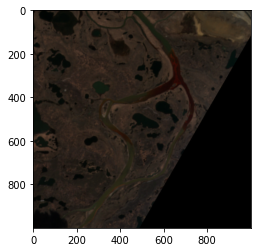

In [7]:
if len(contours) > 0:
    # Превращаем цветную картинку в список для передачи через json:
    img2_rgb = cv2.cvtColor(np.uint8(img2), cv2.COLOR_BGR2RGB)
    pil_img2 = Image.fromarray(img2_rgb)
    b = io.BytesIO()
    pil_img2.save(b, 'jpeg')
    pil_img2_bytes = b.getvalue()
    str_img2 = str(base64.b64encode(pil_img2_bytes), encoding='utf-8')#.decode('utf-8')
    plt.imshow(pil_img2)
    plt.axis("on")
    plt.show()

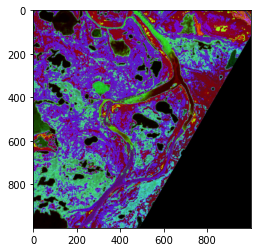

In [8]:
if len(contours) > 0:
    # Превращаем цветную HightLight картинку в список для передачи через json:
    imgTrueColor_rgb = cv2.cvtColor(np.uint8(imgTrueColor), cv2.COLOR_BGR2RGB)
    pil_imgTrueColor = Image.fromarray(imgTrueColor_rgb)
    b = io.BytesIO()
    pil_imgTrueColor.save(b, 'jpeg')
    pil_imgTrueColor_bytes = b.getvalue()
    str_imgTrueColor = str(base64.b64encode(pil_imgTrueColor_bytes), encoding='utf-8')#.decode('utf-8')
    plt.imshow(pil_imgTrueColor)
    plt.axis("on")
    plt.show()

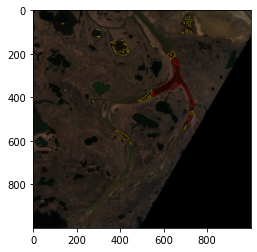

In [9]:
if len(contours) > 0:
    # Превращаем цветную картинку с нанесенными контурами в список для передачи через json:
    resImg_rgb = cv2.cvtColor(np.uint8(resImg), cv2.COLOR_BGR2RGB)
    pil_resImg_rgb = Image.fromarray(resImg_rgb)
    b = io.BytesIO()
    pil_resImg_rgb.save(b, 'jpeg')
    pil_resImg_rgb_bytes = b.getvalue()
    str_resImg_rgb = str(base64.b64encode(pil_resImg_rgb_bytes), encoding='utf-8')#.decode('utf-8')
    plt.imshow(pil_resImg_rgb)
    plt.axis("on")
    plt.show()

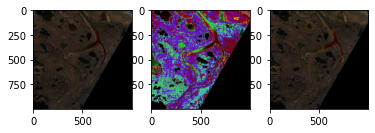

In [10]:
# Построим все три картинки вместе:
if len(contours) > 0:
    # Превращаем цветную картинку в список для передачи через json:
    img2_rgb = cv2.cvtColor(np.uint8(img2), cv2.COLOR_BGR2RGB)
    pil_img2 = Image.fromarray(img2_rgb)
    b = io.BytesIO()
    pil_img2.save(b, 'jpeg')
    pil_img2_bytes = b.getvalue()
    str_img2 = str(base64.b64encode(pil_img2_bytes), encoding='utf-8')#.decode('utf-8')
    
    # Превращаем цветную HightLight картинку в список для передачи через json:
    imgTrueColor_rgb = cv2.cvtColor(np.uint8(imgTrueColor), cv2.COLOR_BGR2RGB)
    pil_imgTrueColor = Image.fromarray(imgTrueColor_rgb)
    b = io.BytesIO()
    pil_imgTrueColor.save(b, 'jpeg')
    pil_imgTrueColor_bytes = b.getvalue()
    str_imgTrueColor = str(base64.b64encode(pil_imgTrueColor_bytes), encoding='utf-8')#.decode('utf-8')
    
    # Превращаем цветную картинку с нанесенными контурами в список для передачи через json:
    resImg_rgb = cv2.cvtColor(np.uint8(resImg), cv2.COLOR_BGR2RGB)
    pil_resImg_rgb = Image.fromarray(resImg_rgb)
    b = io.BytesIO()
    pil_resImg_rgb.save(b, 'jpeg')
    pil_resImg_rgb_bytes = b.getvalue()
    str_resImg_rgb = str(base64.b64encode(pil_resImg_rgb_bytes), encoding='utf-8')#.decode('utf-8')
    
    # Выводим на экран все три картинки:
    plt.subplot(1,3,1)
    plt.imshow(pil_img2)
    plt.subplot(1,3,2)
    plt.imshow(pil_imgTrueColor)
    plt.subplot(1,3,3)
    plt.imshow(pil_resImg_rgb)
    plt.axis("on")
    plt.show()